###  _Εργαστηριακή Άσκηση 3 : Βελτιστοποίηση συναρτήσεων με Γενετικούς Αλγόριθμους._

***
#### Ομάδα A52
    Μέλος 1 : Καλαβάσης Αλβέρτος    Α.Μ. 03114091 
    Μέλος 2 : Ρούλιος Χαράλαμπος    Α.Μ. 03114004
***
##### Ημερομηνία παράδοσης : Πέμπτη 28 Φεβρουαρίου 2019
***

<img src="http://infinity77.net/global_optimization/_images/Alpine01.png" alt="Alpine01" style="width: 200px;"/>


<div class="alert alert-block alert-info">
Στόχος της άσκησης είναι η βελτιστοποίηση συναρτήσεων χωρίς παραγώγους (derivative free optimization) με χρήση Γενετικών Αλγόριθμων μέσω της βιβλιοθήκης DEAP. Η βελτιστοποίηση χωρίς παραγώγους είναι ιδιαίτερα χρήσιμη σε περιπτώσεις όπου η αντικειμενική συνάρτηση $f$ δεν είναι διαθέσιμη (black-box optimization) ή σε περίπτωσεις που είναι, είναι δύσκολο ή μη πρακτικό να υπολογιστούν οι παράγωγοί της. Για παράδειγμα η  $f$ μπορεί να μην είναι διαφορίσιμη, η παραγώγιση της μπορεί να είναι δύσκολη ή να απαιτεί πολύ χρόνο,  η $f$ να περιέχει θόρυβο έτσι ώστε οι μέθοδοι που βασίζονται σε απειροστικές διαφορές να μην είναι αποτελεσματικές ή να υπάρχουν πολλά τοπικά βέλτιστα μεταξύ άλλων. 
</div>

In [116]:
# Basic imports.
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade termcolor
!pip install --upgrade PTable
!pip install --upgrade matplotlib
!pip install deap
!pip install pandas

Requirement already up-to-date: pip in /home/tyler/anaconda3/lib/python3.6/site-packages (19.0.3)
Requirement already up-to-date: numpy in /home/tyler/anaconda3/lib/python3.6/site-packages (1.16.2)
Requirement already up-to-date: pandas in /home/tyler/anaconda3/lib/python3.6/site-packages (0.24.1)
Requirement already up-to-date: termcolor in /home/tyler/anaconda3/lib/python3.6/site-packages (1.1.0)
Requirement already up-to-date: PTable in /home/tyler/anaconda3/lib/python3.6/site-packages (0.9.2)
Requirement already up-to-date: matplotlib in /home/tyler/anaconda3/lib/python3.6/site-packages (3.0.2)


Παρακάτω, ορίζουμε μία κλάση για να χρησιμοποιήσουμε χρώματα κατά τα prints. 

In [117]:
import sys
import warnings
import random
random.seed(42)


# Source : https://stackoverflow.com/questions/287871/print-in-terminal-with-colors
from termcolor import colored
# colored used as : print(colored('Hello World!', 'blue'))
class color:
    BOLD = '\033[1m'
    END = '\033[0m'
    UNDERLINE = '\033[4m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    CITALIC   = '\33[3m'
# color class used as : print(color.BOLD + "Hello World!" + color.END)

warnings.filterwarnings("ignore")

##  Μέρος 1. Βελτιστοποίηση μη κλιμακούμενης συνάρτησης

#### Οπτική αναπαράσταση μη κλιμακούμενης συνάρτησης (non-scalable, δηλαδή ορίζεται για συγκεκριμένες διαστάσεις του πεδίου ορισμού) :

In [3]:
__MIN_BOUND, __MAX_BOUND = -500, 500

In [4]:
import math

# This is our non-scalable function with id 107.
def f107(x1, x2):
    return 7*x1**2 - 6*math.sqrt(3)*x1*x2 + 13*x2**2

In [5]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

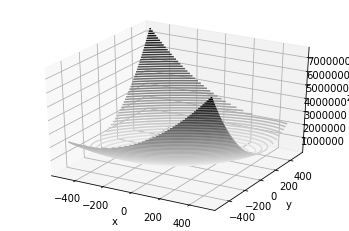

In [6]:
# Plot function in [-500, 500] x [-500, 500].
x = np.linspace(__MIN_BOUND, __MAX_BOUND, 30)
y = np.linspace(__MIN_BOUND, __MAX_BOUND, 30)
X, Y = np.meshgrid(x, y)
Z = f107(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

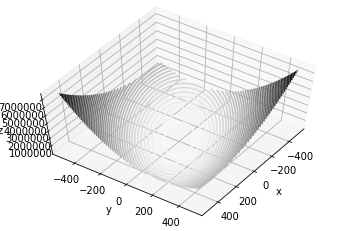

In [7]:
# Plot it from a different view angle.
ax.view_init(60, 35)
fig

### Εύρεση βέλτιστου συνδυασμού τελεστών - στρατηγικής

Ξεκινώντας με τον ορισμό των απαραίτητων κλάσεων "FitnessMin" και "IndividualContainer", αλλά και με την αρχικοποίηση του toolbox της βιβλιοθήκης deap, ορίζουμε ως άτομο του πληθυσμού (χρωμόσωμα) ένα διάνυσμα δύο σημείων (x1,x2) όπου τα x1,x2 θα είναι πραγματικοί αριθμοί μεταξύ του -500 και 500, ενώ ως πληθυσμό, μια λίστα από τέτοια άτομα.

Στη συνέχεια ορίζουμε την συνάρτηση καταλληλότητας, η οποία λαμβάνει τη τιμή της συνάρτησης $f_{107}$ όταν τα x1,x2 είναι εντός του πεδίου ορισμού (το -500,500) και τιμή αρκετά μεγαλύτερη (συναρτήσει πάλι των x1,x2) όταν οι μεταβλητές αυτές είναι εκτός του πεδίου ορισμού, έτσι ώστε τέτοια άτομα να έχουν μηδενική πιθανότητα να επιβιώσουν από την διαδικασία της φυσικής επιλογής.

In [118]:
import numpy as np
from deap import base, creator, tools

In [119]:
numVariables = 2

# Main fitness (minimizer) and toolbox stuff.
creator.create("FitnessMin", base.Fitness , weights=(-1.0,))
creator.create("IndividualContainer", list , fitness= creator.FitnessMin)

In [11]:
toolbox = base.Toolbox()
toolbox.register("InitialValue", np.random.uniform, __MIN_BOUND, __MAX_BOUND)
toolbox.register("indiv", tools.initRepeat, creator.IndividualContainer, toolbox.InitialValue, numVariables)
toolbox.register("population", tools.initRepeat, list , toolbox.indiv)

In [12]:
#Fitness function
MIN_BOUND = np.array([__MIN_BOUND]*numVariables)
MAX_BOUND = np.array([__MAX_BOUND]*numVariables)

# print(any( [501, 0] > MAX_BOUND)) => False.

def eval_f107(x):
    sum = 7*x[0]**2 - 6*math.sqrt(3)*x[0]*x[1] + 13*x[1]**2
    return (sum, )

def feasible(indiv):
    # Feasibility function for the individual. Returns True if feasible False otherwise.
    if any(indiv < MIN_BOUND) or any(indiv > MAX_BOUND):
        return False
    return True

def distance(indiv) :
    # A distance function to the feasibility region.
    return ((indiv[0]**2 + indiv[1]**2) * 10 ** 17)

# Add function to toolbox.
toolbox.register("evaluate", eval_f107)
toolbox.decorate("evaluate", tools.DeltaPenalty (feasible, 1000.0, distance))

In [13]:
#For multiproccesing.
# import multiprocessing
# pool = multiprocessing.Pool()
# toolbox.register("map", pool.map)

In [14]:
# #Parameters
GOAL = 0.0 # The real minimum.
DELTA = 1e-39 # The error => |min_found - GOAL| < DELTA <=> Success.
MAX_ROUNDS = 10 # Repeat GA, MAX_ROUNDS times.
MAX_GENS = 70 # Generations.
MAX_POP = 200 # Population.
cross_prob = 0.8 # Crossover probability.
mut_prob = 0.1 # Mutation probability.
indpb_ = 0.5

#μ,λ
Mu = 50 # Number of population selected.
Lambda = 150 # Number of children born.

Εφόσον έχουν οριστεί κάποιες από τις απαραίτητες παραμέτρους για την εκτέλεση των γενετικών αλγορίθμων που θα ακολουθήσουν, παρακάτω ορίζουμε την συνάρτηση evaluate_GA, η οποία τρέχει τον εκάστοτε αλγόριθμο και επιστρέφει μία λίστα με τα στατιστικά της εκτέλεσης.

Πιο συγκεκριμένα, η συνάρτηση αυτή δέχεται σαν παράμετρο αρχικά τον γενετικό αλγόριθμο (απλό, μ+λ ή μ,λ) αλλά και τις παραπάνω παραμέτρους και τρέχει τον αλγόριθμο όσες φορές υποδεικνύει ο μέγιστος αριθμός γύρων, για συγκεκριμένο αριθμό γενεών. Σε κάθε γύρο, πέρα από την εκτέλεση του γενετικού αλγορίθμου, ενημερώνονται κάποια αθροίσματα έτσι ώστε στο τέλος να βρεθεί η μέση τιμή των απόλυτων και σχετικών κριτιρίων που ζητούνται. Να σημειωθεί ότι για τα σχετικά κριτίρια, ενημέρωση γίνεται μόνο όταν στον συγκεκριμένο γύρο ο γεντικός αλγόριθμος βρίσκει ελάχιστη τιμή που να είναι μικρότερη από το GOAL+DELTA που έχει οριστεί (δηλαδή σημειώνει επιτυχία).

Τελικά η συνάρτηση αυτή επιστρέφει μια λίστα με τα 4 σχετικά κριτίρια και τα 3 απόλυτα.

In [139]:
from deap import algorithms
import time
import bisect

# Main Evaluate GA function.
def evaluate_GA(gen_algorithm, cross_prob, mut_prob, MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, DELTA):
    avg_min, avg_evals, avg_time = 0, 0, 0
    successes, success_avg_gen, success_avg_min, success_avg_evals = 0, 0, 0, 0
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    
    for i in range(MAX_ROUNDS):
        pop = toolbox.population(n=MAX_POP) # init population.
        hof = tools.HallOfFame(1) # best point (min fitness).
        
        # Run algo GA and Compute time.
        start = time.time()
        pop, logbook = gen_algorithm(pop, toolbox, cross_prob, mut_prob, MAX_GENS, stats, hof)
        duration = time.time() - start
        
        # Absolute statistics.
        best = hof[0].fitness.values[0] # This is the best individual in round i.
        for i in range(len(hof[0])):
            print(colored("Best x%d component: %5.80f", 'blue')  % (i+1, hof[0][i]))
        print("***************************************************")
        summ = sum(logbook.select("nevals"))
        avg_min += best # add the ith round's minimum. 
        avg_evals += summ # add the sum of scores of the ith round.
        avg_time += duration # add duration of the ith round.
        
        # Relative statistics.
        success = abs(best - GOAL) < DELTA # Check if we won.
        if success: # If so, update success statistics.
            successes += 1
            #Below, finds the generation with the closest fitness to GOAL+DELTA.
            success_avg_gen += max(1, MAX_GENS - 1 - bisect.bisect((logbook.select("min")[::-1]), GOAL+DELTA)) 
            success_avg_min += best
            success_avg_evals += summ
        
    abs_result = np.array([avg_evals, avg_min, avg_time]) 
    abs_result = abs_result / MAX_ROUNDS # Abs results final stuff.
    
    #Check for no successes.
    if successes > 0: # At least one.
        rel_result = np.array([successes**2/MAX_ROUNDS, success_avg_min, success_avg_evals, success_avg_gen])
        rel_result = rel_result / successes
    else: # No successes.
        rel_result = np.array([None, None, None, None])
    
    #Concat the two arrays.
    result = np.concatenate((rel_result, abs_result), axis=None)

    return result

In [121]:
#Genetic operator degree, low-high

# Cross
blend_value = [0.2, 0.8] #[low, high]       
SB_value = [0.8, 0.3]

In [17]:
# Mutation
Gaussian_value = [(0.0, 5), (10, 30)]  #(mu, sigma)
Uniform_value = [(-5, 5), (-500, 500)] #(low, up)

- H mutGaussian λειτουργεί ως εξής :

def mutGaussian(individual, mu, sigma, indpb):

    """This function applies a gaussian mutation of mean *mu* and standard
    deviation *sigma* on the input individual. This mutation expects a
    :term:`sequence` individual composed of real valued attributes.
    The *indpb* argument is the probability of each attribute to be mutated.
    
    :param individual: Individual to be mutated.
    :param mu: Mean or :term:`python:sequence` of means for the
               gaussian addition mutation.
    :param sigma: Standard deviation or :term:`python:sequence` of 
                  standard deviations for the gaussian addition mutation.
    :param indpb: Independent probability for each attribute to be mutated.
    :returns: A tuple of one individual.
    
    This function uses the :func:`~random.random` and :func:`~random.gauss`
    functions from the python base :mod:`random` module.
    """
    size = len(individual)
    if not isinstance(mu, Sequence):
        mu = repeat(mu, size)
    elif len(mu) < size:
        raise IndexError("mu must be at least the size of individual: %d < %d" % (len(mu), size))
    if not isinstance(sigma, Sequence):
        sigma = repeat(sigma, size)
    elif len(sigma) < size:
        raise IndexError("sigma must be at least the size of individual: %d < %d" % (len(sigma), size))
    
    for i, m, s in zip(range(size), mu, sigma):
        if random.random() < indpb:
            individual[i] += random.gauss(m, s)
    
    return individual,
    
    
- Για δεύτερη συνάρτηση mutation, επιλέξαμε να κατασκευάσουμε μία δική μας mutUniform, η οποία για κάθε $x_{i}$ με πιθανότητα $indpb$ να διαλέγει ομοιόμορφα ένα αριθμό στο διάστημα $[low, high],$ τα άκρα του οποίου επιλέχθηκαν από εμάς. Στην mutUniformLow έχουμε στενό διάστημα $[-5, 5],$ ενώ στην mutUniformHigh διαλέξαμε το μέγιστο δυνατό $[-500, 500].$ Έπειτα, καθώς θέλουμε ο συνδυασμός high να οδηγεί σε μεγαλύτερη αλλαγή του γενετικού υλικού και αντίστροφα ο συνδυασμός low σε μικρότερη, μετατοπίζουμε την αντίστοιχη συντεταγένη με ανάλογα μεγάλο ή μικρό offset. Έτσι, η αναμενόμενη τιμή της μετατόπισης θα είναι σχετικά μικρή για το low (μικρή μεταβολή) και σχετικά μεγάλη για το high.

In [122]:
#Custom Low-High functions.
#######################################################################

#Crossover
def BlendLow(ind1,ind2):
    return tools.cxBlend(ind1, ind2, alpha = blend_value[0])

def BlendHigh(ind1,ind2):
    return tools.cxBlend(ind1, ind2, alpha = blend_value[1])

def SimulatedLow(ind1,ind2):
    return tools.cxSimulatedBinary(ind1, ind2, eta = SB_value[0])

def SimulatedHigh(ind1,ind2):
    return tools.cxSimulatedBinary(ind1, ind2, eta = SB_value[1])
#######################################################################

#Mutation
def GaussianLow(ind):
    return tools.mutGaussian(ind, mu = Gaussian_value[0][0], sigma = Gaussian_value[0][1], indpb = indpb_)

def GaussianHigh(ind):
    return tools.mutGaussian(ind, mu = Gaussian_value[1][0], sigma = Gaussian_value[1][1], indpb = indpb_)


# This is our mutation.
def uniform(indiv, a, b):
    indpb = indpb_ # Prob that x_{i} will be mutated.
    size = len(indiv)
    low_bound, up_bound = a, b
    for i in range(size):
        if random.random() < indpb: # then mutate indiv[i]
            indiv[i] += random.uniform(low_bound, up_bound)
    return indiv,

# This is our mutation.
def UniformLow(indiv):
    return uniform(indiv, Uniform_value[0][0], Uniform_value[0][1])
    
def UniformHigh(indiv):
    return uniform(indiv, Uniform_value[1][0], Uniform_value[1][1])

# Maybe try the mutShuffleIndexes.

# We did not use them.
# def PolynomialBoundedLow(ind): 
#     return tools.mutPolynomialBounded(ind, eta = Poly_value[0][2], low = Poly_value[0][0], up = Poly_value[0][1], indpb = 0.1)

# def PolynomialBoundedHigh(ind):
#     return tools.mutPolynomialBounded(ind, eta = Poly_value[1][2], low = Poly_value[1][0], up = Poly_value[1][1], indpb = 0.1)

#######################################################################

#The 3 strategies
def mySimple(pop, toolbox, cross_prob, mut_prob, MAX_GENS, stats, hof):
    return algorithms.eaSimple(pop, toolbox, cxpb=cross_prob, mutpb=mut_prob, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=False)

def myMuPlusLambda(pop, toolbox, cross_prob, mut_prob, MAX_GENS, stats, hof):
    return algorithms.eaMuPlusLambda(pop, toolbox, Mu, Lambda, cxpb=cross_prob, mutpb=mut_prob, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=False)

def myMuCommaLambda(pop, toolbox, cross_prob, mut_prob, MAX_GENS, stats, hof):
    return algorithms.eaMuCommaLambda(pop, toolbox, Mu, Lambda, cxpb=cross_prob, mutpb=mut_prob, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=False)
#######################################################################

Ως τελεστές διασταύρωσης επιλέχτηκαν οι συναρτήσεις "cxBlend" και "cxSimulatedBinary" της βιβλιοθήκης deap, ενώ ως τελεστές μετάλαξης, οι συναρτήσεις "mutGaussian" και "mutUniformInt", με τις υπερπαραμέτρους τους (low-high) να έχουν οριστεί προηγουμένως.

Στο προηγούμενο κελί, έχει πραγματοποιηθεί ουσιαστικά ένας επαναορισμός των συναρτήσεων-τελεστών διασταύρωσης και μετάλλαξης και των συναρτήσεων για τις 3 στρατηγικές γενητικών αλγορίθμων προς εξέταση. Ο ορισμός αυτός έχει γίνει έτσι ώστε οι συναρτήσεις αυτές να δέχονται τα ίδια ορίσματα, ανεξάρτητα από τις τιμές υπερπαραμέτρων του εκάστοτε τελεστή, έτσι ώστε να γίνει στη συνέχεια βολικός ο ορισμός όλων των δυνατών 96 συνδυασμών τελεστών στρατηγικών και πιο βολικός ο ορισμός της βοηθητικής συνάρτησης print_results.

Η συνάρτηση print_results που ακολουθεί, δέχεται σα παράμετρο όλους τους συνδυασμούς τελεστών-στρατηγικών προς εξέταση, μαζί με τις αντίστοιχες ονομασίες τους, τρέχει κάθε έναν από τους 96 γενετικούς αλγορίθμους, συγκεντώνει σε ένα ενιαίο Dataframe του Pandas όλα τα αποτελέσματα που ζητούνται, και τελικά το επιστρέφει.

In [123]:
import itertools

In [20]:
#Genetic operators
cross_operators = [BlendLow, BlendHigh, SimulatedLow, SimulatedHigh]
mut_operators = [GaussianLow, GaussianHigh, UniformLow, UniformHigh]

In [21]:
#Selection parameters
tourn_size = [3, 10]

In [124]:
#Strategies-genetic algorithms
strategies = [mySimple, myMuPlusLambda, myMuCommaLambda]

In [125]:
#32 combinations
all_combinations = list(itertools.product(cross_operators, mut_operators, tourn_size, strategies))

# Each 32 combos with * 3 for the 3 algorithms.

In [126]:
#Names
#operator names 
cross_names = ["BlendLow", "BlendHigh", "SimulatedBinaryLow", "SimulatedBinaryHigh"]
mut_names = ["GaussianLow", "GaussianHigh", "UniformLow", "UniformHigh"]
selection_names = ["TournamentLow", "TournamentHigh"]

#strategy_names
strategy_names = ["eaSimple "+str(MAX_POP)+" "+str(cross_prob)+" "+str(mut_prob), \
                  "eaMuPlusLambda "+str(Mu)+" "+str(Lambda)+" "+str(cross_prob)+" "+str(mut_prob), \
                  "eaMuCommaLambda "+str(Mu)+" "+str(Lambda)+" "+str(cross_prob)+" "+str(mut_prob)]

all_names = list(itertools.product(cross_names, mut_names, selection_names, strategy_names))

In [127]:
import pandas as pd

# Print results for each combination.
# Store all results to a pandas table for a final print later.
def print_results(all_names, all_combinations):
    total_tests = np.shape(all_names)[0] # Here total_tests = 96.
    
    result_table = np.empty([total_tests, 7])
    operator_names = ["" for x in range(total_tests)]
    strategy_names = ["" for x in range(total_tests)]
    
    for i, combination in enumerate(all_combinations):
        print(colored("Combination : ", 'red'), i)
        cross_operator, mut_operator, tournsize_, algorithm = combination
        
        toolbox.register( "mate", cross_operator)
        toolbox.register( "mutate", mut_operator)
        toolbox.register( "select", tools.selTournament, tournsize = tournsize_)
        
        #Running the algorithm
        result_table[i,:] = evaluate_GA(algorithm, cross_prob, mut_prob, MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, DELTA)
        
        operator_names[i] = all_names[i][0] + "," + all_names[i][1] + "," + all_names[i][2]
        strategy_names[i] = all_names[i][3]
        print(color.BOLD + '************************************' + color.END)
    Panda_Table = pd.DataFrame({'Operators':operator_names, 'Strategy':strategy_names, 'successes':result_table[:,0], \
                               's.avg.min':result_table[:,1], 's.avg.evals':result_table[:,2], 's.avg.gens':result_table[:,3], \
                               'avg.evals':result_table[:,4], 'avg.min':result_table[:,5], 'avg.time':result_table[:,6]}, \
                               columns=['Operators', 'Strategy', 'successes', 's.avg.min', 's.avg.evals', 's.avg.gens', 'avg.evals', \
                                'avg.min', 'avg.time'])
    #For displaying all cases
    pd.options.display.max_rows = total_tests
    return Panda_Table

In [25]:
result_table = print_results(all_names, all_combinations)

Combination :  0
gen	nevals	min    
0  	200   	17653.8
1  	165   	3500.45
2  	169   	1997.07
3  	167   	5.18885
4  	156   	41.877 
5  	163   	41.877 
6  	172   	10.8025
7  	168   	0.814576
8  	170   	0.814576
9  	165   	0.457539
10 	167   	0.237321
11 	169   	0.0494037
12 	164   	0.0499603
13 	169   	0.00143227
14 	175   	0.00143227
15 	163   	0.000723943
16 	159   	6.37716e-05
17 	161   	3.03636e-05
18 	176   	2.13865e-06
19 	172   	6.1453e-06 
20 	152   	8.56492e-06
21 	155   	1.27967e-06
22 	159   	6.25233e-07
23 	169   	2.12695e-07
24 	159   	2.51745e-07
25 	167   	8.81645e-11
26 	167   	1.86203e-09
27 	169   	1.13026e-09
28 	161   	8.12859e-10
29 	162   	2.20647e-10
30 	173   	4.26326e-11
31 	167   	3.56342e-12
32 	153   	2.82927e-12
33 	166   	2.30418e-12
34 	165   	1.78235e-12
35 	160   	2.87178e-13
36 	157   	8.66855e-14
37 	155   	9.91697e-16
38 	161   	9.91697e-16
39 	162   	5.02757e-17
40 	167   	5.02757e-17
41 	164   	5.02757e-17
42 	161   	7.8476e-18 
43 	155   	5.23106e-1

0  	200   	9059.58
1  	171   	931.779
2  	164   	52.1214
3  	165   	52.1214
4  	162   	5.27965
5  	166   	2.23612
6  	166   	1.09066
7  	160   	1.40082
8  	172   	0.165388
9  	163   	0.00696179
10 	164   	0.00696179
11 	155   	0.00784543
12 	157   	0.0224359 
13 	152   	0.00605094
14 	160   	0.00106093
15 	150   	0.000508334
16 	162   	0.000406159
17 	168   	0.000101026
18 	162   	2.04147e-05
19 	178   	1.31379e-05
20 	140   	4.58027e-07
21 	169   	1.12684e-06
22 	166   	1.00406e-06
23 	163   	5.9904e-08 
24 	172   	5.9904e-08 
25 	168   	2.04448e-10
26 	169   	1.06296e-09
27 	166   	1.06296e-09
28 	150   	1.06296e-09
29 	156   	2.34716e-10
30 	175   	2.90168e-11
31 	172   	1.44515e-11
32 	156   	1.77458e-12
33 	164   	1.77458e-12
34 	178   	7.28435e-13
35 	167   	7.28435e-13
36 	174   	2.48657e-14
37 	160   	3.12602e-14
38 	156   	5.00039e-15
39 	164   	3.62619e-16
40 	158   	1.23786e-16
41 	156   	1.23786e-16
42 	174   	8.44401e-17
43 	169   	1.29991e-17
44 	171   	1.69473e-17
45 	16

Best point : [2.420415182646807e-09, 2.8293388861841553e-09]
Best point : [-1.5355507238571255e-10, -1.488782275825737e-10]
Best point : [-3.2307406760383194e-14, 1.587640025000799e-14]
Best point : [-5.933446984454883e-05, -8.296629917231796e-05]
Best point : [-0.005747636045596839, -0.0028138735726824394]
Best point : [8.404437969405266e-05, 3.418019477991829e-05]
Best point : [0.0001464841296586434, 6.804244207028097e-05]
Best point : [7.152159848067891e-15, 3.741258988519635e-15]
Best point : [0.00017246997056414212, 9.203662730161363e-05]
Best point : [0.00161606612937605, 0.0022093203609566967]
************************************
Combination :  2
Best point : [0.00011957245252080395, 0.00014259154362585664]
Best point : [-0.1834115053398985, -0.1285522642186016]
Best point : [-0.00039436100055826716, -0.0005012268063044821]
Best point : [-4.0880505994553e-11, 5.919357180334972e-11]
Best point : [-1.6713672479994027e-07, -2.0597921142148615e-07]
Best point : [-1.8242430595140432e

18 	173   	8.95606e-15
19 	160   	3.55876e-15
20 	156   	1.19472e-16
21 	178   	1.36063e-17
22 	168   	8.4695e-18 
23 	176   	4.56001e-20
24 	169   	8.56002e-22
25 	167   	5.72763e-22
26 	168   	1.52414e-22
27 	160   	4.21188e-23
28 	160   	4.9535e-24 
29 	169   	1.44018e-24
30 	165   	5.11089e-26
31 	162   	1.43747e-26
32 	156   	1.334e-27  
33 	159   	1.38689e-28
34 	172   	5.83951e-31
35 	162   	5.83951e-31
36 	169   	1.36946e-32
37 	166   	4.83582e-33
38 	170   	2.06416e-33
39 	154   	5.09454e-35
40 	166   	4.49935e-36
41 	155   	9.32902e-39
42 	160   	9.32902e-39
43 	165   	6.98971e-41
44 	162   	6.98971e-41
45 	166   	2.9544e-41 
46 	167   	1.89693e-42
47 	154   	5.19972e-43
48 	173   	1.0632e-43 
49 	169   	1.85016e-44
50 	164   	6.43985e-46
51 	157   	6.43985e-46
52 	165   	4.42094e-47
53 	157   	1.85869e-48
54 	170   	1.85869e-48
55 	174   	5.10639e-49
56 	164   	3.35631e-50
57 	156   	2.19871e-50
58 	163   	3.49515e-52
59 	156   	1.97251e-52
60 	168   	6.76614e-54
61 	170   	

27 	150   	2.27419e-18
28 	166   	3.61697e-19
29 	172   	2.00826e-20
30 	174   	2.58052e-21
31 	156   	8.6557e-24 
32 	156   	8.6557e-24 
33 	165   	7.36647e-24
34 	155   	2.34847e-24
35 	171   	4.93533e-25
36 	161   	1.85342e-25
37 	171   	3.51526e-27
38 	158   	2.46694e-28
39 	154   	3.54891e-29
40 	158   	2.00192e-29
41 	156   	1.04559e-29
42 	163   	1.39094e-30
43 	164   	9.15928e-32
44 	159   	1.68379e-33
45 	174   	1.36552e-34
46 	157   	4.68783e-35
47 	167   	2.00317e-35
48 	171   	4.57414e-36
49 	175   	1.53017e-36
50 	163   	2.3357e-37 
51 	157   	1.45989e-38
52 	167   	3.52922e-40
53 	153   	9.40101e-41
54 	142   	3.76952e-41
55 	159   	3.75239e-43
56 	168   	3.59843e-43
57 	150   	2.64841e-44
58 	169   	1.67024e-45
59 	163   	4.41098e-46
60 	172   	1.58078e-46
61 	162   	2.20871e-47
62 	174   	1.15228e-48
63 	164   	1.86264e-50
64 	140   	5.23069e-51
65 	154   	3.11336e-52
66 	157   	5.79029e-53
67 	169   	1.70098e-54
68 	175   	5.20507e-56
69 	159   	1.33507e-56
70 	183   	

35 	172   	2.7643e-11 
36 	157   	3.41316e-11
37 	164   	3.11526e-11
38 	157   	2.19253e-11
39 	161   	3.0134e-13 
40 	161   	5.55697e-13
41 	164   	5.55697e-13
42 	162   	1.37083e-13
43 	164   	1.36934e-15
44 	174   	7.78989e-15
45 	165   	1.52006e-14
46 	167   	1.23165e-16
47 	164   	6.83622e-16
48 	182   	3.06193e-17
49 	162   	1.31833e-17
50 	157   	1.07403e-17
51 	154   	1.65587e-18
52 	168   	1.64637e-19
53 	156   	4.23043e-20
54 	170   	1.98293e-20
55 	169   	6.02095e-21
56 	175   	3.55494e-21
57 	172   	1.52347e-21
58 	153   	1.24328e-22
59 	161   	1.51527e-22
60 	159   	4.16989e-23
61 	162   	3.1606e-23 
62 	161   	5.07553e-24
63 	155   	9.79108e-25
64 	168   	8.79965e-25
65 	167   	4.53021e-25
66 	169   	3.95149e-27
67 	162   	2.86241e-26
68 	162   	1.71592e-28
69 	163   	7.81158e-27
70 	153   	3.96354e-27
Best point : [-5.569384323380192e-15, -3.431481780387349e-15]
gen	nevals	min    
0  	200   	8812.17
1  	156   	5453.64
2  	160   	134.953
3  	176   	130.041
4  	162   	34.7

31 	156   	1.79818e-12
32 	157   	1.42671e-13
33 	172   	5.55167e-16
34 	155   	5.18557e-14
35 	160   	2.78109e-14
36 	153   	6.14342e-15
37 	167   	1.65721e-15
38 	157   	8.82405e-17
39 	156   	1.43552e-16
40 	174   	1.00624e-17
41 	173   	1.00624e-17
42 	164   	1.60757e-18
43 	165   	6.99035e-19
44 	163   	4.40622e-19
45 	165   	1.46455e-19
46 	177   	9.10445e-20
47 	170   	2.48651e-20
48 	169   	1.10075e-20
49 	168   	7.34328e-23
50 	163   	6.31018e-22
51 	165   	2.86338e-22
52 	177   	1.22943e-23
53 	151   	1.27191e-23
54 	159   	1.12201e-23
55 	165   	1.23842e-24
56 	166   	1.23842e-24
57 	157   	4.51116e-25
58 	168   	5.99073e-26
59 	163   	6.35729e-26
60 	159   	5.3144e-26 
61 	158   	7.92606e-27
62 	169   	5.02892e-27
63 	158   	5.20286e-28
64 	158   	4.56948e-28
65 	156   	2.01116e-28
66 	176   	4.57042e-29
67 	162   	5.94851e-29
68 	166   	1.88362e-31
69 	181   	7.78597e-31
70 	156   	5.09722e-32
Best point : [3.293352576115604e-17, -4.608322091881266e-17]
gen	nevals	min    


29 	170   	4.47259e-25
30 	158   	8.35558e-26
31 	164   	7.9133e-27 
32 	164   	9.99535e-28
33 	171   	3.13215e-29
34 	164   	1.91128e-30
35 	163   	9.17706e-31
36 	165   	5.73054e-32
37 	169   	4.33081e-32
38 	156   	2.5155e-32 
39 	156   	2.01255e-32
40 	150   	1.5697e-32 
41 	181   	6.98949e-33
42 	162   	6.89628e-33
43 	158   	6.36745e-33
44 	173   	6.13877e-33
45 	160   	6.11948e-33
46 	171   	6.10615e-33
47 	162   	6.10075e-33
48 	151   	6.09962e-33
49 	153   	6.099e-33  
50 	165   	6.09898e-33
51 	168   	6.09898e-33
52 	171   	6.09885e-33
53 	172   	6.09874e-33
54 	162   	6.09873e-33
55 	157   	6.09872e-33
56 	164   	6.09872e-33
57 	165   	6.09872e-33
58 	160   	6.09872e-33
59 	151   	6.09872e-33
60 	166   	6.09872e-33
61 	142   	6.09872e-33
62 	160   	6.09872e-33
63 	167   	6.09872e-33
64 	167   	6.09872e-33
65 	169   	6.09872e-33
66 	171   	6.09872e-33
67 	171   	6.09872e-33
68 	154   	6.09872e-33
69 	181   	6.09872e-33
70 	166   	6.09872e-33
Best point : [1.921877645175595e-1

36 	167   	9.48151e-32
37 	164   	9.48151e-32
38 	167   	8.54512e-33
39 	167   	2.32965e-33
40 	169   	2.10938e-34
41 	173   	3.54431e-35
42 	166   	4.47189e-36
43 	167   	1.88385e-37
44 	144   	1.15619e-37
45 	167   	7.78967e-39
46 	168   	3.71793e-39
47 	177   	1.07765e-39
48 	156   	7.62075e-41
49 	160   	9.12046e-41
50 	178   	5.35071e-42
51 	169   	1.74936e-42
52 	178   	7.34793e-43
53 	166   	2.51431e-44
54 	164   	1.14809e-44
55 	157   	2.46817e-45
56 	178   	2.82489e-46
57 	151   	1.52377e-46
58 	154   	1.18861e-46
59 	170   	9.46816e-47
60 	179   	8.67225e-47
61 	168   	8.44372e-47
62 	162   	8.0473e-47 
63 	176   	8.05573e-47
64 	167   	7.9812e-47 
65 	165   	7.92369e-47
66 	162   	7.85253e-47
67 	164   	7.84545e-47
68 	163   	7.83366e-47
69 	169   	7.81489e-47
70 	163   	7.80087e-47
Best point : [2.3226442002267074e-24, 2.9177708739987575e-24]
gen	nevals	min    
0  	200   	9142.63
1  	154   	1770.45
2  	161   	589.862
3  	177   	42.1669
4  	169   	5.74018
5  	155   	1.40208


34 	166   	2.69276e-13
35 	169   	4.19245e-14
36 	169   	1.41952e-13
37 	160   	4.70115e-14
38 	147   	2.11875e-15
39 	155   	1.59189e-15
40 	154   	8.42099e-16
41 	159   	4.45967e-17
42 	176   	4.45967e-17
43 	150   	1.40341e-16
44 	163   	2.85017e-17
45 	162   	2.37015e-17
46 	160   	6.60813e-18
47 	180   	9.93703e-19
48 	175   	9.93703e-19
49 	169   	1.04425e-19
50 	172   	3.50557e-20
51 	158   	4.14023e-20
52 	168   	5.06586e-21
53 	170   	6.45662e-21
54 	169   	6.4684e-22 
55 	158   	5.27343e-22
56 	157   	5.27343e-22
57 	159   	5.51509e-25
58 	163   	5.51509e-25
59 	159   	3.53385e-24
60 	158   	1.00805e-24
61 	155   	4.40708e-26
62 	164   	2.59501e-26
63 	170   	2.59501e-26
64 	171   	2.59501e-26
65 	178   	1.45603e-26
66 	171   	3.05188e-27
67 	162   	6.21335e-28
68 	161   	1.2235e-28 
69 	166   	2.78322e-29
70 	182   	6.0063e-30 
Best point : [-1.0864758344053285e-15, -3.1180925767346427e-16]
gen	nevals	min    
0  	200   	3199.51
1  	163   	12.1008
2  	169   	45.2948
3  	159  

29 	160   	1.23143e-11
30 	158   	6.15381e-13
31 	157   	3.43542e-12
32 	158   	4.23251e-13
33 	165   	9.19238e-14
34 	161   	9.19238e-14
35 	174   	1.40904e-15
36 	169   	1.40904e-15
37 	165   	5.09284e-15
38 	156   	2.61541e-15
39 	167   	2.32036e-16
40 	169   	8.18659e-17
41 	175   	7.62114e-17
42 	156   	5.06996e-19
43 	163   	1.25467e-18
44 	174   	1.25467e-18
45 	167   	2.15081e-19
46 	155   	6.11215e-20
47 	152   	7.11372e-21
48 	158   	1.41545e-20
49 	148   	3.33587e-22
50 	152   	2.01845e-22
51 	180   	1.60631e-22
52 	160   	1.83154e-23
53 	156   	1.60631e-22
54 	163   	1.19108e-22
55 	155   	2.03709e-23
56 	162   	4.995e-24  
57 	177   	6.27216e-26
58 	165   	6.27216e-26
59 	168   	6.27216e-26
60 	161   	6.27216e-26
61 	172   	6.99548e-26
62 	164   	6.10707e-27
63 	169   	3.20545e-27
64 	164   	1.70908e-27
65 	164   	3.46895e-28
66 	158   	6.50929e-31
67 	166   	6.50929e-31
68 	158   	6.50929e-31
69 	155   	3.71776e-31
70 	163   	1.53896e-31
Best point : [1.528205812444841e-1

26 	156   	1.1029e-21 
27 	154   	4.55112e-22
28 	161   	6.51189e-24
29 	162   	9.0525e-25 
30 	175   	9.84506e-26
31 	173   	2.23154e-26
32 	170   	3.58779e-27
33 	163   	2.38686e-28
34 	169   	3.7941e-29 
35 	168   	1.95303e-30
36 	158   	1.93978e-30
37 	164   	1.85482e-31
38 	162   	4.62529e-33
39 	165   	1.25097e-33
40 	161   	6.58727e-34
41 	166   	7.04305e-35
42 	151   	6.42626e-36
43 	152   	2.29512e-36
44 	161   	7.39226e-37
45 	169   	2.9612e-38 
46 	152   	6.61049e-39
47 	158   	1.95595e-41
48 	146   	5.01431e-42
49 	163   	1.20048e-43
50 	160   	4.34208e-44
51 	166   	3.67944e-46
52 	158   	3.67944e-46
53 	149   	7.76224e-47
54 	172   	6.36669e-47
55 	161   	4.26318e-48
56 	163   	9.90954e-50
57 	166   	7.05676e-50
58 	168   	4.71693e-51
59 	167   	1.28828e-51
60 	155   	6.68207e-53
61 	158   	6.68207e-53
62 	160   	1.27706e-54
63 	157   	1.27706e-54
64 	166   	3.67201e-56
65 	172   	1.57127e-57
66 	165   	2.58126e-59
67 	162   	2.58126e-59
68 	164   	1.5753e-59 
69 	161   	

25 	160   	3.6438e-21 
26 	170   	2.38627e-21
27 	163   	8.6342e-23 
28 	162   	4.71973e-25
29 	165   	4.71973e-25
30 	169   	2.44731e-25
31 	166   	8.45222e-27
32 	163   	1.22641e-27
33 	173   	6.3263e-29 
34 	177   	1.20721e-29
35 	168   	4.1332e-30 
36 	161   	1.67481e-31
37 	162   	5.15621e-34
38 	167   	2.95194e-34
39 	170   	1.7407e-35 
40 	164   	2.11572e-36
41 	171   	8.66735e-37
42 	173   	1.58355e-37
43 	161   	2.12877e-38
44 	178   	1.57602e-39
45 	158   	1.85697e-40
46 	175   	1.06331e-41
47 	169   	1.12247e-42
48 	173   	6.70616e-43
49 	169   	8.36264e-45
50 	163   	8.36264e-45
51 	165   	6.05792e-46
52 	155   	1.60466e-47
53 	168   	7.55281e-48
54 	170   	4.85298e-48
55 	158   	1.45797e-49
56 	163   	1.65869e-50
57 	171   	1.9298e-51 
58 	171   	8.6796e-53 
59 	170   	3.1006e-53 
60 	163   	1.88426e-53
61 	160   	2.02507e-54
62 	170   	2.37444e-55
63 	179   	8.34184e-56
64 	165   	7.7132e-57 
65 	184   	5.37008e-58
66 	156   	1.28373e-58
67 	155   	3.17013e-59
68 	154   	

Best point : [-9.985797532314336e-05, -5.5126810105821415e-05]
Best point : [1.2383344083347584e-06, 1.7588218305312163e-06]
Best point : [-7.611993391088021e-10, -1.030297056457721e-09]
Best point : [-0.06345728908869132, -0.025364354389507963]
Best point : [-3.5168916900691756e-07, -4.742205875638512e-07]
Best point : [4.578827922365696e-14, 1.8588355751475893e-14]
Best point : [1.9825456613949072e-05, 8.105412947414154e-06]
************************************
Combination :  17
Best point : [8.836394369078312e-31, 9.834072624522333e-31]
Best point : [6.325793447566668e-17, 2.527256973047986e-17]
Best point : [-0.00037803886858544297, -0.0005058942551364685]
Best point : [1.3633970697447274e-28, 8.176737486545682e-29]
Best point : [-2.764005291797175e-29, -1.07602754558221e-29]
Best point : [-2.0395179627330165e-14, -2.545107501289877e-14]
Best point : [-4.910314474486377e-18, -4.053920860943316e-18]
Best point : [-0.0009536969787960771, -0.00046866576494966475]
Best point : [8.81920

35 	173   	3.54633e-13
36 	169   	4.59071e-14
37 	169   	4.36212e-14
38 	159   	3.96461e-14
39 	168   	1.27476e-14
40 	163   	4.33702e-15
41 	161   	2.64568e-16
42 	154   	2.27043e-16
43 	168   	1.11003e-16
44 	160   	2.87407e-17
45 	172   	4.66139e-17
46 	168   	1.96306e-18
47 	161   	1.96306e-18
48 	158   	1.44515e-18
49 	163   	1.42457e-18
50 	162   	6.88828e-20
51 	162   	5.94386e-20
52 	155   	3.1142e-21 
53 	157   	3.1142e-21 
54 	159   	7.93705e-22
55 	167   	6.71892e-22
56 	169   	2.91671e-23
57 	158   	1.2805e-22 
58 	166   	2.73313e-23
59 	172   	5.46241e-24
60 	151   	9.85093e-25
61 	168   	4.28393e-25
62 	164   	4.7405e-25 
63 	153   	3.19919e-27
64 	173   	3.19919e-27
65 	165   	1.69563e-27
66 	173   	1.69563e-27
67 	161   	4.48865e-28
68 	165   	2.12237e-28
69 	166   	2.18044e-29
70 	155   	1.79932e-29
Best point : [5.419109891949836e-16, -9.11615603062967e-16]
gen	nevals	min    
0  	200   	11522.6
1  	166   	2634.08
2  	162   	949.525
3  	162   	202.428
4  	171   	6.5192

33 	166   	2.37015e-13
34 	160   	1.99616e-13
35 	153   	1.99616e-13
36 	162   	4.04144e-14
37 	160   	1.12698e-14
38 	172   	6.51226e-16
39 	181   	1.49256e-15
40 	175   	3.81633e-16
41 	170   	1.96481e-16
42 	144   	5.64818e-17
43 	157   	1.69473e-17
44 	184   	1.76443e-18
45 	169   	1.45909e-18
46 	177   	6.65933e-19
47 	159   	1.27543e-20
48 	169   	1.27543e-20
49 	166   	1.12418e-20
50 	162   	6.81105e-21
51 	167   	1.05482e-21
52 	154   	4.13793e-22
53 	179   	4.37528e-22
54 	148   	3.00994e-23
55 	153   	1.66255e-23
56 	171   	4.25241e-24
57 	158   	2.69475e-25
58 	169   	8.37456e-25
59 	161   	8.48072e-25
60 	162   	7.38005e-27
61 	175   	8.4705e-27 
62 	163   	5.38387e-27
63 	154   	5.56747e-27
64 	164   	1.16797e-27
65 	167   	1.80235e-28
66 	158   	1.61636e-28
67 	168   	7.94508e-30
68 	153   	5.17922e-31
69 	169   	2.73487e-31
70 	179   	5.51735e-31
Best point : [2.350973039113428e-16, 8.364677755458715e-17]
************************************
Combination :  19
Best point 

27 	168   	8.66132e-20
28 	156   	1.87075e-20
29 	162   	1.56474e-21
30 	162   	2.17748e-22
31 	175   	8.85653e-23
32 	169   	3.47298e-24
33 	165   	3.48557e-25
34 	165   	1.99072e-25
35 	156   	1.92704e-26
36 	171   	9.37874e-27
37 	170   	6.63222e-29
38 	163   	3.50903e-29
39 	163   	2.20203e-30
40 	167   	9.00165e-31
41 	176   	9.00165e-31
42 	162   	6.31169e-32
43 	158   	1.68649e-33
44 	168   	9.74139e-34
45 	172   	3.85981e-34
46 	170   	3.27868e-35
47 	178   	2.71005e-36
48 	168   	6.44971e-37
49 	173   	7.00053e-38
50 	169   	1.24606e-38
51 	174   	1.52993e-39
52 	170   	1.89516e-40
53 	165   	2.33836e-41
54 	169   	2.05744e-42
55 	159   	2.48737e-43
56 	176   	2.81624e-44
57 	154   	4.99165e-45
58 	172   	3.2049e-47 
59 	163   	3.2049e-47 
60 	168   	7.48469e-49
61 	157   	2.07506e-49
62 	165   	1.52025e-49
63 	162   	6.62288e-51
64 	152   	2.38864e-52
65 	157   	2.38864e-52
66 	166   	1.08738e-53
67 	169   	3.19664e-54
68 	157   	5.56171e-56
69 	158   	5.56171e-56
70 	162   	

32 	144   	1.59788e-07
33 	162   	6.66991e-08
34 	163   	3.40399e-08
35 	161   	6.28075e-09
36 	157   	6.28075e-09
37 	163   	3.61478e-10
38 	173   	3.16952e-10
39 	170   	1.88296e-10
40 	151   	2.28745e-11
41 	162   	1.88296e-10
42 	165   	4.71726e-11
43 	162   	9.70338e-12
44 	162   	1.6551e-12 
45 	153   	1.6551e-12 
46 	167   	1.1321e-12 
47 	171   	3.4135e-12 
48 	174   	6.45221e-13
49 	162   	1.74092e-13
50 	168   	1.70359e-13
51 	166   	1.14294e-13
52 	166   	3.91122e-15
53 	168   	3.91122e-15
54 	164   	3.91122e-15
55 	158   	2.17737e-15
56 	164   	1.9571e-18 
57 	165   	1.9571e-18 
58 	148   	1.9571e-18 
59 	155   	1.9571e-18 
60 	174   	1.9571e-18 
61 	159   	6.04341e-19
62 	171   	6.04341e-19
63 	163   	1.05926e-20
64 	158   	1.05926e-20
65 	170   	1.05926e-20
66 	159   	4.89763e-22
67 	164   	4.89763e-22
68 	149   	6.70194e-20
69 	154   	1.24997e-20
70 	155   	2.45278e-21
Best point : [-6.248900321561373e-12, -7.281680488898212e-12]
gen	nevals	min    
0  	200   	18151.8
1  

38 	170   	1.82517e-10
39 	150   	1.90551e-10
40 	162   	1.90551e-10
41 	167   	6.08589e-11
42 	171   	2.05666e-13
43 	152   	2.05666e-13
44 	163   	1.09379e-13
45 	160   	2.05666e-13
46 	156   	3.12047e-13
47 	174   	1.22098e-12
48 	155   	5.51541e-14
49 	154   	4.98269e-14
50 	154   	3.77047e-14
51 	166   	1.64233e-14
52 	150   	4.09352e-15
53 	167   	8.28128e-16
54 	166   	9.66849e-16
55 	165   	4.43209e-16
56 	154   	4.43209e-16
57 	164   	4.88804e-17
58 	177   	2.02256e-17
59 	165   	1.14501e-17
60 	167   	1.14501e-17
61 	163   	1.5453e-18 
62 	167   	2.61274e-18
63 	150   	2.61274e-18
64 	162   	6.47412e-19
65 	150   	1.43393e-19
66 	167   	1.42974e-19
67 	179   	5.1341e-21 
68 	163   	5.1341e-21 
69 	172   	5.1341e-21 
70 	156   	5.68994e-20
Best point : [2.956669131815895e-11, 3.825635741233466e-12]
gen	nevals	min    
0  	200   	7023.68
1  	172   	909.163
2  	172   	213.788
3  	164   	34.7032
4  	171   	34.7032
5  	163   	34.7032
6  	167   	34.7032
7  	175   	2.49911
8  	171   

49 	163   	2.24954e-33
50 	164   	5.70837e-34
51 	163   	2.75303e-34
52 	180   	7.41423e-35
53 	170   	4.38903e-35
54 	153   	7.89291e-36
55 	170   	1.88476e-36
56 	169   	1.03692e-36
57 	173   	1.52364e-37
58 	159   	1.08252e-38
59 	155   	8.69987e-39
60 	154   	8.05044e-41
61 	146   	8.05044e-41
62 	169   	5.4656e-42 
63 	163   	2.04472e-43
64 	166   	2.04472e-43
65 	167   	8.29746e-45
66 	162   	8.29746e-45
67 	170   	2.54463e-46
68 	169   	1.09752e-46
69 	177   	3.88119e-47
70 	158   	2.00039e-47
Best point : [-1.075275525071155e-24, 6.194469796488229e-25]
gen	nevals	min    
0  	200   	1695.06
1  	173   	713.932
2  	172   	122.746
3  	168   	43.8427
4  	162   	27.4474
5  	152   	0.579832
6  	167   	0.182843
7  	156   	0.0263383
8  	161   	0.015049 
9  	168   	0.000312753
10 	166   	9.0104e-05 
11 	165   	1.5774e-05 
12 	154   	3.39496e-06
13 	164   	4.80029e-07
14 	171   	8.31145e-08
15 	166   	2.83671e-08
16 	150   	6.20986e-09
17 	166   	1.15335e-09
18 	147   	2.75529e-10
19 	172

54 	173   	2.52226e-39
55 	170   	5.34722e-41
56 	162   	2.15517e-41
57 	153   	3.56998e-42
58 	145   	3.56998e-42
59 	163   	4.9206e-43 
60 	155   	2.37876e-43
61 	183   	7.3928e-46 
62 	168   	6.78895e-46
63 	168   	6.78895e-46
64 	162   	3.61915e-47
65 	162   	1.08399e-47
66 	177   	1.08668e-48
67 	186   	1.33752e-49
68 	156   	4.36916e-51
69 	167   	4.36916e-51
70 	160   	2.6108e-53 
Best point : [1.287206573600177e-28, 1.4663820329626357e-27]
gen	nevals	min   
0  	200   	3052.4
1  	178   	664.388
2  	170   	235.461
3  	166   	35.9123
4  	173   	19.2838
5  	167   	2.79701
6  	174   	0.308852
7  	160   	0.0384874
8  	151   	0.00254872
9  	164   	0.000770053
10 	164   	0.000402733
11 	160   	9.03554e-05
12 	168   	5.80612e-05
13 	169   	1.90191e-07
14 	157   	1.00689e-07
15 	171   	2.87468e-08
16 	166   	5.29512e-09
17 	170   	7.52527e-10
18 	163   	7.52527e-10
19 	175   	2.81864e-10
20 	163   	6.90862e-11
21 	169   	1.12454e-11
22 	166   	2.56056e-12
23 	174   	7.8943e-13 
24 	163  

67 	163   	1.8454e-19 
68 	158   	1.03138e-19
69 	160   	3.83165e-20
70 	168   	3.51741e-20
Best point : [-2.0984832914850858e-11, -2.950351609702941e-11]
gen	nevals	min    
0  	200   	16254.1
1  	173   	2491.39
2  	163   	1536.8 
3  	170   	1549.33
4  	161   	153.504
5  	173   	44.7479
6  	170   	44.074 
7  	162   	25.8842
8  	169   	16.3017
9  	168   	11.4736
10 	158   	9.05977
11 	163   	0.19438
12 	163   	0.19438
13 	162   	0.0101449
14 	160   	0.0825295
15 	167   	0.0149789
16 	162   	0.00787617
17 	164   	0.00787617
18 	161   	0.00210052
19 	168   	0.000132827
20 	160   	0.000357422
21 	173   	0.000357422
22 	165   	8.20352e-05
23 	175   	5.69812e-05
24 	169   	5.69812e-05
25 	165   	1.09471e-05
26 	160   	1.16819e-06
27 	156   	2.10851e-07
28 	170   	5.409e-07  
29 	177   	6.47807e-07
30 	174   	2.06621e-07
31 	159   	2.06621e-07
32 	165   	4.01364e-08
33 	161   	6.13835e-08
34 	167   	2.31463e-08
35 	155   	2.79381e-09
36 	168   	2.79381e-09
37 	163   	2.79381e-09
38 	154   	2.

70 	156   	3.72496e-21
Best point : [-3.452593620555874e-12, -1.8173491684050765e-11]
gen	nevals	min    
0  	200   	4202.27
1  	168   	1434.66
2  	166   	1586.76
3  	161   	198.256
4  	159   	15.0263
5  	158   	19.2398
6  	168   	3.50616
7  	162   	1.32742
8  	160   	3.50616
9  	151   	1.31077
10 	173   	1.08845
11 	163   	0.980541
12 	173   	0.373375
13 	151   	0.128547
14 	169   	0.017739
15 	162   	0.000111272
16 	176   	8.75137e-05
17 	175   	6.62082e-05
18 	168   	7.15755e-05
19 	152   	0.000116832
20 	166   	8.26398e-05
21 	169   	4.28521e-05
22 	158   	3.54178e-06
23 	169   	3.54178e-06
24 	167   	5.63776e-06
25 	167   	3.80211e-06
26 	159   	1.53256e-06
27 	157   	3.8952e-08 
28 	166   	3.9391e-08 
29 	162   	1.33088e-07
30 	164   	2.07068e-08
31 	159   	2.07068e-08
32 	163   	5.4185e-09 
33 	165   	1.64198e-08
34 	169   	5.98268e-09
35 	154   	4.71883e-10
36 	157   	4.71883e-10
37 	163   	1.3124e-10 
38 	167   	2.29755e-11
39 	167   	1.33635e-10
40 	166   	1.51724e-11
41 	166 

Best point : [-1.0276665178379608e-11, -5.781590836905782e-11]
************************************
Combination :  33
gen	nevals	min    
0  	200   	29225.8
1  	155   	7906.39
2  	163   	182.065
3  	150   	92.582 
4  	169   	14.3363
5  	168   	2.55435
6  	154   	0.491731
7  	157   	0.0565903
8  	154   	0.00806905
9  	162   	0.00626281
10 	168   	8.94255e-05
11 	161   	8.94255e-05
12 	161   	1.06265e-05
13 	164   	4.16258e-07
14 	168   	4.16258e-07
15 	154   	4.72307e-08
16 	161   	7.21748e-09
17 	158   	6.04457e-09
18 	162   	2.59323e-10
19 	154   	2.3562e-10 
20 	157   	1.86757e-11
21 	170   	9.88482e-13
22 	162   	6.97009e-13
23 	160   	2.79051e-14
24 	166   	8.00626e-15
25 	163   	3.49591e-16
26 	168   	9.31329e-17
27 	164   	3.20577e-17
28 	163   	5.57303e-18
29 	168   	1.864e-18  
30 	166   	1.07999e-18
31 	159   	8.05853e-21
32 	170   	2.02937e-21
33 	165   	4.84904e-22
34 	160   	2.17595e-23
35 	154   	3.68978e-24
36 	159   	1.53668e-24
37 	159   	4.63241e-26
38 	163   	1.93377e-

66 	157   	3.74666e-49
67 	151   	5.50423e-50
68 	153   	5.25949e-50
69 	164   	6.75081e-52
70 	169   	2.26243e-52
Best point : [4.577024666439274e-27, -1.2478618296022855e-27]
gen	nevals	min    
0  	200   	13698.3
1  	169   	897.341
2  	161   	620.772
3  	156   	0.482663
4  	167   	0.482663
5  	167   	0.482663
6  	152   	0.00432927
7  	173   	0.00307228
8  	174   	0.00301627
9  	167   	0.00190058
10 	165   	0.000106674
11 	170   	6.24048e-05
12 	159   	1.011e-05  
13 	172   	3.42971e-06
14 	160   	1.91563e-06
15 	158   	3.40697e-07
16 	152   	3.98874e-08
17 	173   	8.34336e-10
18 	159   	8.34336e-10
19 	159   	4.24211e-11
20 	161   	5.26086e-11
21 	166   	1.83472e-11
22 	163   	1.05989e-12
23 	169   	2.38352e-13
24 	166   	9.72543e-15
25 	156   	1.10864e-15
26 	161   	4.74546e-16
27 	167   	2.54253e-17
28 	150   	1.81768e-17
29 	170   	2.97938e-18
30 	166   	6.57754e-19
31 	153   	3.9754e-20 
32 	155   	3.9754e-20 
33 	168   	8.60219e-22
34 	160   	3.65911e-22
35 	157   	4.07698e-23
3

Best point : [4.849865640888979e-24, 9.007066794139962e-24]
Best point : [-3.992122416213883e-24, -2.739202104940481e-24]
Best point : [1.2902338009371155e-25, 6.016128846861117e-26]
Best point : [-3.82110983413465e-22, -9.333668785996683e-23]
Best point : [4.895634665925524e-22, 5.797458949728923e-24]
Best point : [-6.749932110574673e-25, -7.579253450613162e-25]
Best point : [1.1146570595959404e-22, 1.1776858898345927e-23]
Best point : [-9.023891556338862e-23, -3.315638127478894e-23]
Best point : [1.4802448465645379e-21, 2.4511535329249146e-22]
Best point : [-2.7652350696101114e-24, -1.4698827105970824e-24]
************************************
Combination :  35
Best point : [-2.5779557151196528e-24, 2.5885829034307774e-26]
Best point : [-8.60869300929016e-28, -4.201124603458728e-26]
Best point : [-9.953260935391055e-27, 1.1666108621845188e-26]
Best point : [-1.2863177242737911e-24, -1.8025058790110343e-24]
Best point : [-1.9462877939275032e-25, -8.848590379712062e-25]
Best point : [1.

4  	161   	11.3289 
5  	174   	11.3289 
6  	158   	3.10122 
7  	159   	3.10122 
8  	154   	0.119703
9  	153   	0.119703
10 	166   	0.0755792
11 	159   	0.000838982
12 	155   	0.00535839 
13 	168   	0.00870653 
14 	166   	0.001704   
15 	156   	0.00116958 
16 	176   	0.000428293
17 	156   	0.000158829
18 	166   	0.000304602
19 	174   	2.18065e-05
20 	168   	9.45548e-05
21 	149   	3.06997e-06
22 	162   	1.5217e-06 
23 	170   	8.83046e-06
24 	165   	5.29907e-07
25 	156   	3.15125e-07
26 	179   	3.22911e-08
27 	163   	4.16942e-07
28 	166   	4.7687e-08 
29 	164   	4.7687e-08 
30 	162   	1.70448e-08
31 	160   	4.04675e-09
32 	155   	3.0097e-09 
33 	168   	7.92427e-10
34 	169   	3.98987e-10
35 	175   	7.85582e-11
36 	184   	4.39661e-11
37 	171   	6.23786e-12
38 	157   	5.44899e-12
39 	165   	3.23916e-11
40 	164   	1.50615e-12
41 	154   	6.93087e-13
42 	174   	6.3527e-13 
43 	161   	2.25454e-13
44 	171   	2.25454e-13
45 	163   	1.62341e-14
46 	167   	7.63751e-15
47 	157   	6.23116e-15
48 	166 

7  	155   	3.75314 
8  	163   	0.436995
9  	164   	0.0390895
10 	167   	0.579949 
11 	175   	0.00696952
12 	159   	0.0263792 
13 	168   	0.0263792 
14 	165   	0.00809725
15 	169   	0.01494   
16 	163   	0.0193761 
17 	173   	0.00195199
18 	180   	0.000398396
19 	167   	0.000398396
20 	181   	0.00050048 
21 	156   	0.000193923
22 	181   	0.000118576
23 	152   	4.37584e-05
24 	171   	1.67206e-06
25 	175   	5.47657e-06
26 	163   	1.39561e-06
27 	166   	2.29794e-07
28 	149   	2.29794e-07
29 	161   	1.92655e-07
30 	156   	1.77018e-07
31 	166   	1.77018e-07
32 	156   	3.81336e-08
33 	153   	4.16324e-08
34 	166   	3.60049e-08
35 	165   	1.54781e-08
36 	162   	2.58291e-09
37 	163   	1.18929e-09
38 	172   	2.32048e-09
39 	166   	2.76574e-10
40 	164   	2.76574e-10
41 	156   	5.00295e-11
42 	163   	5.00295e-11
43 	172   	1.96314e-11
44 	177   	7.80388e-12
45 	156   	1.70201e-12
46 	155   	1.70201e-12
47 	170   	1.70201e-12
48 	157   	2.67723e-13
49 	177   	1.46944e-13
50 	159   	1.37461e-13
51 	1

23 	169   	2.132e-14  
24 	166   	6.22035e-15
25 	156   	3.36676e-15
26 	169   	1.90034e-17
27 	164   	1.90034e-17
28 	167   	3.31952e-19
29 	170   	3.31952e-19
30 	180   	1.62831e-20
31 	160   	1.17489e-20
32 	176   	1.94784e-22
33 	164   	1.0282e-23 
34 	175   	8.85079e-24
35 	159   	9.8425e-26 
36 	166   	1.58884e-25
37 	161   	2.45197e-26
38 	153   	1.35544e-26
39 	153   	1.4435e-27 
40 	162   	6.10607e-28
41 	165   	6.85053e-29
42 	147   	3.00849e-31
43 	161   	4.33594e-32
44 	172   	4.33594e-32
45 	157   	8.67479e-33
46 	166   	8.45063e-34
47 	163   	3.71442e-34
48 	170   	7.21229e-36
49 	163   	4.20558e-36
50 	163   	5.90921e-37
51 	165   	1.41208e-38
52 	155   	1.13293e-39
53 	160   	3.44865e-40
54 	158   	3.44865e-40
55 	170   	1.74813e-41
56 	169   	7.22874e-42
57 	175   	1.26071e-42
58 	153   	2.61426e-43
59 	175   	2.69889e-45
60 	166   	2.51218e-45
61 	161   	1.20007e-46
62 	164   	1.57962e-47
63 	171   	5.11231e-48
64 	160   	9.58647e-49
65 	165   	2.05463e-49
66 	170   	

13 	169   	1.16269e-08
14 	146   	2.78228e-09
15 	166   	1.32267e-10
16 	162   	3.57828e-11
17 	166   	3.29028e-12
18 	158   	1.95733e-12
19 	149   	3.17709e-13
20 	151   	2.01231e-13
21 	169   	2.06975e-14
22 	168   	2.40935e-16
23 	155   	2.40935e-16
24 	149   	2.16933e-16
25 	155   	4.1753e-17 
26 	160   	3.89532e-18
27 	161   	2.85902e-18
28 	163   	6.35609e-19
29 	173   	1.77425e-19
30 	161   	1.09004e-20
31 	167   	1.9338e-22 
32 	178   	1.9338e-22 
33 	162   	2.76076e-24
34 	168   	2.76076e-24
35 	165   	1.79171e-24
36 	159   	6.01744e-25
37 	178   	1.38777e-25
38 	162   	1.70512e-26
39 	176   	7.49185e-28
40 	164   	1.09187e-28
41 	169   	1.09187e-28
42 	174   	1.58453e-29
43 	178   	7.71837e-30
44 	166   	1.74764e-30
45 	162   	2.62565e-31
46 	175   	1.74673e-31
47 	162   	3.57753e-32
48 	165   	8.48962e-33
49 	162   	2.54792e-33
50 	169   	1.63898e-34
51 	171   	7.18414e-35
52 	165   	6.09977e-36
53 	166   	6.48542e-37
54 	157   	9.19001e-38
55 	164   	3.02299e-39
56 	172   	

38 	166   	5.22303e-09
39 	172   	5.47953e-10
40 	176   	5.47953e-10
41 	176   	1.26412e-09
42 	159   	8.76906e-10
43 	173   	4.3907e-10 
44 	169   	6.19417e-11
45 	162   	3.36099e-12
46 	153   	3.38077e-12
47 	165   	1.83946e-12
48 	165   	6.57335e-13
49 	160   	6.57335e-13
50 	156   	2.94153e-13
51 	161   	2.60392e-13
52 	157   	2.73769e-13
53 	152   	7.93637e-15
54 	175   	7.93637e-15
55 	172   	1.49163e-15
56 	158   	1.49163e-15
57 	160   	1.49163e-15
58 	171   	5.25969e-18
59 	166   	1.14275e-15
60 	166   	3.03549e-16
61 	173   	1.02219e-16
62 	162   	2.56413e-17
63 	167   	5.34257e-18
64 	159   	9.07601e-18
65 	165   	3.28526e-18
66 	162   	1.5191e-18 
67 	161   	1.62858e-19
68 	167   	3.15436e-19
69 	155   	8.4152e-21 
70 	170   	8.4152e-21 
Best point : [4.1247879777026025e-11, 1.4751878069617058e-11]
gen	nevals	min    
0  	200   	2976.23
1  	156   	9276.13
2  	157   	1799.71
3  	172   	438.089
4  	160   	1458.67
5  	164   	265.247
6  	178   	388.948
7  	170   	156.775
8  	177 

34 	167   	5.6533e-09 
35 	160   	8.97041e-09
36 	176   	1.2574e-09 
37 	178   	1.2574e-09 
38 	167   	5.5175e-10 
39 	170   	1.05831e-10
40 	159   	1.05831e-10
41 	156   	3.38515e-11
42 	158   	4.47287e-11
43 	163   	8.68683e-12
44 	158   	8.68683e-12
45 	172   	2.23009e-12
46 	168   	2.58399e-12
47 	149   	2.58399e-12
48 	173   	3.41784e-13
49 	167   	2.49169e-14
50 	167   	5.16491e-14
51 	169   	4.593e-14  
52 	166   	1.24596e-14
53 	164   	3.43055e-15
54 	173   	2.73753e-15
55 	166   	1.79478e-15
56 	167   	2.9283e-16 
57 	175   	1.30926e-16
58 	168   	1.16014e-16
59 	152   	4.11099e-17
60 	168   	4.8377e-18 
61 	163   	3.73717e-18
62 	164   	3.63048e-18
63 	159   	6.47359e-19
64 	159   	6.80238e-19
65 	173   	1.03312e-18
66 	154   	1.06042e-19
67 	166   	1.33777e-19
68 	147   	8.50116e-21
69 	170   	7.83999e-21
70 	158   	8.50116e-21
Best point : [3.934305543324266e-11, 1.983628743728768e-11]
gen	nevals	min    
0  	200   	795.389
1  	169   	7200.73
2  	161   	5938.3 
3  	167   	45

46 	166   	8.32031e-34
47 	166   	8.32031e-34
48 	164   	2.67757e-34
49 	165   	4.85954e-35
50 	159   	4.683e-36  
51 	172   	3.52443e-36
52 	150   	6.48698e-37
53 	161   	7.12856e-38
54 	167   	1.88837e-38
55 	157   	1.72042e-39
56 	172   	3.89606e-40
57 	168   	3.61534e-41
58 	154   	3.61534e-41
59 	157   	4.98733e-43
60 	161   	4.98733e-43
61 	164   	8.64324e-44
62 	179   	4.34322e-46
63 	149   	1.39829e-46
64 	165   	7.34242e-47
65 	171   	6.04802e-48
66 	151   	2.7167e-49 
67 	165   	2.54725e-49
68 	171   	2.51205e-50
69 	171   	1.25486e-50
70 	165   	7.9868e-51 
Best point : [2.9174288513960204e-26, 2.875039269774769e-26]
gen	nevals	min    
0  	200   	8038.32
1  	166   	727.725
2  	162   	228.739
3  	171   	31.6752
4  	159   	0.266026
5  	160   	0.266026
6  	162   	0.0802901
7  	164   	0.00549113
8  	159   	0.000381274
9  	184   	0.00022129 
10 	156   	2.3062e-05 
11 	173   	5.33748e-06
12 	160   	3.95364e-07
13 	162   	6.703e-08  
14 	174   	2.41907e-08
15 	148   	1.75743e-10
16

62 	150   	4.70173e-48
63 	161   	1.38498e-48
64 	158   	3.90977e-49
65 	157   	2.6383e-51 
66 	151   	2.6383e-51 
67 	156   	3.35325e-52
68 	161   	3.35325e-52
69 	147   	8.93484e-53
70 	156   	1.39697e-53
Best point : [-4.0748115636382875e-28, 8.429681138223654e-28]
gen	nevals	min   
0  	200   	771.48
1  	171   	1025.27
2  	171   	170.601
3  	176   	7.02717
4  	170   	6.50983
5  	170   	0.257923
6  	170   	0.129467
7  	160   	0.000705951
8  	158   	0.000705951
9  	151   	0.000228818
10 	154   	8.86518e-05
11 	164   	3.19033e-05
12 	172   	1.5455e-06 
13 	170   	1.38907e-07
14 	173   	6.77346e-08
15 	170   	4.64106e-09
16 	172   	1.78003e-09
17 	167   	9.86695e-11
18 	157   	5.7235e-12 
19 	161   	1.54821e-12
20 	163   	1.6652e-13 
21 	161   	1.27253e-14
22 	160   	1.88975e-15
23 	171   	4.31983e-16
24 	167   	8.50849e-17
25 	176   	6.11816e-18
26 	161   	1.21741e-18
27 	166   	7.15687e-20
28 	161   	2.17982e-20
29 	175   	6.13048e-21
30 	160   	1.2596e-21 
31 	174   	2.59864e-22
32 	

68 	158   	2.16871e-21
69 	151   	1.73674e-22
70 	170   	1.65313e-22
Best point : [2.0426836620988316e-12, 1.4480908271455363e-12]
gen	nevals	min  
0  	200   	10875
1  	167   	10875
2  	167   	1313.1
3  	173   	1313.1
4  	169   	118.797
5  	168   	35.3013
6  	165   	15.5266
7  	167   	5.29204
8  	165   	2.22603
9  	174   	0.187224
10 	158   	0.187224
11 	155   	0.00756883
12 	174   	0.0877756 
13 	158   	0.00648075
14 	173   	0.00370107
15 	154   	0.00104776
16 	161   	0.000704985
17 	162   	0.000358034
18 	167   	0.000232168
19 	164   	0.000208319
20 	175   	1.65536e-05
21 	165   	2.44467e-05
22 	175   	2.06891e-05
23 	158   	4.01831e-06
24 	168   	9.12737e-06
25 	165   	7.20905e-06
26 	180   	7.34855e-07
27 	172   	5.60531e-08
28 	164   	3.25723e-08
29 	167   	1.95886e-08
30 	148   	9.09673e-09
31 	158   	9.09673e-09
32 	156   	1.83394e-09
33 	178   	3.80957e-10
34 	156   	3.80957e-10
35 	165   	3.80957e-10
36 	163   	1.95334e-10
37 	168   	2.65311e-11
38 	166   	7.96941e-12
39 	164 

65 	156   	1.8413e-19 
66 	169   	8.06309e-21
67 	152   	1.76675e-24
68 	149   	2.70917e-21
69 	169   	2.70917e-21
70 	161   	2.03864e-21
Best point : [-5.969568740247784e-13, -2.6945830147935454e-13]
gen	nevals	min   
0  	200   	344.53
1  	163   	284.486
2  	170   	86.3115
3  	173   	14.1893
4  	163   	14.1893
5  	167   	13.0509
6  	166   	1.30054
7  	165   	1.51609
8  	167   	0.640477
9  	168   	0.522009
10 	166   	0.218593
11 	172   	0.00598789
12 	174   	0.0120814 
13 	160   	0.00324204
14 	161   	0.000563706
15 	164   	0.000355734
16 	168   	0.000278916
17 	166   	1.26444e-05
18 	163   	4.0634e-05 
19 	164   	1.31083e-05
20 	163   	2.64757e-05
21 	159   	1.14372e-05
22 	158   	8.12382e-06
23 	163   	1.55631e-06
24 	164   	2.36723e-06
25 	165   	2.46029e-07
26 	159   	1.39746e-07
27 	154   	9.98561e-08
28 	161   	4.67517e-08
29 	169   	1.4613e-08 
30 	169   	2.96585e-09
31 	157   	2.96585e-09
32 	162   	6.84405e-10
33 	156   	3.69714e-10
34 	154   	5.56483e-11
35 	165   	4.92941e-1

Best point : [-1.3371089772948375e-09, -2.991230583616782e-09]
Best point : [4.7324575515558424e-09, 2.0273784633078517e-09]
Best point : [3.6437920349929433e-13, -4.281037529461719e-12]
************************************
Combination :  51
gen	nevals	min  
0  	200   	15116
1  	163   	5317.81
2  	160   	383.742
3  	163   	271.517
4  	154   	62.6871
5  	171   	6.1332 
6  	158   	0.446418
7  	152   	0.0330231
8  	160   	0.0153061
9  	170   	0.00660565
10 	169   	0.00104231
11 	160   	0.000414459
12 	155   	2.68187e-05
13 	170   	2.0553e-05 
14 	173   	8.31087e-06
15 	172   	5.03824e-06
16 	155   	3.25462e-06
17 	164   	2.45196e-06
18 	166   	2.34976e-06
19 	169   	1.9551e-06 
20 	173   	1.80291e-06
21 	155   	1.07596e-06
22 	167   	2.17149e-07
23 	168   	3.556e-08  
24 	176   	1.80793e-08
25 	156   	5.76454e-10
26 	152   	1.10362e-10
27 	171   	1.10362e-10
28 	160   	9.61374e-12
29 	170   	1.57919e-12
30 	164   	1.0881e-13 
31 	161   	1.93356e-15
32 	163   	1.26522e-15
33 	165   	2.2766

59 	164   	1.099e-29  
60 	168   	6.39646e-30
61 	153   	2.06862e-30
62 	151   	2.74489e-31
63 	173   	4.52193e-32
64 	162   	1.5098e-32 
65 	174   	2.55733e-33
66 	160   	1.51429e-33
67 	149   	1.38247e-34
68 	155   	1.05542e-34
69 	168   	1.52127e-35
70 	160   	1.49328e-36
Best point : [5.139367839107108e-19, 3.2724965109639347e-19]
gen	nevals	min    
0  	200   	38942.1
1  	167   	812.56 
2  	175   	649.612
3  	161   	270.66 
4  	161   	57.1308
5  	172   	8.71646
6  	169   	4.62192
7  	152   	0.510961
8  	156   	0.130691
9  	148   	0.0171658
10 	178   	0.000587685
11 	173   	0.000682839
12 	174   	0.000355986
13 	158   	9.83068e-05
14 	175   	3.55329e-05
15 	172   	1.64671e-05
16 	142   	1.27995e-06
17 	175   	2.57523e-07
18 	167   	2.4612e-08 
19 	169   	1.44569e-08
20 	152   	6.08936e-09
21 	175   	3.91306e-10
22 	165   	2.22183e-10
23 	164   	7.54314e-12
24 	150   	2.64298e-13
25 	175   	3.99016e-13
26 	166   	5.52883e-14
27 	163   	3.05094e-14
28 	171   	1.68592e-15
29 	159   	1.

68 	168   	1.43733e-45
69 	163   	1.30674e-46
70 	173   	1.9865e-47 
Best point : [7.9112255543162e-25, -8.20032166929061e-25]
************************************
Combination :  52
Best point : [1.687343733517816e-17, 1.0297818584540697e-17]
Best point : [2.974675103273658e-07, 4.7498303480409116e-07]
Best point : [-1.0191119368030792e-18, 1.9637034423963818e-19]
Best point : [-4.4474895793581145e-18, -4.356164506792525e-18]
Best point : [-2.9447016437699357e-18, -5.168497238764086e-18]
Best point : [4.215363738682732e-20, 2.986187454820208e-20]
Best point : [5.705198969835484e-07, 3.860470185043437e-07]
Best point : [-4.202278475011425e-16, -6.619332747104206e-17]
Best point : [-2.095693543665963e-17, -1.4834310340680163e-17]
Best point : [-1.5053759083765105e-23, 1.3717767581906452e-23]
************************************
Combination :  53
Best point : [7.332719108833903e-15, 3.2912405586089534e-14]
Best point : [-1.3040112639370059e-21, -1.2251776798582026e-21]
Best point : [-6.17

26 	172   	8.30913e-07
27 	166   	2.24138e-07
28 	159   	1.39564e-07
29 	166   	6.76563e-08
30 	170   	4.4438e-08 
31 	171   	6.24195e-09
32 	165   	2.90044e-09
33 	169   	9.5167e-10 
34 	158   	7.11613e-10
35 	174   	4.25772e-10
36 	173   	9.60991e-10
37 	147   	1.67722e-11
38 	154   	1.07734e-11
39 	156   	1.07734e-11
40 	161   	8.58048e-12
41 	162   	2.56009e-12
42 	167   	1.56246e-12
43 	154   	3.39863e-12
44 	171   	9.38096e-14
45 	167   	1.21436e-13
46 	163   	1.12374e-13
47 	169   	1.10996e-13
48 	169   	3.48197e-15
49 	169   	7.24038e-15
50 	159   	7.47819e-15
51 	168   	6.14199e-15
52 	179   	5.87729e-16
53 	164   	1.30783e-15
54 	165   	1.04639e-15
55 	164   	3.85919e-16
56 	162   	1.20315e-16
57 	157   	3.12489e-17
58 	157   	2.60615e-18
59 	161   	1.36004e-17
60 	171   	2.22191e-18
61 	159   	2.01269e-18
62 	158   	5.56012e-19
63 	177   	3.48631e-20
64 	173   	2.58785e-19
65 	161   	1.77834e-19
66 	158   	1.71696e-19
67 	160   	1.56426e-21
68 	144   	1.37739e-21
69 	165   	

45 	148   	4.0758e-12 
46 	172   	2.75613e-12
47 	163   	9.05706e-14
48 	158   	9.05706e-14
49 	165   	9.05706e-14
50 	146   	2.39076e-14
51 	164   	1.28148e-14
52 	164   	1.28148e-14
53 	147   	1.63887e-15
54 	173   	5.60134e-16
55 	167   	1.07368e-15
56 	161   	2.73075e-16
57 	171   	5.05789e-19
58 	162   	5.05789e-19
59 	166   	7.06691e-18
60 	157   	4.79664e-18
61 	159   	2.5506e-19 
62 	145   	1.05411e-19
63 	155   	1.05411e-19
64 	163   	7.62552e-21
65 	165   	1.04032e-20
66 	168   	1.04032e-20
67 	166   	1.38752e-21
68 	157   	1.33266e-21
69 	178   	2.14148e-22
70 	159   	5.98517e-23
Best point : [2.412643939900547e-12, 2.5134169520392824e-12]
************************************
Combination :  55
Best point : [2.966083066977228e-11, 1.3054006365440328e-11]
Best point : [4.845567047804334e-11, 4.38510009455907e-11]
Best point : [-9.158262540091864e-11, -1.0319279554793966e-11]
Best point : [-5.7101152050426204e-11, -8.515150606022436e-12]
Best point : [-2.3698823698623e-11, 2.98

58 	162   	8.97946e-38
59 	162   	2.03292e-38
60 	167   	4.85964e-39
61 	174   	1.0904e-40 
62 	161   	1.0904e-40 
63 	172   	4.05565e-43
64 	173   	2.32645e-43
65 	167   	8.2404e-45 
66 	173   	1.24351e-45
67 	163   	8.48587e-46
68 	165   	9.65591e-47
69 	172   	2.15137e-47
70 	170   	1.76233e-47
Best point : [7.803429550430098e-25, -7.487725579470012e-25]
gen	nevals	min    
0  	200   	20898.2
1  	175   	6880.7 
2  	173   	122.928
3  	153   	62.1195
4  	157   	2.09003
5  	161   	1.56993
6  	165   	0.169517
7  	168   	0.0757051
8  	166   	0.0155283
9  	173   	0.00223488
10 	171   	0.000163291
11 	163   	0.000113285
12 	176   	1.44753e-05
13 	160   	3.81194e-06
14 	157   	4.62594e-07
15 	160   	2.07441e-07
16 	168   	1.28687e-09
17 	167   	1.08216e-09
18 	171   	3.30048e-10
19 	165   	9.43817e-12
20 	153   	9.43817e-12
21 	154   	2.10277e-12
22 	168   	1.04487e-12
23 	164   	1.15628e-13
24 	167   	9.94588e-14
25 	164   	3.46076e-16
26 	168   	1.90287e-16
27 	172   	1.37294e-16
28 	168  

7  	162   	0.0349754
8  	164   	0.00431296
9  	160   	0.00319154
10 	154   	0.000145361
11 	166   	3.77463e-05
12 	164   	2.17907e-05
13 	177   	6.52217e-07
14 	166   	1.29576e-07
15 	163   	8.46797e-08
16 	152   	3.44488e-08
17 	148   	4.79155e-09
18 	166   	8.86823e-10
19 	168   	6.24416e-11
20 	174   	1.92157e-11
21 	165   	7.3661e-12 
22 	174   	4.98849e-13
23 	172   	2.54937e-13
24 	163   	2.51641e-14
25 	157   	1.99035e-14
26 	157   	1.63408e-15
27 	163   	4.80977e-17
28 	166   	3.48029e-17
29 	161   	1.37708e-17
30 	167   	3.93175e-18
31 	158   	3.43603e-19
32 	175   	1.02201e-20
33 	165   	2.45748e-21
34 	162   	3.15634e-22
35 	177   	2.76788e-22
36 	166   	4.83602e-23
37 	174   	1.0607e-23 
38 	154   	9.419e-25  
39 	167   	5.21738e-25
40 	159   	1.56153e-25
41 	159   	8.24678e-26
42 	168   	1.12379e-26
43 	156   	1.12379e-26
44 	175   	7.53995e-28
45 	165   	7.53995e-28
46 	172   	2.47083e-28
47 	152   	1.01931e-28
48 	157   	3.35742e-29
49 	171   	3.27526e-30
50 	165   	4.41

27 	162   	2.73665e-08
28 	143   	7.90281e-09
29 	163   	2.79169e-09
30 	159   	2.74226e-09
31 	173   	1.07059e-09
32 	166   	7.09713e-10
33 	170   	2.50063e-10
34 	147   	2.98984e-11
35 	169   	7.75937e-12
36 	167   	9.07352e-12
37 	167   	7.07952e-12
38 	168   	1.71355e-12
39 	159   	3.46148e-13
40 	173   	3.46148e-13
41 	168   	2.95518e-13
42 	169   	4.0175e-14 
43 	168   	1.25296e-14
44 	167   	1.62551e-15
45 	186   	2.47753e-15
46 	172   	1.59582e-15
47 	170   	7.10411e-16
48 	173   	3.03197e-17
49 	171   	7.74073e-18
50 	151   	3.20015e-17
51 	159   	1.9629e-17 
52 	154   	2.46695e-17
53 	159   	4.77929e-18
54 	168   	1.9303e-18 
55 	172   	2.54105e-18
56 	162   	2.06622e-18
57 	180   	6.60708e-20
58 	186   	6.55824e-19
59 	157   	1.2142e-19 
60 	166   	4.67158e-20
61 	160   	4.56125e-20
62 	174   	2.20642e-20
63 	164   	2.41243e-22
64 	168   	8.22028e-23
65 	164   	2.59388e-23
66 	170   	1.75956e-21
67 	160   	6.4396e-22 
68 	162   	5.50612e-23
69 	174   	2.18423e-23
70 	167   	

25 	165   	2.94266e-07
26 	158   	2.35284e-07
27 	167   	1.04904e-07
28 	172   	2.22267e-08
29 	171   	9.85747e-10
30 	156   	9.85747e-10
31 	175   	1.0848e-09 
32 	170   	3.63366e-10
33 	159   	6.74954e-11
34 	162   	1.15127e-11
35 	153   	5.16927e-11
36 	155   	1.27848e-11
37 	160   	1.27848e-11
38 	155   	5.44889e-12
39 	173   	2.47583e-12
40 	159   	9.92145e-13
41 	168   	6.79067e-13
42 	169   	1.41995e-13
43 	174   	1.90435e-13
44 	149   	9.48693e-15
45 	185   	1.09368e-16
46 	152   	1.09368e-16
47 	157   	1.12661e-14
48 	160   	5.16118e-15
49 	166   	2.65412e-15
50 	158   	4.28246e-16
51 	165   	1.93341e-16
52 	164   	1.93341e-16
53 	161   	1.09226e-16
54 	169   	7.22053e-18
55 	156   	4.81023e-18
56 	146   	4.67964e-19
57 	173   	1.87322e-19
58 	165   	2.07637e-19
59 	161   	6.69134e-20
60 	166   	6.69134e-20
61 	163   	6.72581e-21
62 	172   	7.20365e-21
63 	167   	2.43513e-21
64 	171   	2.00595e-22
65 	156   	1.74921e-22
66 	180   	2.96405e-22
67 	172   	1.05552e-22
68 	173   	

40 	164   	9.14546e-27
41 	158   	9.54223e-28
42 	161   	2.44349e-28
43 	154   	1.07903e-29
44 	164   	1.35349e-30
45 	172   	1.7167e-31 
46 	158   	3.38096e-32
47 	169   	6.7651e-34 
48 	174   	2.89295e-34
49 	159   	5.32372e-35
50 	177   	1.31421e-36
51 	163   	8.61921e-37
52 	162   	6.92569e-38
53 	166   	1.61712e-38
54 	165   	2.17321e-39
55 	171   	1.453e-40  
56 	158   	8.66644e-41
57 	170   	1.47985e-41
58 	159   	2.55396e-42
59 	144   	1.85701e-42
60 	156   	8.20996e-43
61 	161   	2.28551e-43
62 	152   	8.13512e-44
63 	166   	2.12455e-44
64 	158   	9.2054e-45 
65 	168   	1.74067e-45
66 	180   	3.77718e-46
67 	167   	1.56077e-46
68 	169   	2.28701e-47
69 	155   	1.18568e-48
70 	155   	5.51761e-49
Best point : [2.5192299389161362e-25, 2.3637436574423287e-25]
gen	nevals	min    
0  	200   	19742.2
1  	165   	0.256481
2  	159   	0.256481
3  	159   	0.274862
4  	171   	0.0296445
5  	158   	0.00362312
6  	169   	0.000292882
7  	165   	7.10961e-06
8  	169   	7.10961e-06
9  	168   	3.85

31 	166   	3.35326e-07
32 	167   	2.26202e-07
33 	155   	2.0666e-07 
34 	178   	5.40087e-08
35 	163   	1.17982e-08
36 	166   	2.22198e-09
37 	163   	5.79468e-09
38 	160   	2.03183e-09
39 	170   	2.9523e-10 
40 	172   	2.09355e-10
41 	165   	4.36524e-10
42 	161   	1.54514e-10
43 	157   	6.67812e-12
44 	153   	2.06402e-12
45 	168   	1.08114e-12
46 	175   	7.61354e-14
47 	182   	2.58481e-13
48 	153   	2.58481e-13
49 	151   	3.16857e-13
50 	151   	3.31213e-14
51 	165   	8.75669e-15
52 	150   	8.75669e-15
53 	176   	3.27718e-16
54 	155   	1.5124e-15 
55 	183   	1.08908e-15
56 	156   	1.17776e-15
57 	158   	1.15356e-15
58 	169   	1.75691e-16
59 	175   	9.49259e-17
60 	162   	1.96017e-17
61 	157   	9.21809e-18
62 	165   	9.21809e-18
63 	171   	3.76095e-19
64 	155   	4.32833e-20
65 	169   	4.32833e-20
66 	157   	4.32833e-20
67 	164   	2.64415e-20
68 	157   	1.05125e-20
69 	152   	5.23613e-21
70 	174   	2.20044e-23
Best point : [-1.2432493139204856e-12, 5.553543090944786e-13]
gen	nevals	min    

32 	173   	2.6608e-08 
33 	153   	2.77898e-09
34 	169   	5.35084e-10
35 	156   	5.35084e-10
36 	163   	3.57541e-10
37 	175   	1.57046e-09
38 	165   	8.316e-12  
39 	164   	1.50872e-10
40 	174   	2.78397e-10
41 	166   	9.05655e-11
42 	160   	7.94277e-12
43 	160   	3.26425e-12
44 	158   	3.55428e-13
45 	169   	3.13516e-13
46 	159   	1.2215e-13 
47 	169   	8.37848e-14
48 	154   	2.62591e-14
49 	173   	1.40995e-15
50 	165   	1.30849e-15
51 	170   	1.05892e-15
52 	158   	1.05892e-15
53 	169   	1.33869e-16
54 	165   	3.51684e-17
55 	161   	1.92867e-19
56 	157   	2.99836e-18
57 	161   	9.70763e-19
58 	176   	1.51721e-18
59 	161   	2.22358e-19
60 	154   	4.27988e-20
61 	162   	5.7896e-20 
62 	156   	9.15763e-21
63 	158   	9.15763e-21
64 	164   	5.66163e-21
65 	156   	1.48685e-21
66 	165   	3.4713e-22 
67 	170   	1.66898e-23
68 	165   	4.46999e-23
69 	149   	1.45453e-23
70 	174   	7.41225e-24
Best point : [-1.0957315246489786e-12, -7.778172540614104e-13]
gen	nevals	min    
0  	200   	30885.7
1 

57 	169   	1.07956e-36
58 	168   	4.01768e-37
59 	164   	8.23874e-38
60 	165   	3.44483e-38
61 	175   	1.88337e-40
62 	159   	1.88337e-40
63 	168   	7.90944e-41
64 	166   	3.0542e-41 
65 	165   	1.07437e-41
66 	144   	3.32573e-42
67 	168   	3.68446e-43
68 	158   	5.0841e-44 
69 	166   	4.75818e-45
70 	164   	6.343e-46  
Best point : [-6.378719219066374e-24, -8.327470324492572e-24]
gen	nevals	min    
0  	200   	21961.8
1  	168   	9728.64
2  	160   	1145.58
3  	160   	23.8213
4  	168   	43.185 
5  	160   	17.693 
6  	167   	0.814135
7  	164   	0.0467482
8  	177   	0.046715 
9  	170   	0.0283143
10 	154   	0.00977511
11 	172   	0.00340705
12 	156   	0.00106505
13 	168   	0.000187786
14 	155   	4.28132e-05
15 	170   	4.69414e-06
16 	166   	1.00257e-06
17 	163   	8.39361e-08
18 	163   	7.37735e-08
19 	163   	2.76198e-09
20 	147   	2.20063e-09
21 	168   	3.70228e-10
22 	154   	6.25713e-11
23 	162   	2.8907e-11 
24 	165   	1.21059e-12
25 	168   	6.30898e-13
26 	182   	9.54907e-14
27 	165   	1

66 	175   	4.14074e-44
67 	138   	3.27058e-44
68 	172   	9.26907e-46
69 	169   	9.26907e-46
70 	170   	1.51386e-46
Best point : [4.0673067105760266e-24, 3.945253643037226e-24]
gen	nevals	min    
0  	200   	15224.9
1  	167   	1008.51
2  	159   	347.567
3  	168   	43.6934
4  	154   	12.9917
5  	165   	4.46822
6  	167   	2.52336
7  	159   	0.194352
8  	160   	0.0922359
9  	182   	0.0126691
10 	169   	0.00501925
11 	161   	0.00280303
12 	168   	0.00017489
13 	153   	2.92173e-05
14 	163   	1.71349e-05
15 	157   	5.89035e-06
16 	155   	2.74356e-06
17 	178   	1.74304e-06
18 	153   	7.21592e-07
19 	173   	4.58729e-07
20 	148   	2.04374e-07
21 	162   	5.38768e-08
22 	169   	3.71305e-08
23 	150   	2.04976e-08
24 	171   	1.27532e-08
25 	169   	8.95202e-09
26 	175   	4.44139e-09
27 	168   	3.05941e-09
28 	142   	2.04046e-09
29 	168   	1.04104e-09
30 	164   	6.34495e-10
31 	155   	1.92822e-10
32 	159   	4.91571e-11
33 	163   	6.8047e-12 
34 	152   	6.8047e-12 
35 	170   	3.19283e-13
36 	175   	1.39

Best point : [3.3735519930337737e-19, 7.020444764900761e-19]
Best point : [-1.3778584469770177e-21, -7.590997884983972e-22]
Best point : [-1.0755258008912914e-20, -8.641555668866936e-21]
Best point : [-4.99014717825216e-19, -6.262634954225561e-19]
************************************
Combination :  72
gen	nevals	min  
0  	200   	28319
1  	173   	1623.61
2  	174   	4479.86
3  	166   	3498.96
4  	176   	73.3241
5  	172   	32.9496
6  	164   	216.237
7  	181   	73.8045
8  	159   	66.5443
9  	167   	2.92466
10 	164   	0.386408
11 	160   	2.92466 
12 	173   	1.54063 
13 	173   	0.186616
14 	161   	0.0948232
15 	173   	0.0733462
16 	159   	0.0159624
17 	170   	0.00061086
18 	164   	0.00061086
19 	175   	0.00061086
20 	167   	0.0003709 
21 	174   	0.00015798
22 	173   	6.74933e-05
23 	157   	6.74933e-05
24 	167   	2.67597e-05
25 	160   	3.50195e-06
26 	158   	4.12017e-07
27 	159   	4.12017e-07
28 	160   	1.5169e-07 
29 	175   	2.24963e-08
30 	172   	2.24963e-08
31 	164   	3.55153e-09
32 	165  

58 	161   	6.52548e-18
59 	170   	6.52548e-18
60 	166   	6.2737e-18 
61 	158   	6.52548e-18
62 	156   	5.73164e-19
63 	175   	5.73164e-19
64 	172   	4.45851e-19
65 	170   	9.3385e-20 
66 	165   	6.32635e-20
67 	162   	1.87428e-20
68 	163   	4.65988e-21
69 	159   	1.10467e-21
70 	169   	1.76285e-21
Best point : [-1.1946923397364857e-11, -1.0336123046354156e-11]
gen	nevals	min    
0  	200   	5738.72
1  	149   	3290.19
2  	166   	1484.45
3  	164   	309.011
4  	164   	309.011
5  	152   	545.843
6  	179   	3.74309
7  	165   	1.08017
8  	164   	3.56117
9  	153   	4.99715
10 	144   	0.614081
11 	166   	0.614081
12 	159   	0.450037
13 	168   	0.661511
14 	155   	0.302486
15 	165   	0.245858
16 	165   	0.100874
17 	157   	0.0126726
18 	159   	0.0169146
19 	160   	0.0157305
20 	167   	0.00567526
21 	161   	0.000602503
22 	161   	0.000229679
23 	156   	0.000296802
24 	167   	0.000155186
25 	175   	5.90939e-05
26 	171   	2.90618e-05
27 	161   	1.09047e-05
28 	170   	3.35164e-07
29 	154   	3.35164e

62 	169   	2.56379e-20
63 	172   	1.94604e-20
64 	159   	1.94604e-20
65 	157   	1.1045e-21 
66 	157   	2.03678e-21
67 	157   	1.36897e-21
68 	160   	9.99603e-23
69 	178   	1.13314e-21
70 	163   	1.72228e-22
Best point : [-2.063865713763409e-12, -3.2899251767713454e-12]
************************************
Combination :  73
Best point : [-2.4329652743340536e-10, -1.1212616282777654e-10]
Best point : [6.524441915917222e-11, 5.854973928881287e-11]
Best point : [-3.2492060929789287e-12, -1.4098694947154182e-12]
Best point : [7.40629162831949e-11, 6.013975457230667e-11]
Best point : [-3.965397784117796e-11, 1.061494211677942e-11]
Best point : [1.2472812247712916e-11, 1.3431504611518308e-11]
Best point : [-9.050127596416408e-10, 1.1932349599629016e-10]
Best point : [2.077158746363018e-11, 1.7986986460854242e-11]
Best point : [-3.161523650365457e-08, -4.5984921712453126e-08]
Best point : [-2.474708225564932e-11, 1.1176393187252842e-11]
************************************
Combination :  74
Be

3  	167   	153.638
4  	171   	9.99695
5  	166   	0.387512
6  	150   	0.387512
7  	161   	0.00896314
8  	161   	0.00896314
9  	160   	0.00406663
10 	151   	0.000303292
11 	165   	0.000303292
12 	173   	1.39146e-06
13 	169   	1.39146e-06
14 	148   	2.29057e-07
15 	166   	5.76499e-08
16 	164   	1.36714e-09
17 	178   	1.56141e-10
18 	165   	8.27587e-11
19 	175   	1.65028e-11
20 	161   	7.80883e-12
21 	171   	1.01392e-12
22 	168   	5.95673e-14
23 	161   	1.34366e-14
24 	156   	1.34366e-14
25 	156   	3.77619e-17
26 	166   	3.77619e-17
27 	171   	1.34374e-17
28 	167   	6.14632e-18
29 	162   	2.62909e-19
30 	180   	5.64646e-20
31 	174   	2.8104e-20 
32 	164   	1.03798e-20
33 	137   	1.38238e-21
34 	159   	3.3029e-23 
35 	159   	3.3029e-23 
36 	173   	2.22662e-24
37 	176   	1.17969e-25
38 	164   	8.58195e-26
39 	158   	1.10616e-26
40 	166   	7.58773e-27
41 	153   	1.63355e-27
42 	167   	2.04809e-28
43 	162   	1.33409e-28
44 	154   	4.52936e-29
45 	168   	1.01801e-29
46 	154   	1.57988e-30
47 	1

19 	164   	4.74014e-10
20 	155   	6.19515e-11
21 	169   	1.11475e-11
22 	160   	8.95256e-12
23 	161   	1.42307e-12
24 	182   	1.69377e-13
25 	164   	2.26107e-15
26 	169   	2.26107e-15
27 	164   	1.46956e-16
28 	166   	9.57986e-17
29 	156   	7.14563e-20
30 	157   	7.14563e-20
31 	169   	7.14563e-20
32 	177   	1.01467e-20
33 	154   	3.11121e-21
34 	165   	7.94896e-22
35 	154   	7.83372e-23
36 	165   	5.10897e-23
37 	180   	1.10478e-25
38 	170   	1.10478e-25
39 	147   	6.57618e-26
40 	156   	2.60334e-27
41 	162   	2.60334e-27
42 	168   	1.64975e-28
43 	166   	3.70222e-29
44 	157   	1.40087e-29
45 	160   	2.83725e-31
46 	162   	2.83725e-31
47 	158   	6.31791e-32
48 	162   	2.55936e-32
49 	169   	1.59224e-32
50 	166   	5.95241e-33
51 	158   	1.27841e-33
52 	176   	1.65059e-34
53 	172   	7.0586e-35 
54 	174   	8.9331e-36 
55 	159   	1.83138e-36
56 	159   	1.19728e-37
57 	172   	3.56841e-38
58 	167   	3.87958e-39
59 	174   	6.8354e-40 
60 	162   	4.20623e-41
61 	158   	2.10336e-41
62 	160   	

31 	173   	5.56606e-08
32 	163   	2.01045e-08
33 	170   	2.01045e-08
34 	161   	1.06404e-08
35 	172   	3.84419e-09
36 	168   	1.84159e-09
37 	171   	3.36375e-10
38 	163   	6.29971e-11
39 	172   	5.82139e-11
40 	176   	2.5483e-11 
41 	152   	2.15427e-11
42 	170   	1.50177e-11
43 	166   	7.30135e-12
44 	171   	2.96348e-13
45 	159   	2.67373e-12
46 	151   	6.30966e-13
47 	166   	2.22093e-13
48 	171   	9.16569e-16
49 	151   	9.16569e-16
50 	164   	9.16569e-16
51 	176   	9.86307e-17
52 	164   	9.86307e-17
53 	165   	2.21666e-17
54 	164   	2.21666e-17
55 	161   	2.21666e-17
56 	180   	2.21666e-17
57 	178   	1.5007e-17 
58 	161   	6.45359e-19
59 	171   	1.16361e-17
60 	156   	1.86822e-18
61 	160   	1.44029e-18
62 	165   	6.2578e-19 
63 	173   	3.00465e-19
64 	166   	2.18379e-19
65 	154   	4.69839e-20
66 	177   	2.67256e-20
67 	158   	1.20778e-20
68 	154   	6.94811e-21
69 	164   	1.75016e-21
70 	153   	1.23846e-21
Best point : [-1.5041633653688516e-11, -9.108276647302747e-12]
gen	nevals	min   

27 	171   	2.32622e-07
28 	176   	7.89337e-08
29 	159   	7.91132e-08
30 	162   	2.07463e-07
31 	159   	5.23667e-08
32 	156   	3.64146e-08
33 	175   	2.97399e-09
34 	168   	2.35157e-08
35 	165   	7.79424e-09
36 	163   	4.2355e-09 
37 	168   	9.859e-10  
38 	162   	2.08346e-10
39 	156   	9.77005e-11
40 	157   	1.44319e-10
41 	165   	4.34853e-11
42 	160   	1.66461e-11
43 	167   	8.16373e-12
44 	168   	4.22806e-12
45 	164   	3.66609e-13
46 	166   	2.02429e-13
47 	168   	1.17754e-13
48 	160   	1.17754e-13
49 	159   	4.93908e-15
50 	162   	6.23363e-15
51 	160   	5.34218e-15
52 	165   	2.51871e-15
53 	175   	7.05068e-17
54 	172   	2.26791e-17
55 	172   	2.97129e-17
56 	166   	2.97129e-17
57 	148   	6.18028e-18
58 	169   	2.92255e-18
59 	156   	2.77294e-18
60 	171   	8.71439e-19
61 	156   	2.53396e-19
62 	161   	6.29572e-19
63 	162   	9.16193e-20
64 	165   	4.86247e-20
65 	150   	6.55271e-20
66 	166   	1.20458e-20
67 	162   	3.37782e-21
68 	158   	3.37782e-21
69 	161   	3.4059e-22 
70 	174   	

36 	156   	4.80339e-26
37 	157   	4.15368e-26
38 	171   	9.16271e-27
39 	156   	3.98576e-28
40 	170   	4.73095e-29
41 	163   	1.34614e-29
42 	169   	1.77255e-30
43 	167   	7.76071e-32
44 	159   	7.76071e-32
45 	165   	1.60936e-32
46 	157   	4.75291e-33
47 	174   	7.87026e-34
48 	162   	2.19006e-34
49 	165   	1.5519e-35 
50 	164   	8.13456e-39
51 	164   	2.70113e-36
52 	158   	1.73925e-38
53 	172   	1.15191e-39
54 	172   	2.20653e-40
55 	159   	2.20653e-40
56 	156   	4.2135e-41 
57 	159   	4.94478e-42
58 	160   	3.32165e-42
59 	164   	1.02598e-43
60 	161   	2.0599e-44 
61 	153   	2.07847e-46
62 	158   	2.03636e-46
63 	173   	2.75995e-47
64 	170   	9.06224e-48
65 	169   	2.72775e-48
66 	168   	1.9123e-49 
67 	169   	2.18948e-50
68 	162   	2.15537e-50
69 	173   	7.54879e-52
70 	167   	3.16158e-52
Best point : [4.330214556973043e-27, -2.418773897445478e-27]
gen	nevals	min    
0  	200   	14725.6
1  	168   	2977.47
2  	158   	4.99137
3  	169   	3.40249
4  	158   	1.16933
5  	164   	0.185188


48 	165   	1.03288e-37
49 	163   	1.05289e-38
50 	147   	3.81452e-39
51 	163   	4.08685e-40
52 	155   	1.82952e-40
53 	168   	3.66529e-41
54 	175   	2.25428e-45
55 	175   	4.00288e-43
56 	161   	1.02355e-43
57 	167   	5.14377e-46
58 	156   	5.14377e-46
59 	172   	2.96932e-46
60 	168   	7.60315e-50
61 	172   	7.60315e-50
62 	176   	2.0669e-50 
63 	163   	8.56844e-51
64 	179   	6.57345e-51
65 	153   	1.34668e-51
66 	166   	1.26681e-52
67 	161   	2.45634e-53
68 	168   	6.07741e-54
69 	170   	1.37996e-54
70 	155   	2.55665e-56
Best point : [-4.0867610460037314e-29, -5.286123084101215e-29]
gen	nevals	min    
0  	200   	7966.05
1  	167   	154.28 
2  	170   	30.276 
3  	166   	20.0434
4  	151   	7.76364
5  	171   	1.07514
6  	171   	0.610367
7  	174   	0.0279294
8  	164   	0.00617019
9  	168   	0.000400741
10 	166   	1.66421e-05
11 	161   	1.66421e-05
12 	162   	5.40544e-08
13 	171   	1.02787e-08
14 	172   	5.77831e-09
15 	174   	9.55921e-10
16 	173   	3.02314e-10
17 	159   	7.54757e-11
18 	1

62 	168   	8.42137e-21
63 	154   	8.42137e-21
64 	164   	2.03957e-21
65 	170   	9.11775e-21
66 	157   	7.18333e-22
67 	153   	7.13427e-22
68 	167   	5.5071e-23 
69 	158   	2.6607e-22 
70 	158   	2.6607e-22 
Best point : [2.432702971674749e-12, -4.4011241474365593e-13]
gen	nevals	min    
0  	200   	5982.77
1  	167   	114.135
2  	153   	15.0584
3  	156   	12.6134
4  	145   	0.736764
5  	146   	0.376372
6  	167   	0.376372
7  	158   	0.0416295
8  	161   	0.15295  
9  	157   	0.15295  
10 	160   	0.0576401
11 	156   	0.00273717
12 	169   	0.00104153
13 	171   	0.00104153
14 	162   	0.00104153
15 	163   	0.000125558
16 	159   	1.45671e-05
17 	158   	7.9482e-05 
18 	162   	7.9482e-05 
19 	177   	5.93099e-05
20 	171   	1.44996e-05
21 	153   	1.13371e-05
22 	180   	5.62682e-06
23 	157   	5.81637e-06
24 	158   	1.04984e-06
25 	163   	3.71329e-07
26 	165   	1.49662e-07
27 	163   	5.34917e-08
28 	164   	1.19027e-08
29 	153   	1.29264e-08
30 	175   	1.3959e-09 
31 	168   	1.4148e-09 
32 	159   	1.

69 	178   	1.98608e-23
70 	170   	1.67551e-22
Best point : [-1.3481356016256896e-12, -1.455088476369778e-12]
gen	nevals	min    
0  	200   	15929.4
1  	159   	34.5895
2  	175   	50.2759
3  	173   	46.5472
4  	165   	34.9362
5  	157   	0.743667
6  	169   	0.414465
7  	158   	0.414465
8  	149   	0.903074
9  	161   	0.277014
10 	165   	0.16229 
11 	160   	0.0173628
12 	162   	0.000460459
13 	159   	0.000460459
14 	162   	0.000460459
15 	155   	0.000460459
16 	161   	0.000145802
17 	175   	0.000145802
18 	164   	0.00054921 
19 	163   	9.70375e-05
20 	159   	4.17616e-06
21 	160   	2.44029e-06
22 	161   	2.44029e-06
23 	158   	9.48526e-07
24 	163   	2.51138e-07
25 	162   	3.68171e-07
26 	176   	1.64269e-07
27 	154   	1.95493e-08
28 	165   	8.34003e-09
29 	168   	8.34003e-09
30 	170   	8.34003e-09
31 	166   	7.90442e-09
32 	165   	4.20509e-09
33 	170   	1.19841e-10
34 	180   	1.10905e-10
35 	160   	1.67735e-11
36 	170   	7.1415e-12 
37 	155   	1.04515e-11
38 	166   	2.37476e-12
39 	174   	3.40

18 	162   	1.73546e-11
19 	152   	4.07107e-12
20 	159   	2.2139e-12 
21 	161   	8.06833e-14
22 	154   	8.67321e-14
23 	177   	1.1021e-13 
24 	168   	2.98869e-14
25 	160   	4.45368e-15
26 	171   	5.67134e-16
27 	167   	8.81469e-18
28 	169   	9.34135e-19
29 	159   	5.74154e-19
30 	168   	3.57387e-19
31 	170   	4.65618e-20
32 	166   	2.86881e-21
33 	168   	2.548e-23  
34 	162   	2.548e-23  
35 	150   	3.98204e-25
36 	169   	3.98204e-25
37 	177   	4.4462e-26 
38 	167   	2.71613e-28
39 	166   	2.71613e-28
40 	171   	1.3548e-28 
41 	168   	3.38508e-29
42 	156   	2.14845e-29
43 	170   	8.74383e-30
44 	175   	1.90197e-30
45 	171   	2.87143e-31
46 	163   	1.26653e-31
47 	158   	1.50855e-32
48 	157   	4.51075e-33
49 	166   	1.11961e-35
50 	174   	1.11961e-35
51 	161   	8.44165e-37
52 	172   	2.381e-37  
53 	166   	2.03279e-38
54 	167   	4.42846e-39
55 	157   	2.55855e-41
56 	172   	1.51471e-41
57 	169   	4.43839e-42
58 	151   	1.21001e-42
59 	162   	6.703e-44  
60 	162   	1.82658e-44
61 	147   	

6  	161   	0.00548297
7  	160   	0.00166317
8  	172   	0.001151  
9  	152   	0.000121019
10 	165   	1.30694e-07
11 	161   	7.93188e-07
12 	162   	2.158e-07  
13 	163   	5.44362e-08
14 	146   	5.92155e-09
15 	155   	1.46441e-09
16 	174   	7.05738e-11
17 	147   	7.05738e-11
18 	169   	2.01805e-11
19 	159   	1.2215e-11 
20 	157   	1.00321e-11
21 	167   	5.29357e-12
22 	165   	5.11498e-13
23 	169   	2.93867e-14
24 	163   	6.82261e-15
25 	155   	1.6326e-15 
26 	167   	2.09958e-16
27 	158   	2.78107e-17
28 	160   	1.66062e-17
29 	170   	1.98162e-18
30 	167   	8.70323e-20
31 	149   	2.10897e-20
32 	175   	1.45244e-20
33 	166   	2.28543e-21
34 	166   	1.97407e-24
35 	168   	7.41925e-23
36 	162   	1.32947e-23
37 	166   	5.19777e-24
38 	176   	1.0034e-24 
39 	174   	2.89877e-25
40 	162   	4.81686e-26
41 	170   	1.70644e-26
42 	165   	2.6189e-27 
43 	161   	1.1122e-28 
44 	160   	7.25162e-30
45 	169   	4.22699e-30
46 	171   	7.69666e-31
47 	166   	2.77075e-32
48 	171   	3.92458e-33
49 	166   	5.5

33 	166   	2.36493e-09
34 	169   	1.43413e-09
35 	167   	1.08726e-10
36 	157   	1.08726e-10
37 	167   	4.53082e-11
38 	160   	8.66733e-11
39 	162   	5.29276e-11
40 	168   	1.22714e-11
41 	151   	6.65886e-12
42 	167   	3.47556e-13
43 	169   	3.47556e-13
44 	161   	2.00308e-13
45 	163   	2.21764e-13
46 	166   	5.6256e-14 
47 	170   	2.91335e-15
48 	162   	2.91335e-15
49 	163   	8.4487e-15 
50 	158   	3.94237e-15
51 	160   	1.38054e-16
52 	156   	1.38054e-16
53 	159   	4.05643e-17
54 	169   	7.56881e-17
55 	157   	2.38074e-18
56 	159   	3.51973e-20
57 	167   	2.43467e-20
58 	151   	2.96055e-19
59 	176   	2.96055e-19
60 	155   	9.66596e-20
61 	174   	1.19835e-19
62 	157   	8.07502e-21
63 	168   	1.73175e-21
64 	161   	8.49957e-22
65 	161   	8.49957e-22
66 	149   	1.60101e-22
67 	158   	4.18076e-25
68 	165   	1.09846e-22
69 	161   	1.06883e-23
70 	167   	1.35368e-23
Best point : [-5.965979619414327e-14, 1.5168666472365356e-13]
gen	nevals	min    
0  	200   	1734.23
1  	159   	10639.7
2  	169

46 	167   	7.14416e-13
47 	164   	1.78456e-14
48 	165   	4.98395e-14
49 	163   	1.71275e-14
50 	168   	8.49731e-15
51 	160   	1.19483e-14
52 	165   	1.59974e-15
53 	165   	8.49488e-16
54 	156   	4.17486e-16
55 	162   	3.84418e-16
56 	163   	1.73374e-16
57 	160   	2.10814e-17
58 	180   	3.78893e-18
59 	158   	3.46586e-18
60 	167   	5.80283e-19
61 	173   	5.80283e-19
62 	162   	3.20868e-19
63 	160   	3.20868e-19
64 	159   	9.76555e-20
65 	164   	9.73926e-20
66 	169   	1.14177e-20
67 	165   	1.26317e-20
68 	169   	1.80383e-21
69 	167   	4.58182e-22
70 	157   	3.13509e-22
Best point : [7.774251998206745e-12, 4.215525228963735e-12]
gen	nevals	min    
0  	200   	21790.9
1  	166   	15740.1
2  	167   	3569.5 
3  	177   	726.474
4  	173   	300.072
5  	166   	666.765
6  	166   	100.189
7  	152   	100.189
8  	156   	6.89776
9  	168   	1.90769
10 	161   	0.709183
11 	167   	0.709183
12 	153   	0.709183
13 	172   	0.221448
14 	170   	0.0445492
15 	168   	0.0445492
16 	158   	0.0219912
17 	164   	9.

Best point : [-4.141065489939871e-12, 3.2365137554863906e-11]
Best point : [-2.625887915305226e-10, -4.3488365334459063e-10]
Best point : [1.5283958355605638e-11, 1.191936610953808e-13]
Best point : [-7.224031203207183e-10, 6.587900653309046e-10]
Best point : [-2.2697326641582763e-10, -2.2227355612268728e-10]
Best point : [-8.010606068504352e-10, -1.3125299370406137e-09]
Best point : [1.3952189928814761e-08, 6.52867456093771e-10]
Best point : [5.093462637093707e-14, 3.978943723427161e-10]
Best point : [-4.1382552055212476e-10, 2.3945173880211683e-11]
************************************
Combination :  93
gen	nevals	min    
0  	200   	891.732
1  	159   	339.026
2  	168   	108.479
3  	165   	44.9667
4  	176   	0.776494
5  	168   	0.214771
6  	175   	0.0950409
7  	175   	0.00646849
8  	155   	0.00309961
9  	166   	0.000254298
10 	154   	8.55999e-05
11 	167   	9.8975e-06 
12 	171   	4.24719e-06
13 	157   	4.61007e-07
14 	164   	9.33208e-08
15 	167   	3.16659e-09
16 	168   	5.83393e-10
17 	

37 	170   	2.10076e-25
38 	179   	4.36049e-27
39 	156   	2.60994e-27
40 	157   	4.30614e-29
41 	170   	6.86933e-30
42 	173   	4.45954e-30
43 	153   	4.93046e-31
44 	166   	2.36163e-32
45 	158   	1.48675e-32
46 	180   	1.72494e-33
47 	155   	1.72494e-33
48 	172   	1.65422e-33
49 	168   	2.18975e-35
50 	172   	4.18633e-36
51 	160   	2.44133e-38
52 	161   	2.44133e-38
53 	167   	4.18017e-39
54 	170   	1.45408e-39
55 	168   	3.13908e-40
56 	167   	9.02201e-41
57 	167   	2.65207e-41
58 	166   	1.51034e-41
59 	154   	2.66013e-42
60 	169   	1.21222e-43
61 	153   	9.33768e-44
62 	184   	5.67077e-44
63 	163   	1.43093e-44
64 	165   	1.73249e-45
65 	162   	7.11876e-47
66 	167   	4.10646e-47
67 	155   	2.44459e-49
68 	161   	1.6551e-49 
69 	164   	2.70003e-50
70 	160   	6.33875e-51
Best point : [1.9627828701505895e-26, -1.0639860645514795e-26]
gen	nevals	min    
0  	200   	2962.54
1  	169   	814.703
2  	169   	62.9244
3  	171   	3.39829
4  	170   	0.102216
5  	162   	0.102216
6  	150   	0.0265755

51 	160   	5.33221e-34
52 	168   	5.33221e-34
53 	163   	1.25326e-34
54 	156   	2.16941e-35
55 	159   	6.99332e-36
56 	165   	2.94848e-37
57 	166   	4.53296e-38
58 	164   	7.40878e-39
59 	176   	4.83783e-40
60 	160   	2.47604e-41
61 	171   	6.06688e-42
62 	147   	6.06688e-42
63 	172   	9.57815e-43
64 	165   	2.07805e-43
65 	160   	3.32476e-44
66 	168   	5.17863e-45
67 	169   	2.89879e-46
68 	156   	1.87372e-46
69 	171   	1.65808e-47
70 	169   	1.67315e-48
Best point : [5.168049738705773e-25, 4.056111944455092e-26]
************************************
Combination :  94
Best point : [3.742544989388038e-21, 1.0321181543702215e-21]
Best point : [-2.4127756915894295e-25, -6.579068616379008e-26]
Best point : [-6.445275337691834e-26, -6.937921667220066e-25]
Best point : [-1.9274381968041244e-18, -5.289425843814738e-18]
Best point : [-9.244500241672524e-20, -2.5755745091381723e-20]
Best point : [5.679907448067463e-16, 1.5818206651155808e-15]
Best point : [1.1608868648513207e-21, 5.429957577623

In [26]:
display(result_table) # print pandas table.

Operators  \
0                BlendLow,GaussianLow,TournamentLow   
1                BlendLow,GaussianLow,TournamentLow   
2                BlendLow,GaussianLow,TournamentLow   
3               BlendLow,GaussianLow,TournamentHigh   
4               BlendLow,GaussianLow,TournamentHigh   
5               BlendLow,GaussianLow,TournamentHigh   
6               BlendLow,GaussianHigh,TournamentLow   
7               BlendLow,GaussianHigh,TournamentLow   
8               BlendLow,GaussianHigh,TournamentLow   
9              BlendLow,GaussianHigh,TournamentHigh   
10             BlendLow,GaussianHigh,TournamentHigh   
11             BlendLow,GaussianHigh,TournamentHigh   
12                BlendLow,UniformLow,TournamentLow   
13                BlendLow,UniformLow,TournamentLow   
14                BlendLow,UniformLow,TournamentLow   
15               BlendLow,UniformLow,TournamentHigh   
16               BlendLow,UniformLow,TournamentHigh   
17               BlendLow,UniformLow,TournamentHigh   
18               BlendLow,UniformHigh,TournamentLow   
19               BlendLow,UniformHigh,TournamentLow   
20               BlendLow,UniformHigh,TournamentLow   
21              BlendLow,UniformHigh,TournamentHigh   
22              BlendLow,UniformHigh,TournamentHigh   
23              BlendLow,UniformHigh,TournamentHigh   
24              BlendHigh,GaussianLow,TournamentLow   
25              BlendHigh,GaussianLow,TournamentLow   
26              BlendHigh,GaussianLow,TournamentLow   
27             BlendHigh,GaussianLow,TournamentHigh   
28             BlendHigh,GaussianLow,TournamentHigh   
29             BlendHigh,GaussianLow,TournamentHigh   
30             BlendHigh,GaussianHigh,TournamentLow   
31             BlendHigh,GaussianHigh,TournamentLow   
32             BlendHigh,GaussianHigh,TournamentLow   
33            BlendHigh,GaussianHigh,TournamentHigh   
34            BlendHigh,GaussianHigh,TournamentHigh   
35            BlendHigh,GaussianHigh,TournamentHigh   
36               BlendHigh,UniformLow,TournamentLow   
37               BlendHigh,UniformLow,TournamentLow   
38               BlendHigh,UniformLow,TournamentLow   
39              BlendHigh,UniformLow,TournamentHigh   
40              BlendHigh,UniformLow,TournamentHigh   
41              BlendHigh,UniformLow,TournamentHigh   
42              BlendHigh,UniformHigh,TournamentLow   
43              BlendHigh,UniformHigh,TournamentLow   
44              BlendHigh,UniformHigh,TournamentLow   
45             BlendHigh,UniformHigh,TournamentHigh   
46             BlendHigh,UniformHigh,TournamentHigh   
47             BlendHigh,UniformHigh,TournamentHigh   
48     SimulatedBinaryLow,GaussianLow,TournamentLow   
49     SimulatedBinaryLow,GaussianLow,TournamentLow   
50     SimulatedBinaryLow,GaussianLow,TournamentLow   
51    SimulatedBinaryLow,GaussianLow,TournamentHigh   
52    SimulatedBinaryLow,GaussianLow,TournamentHigh   
53    SimulatedBinaryLow,GaussianLow,TournamentHigh   
54    SimulatedBinaryLow,GaussianHigh,TournamentLow   
55    SimulatedBinaryLow,GaussianHigh,TournamentLow   
56    SimulatedBinaryLow,GaussianHigh,TournamentLow   
57   SimulatedBinaryLow,GaussianHigh,TournamentHigh   
58   SimulatedBinaryLow,GaussianHigh,TournamentHigh   
59   SimulatedBinaryLow,GaussianHigh,TournamentHigh   
60      SimulatedBinaryLow,UniformLow,TournamentLow   
61      SimulatedBinaryLow,UniformLow,TournamentLow   
62      SimulatedBinaryLow,UniformLow,TournamentLow   
63     SimulatedBinaryLow,UniformLow,TournamentHigh   
64     SimulatedBinaryLow,UniformLow,TournamentHigh   
65     SimulatedBinaryLow,UniformLow,TournamentHigh   
66     SimulatedBinaryLow,UniformHigh,TournamentLow   
67     SimulatedBinaryLow,UniformHigh,TournamentLow   
68     SimulatedBinaryLow,UniformHigh,TournamentLow   
69    SimulatedBinaryLow,UniformHigh,TournamentHigh   
70    SimulatedBinaryLow,UniformHigh,TournamentHigh   
71    SimulatedBinaryLow,UniformHigh,TournamentHigh   
72    SimulatedBinaryHigh,G

In [27]:
result_table.sort_values(by=['avg.min'])

Operators  \
45             BlendHigh,UniformHigh,TournamentHigh   
39              BlendHigh,UniformLow,TournamentHigh   
33            BlendHigh,GaussianHigh,TournamentHigh   
93   SimulatedBinaryHigh,UniformHigh,TournamentHigh   
27             BlendHigh,GaussianLow,TournamentHigh   
87    SimulatedBinaryHigh,UniformLow,TournamentHigh   
75   SimulatedBinaryHigh,GaussianLow,TournamentHigh   
35            BlendHigh,GaussianHigh,TournamentHigh   
47             BlendHigh,UniformHigh,TournamentHigh   
81  SimulatedBinaryHigh,GaussianHigh,TournamentHigh   
63     SimulatedBinaryLow,UniformLow,TournamentHigh   
89    SimulatedBinaryHigh,UniformLow,TournamentHigh   
34            BlendHigh,GaussianHigh,TournamentHigh   
29             BlendHigh,GaussianLow,TournamentHigh   
82  SimulatedBinaryHigh,GaussianHigh,TournamentHigh   
95   SimulatedBinaryHigh,UniformHigh,TournamentHigh   
41              BlendHigh,UniformLow,TournamentHigh   
76   SimulatedBinaryHigh,GaussianLow,TournamentHigh   
77   SimulatedBinaryHigh,GaussianLow,TournamentHigh   
88    SimulatedBinaryHigh,UniformLow,TournamentHigh   
28             BlendHigh,GaussianLow,TournamentHigh   
69    SimulatedBinaryLow,UniformHigh,TournamentHigh   
57   SimulatedBinaryLow,GaussianHigh,TournamentHigh   
51    SimulatedBinaryLow,GaussianLow,TournamentHigh   
83  SimulatedBinaryHigh,GaussianHigh,TournamentHigh   
12                BlendLow,UniformLow,TournamentLow   
94   SimulatedBinaryHigh,UniformHigh,TournamentHigh   
18               BlendLow,UniformHigh,TournamentLow   
6               BlendLow,GaussianHigh,TournamentLow   
60      SimulatedBinaryLow,UniformLow,TournamentLow   
15               BlendLow,UniformLow,TournamentHigh   
53    SimulatedBinaryLow,GaussianLow,TournamentHigh   
59   SimulatedBinaryLow,GaussianHigh,TournamentHigh   
48     SimulatedBinaryLow,GaussianLow,TournamentLow   
54    SimulatedBinaryLow,GaussianHigh,TournamentLow   
9              BlendLow,GaussianHigh,TournamentHigh   
66     SimulatedBinaryLow,UniformHigh,TournamentLow   
84     SimulatedBinaryHigh,UniformLow,TournamentLow   
65     SimulatedBinaryLow,UniformLow,TournamentHigh   
78   SimulatedBinaryHigh,GaussianHigh,TournamentLow   
72    SimulatedBinaryHigh,GaussianLow,TournamentLow   
0                BlendLow,GaussianLow,TournamentLow   
36               BlendHigh,UniformLow,TournamentLow   
90    SimulatedBinaryHigh,UniformHigh,TournamentLow   
37               BlendHigh,UniformLow,TournamentLow   
24              BlendHigh,GaussianLow,TournamentLow   
42              BlendHigh,UniformHigh,TournamentLow   
91    SimulatedBinaryHigh,UniformHigh,TournamentLow   
85     SimulatedBinaryHigh,UniformLow,TournamentLow   
86     SimulatedBinaryHigh,UniformLow,TournamentLow   
30             BlendHigh,GaussianHigh,TournamentLow   
79   SimulatedBinaryHigh,GaussianHigh,TournamentLow   
74    SimulatedBinaryHigh,GaussianLow,TournamentLow   
38               BlendHigh,UniformLow,TournamentLow   
58   SimulatedBinaryLow,GaussianHigh,TournamentHigh   
43              BlendHigh,UniformHigh,TournamentLow   
68     SimulatedBinaryLow,UniformHigh,TournamentLow   
32             BlendHigh,GaussianHigh,TournamentLow   
26              BlendHigh,GaussianLow,TournamentLow   
25              BlendHigh,GaussianLow,TournamentLow   
31             BlendHigh,GaussianHigh,TournamentLow   
71    SimulatedBinaryLow,UniformHigh,TournamentHigh   
56    SimulatedBinaryLow,GaussianHigh,TournamentLow   
80   SimulatedBinaryHigh,GaussianHigh,TournamentLow   
70    SimulatedBinaryLow,UniformHigh,TournamentHigh   
44              BlendHigh,UniformHigh,TournamentLow   
21              BlendLow,UniformHigh,TournamentHigh   
50     SimulatedBinaryLow,GaussianLow,TournamentLow   
62      SimulatedBinaryLow,UniformLow,TournamentLow   
92    SimulatedBinaryHigh,UniformHigh,TournamentLow   
55    SimulatedBinaryLow,GaussianHigh,TournamentLow   
73    SimulatedBinaryHigh,GaussianLow,TournamentLow   
49     SimulatedBinaryLow,G

Έχοντας λοιπόν τυπώσει τα αποτελέσματα της print_results, παρατηρούμε ότι για να είναι ευκολότερη η επιλογή του βέλτιστου συνδυασμού, καλό θα είναι τα αποτελέσματα να ταξινομηθούν ως προς κάποιο από τα κριτήρια. Το κριτήριο που επιλέγεται για την ταξινόμηση είναι το "avg.min". Η επιλογή αυτή γίνεται διότι από τη μία, τα δύο πρωτεύονται κριτήρια για την επιλογή του καλύτερου συνδυασμού είναι οι επιτυχίες και το ελάχιστο fitness που πετυχαίνει ο εκάστοτε γενετικός και από το γεγονός ότι αν κάποιος γενετικός πετυχαίνει πολύ καλό "avg.min" για τον αριθμό γύρων που έχει επιλεγεί, τότε σίγουρα θα πετυχαίνει αντίστοιχα πολλές επιτυχίες.

Παρατηρώντας λοιπόν τον πίνακα αποτελεσμάτων επιλέγουμε ως βέλτιστο συνδυασμό αυτό που έχει ως τελεστή διασταύρωσης το "cxBlend" με high υπερπαραμέτρους, ως τελεστή μετάλλαξης το "Uniform" με low (και σε ορισμένες εκτελέσεις high (δεν επηρεάζεται από τις αλλαγές μας)) υπερπαραμέτρους, υψηλό αριθμό ατόμων κατά την επιλογή νικητή στο εκάστοτε tournament και απλό γενετικό αλγόριθμο. Αυτή η επιλογή φαίνεται λογική. Από τη θεωρία των γενετικών αλγορίθμων, είναι γνωστό πως μία υψηλή επιλογή για crossover probability και μία χαμηλή για mutation είναι ο βέλτιστος συνδυασμός. Συγκεκριμένα, και από τα παρακάτω βήματα βελτιστοποίησης αναμένουμε $cross\_prob \sim 0.85 \pm 0.05$ και $mut\_prob \sim 0.1 \pm 0.05.$ Το crossover είναι θεμιτό γιατί προσφέρει ποικιλία στα χρωμοσώματα του πληθυσμού και να κάνει generate νέες λύσεις για το πρόβλημα. Από την άλλη, το mutation είναι απαραίτητο για να μας διατηρεί το genetic diveristy και να αποφεύγουμε τοπικά ελάχιστα. Από τη στιγμή, που το πρόβλημα μας δεν έχει τοπικά ελάχιστα, ένας τέτοιος παράγοντας δεν μας είναι υπερβολικά αναγκαίος.


- Choices : BlendHigh, UniformLow, tournamentHigh, mySimple


In [28]:
best_combination = (BlendHigh, UniformLow, tourn_size[1], mySimple) # Best result.

### Τελική Βελτιστοποίηση
#### Βελτιστοποίηση πιθανοτήτων διασταύρωσης και μετάλλαξης

Για την τελική βελτιστοποίηση, αρχικά θέτουμε ως τελεστές διασταύρωσης, μετάλλαξης και ως υπερπαράμετρο του Tournament selection, αυτά που βρέθηκαν προηγουμένως ως βέλτιστα. Στη συνέχεια ορίζεται η συνάρτηση `GA_gridsearch` η οποία θα πραγματοποιεί gridsearch στον χώρο των πιθανοτήτων διασταύρωσης και μετάλλαξης προς διερεύνηση.

Πιο συγκεκριμένα, η συνάρτηση που ακολουθεί δέχεται τα όρια των πιθανοτήτων που πρόκειται να διερευνηθούν, μαζί με το βήμα και υπολογίζει αρχικά όλους τους συνδυασμούς. Έτσι, για κάθε συνδυασμό καλείται η συνάρτηση `evaluate_GA` με είσοδο τον βέλτιστο πλέον αλγόριθμο, έτσι ώστε να συλλέξει τα στατιστικά για τις MAX_ROUNDS εκτελέσεις που θα πραγματοποιηθούν και τελικά η `grid_seach_GA` να παρουσιάσει τα αποτελέσματα για κάθε συνδυασμό, σε έναν συγκεντωτικό και ταξινομημένο πίνακα ως προς το `avg.min`.

In [29]:
#For the best
toolbox.register( "mate", best_combination[0])
toolbox.register( "mutate", best_combination[1])
toolbox.register( "select", tools.selTournament, tournsize = best_combination[2])

In [26]:
def GA_gridsearch(step, cross_lower_limit, cross_upper_limit, mut_lower_limit, mut_upper_limit):
    #Creating all possible probablity combinations
    cross_probs = np.linspace(cross_lower_limit, cross_upper_limit, step)
    mut_probs = np.linspace(mut_lower_limit, mut_upper_limit, step)

    prob_combinations = list(itertools.product(cross_probs, mut_probs))
    
    #Initialization of the result
    total_tests = np.shape(prob_combinations)[0] 
    result_table = np.empty([total_tests, 7])
    
    for i, combination in enumerate(prob_combinations):
        print(colored("Combination : ", 'red'), i)
        cross_pr, mut_pr = combination
        
        #Running the algorithm
        result_table[i,:] = evaluate_GA(best_combination[3], cross_pr, mut_pr, MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, DELTA)
        print(color.BOLD + '************************************' + color.END)
    
    cros_probs = [prob_combinations[i][0] for i in range(total_tests)]
    mut_probs = [prob_combinations[i][1] for i in range(total_tests)]
    
    Panda_Table = pd.DataFrame({'Crossover probability':cros_probs, 'Mutation probability':mut_probs, 'successes':result_table[:,0], \
                               's.avg.min':result_table[:,1], 's.avg.evals':result_table[:,2], 's.avg.gens':result_table[:,3], \
                               'avg.evals':result_table[:,4], 'avg.min':result_table[:,5], 'avg.time':result_table[:,6]}, \
                               columns=['Crossover probability', 'Mutation probability', 'successes', 's.avg.min', 's.avg.evals', \
                               's.avg.gens', 'avg.evals', 'avg.min', 'avg.time'])
    #For displaying all cases
    pd.options.display.max_rows = total_tests
    display(Panda_Table.sort_values(by=['avg.min']))

Μετά τον ορισμό της συνάρτησης, πραγματοποιείται το ίδιο το gridsearch, αρχικά για το μεγάλο εύρος πιθανοτήτων 0.05 με 0.9. Αφού αποφασιστεί ποιος είναι ο καλύτερος συνδυασμός πιθανοτήτων, ακολουθεί ένα δεύτερο και στη συνέχεια, ανάλογα με τα αποτελέσματα, ίσως και ένα τρίτο "στενότερο" gridsearch γύρω από τον καλύτερο συνδυασμό, έτσι ώστε να έχουμε μια ακριβέστερη εκτίμιση για τις βέλτιστες τιμές πιθανοτήτων, που πρόκειται να χρησιμοποιηθούν αργότερα για την τελική μεγάλη εκτέλεση του γενετικού αλγορίθμου. 

Αρχικα, τρέχουμε την παρακάτω συνάρτηση με τα $\epsilon_{cross, mut} = 0 $ και με διαστήματα τα $[0.05, 0.9]$ και για τις δύο πιθανότητες. Ακολούθως, βρίσκουμε τα κέντρα των "καλών" τιμών και κάνουμε αναζήτηση στα διαστήματα που έχουν κέντρο την καλή τιμή πιθανότητας που βρήκαμε και μήκος $2*\epsilon_{cross}$ για την crossover πιθανότητα και $2*\epsilon_{mut}$ για την mutation πιθανότητα.

In [27]:
def grid_seach_GA(step_, cross_list, mut_list, cross_epsilon, mut_epsilon):
    step = step_
    cross_lower_limit = cross_list[0] - cross_epsilon
    cross_upper_limit = cross_list[1] + cross_epsilon
    mut_lower_limit = mut_list[0] - mut_epsilon
    mut_upper_limit =  mut_list[1] + mut_epsilon
    table = GA_gridsearch(step, cross_lower_limit, cross_upper_limit, mut_lower_limit, mut_upper_limit)

In [32]:
#For the first gridsearch
grid_seach_GA(8, [.05, .9], [.05, .9], 0, 0)

Combination :  0
gen	nevals	min    
0  	200   	3763.66
1  	14    	75.0961
2  	19    	75.0961
3  	13    	25.536 
4  	11    	2.58198
5  	19    	2.58198
6  	26    	2.4061 
7  	26    	2.4061 
8  	17    	2.4061 
9  	29    	0.216773
10 	13    	0.216773
11 	26    	0.189799
12 	24    	0.189799
13 	20    	0.189799
14 	18    	0.115128
15 	8     	0.0949078
16 	21    	0.0949078
17 	18    	0.0949078
18 	20    	0.0949078
19 	29    	0.0949078
20 	13    	0.0949078
21 	19    	0.0949078
22 	21    	0.0949078
23 	33    	0.0949078
24 	27    	0.0949078
25 	25    	0.0949078
26 	19    	0.0949078
27 	22    	0.0949078
28 	19    	0.0949078
29 	22    	0.0949078
30 	35    	0.0949078
31 	32    	0.0916861
32 	27    	0.0916861
33 	12    	0.0916861
34 	24    	0.0916861
35 	21    	0.0916861
36 	22    	0.0916861
37 	27    	0.0916861
38 	23    	0.0916861
39 	26    	0.0916861
40 	22    	0.0916861
41 	21    	0.0916861
42 	19    	0.0916861
43 	22    	0.0916861
44 	21    	0.0916861
45 	19    	0.0916861
46 	20    	0.0916861
4

47 	18    	0.645954
48 	16    	0.645954
49 	10    	0.645954
50 	27    	0.645954
51 	19    	0.645954
52 	26    	0.645954
53 	12    	0.645954
54 	15    	0.645954
55 	10    	0.645954
56 	18    	0.645954
57 	12    	0.32445 
58 	13    	0.32445 
59 	17    	0.32445 
60 	18    	0.32445 
61 	17    	0.32445 
62 	19    	0.32445 
63 	16    	0.32445 
64 	13    	0.32445 
65 	16    	0.32445 
66 	26    	0.32445 
67 	24    	0.32445 
68 	14    	0.32445 
69 	14    	0.32445 
70 	19    	0.32445 
Best point : [0.10549321123435004, 0.18619119386859795]
gen	nevals	min    
0  	200   	6239.92
1  	21    	224.02 
2  	19    	14.9652
3  	24    	14.9652
4  	12    	13.0447
5  	18    	13.0447
6  	21    	13.0447
7  	28    	13.0447
8  	16    	0.611768
9  	28    	0.611768
10 	26    	0.611768
11 	10    	0.611768
12 	18    	0.611768
13 	19    	0.611768
14 	23    	0.611768
15 	18    	0.611768
16 	19    	0.179251
17 	24    	0.123814
18 	25    	0.119629
19 	18    	0.1179  
20 	19    	0.1179  
21 	19    	0.1179  
22 	18    	0.

34 	40    	0.0233986
35 	42    	0.0233986
36 	40    	0.0233986
37 	39    	0.0233986
38 	39    	0.0233986
39 	33    	0.0233986
40 	46    	0.0233986
41 	43    	0.0233986
42 	48    	0.0233986
43 	41    	0.0233986
44 	28    	0.0233986
45 	25    	0.0233986
46 	42    	0.0233986
47 	51    	0.0233986
48 	39    	0.0233986
49 	39    	0.0233986
50 	51    	0.0233986
51 	51    	0.0233986
52 	41    	0.004368 
53 	45    	0.004368 
54 	44    	0.00382508
55 	42    	0.00382508
56 	54    	0.00382508
57 	47    	0.00382508
58 	45    	0.00382508
59 	37    	0.00382508
60 	44    	0.00382508
61 	51    	0.00382508
62 	46    	0.00382508
63 	58    	0.00382508
64 	43    	0.00382508
65 	43    	0.00382508
66 	48    	0.00382508
67 	37    	0.00382508
68 	49    	0.00382508
69 	48    	0.00382508
70 	56    	0.00382508
Best point : [-0.012226827908367413, -0.020302141753846908]
gen	nevals	min    
0  	200   	40502.3
1  	44    	60.2482
2  	44    	4.70258
3  	45    	0.987623
4  	47    	0.987623
5  	49    	0.406464
6  	41    

65 	39    	0.000128628
66 	32    	0.000128628
67 	48    	0.000128628
68 	46    	0.000128628
69 	41    	0.000128628
70 	39    	0.000128628
Best point : [-0.004471550631868077, -0.0033112526191692014]
gen	nevals	min    
0  	200   	80.6836
1  	41    	2.55806
2  	36    	2.55806
3  	49    	1.57017
4  	48    	1.10804
5  	35    	0.105231
6  	39    	0.0445522
7  	44    	0.0445522
8  	39    	0.00338573
9  	37    	9.51622e-05
10 	41    	9.51622e-05
11 	34    	9.51622e-05
12 	39    	9.51622e-05
13 	48    	9.51622e-05
14 	50    	9.51622e-05
15 	36    	9.51622e-05
16 	45    	9.51622e-05
17 	39    	9.51622e-05
18 	34    	9.51622e-05
19 	40    	9.51622e-05
20 	42    	9.51622e-05
21 	50    	9.51622e-05
22 	40    	9.51622e-05
23 	31    	9.51622e-05
24 	40    	9.51622e-05
25 	51    	9.51622e-05
26 	38    	9.51622e-05
27 	49    	9.51622e-05
28 	37    	9.51622e-05
29 	57    	9.51622e-05
30 	32    	9.51622e-05
31 	41    	9.51622e-05
32 	45    	9.51622e-05
33 	38    	9.51622e-05
34 	29    	9.51622e-05
35 	5

16 	80    	0.0525765
17 	68    	0.0525765
18 	69    	0.0524641
19 	57    	0.0349411
20 	76    	0.0349411
21 	65    	0.0349411
22 	63    	0.0349411
23 	72    	0.0349411
24 	59    	0.0349411
25 	64    	0.0349411
26 	48    	0.0349411
27 	63    	0.0349411
28 	72    	0.0349411
29 	68    	0.0166008
30 	65    	0.0166008
31 	57    	0.0166008
32 	61    	0.0165767
33 	62    	0.0165767
34 	70    	0.0165541
35 	61    	0.0165541
36 	62    	0.0165532
37 	66    	0.00854532
38 	69    	0.00854532
39 	78    	0.00854532
40 	65    	0.00490598
41 	62    	0.00490598
42 	65    	0.00490598
43 	65    	0.00490598
44 	59    	0.00456297
45 	70    	0.00456297
46 	75    	0.00456297
47 	63    	0.0014086 
48 	72    	0.0013854 
49 	50    	0.0013854 
50 	65    	0.00137964
51 	68    	0.00137964
52 	63    	0.00137964
53 	69    	0.00137964
54 	74    	0.00137964
55 	63    	0.00137964
56 	79    	0.00137964
57 	69    	0.00137964
58 	62    	0.00137964
59 	67    	0.00137964
60 	63    	0.00137964
61 	71    	0.00137964
62 	61   

33 	61    	0.000224942
34 	67    	0.000224942
35 	70    	0.000224942
36 	53    	0.000224942
37 	71    	0.000224942
38 	76    	0.000224942
39 	58    	0.000224942
40 	68    	0.000224942
41 	65    	0.000224942
42 	66    	0.000224942
43 	51    	0.000161896
44 	62    	0.000161896
45 	70    	0.000161896
46 	61    	0.000147006
47 	67    	0.000147006
48 	57    	0.000146574
49 	67    	0.000146574
50 	68    	0.000146574
51 	63    	0.00014657 
52 	60    	0.00014392 
53 	50    	0.00014392 
54 	55    	0.00014392 
55 	59    	0.000130407
56 	65    	0.000127939
57 	75    	0.000126375
58 	71    	0.000125874
59 	65    	0.000125854
60 	52    	0.000125796
61 	74    	0.000125447
62 	65    	0.000125447
63 	70    	0.000125183
64 	57    	0.000125182
65 	71    	0.000124943
66 	76    	0.000124943
67 	75    	0.000124943
68 	56    	0.000124943
69 	77    	0.000124943
70 	75    	0.000124943
Best point : [0.0018000723922261988, -0.002176004477711273]
gen	nevals	min    
0  	200   	132.734
1  	51    	17.1593
2  	72   

27 	92    	0.000517018
28 	90    	0.000517018
29 	96    	0.000517018
30 	88    	0.000517018
31 	96    	0.000517018
32 	84    	0.000517018
33 	92    	0.000517018
34 	80    	0.000517018
35 	86    	0.000517018
36 	91    	0.000517018
37 	94    	0.000500917
38 	78    	0.000500917
39 	97    	0.000496317
40 	84    	0.000496317
41 	71    	0.000496317
42 	79    	0.000496317
43 	86    	0.000496317
44 	106   	0.000496317
45 	100   	0.000496317
46 	86    	0.000496317
47 	90    	0.000496317
48 	97    	0.000496317
49 	83    	0.000496317
50 	80    	0.000496317
51 	83    	0.000276611
52 	74    	0.000276611
53 	82    	0.000265819
54 	79    	0.000265819
55 	82    	0.000265819
56 	82    	0.000265819
57 	79    	0.000265819
58 	93    	0.000265819
59 	84    	0.000265819
60 	82    	0.000265819
61 	93    	0.000265819
62 	91    	0.000265819
63 	78    	0.000265819
64 	82    	0.000265819
65 	85    	0.000265819
66 	96    	0.000265819
67 	90    	0.000265819
68 	90    	0.000265819
69 	98    	0.000265819
70 	90    	

27 	118   	0.00414682
28 	107   	0.00414682
29 	127   	0.00291346
30 	113   	0.00291346
31 	96    	0.00291346
32 	115   	0.0023937 
33 	120   	0.0023937 
34 	118   	0.0023937 
35 	107   	0.0023937 
36 	112   	0.0023937 
37 	111   	0.0023937 
38 	110   	0.0023937 
39 	116   	0.0023937 
40 	119   	0.0023937 
41 	106   	0.0023937 
42 	102   	0.0023937 
43 	96    	0.0023937 
44 	121   	0.0023937 
45 	116   	0.0023937 
46 	113   	0.0023937 
47 	117   	0.0023937 
48 	133   	0.0023937 
49 	115   	0.0023937 
50 	110   	0.0023937 
51 	111   	0.0023937 
52 	113   	0.0023937 
53 	115   	0.0023937 
54 	118   	0.0023937 
55 	118   	0.0023937 
56 	120   	0.0023937 
57 	119   	0.0023937 
58 	115   	0.0023937 
59 	108   	0.0023937 
60 	110   	0.0023937 
61 	114   	0.0023937 
62 	116   	0.0023937 
63 	106   	0.0023937 
64 	112   	0.0023937 
65 	119   	0.0023937 
66 	101   	0.0023937 
67 	118   	0.0023937 
68 	107   	0.0023937 
69 	109   	0.0023937 
70 	116   	0.00238902
Best point : [-0.010001469676558

25 	106   	0.00335791
26 	116   	0.00086612
27 	111   	0.00086612
28 	109   	0.000773829
29 	116   	0.000773829
30 	104   	0.000773829
31 	113   	0.000773829
32 	120   	0.000773829
33 	113   	0.000375403
34 	121   	0.000375403
35 	103   	0.000375403
36 	117   	0.000346279
37 	103   	0.000346279
38 	112   	0.000346142
39 	122   	0.000346142
40 	109   	0.000346138
41 	104   	0.000346138
42 	123   	0.000346138
43 	99    	0.000346138
44 	103   	0.000346138
45 	102   	0.000346138
46 	116   	0.000346138
47 	115   	0.000346138
48 	110   	0.000346138
49 	110   	0.000346138
50 	121   	0.000346138
51 	109   	0.000346138
52 	112   	0.000346138
53 	116   	0.000346138
54 	120   	0.000346138
55 	105   	0.000346138
56 	113   	0.000346138
57 	111   	0.000346138
58 	109   	0.000346138
59 	105   	0.000184161
60 	112   	9.49434e-05
61 	107   	9.48398e-05
62 	113   	9.48398e-05
63 	108   	9.47199e-05
64 	111   	9.46854e-05
65 	111   	9.46548e-05
66 	110   	9.46331e-05
67 	107   	9.46331e-05
68 	113   	9.4

29 	140   	0.00177679
30 	143   	0.000348327
31 	136   	0.000348327
32 	133   	0.000348327
33 	134   	0.000348327
34 	129   	0.000348327
35 	140   	0.000348327
36 	134   	0.000348327
37 	128   	0.000348327
38 	138   	0.000348327
39 	136   	0.000348327
40 	153   	0.000348327
41 	136   	0.000348327
42 	136   	0.000348327
43 	140   	0.000348327
44 	138   	9.0011e-05 
45 	120   	3.44988e-05
46 	139   	3.44988e-05
47 	133   	3.44988e-05
48 	138   	1.08121e-05
49 	135   	1.08121e-05
50 	141   	1.08121e-05
51 	129   	1.08121e-05
52 	140   	1.08121e-05
53 	135   	1.08121e-05
54 	141   	1.08121e-05
55 	131   	1.08121e-05
56 	127   	1.08121e-05
57 	138   	1.08121e-05
58 	140   	1.08121e-05
59 	127   	1.08121e-05
60 	127   	1.08121e-05
61 	141   	1.08121e-05
62 	128   	1.08121e-05
63 	133   	1.08121e-05
64 	128   	1.08121e-05
65 	147   	1.08121e-05
66 	139   	1.08121e-05
67 	140   	1.08121e-05
68 	143   	1.08121e-05
69 	135   	1.08121e-05
70 	124   	1.08121e-05
Best point : [0.0001434001249345229

29 	139   	0.00446132
30 	137   	0.00446132
31 	136   	0.00446132
32 	138   	0.00446132
33 	136   	0.00446132
34 	125   	0.00446132
35 	134   	0.00446132
36 	142   	0.00325921
37 	125   	0.00325921
38 	141   	0.00325921
39 	145   	0.00325921
40 	133   	0.00325921
41 	139   	0.00325921
42 	137   	0.00325921
43 	136   	0.00325921
44 	154   	0.000174812
45 	123   	0.000174812
46 	138   	0.000174812
47 	136   	0.000174812
48 	126   	0.000174812
49 	148   	0.000174812
50 	136   	0.000174812
51 	129   	0.000174812
52 	139   	0.000174812
53 	126   	0.000174812
54 	134   	0.000174812
55 	131   	0.000174812
56 	116   	0.000174812
57 	131   	0.000174812
58 	127   	0.000174812
59 	121   	0.000174812
60 	139   	0.000174812
61 	128   	0.000174812
62 	129   	0.000174812
63 	136   	0.000174812
64 	131   	0.000174812
65 	137   	0.000174812
66 	130   	0.000174812
67 	138   	0.000174812
68 	128   	0.000174812
69 	144   	0.000174812
70 	132   	0.000174812
Best point : [0.005909934617470466, 0.00283141825

42 	157   	0.00075564
43 	152   	0.00075564
44 	160   	0.00075564
45 	158   	0.00075564
46 	160   	0.00075564
47 	165   	0.00075564
48 	150   	0.00075564
49 	162   	0.00075564
50 	168   	0.00075564
51 	159   	0.00075564
52 	167   	0.00075564
53 	160   	0.00075564
54 	153   	0.00075564
55 	164   	0.00075564
56 	154   	0.00075564
57 	156   	0.00075564
58 	162   	0.00075564
59 	155   	0.00075564
60 	160   	0.00075564
61 	151   	0.00075564
62 	144   	0.00075564
63 	165   	0.00075564
64 	153   	0.000752988
65 	163   	0.000350038
66 	153   	0.000350038
67 	157   	0.000350038
68 	157   	0.00027505 
69 	154   	0.00027505 
70 	160   	0.000116084
Best point : [0.003380449450439471, 0.0034964022821135643]
gen	nevals	min    
0  	200   	8298.07
1  	172   	10.1205
2  	161   	4.16702
3  	158   	1.6803 
4  	156   	0.544194
5  	170   	0.246265
6  	157   	0.062689
7  	155   	0.062689
8  	146   	0.062689
9  	161   	0.0194031
10 	155   	0.0194031
11 	163   	0.0194031
12 	154   	0.0194031
13 	163   	0.0194

55 	162   	0.000908447
56 	154   	0.000908447
57 	166   	0.000908447
58 	160   	0.000908447
59 	154   	0.000908447
60 	154   	0.000908447
61 	160   	0.000908447
62 	163   	0.000908447
63 	162   	0.000908447
64 	161   	0.000908447
65 	164   	0.000908447
66 	171   	0.000908447
67 	165   	0.000908447
68 	159   	0.000908447
69 	162   	0.000908447
70 	160   	0.000908447
Best point : [0.007732595696579179, 0.00996366822570479]
gen	nevals	min    
0  	200   	16480.7
1  	161   	3.08576
2  	156   	1.3247 
3  	161   	1.3247 
4  	155   	0.646387
5  	157   	0.113757
6  	152   	0.0480343
7  	148   	0.0472807
8  	169   	0.0472807
9  	158   	0.0169264
10 	163   	0.0169264
11 	155   	0.00971623
12 	156   	0.00708032
13 	154   	0.00708032
14 	141   	0.00598436
15 	164   	0.00598436
16 	161   	0.0006764 
17 	169   	0.0006764 
18 	155   	0.0006764 
19 	163   	0.0006764 
20 	165   	0.0006764 
21 	148   	0.0006764 
22 	152   	0.0006764 
23 	161   	0.0006764 
24 	147   	0.0006764 
25 	144   	0.0006764 
26 	1

53 	181   	0.000481057
54 	186   	0.000481057
55 	186   	0.000481057
56 	181   	0.000481057
57 	176   	0.000481057
58 	186   	0.000481057
59 	189   	0.000481057
60 	174   	0.000481057
61 	186   	0.000481057
62 	182   	0.000481057
63 	182   	0.000481057
64 	188   	0.000260835
65 	189   	0.000260835
66 	177   	0.000260835
67 	186   	0.000260835
68 	179   	0.000260835
69 	185   	0.000260835
70 	179   	0.000260835
Best point : [-0.006530484749595962, -0.0006319190367491956]
gen	nevals	min    
0  	200   	1791.38
1  	183   	6.24198
2  	173   	0.704108
3  	181   	0.433748
4  	183   	0.0460472
5  	177   	0.0460472
6  	184   	0.0460472
7  	179   	0.0460472
8  	185   	0.0460472
9  	191   	0.0178773
10 	174   	0.0178773
11 	182   	0.0164486
12 	174   	0.000851452
13 	185   	0.000851452
14 	187   	0.000851452
15 	185   	0.000851452
16 	180   	0.000851452
17 	182   	0.000851452
18 	174   	0.000497103
19 	182   	0.000497103
20 	184   	0.000497103
21 	174   	0.000490216
22 	180   	0.000460094
23 	173

50 	183   	4.19268e-05
51 	174   	4.19268e-05
52 	185   	4.19268e-05
53 	180   	4.19268e-05
54 	177   	4.19268e-05
55 	184   	4.19268e-05
56 	178   	4.19268e-05
57 	181   	4.19268e-05
58 	182   	4.19268e-05
59 	186   	4.19268e-05
60 	179   	4.19268e-05
61 	180   	4.19268e-05
62 	182   	4.19268e-05
63 	175   	4.19268e-05
64 	182   	4.19268e-05
65 	182   	4.19268e-05
66 	176   	4.19268e-05
67 	188   	4.19268e-05
68 	186   	4.19268e-05
69 	178   	4.19268e-05
70 	182   	4.19268e-05
Best point : [0.0019017485955652945, 0.002122310367337998]
gen	nevals	min    
0  	200   	8575.41
1  	174   	22.64  
2  	187   	0.916743
3  	186   	0.184025
4  	183   	0.184025
5  	178   	0.0557713
6  	180   	0.0557713
7  	187   	0.0400439
8  	180   	0.0400439
9  	179   	0.0400439
10 	172   	0.037859 
11 	184   	0.036093 
12 	180   	0.0355223
13 	180   	0.0355223
14 	180   	0.0355223
15 	183   	0.0277836
16 	179   	0.03029  
17 	182   	0.03029  
18 	171   	0.03029  
19 	179   	0.0173587
20 	176   	0.0173587
21 	1

17 	31    	1.42367e-05
18 	48    	5.3399e-06 
19 	41    	5.3399e-06 
20 	48    	5.24687e-06
21 	41    	5.2233e-06 
22 	39    	5.16269e-06
23 	42    	5.16269e-06
24 	36    	5.08002e-06
25 	44    	5.0543e-06 
26 	49    	5.02465e-06
27 	43    	4.99991e-06
28 	34    	4.97418e-06
29 	48    	4.88292e-06
30 	32    	4.86938e-06
31 	39    	4.84211e-06
32 	33    	4.81511e-06
33 	55    	4.78791e-06
34 	45    	4.78791e-06
35 	45    	4.77432e-06
36 	45    	4.76873e-06
37 	56    	4.76224e-06
38 	39    	4.76224e-06
39 	32    	4.75997e-06
40 	36    	4.75945e-06
41 	43    	4.75937e-06
42 	42    	4.75901e-06
43 	39    	4.75884e-06
44 	36    	4.7587e-06 
45 	48    	4.75855e-06
46 	50    	4.75846e-06
47 	44    	4.75845e-06
48 	43    	4.75839e-06
49 	37    	4.75837e-06
50 	28    	4.75837e-06
51 	39    	4.75836e-06
52 	28    	4.75836e-06
53 	40    	4.75834e-06
54 	63    	4.75834e-06
55 	38    	4.75833e-06
56 	30    	4.75833e-06
57 	42    	4.7583e-06 
58 	59    	4.75828e-06
59 	47    	4.75827e-06
60 	37    	

38 	21    	0.185251
39 	54    	0.184818
40 	38    	0.183726
41 	46    	0.183726
42 	25    	0.183027
43 	49    	0.18283 
44 	45    	0.182473
45 	54    	0.182324
46 	42    	0.182149
47 	41    	0.18189 
48 	39    	0.18189 
49 	50    	0.181734
50 	36    	0.1817  
51 	36    	0.181623
52 	34    	0.181533
53 	46    	0.181517
54 	38    	0.117806
55 	54    	0.117806
56 	39    	0.0560585
57 	40    	0.0560585
58 	35    	0.0554216
59 	43    	0.0553052
60 	46    	0.0175465
61 	47    	0.0102735
62 	34    	0.0102735
63 	41    	0.00755609
64 	32    	0.00755609
65 	40    	0.00588906
66 	48    	0.00434659
67 	26    	0.00399493
68 	42    	0.00368425
69 	47    	0.00349151
70 	37    	0.00349151
Best point : [-0.026512360583267874, -0.012142746019635128]
gen	nevals	min    
0  	200   	22888.7
1  	35    	20160.1
2  	43    	112.054
3  	48    	5.51902
4  	49    	1.75802
5  	52    	1.08522
6  	45    	0.103836
7  	45    	0.00717615
8  	37    	0.00717615
9  	48    	0.00717615
10 	50    	0.00447441
11 	46    	0.003

46 	68    	1.37655e-07
47 	57    	1.37634e-07
48 	59    	1.37629e-07
49 	60    	1.37623e-07
50 	63    	1.37606e-07
51 	65    	1.37587e-07
52 	66    	1.37581e-07
53 	69    	1.37569e-07
54 	68    	1.37569e-07
55 	66    	1.37561e-07
56 	65    	1.37558e-07
57 	72    	1.37556e-07
58 	59    	1.37556e-07
59 	53    	1.37556e-07
60 	64    	1.37556e-07
61 	60    	1.37555e-07
62 	60    	1.37555e-07
63 	79    	1.37555e-07
64 	58    	1.37555e-07
65 	67    	1.37555e-07
66 	58    	1.37555e-07
67 	68    	1.37555e-07
68 	61    	1.37555e-07
69 	59    	1.37555e-07
70 	56    	1.37555e-07
Best point : [-9.104257465253289e-05, -0.0001226583054988404]
gen	nevals	min    
0  	200   	16077.4
1  	48    	3.26488
2  	54    	3.26488
3  	69    	2.50289
4  	54    	1.16467
5  	70    	0.548552
6  	56    	0.548552
7  	65    	0.32572 
8  	57    	0.229757
9  	56    	0.229757
10 	74    	0.177227
11 	56    	0.149633
12 	51    	0.149633
13 	55    	0.12629 
14 	57    	0.12629 
15 	68    	0.0430907
16 	56    	0.0220839
17 	62 

37 	50    	0.00321013
38 	44    	0.00321013
39 	59    	0.00321012
40 	64    	0.00321012
41 	66    	0.00321012
42 	66    	0.00321011
43 	73    	0.00321011
44 	51    	0.00321011
45 	63    	0.00321011
46 	39    	0.00321011
47 	61    	0.00321011
48 	70    	0.00321011
49 	72    	0.00321011
50 	64    	0.00321011
51 	64    	0.00321011
52 	72    	0.00321011
53 	54    	0.00321011
54 	52    	0.00321011
55 	61    	0.00321011
56 	57    	0.00321011
57 	52    	0.00321011
58 	69    	0.00321011
59 	56    	0.00321011
60 	68    	0.00321011
61 	50    	0.00321011
62 	57    	0.00321011
63 	62    	0.00321011
64 	69    	0.00321011
65 	63    	0.00321011
66 	63    	0.00321011
67 	53    	0.00321011
68 	58    	0.00321011
69 	62    	0.00321011
70 	60    	0.00321011
Best point : [-0.013911415316498723, -0.018737814647832477]
gen	nevals	min    
0  	200   	18893.9
1  	62    	15.6122
2  	82    	11.7562
3  	58    	9.70803
4  	82    	0.860895
5  	62    	0.0691593
6  	52    	0.0691593
7  	69    	0.0214678
8  	56    	0.0

29 	86    	0.000263987
30 	69    	0.000263987
31 	70    	0.000261806
32 	86    	0.000258766
33 	94    	0.000258766
34 	78    	0.000258065
35 	84    	0.0002577  
36 	87    	0.0002577  
37 	82    	0.000257448
38 	84    	0.00025737 
39 	78    	0.000257254
40 	86    	0.00025686 
41 	87    	0.000256739
42 	83    	0.00025663 
43 	77    	0.000256605
44 	74    	0.000256604
45 	89    	0.000256592
46 	75    	0.000256572
47 	91    	0.000256552
48 	90    	0.000256552
49 	87    	0.000256536
50 	94    	0.000256535
51 	80    	0.00025653 
52 	91    	0.000256528
53 	83    	0.000256525
54 	81    	0.000256525
55 	84    	0.000256522
56 	91    	0.000256521
57 	71    	0.000256519
58 	69    	0.000256519
59 	73    	0.000256517
60 	81    	0.000256517
61 	85    	0.000256516
62 	80    	0.000256516
63 	67    	0.000256516
64 	95    	0.000256515
65 	86    	0.000256514
66 	78    	0.000256514
67 	86    	0.000256514
68 	75    	0.000256513
69 	87    	0.000256512
70 	93    	0.000256511
Best point : [-0.00331144883098183

39 	72    	1.90689e-14
40 	84    	1.79105e-14
41 	71    	1.70022e-14
42 	69    	1.70022e-14
43 	95    	1.67552e-14
44 	80    	1.66514e-14
45 	88    	1.65632e-14
46 	81    	1.64411e-14
47 	86    	1.64411e-14
48 	80    	1.63654e-14
49 	87    	1.63093e-14
50 	70    	1.63093e-14
51 	83    	1.62703e-14
52 	80    	1.62383e-14
53 	88    	1.62383e-14
54 	72    	1.62209e-14
55 	94    	1.62311e-14
56 	84    	1.62292e-14
57 	74    	1.62285e-14
58 	80    	1.62265e-14
59 	78    	1.62259e-14
60 	68    	1.62249e-14
61 	97    	1.62248e-14
62 	107   	1.62248e-14
63 	81    	1.62243e-14
64 	63    	1.62241e-14
65 	88    	1.62241e-14
66 	80    	1.62241e-14
67 	73    	1.6224e-14 
68 	92    	1.6224e-14 
69 	92    	1.6224e-14 
70 	71    	1.6224e-14 
Best point : [-5.740048308310123e-08, -2.3083904395488692e-08]
gen	nevals	min    
0  	200   	12384.8
1  	79    	32.1414
2  	82    	31.4757
3  	84    	3.71341
4  	71    	3.71341
5  	84    	0.872317
6  	77    	0.35895 
7  	82    	0.222605
8  	87    	0.0410844
9  	90

56 	95    	7.6852e-05 
57 	91    	7.6852e-05 
58 	101   	7.6852e-05 
59 	95    	7.6852e-05 
60 	106   	7.6852e-05 
61 	101   	7.6852e-05 
62 	101   	7.6852e-05 
63 	100   	7.6852e-05 
64 	83    	7.6852e-05 
65 	104   	7.6852e-05 
66 	108   	7.6852e-05 
67 	105   	7.6852e-05 
68 	106   	7.6852e-05 
69 	97    	7.6852e-05 
70 	96    	7.6852e-05 
Best point : [0.0039510210391662595, 0.0015792388802531466]
gen	nevals	min  
0  	200   	17100
1  	94    	1.47598
2  	97    	1.47598
3  	116   	1.31767
4  	98    	0.754409
5  	105   	0.754409
6  	105   	0.516953
7  	100   	0.516953
8  	104   	0.508836
9  	106   	0.497403
10 	98    	0.489683
11 	105   	0.43524 
12 	99    	0.0576054
13 	83    	0.0576054
14 	109   	0.0571497
15 	89    	0.0230507
16 	90    	0.0230507
17 	109   	0.0185315
18 	91    	0.0155824
19 	108   	0.0105218
20 	115   	0.00789644
21 	108   	0.00700829
22 	101   	0.0060131 
23 	111   	0.00294376
24 	109   	0.002648  
25 	100   	0.0022436 
26 	86    	0.0022436 
27 	107   	0.0016974 


56 	102   	0.000289002
57 	100   	0.000289002
58 	86    	0.000289002
59 	96    	0.000289002
60 	108   	0.000289002
61 	106   	0.000289002
62 	104   	0.000289001
63 	108   	0.000289001
64 	101   	0.000289001
65 	120   	0.000289001
66 	96    	0.000289001
67 	110   	0.000289001
68 	103   	0.000289001
69 	111   	0.000289001
70 	93    	0.000289001
Best point : [0.0041950052938596796, 0.005622201104426827]
gen	nevals	min    
0  	200   	17733.6
1  	111   	9.98421
2  	95    	5.16813
3  	105   	2.70315
4  	91    	1.95736
5  	102   	0.776161
6  	111   	0.312386
7  	111   	0.312386
8  	105   	0.0523862
9  	113   	0.013688 
10 	100   	0.0067156
11 	94    	0.0067156
12 	111   	0.000280326
13 	106   	0.000280326
14 	114   	0.000239488
15 	97    	0.000239488
16 	94    	0.000214924
17 	104   	0.000169197
18 	104   	0.000169197
19 	102   	0.000163894
20 	111   	0.000150331
21 	96    	0.000141867
22 	101   	0.000141867
23 	90    	0.000137278
24 	103   	0.000135305
25 	101   	0.000133118
26 	95    	0.000

58 	124   	4.25996e-06
59 	138   	4.25996e-06
60 	108   	4.25123e-06
61 	126   	4.25123e-06
62 	129   	4.25123e-06
63 	128   	4.24336e-06
64 	111   	4.24005e-06
65 	122   	4.24005e-06
66 	125   	4.24005e-06
67 	127   	4.23551e-06
68 	118   	4.23507e-06
69 	115   	4.23371e-06
70 	122   	4.23371e-06
Best point : [-0.0004092993252303701, -0.0006756804637874232]
gen	nevals	min    
0  	200   	12917.5
1  	122   	3.29234
2  	127   	3.29234
3  	132   	2.52699
4  	147   	0.894457
5  	128   	0.120749
6  	128   	0.120749
7  	129   	0.00907403
8  	118   	0.00907403
9  	118   	0.00333433
10 	119   	0.00333433
11 	112   	0.00333433
12 	116   	0.00333433
13 	127   	0.00063387
14 	121   	0.00063387
15 	120   	0.000239428
16 	123   	0.000239428
17 	117   	0.000136564
18 	122   	0.000113616
19 	124   	8.63295e-05
20 	133   	5.65581e-05
21 	120   	2.53832e-05
22 	125   	2.53832e-05
23 	125   	1.86306e-05
24 	129   	1.86306e-05
25 	128   	1.09599e-05
26 	123   	1.09599e-05
27 	118   	7.37648e-06
28 	137  

5  	127   	0.0190632
6  	116   	0.0133652
7  	117   	0.00449921
8  	115   	0.001017  
9  	113   	0.000504346
10 	127   	0.000504346
11 	112   	1.38741e-05
12 	125   	1.38741e-05
13 	118   	1.05608e-05
14 	133   	1.05608e-05
15 	119   	5.53641e-06
16 	123   	9.86741e-07
17 	130   	2.72107e-07
18 	127   	2.72107e-07
19 	118   	1.37487e-07
20 	119   	9.24386e-09
21 	123   	9.24386e-09
22 	120   	9.24386e-09
23 	116   	9.24386e-09
24 	133   	9.24386e-09
25 	124   	9.24386e-09
26 	125   	9.24386e-09
27 	132   	9.24386e-09
28 	125   	9.24386e-09
29 	128   	9.24386e-09
30 	114   	9.24386e-09
31 	122   	9.24386e-09
32 	115   	9.24386e-09
33 	145   	9.24386e-09
34 	120   	9.24386e-09
35 	124   	9.24386e-09
36 	120   	9.24386e-09
37 	124   	9.24386e-09
38 	127   	9.24386e-09
39 	129   	9.24386e-09
40 	129   	9.24386e-09
41 	116   	9.24386e-09
42 	129   	9.24386e-09
43 	119   	9.24386e-09
44 	127   	9.24386e-09
45 	128   	9.24386e-09
46 	127   	9.24386e-09
47 	123   	9.24386e-09
48 	126   	9.2438

13 	143   	0.00147483
14 	139   	0.00129297
15 	146   	0.0010626 
16 	135   	0.0010626 
17 	143   	0.0010626 
18 	138   	0.000892512
19 	147   	0.000796864
20 	142   	0.000793553
21 	151   	0.000673358
22 	140   	0.000673358
23 	139   	0.000673358
24 	134   	0.000659637
25 	147   	0.000650408
26 	141   	0.000621411
27 	147   	0.000621411
28 	147   	0.00060964 
29 	144   	0.000574217
30 	136   	0.000571741
31 	145   	0.000571741
32 	145   	0.00056354 
33 	157   	0.000562331
34 	145   	0.000562331
35 	139   	0.000559814
36 	148   	0.000559587
37 	140   	0.000404104
38 	144   	0.00055703 
39 	143   	0.00055652 
40 	137   	0.00055652 
41 	141   	0.000555425
42 	143   	0.000555425
43 	154   	0.00055483 
44 	144   	0.000553836
45 	163   	0.000553784
46 	147   	0.000398177
47 	142   	0.000398177
48 	129   	0.000206816
49 	144   	0.000206816
50 	137   	0.000168427
51 	146   	0.000168427
52 	148   	0.000168427
53 	134   	0.000156047
54 	157   	0.000152411
55 	151   	0.000148078
56 	140   	0.000

8  	131   	0.0109295
9  	142   	0.0109295
10 	149   	0.00616076
11 	149   	0.00616076
12 	145   	0.00461572
13 	143   	0.00500408
14 	147   	0.00500408
15 	144   	0.00500408
16 	148   	0.00483102
17 	147   	0.00443929
18 	131   	0.00443929
19 	141   	0.00422861
20 	143   	0.00380814
21 	144   	0.00380814
22 	153   	0.00354639
23 	145   	0.00342756
24 	149   	0.00342756
25 	145   	0.00332614
26 	133   	0.00331321
27 	139   	0.00220692
28 	143   	0.00220692
29 	142   	0.00220692
30 	133   	0.00175554
31 	151   	0.00175554
32 	150   	0.00174758
33 	147   	0.00167822
34 	138   	0.00165265
35 	136   	0.00163306
36 	148   	0.00163306
37 	141   	0.00160887
38 	138   	0.00160887
39 	137   	0.00160144
40 	151   	0.00160144
41 	148   	0.00160144
42 	145   	0.0015972 
43 	141   	0.0015972 
44 	130   	0.00159489
45 	151   	0.00112884
46 	149   	0.00105484
47 	155   	0.000846926
48 	149   	0.000846926
49 	144   	0.000451247
50 	149   	0.000428825
51 	122   	0.000428825
52 	145   	0.000410915
53 	13

20 	153   	9.74815e-08
21 	153   	9.74815e-08
22 	162   	9.74815e-08
23 	151   	9.13983e-08
24 	165   	8.88058e-08
25 	158   	8.60961e-08
26 	162   	8.51903e-08
27 	182   	8.51903e-08
28 	158   	8.49631e-08
29 	175   	8.47427e-08
30 	166   	8.46368e-08
31 	155   	8.46368e-08
32 	169   	8.46261e-08
33 	168   	8.46261e-08
34 	169   	8.45703e-08
35 	163   	8.45444e-08
36 	166   	8.45401e-08
37 	168   	8.45344e-08
38 	165   	8.45104e-08
39 	165   	8.44461e-08
40 	165   	8.444e-08  
41 	171   	8.444e-08  
42 	161   	8.42718e-08
43 	162   	8.42308e-08
44 	168   	8.41702e-08
45 	164   	8.41702e-08
46 	157   	8.39301e-08
47 	165   	8.3814e-08 
48 	164   	8.38058e-08
49 	162   	8.38058e-08
50 	162   	8.37726e-08
51 	164   	8.37726e-08
52 	170   	8.37726e-08
53 	165   	8.37641e-08
54 	159   	8.37602e-08
55 	167   	8.37545e-08
56 	167   	8.37545e-08
57 	165   	8.37493e-08
58 	170   	8.37493e-08
59 	161   	8.37404e-08
60 	174   	8.37368e-08
61 	162   	8.37317e-08
62 	161   	8.37242e-08
63 	163   	

32 	156   	1.59543e-06
33 	155   	1.59543e-06
34 	158   	1.59543e-06
35 	154   	1.59543e-06
36 	165   	1.59543e-06
37 	168   	1.59543e-06
38 	156   	1.59543e-06
39 	167   	1.59543e-06
40 	165   	1.59543e-06
41 	166   	1.59543e-06
42 	159   	1.59543e-06
43 	163   	1.59543e-06
44 	151   	1.59543e-06
45 	155   	1.59543e-06
46 	165   	1.59543e-06
47 	156   	1.59543e-06
48 	160   	1.59543e-06
49 	149   	1.59543e-06
50 	162   	1.59543e-06
51 	156   	1.59543e-06
52 	156   	1.59543e-06
53 	168   	1.59543e-06
54 	160   	1.59543e-06
55 	160   	1.59543e-06
56 	163   	1.59543e-06
57 	155   	1.59543e-06
58 	162   	1.59543e-06
59 	169   	1.59543e-06
60 	169   	1.59543e-06
61 	162   	1.59543e-06
62 	159   	1.59543e-06
63 	165   	1.59543e-06
64 	164   	1.59543e-06
65 	163   	1.59543e-06
66 	162   	1.59543e-06
67 	152   	1.59543e-06
68 	149   	1.59543e-06
69 	164   	1.59543e-06
70 	161   	1.59543e-06
Best point : [-0.0002117247868271832, -0.00040981875880863176]
************************************
Com

34 	184   	0.000200718
35 	183   	0.000200718
36 	181   	0.000200718
37 	186   	0.000197575
38 	175   	0.000197575
39 	186   	0.000197575
40 	181   	6.12729e-05
41 	182   	5.98404e-05
42 	184   	5.98404e-05
43 	182   	5.98404e-05
44 	184   	5.98404e-05
45 	184   	5.91614e-05
46 	182   	5.91614e-05
47 	184   	5.89918e-05
48 	177   	5.89918e-05
49 	182   	5.87675e-05
50 	183   	5.87675e-05
51 	188   	5.87675e-05
52 	180   	5.87675e-05
53 	188   	5.87675e-05
54 	187   	5.87595e-05
55 	180   	5.86974e-05
56 	184   	5.86974e-05
57 	182   	5.86909e-05
58 	184   	5.86848e-05
59 	186   	5.86753e-05
60 	186   	5.86753e-05
61 	183   	5.86753e-05
62 	179   	5.86753e-05
63 	185   	5.86753e-05
64 	181   	5.86753e-05
65 	182   	5.86753e-05
66 	185   	5.86753e-05
67 	189   	5.86753e-05
68 	184   	5.86753e-05
69 	182   	5.86753e-05
70 	181   	5.86753e-05
Best point : [-0.0019047806002025973, -0.0025332103469378636]
gen	nevals	min  
0  	200   	32270
1  	186   	0.613758
2  	185   	0.0510359
3  	184   	0

32 	186   	0.00233211
33 	180   	0.002256  
34 	184   	0.002256  
35 	185   	0.00136876
36 	179   	0.00136876
37 	185   	0.00124023
38 	187   	0.00108701
39 	185   	0.000947234
40 	185   	0.000894015
41 	180   	0.000843261
42 	186   	0.000691338
43 	186   	0.000691338
44 	185   	0.000691338
45 	185   	0.000592081
46 	179   	0.000592081
47 	181   	0.000592081
48 	188   	0.000554056
49 	179   	0.000554056
50 	183   	0.000533349
51 	188   	0.000507535
52 	185   	0.000507535
53 	179   	0.000486302
54 	186   	0.000486302
55 	188   	0.000476813
56 	190   	0.000473471
57 	181   	0.00047036 
58 	185   	0.000456429
59 	184   	0.000456429
60 	180   	0.000455372
61 	183   	0.000448102
62 	180   	0.000435844
63 	184   	0.000435844
64 	185   	0.000418222
65 	176   	0.000418222
66 	182   	0.000418222
67 	178   	0.000408326
68 	177   	0.000408326
69 	189   	0.000398   
70 	189   	0.00039977 
Best point : [-0.008991082238226904, -0.003633823079528233]
************************************
Combination :

66 	71    	0.00943217
67 	69    	0.00943213
68 	50    	0.00943213
69 	58    	0.00943211
70 	68    	0.0094321 
Best point : [-0.023802378426454184, -0.03211906546603907]
gen	nevals	min    
0  	200   	7486.83
1  	56    	143.598
2  	63    	37.0077
3  	65    	20.6753
4  	50    	0.521951
5  	70    	0.0791387
6  	75    	0.0791387
7  	73    	0.00374184
8  	66    	0.00256971
9  	64    	0.00175112
10 	65    	0.00135135
11 	48    	0.000938661
12 	71    	0.000864302
13 	62    	0.000694585
14 	54    	0.000692605
15 	74    	0.000586898
16 	59    	0.000508707
17 	54    	0.000410235
18 	61    	0.000359086
19 	65    	0.000322624
20 	74    	0.000259895
21 	59    	0.000247038
22 	67    	0.000212839
23 	77    	0.000205733
24 	75    	0.000177438
25 	67    	0.000154375
26 	64    	0.000135153
27 	59    	0.000131517
28 	52    	0.000125247
29 	65    	8.0253e-05 
30 	60    	7.41331e-05
31 	70    	5.58927e-05
32 	69    	5.58927e-05
33 	63    	4.8731e-05 
34 	78    	4.44144e-05
35 	77    	4.10992e-05
36 	69    	

2  	83    	7.85019
3  	94    	0.712729
4  	83    	0.706203
5  	73    	0.00845947
6  	98    	0.00845947
7  	92    	0.00136946
8  	87    	0.00131247
9  	81    	0.000613968
10 	101   	0.000613968
11 	89    	0.000547409
12 	71    	0.000504401
13 	91    	0.000425299
14 	89    	0.000349965
15 	79    	0.00033495 
16 	90    	0.000310879
17 	87    	0.000261023
18 	87    	0.000261023
19 	81    	0.000207021
20 	87    	0.000204333
21 	74    	0.000193569
22 	83    	0.000188645
23 	92    	0.000183095
24 	78    	0.000176306
25 	97    	0.000173971
26 	95    	0.000170454
27 	81    	0.00016692 
28 	84    	0.000166529
29 	83    	0.000164464
30 	67    	0.000164216
31 	89    	0.000162176
32 	103   	0.000161727
33 	87    	0.000161385
34 	82    	0.000161159
35 	96    	0.000160684
36 	76    	0.000160101
37 	80    	0.000160043
38 	84    	0.000159653
39 	92    	0.000159437
40 	82    	0.000159437
41 	93    	0.000159367
42 	106   	0.000159302
43 	90    	0.000159282
44 	69    	0.000159255
45 	86    	0.000159202
46

9  	86    	0.000145447
10 	80    	0.000145447
11 	98    	7.91581e-05
12 	68    	7.91581e-05
13 	86    	8.06133e-06
14 	79    	5.06048e-06
15 	85    	1.5656e-06 
16 	79    	7.60078e-07
17 	82    	5.6616e-08 
18 	95    	4.04632e-08
19 	88    	1.67583e-08
20 	95    	4.32458e-10
21 	88    	4.32458e-10
22 	83    	2.21366e-10
23 	84    	1.17295e-10
24 	94    	1.50567e-11
25 	75    	5.72299e-12
26 	82    	5.92646e-13
27 	88    	3.4296e-13 
28 	73    	3.25455e-13
29 	80    	1.17494e-14
30 	97    	2.39514e-16
31 	76    	2.39514e-16
32 	86    	3.51162e-18
33 	73    	3.51162e-18
34 	87    	3.51162e-18
35 	77    	7.17675e-20
36 	73    	7.17675e-20
37 	94    	1.00799e-20
38 	86    	6.55889e-21
39 	76    	1.74849e-21
40 	83    	6.851e-22  
41 	81    	4.5473e-22 
42 	84    	2.37428e-22
43 	76    	5.62373e-24
44 	98    	5.62373e-24
45 	83    	5.62373e-24
46 	86    	5.30796e-24
47 	87    	1.22814e-24
48 	87    	3.19228e-25
49 	77    	3.19228e-25
50 	85    	8.23864e-26
51 	70    	2.81399e-26
52 	62    	

32 	116   	1.76809e-13
33 	112   	1.76809e-13
34 	99    	1.69593e-13
35 	94    	1.64038e-13
36 	86    	1.62023e-13
37 	108   	1.51978e-13
38 	107   	1.50828e-13
39 	88    	1.50494e-13
40 	92    	1.44386e-13
41 	114   	1.41053e-13
42 	87    	1.38633e-13
43 	118   	1.36287e-13
44 	96    	1.36287e-13
45 	96    	1.34292e-13
46 	98    	1.33349e-13
47 	97    	1.32689e-13
48 	118   	1.31526e-13
49 	93    	1.31526e-13
50 	106   	1.30628e-13
51 	91    	1.3042e-13 
52 	111   	1.29644e-13
53 	110   	1.28941e-13
54 	92    	1.28602e-13
55 	93    	1.28602e-13
56 	97    	1.28398e-13
57 	96    	1.28256e-13
58 	91    	1.28204e-13
59 	105   	1.28167e-13
60 	104   	1.28141e-13
61 	91    	1.28111e-13
62 	108   	1.28103e-13
63 	116   	1.28097e-13
64 	102   	1.28074e-13
65 	105   	1.28059e-13
66 	113   	1.28037e-13
67 	85    	1.28037e-13
68 	90    	1.28026e-13
69 	96    	1.28022e-13
70 	85    	1.28013e-13
Best point : [-8.783959688425405e-08, -1.1832739485886148e-07]
gen	nevals	min    
0  	200   	13597.1
1 

30 	111   	1.12188e-13
31 	91    	3.20347e-14
32 	107   	1.60598e-14
33 	107   	2.32565e-15
34 	94    	2.32565e-15
35 	101   	1.35962e-16
36 	88    	2.24724e-17
37 	101   	2.24724e-17
38 	81    	2.24724e-17
39 	107   	7.69749e-18
40 	104   	7.95483e-19
41 	117   	7.95483e-19
42 	95    	7.95483e-19
43 	104   	4.61766e-19
44 	107   	2.06529e-20
45 	99    	2.06529e-20
46 	94    	2.10776e-21
47 	102   	1.6317e-21 
48 	91    	1.86881e-22
49 	111   	1.86881e-22
50 	101   	9.77571e-23
51 	98    	6.074e-23  
52 	100   	1.20365e-23
53 	102   	8.28903e-24
54 	106   	4.44094e-24
55 	90    	2.9893e-24 
56 	105   	2.39746e-24
57 	91    	2.2934e-24 
58 	98    	1.82203e-24
59 	91    	8.19612e-25
60 	105   	4.13941e-25
61 	115   	1.18028e-25
62 	103   	1.18028e-25
63 	109   	7.89959e-26
64 	100   	5.71491e-26
65 	100   	5.71491e-26
66 	92    	3.57313e-26
67 	105   	2.19598e-26
68 	101   	1.3232e-26 
69 	114   	1.22673e-26
70 	98    	8.95151e-27
Best point : [-4.220965674167728e-14, -1.3147338987562395

27 	117   	0.000124164
28 	112   	6.67889e-05
29 	111   	6.3992e-05 
30 	122   	3.77255e-05
31 	123   	2.57663e-05
32 	112   	2.57663e-05
33 	123   	2.38728e-05
34 	126   	2.00176e-05
35 	120   	1.85153e-05
36 	117   	1.44475e-05
37 	105   	1.24162e-05
38 	128   	1.22494e-05
39 	115   	1.14145e-05
40 	122   	9.01279e-06
41 	118   	8.2999e-06 
42 	93    	8.2999e-06 
43 	132   	7.68558e-06
44 	119   	7.61387e-06
45 	112   	6.34369e-06
46 	131   	6.20295e-06
47 	121   	5.78226e-06
48 	125   	5.49612e-06
49 	123   	5.46462e-06
50 	98    	5.24546e-06
51 	129   	5.08266e-06
52 	131   	4.75434e-06
53 	116   	4.75434e-06
54 	103   	4.60673e-06
55 	116   	4.53266e-06
56 	107   	4.4474e-06 
57 	123   	4.38755e-06
58 	127   	4.29037e-06
59 	104   	4.29037e-06
60 	121   	4.21283e-06
61 	108   	4.19395e-06
62 	115   	4.15223e-06
63 	125   	4.12714e-06
64 	107   	4.10976e-06
65 	130   	4.07573e-06
66 	123   	4.05399e-06
67 	114   	4.01895e-06
68 	133   	3.99457e-06
69 	105   	3.99457e-06
70 	114   	

38 	108   	5.79618e-09
39 	122   	5.76299e-09
40 	116   	5.74026e-09
41 	108   	5.65576e-09
42 	118   	5.65576e-09
43 	107   	5.6505e-09 
44 	123   	5.63852e-09
45 	124   	5.62635e-09
46 	113   	5.62163e-09
47 	111   	5.61905e-09
48 	125   	5.61619e-09
49 	124   	5.61277e-09
50 	128   	5.61277e-09
51 	120   	5.60944e-09
52 	116   	5.60767e-09
53 	116   	5.60638e-09
54 	111   	5.60544e-09
55 	116   	5.60544e-09
56 	119   	5.60448e-09
57 	120   	5.60421e-09
58 	116   	5.60414e-09
59 	121   	5.60411e-09
60 	116   	5.60383e-09
61 	121   	5.60357e-09
62 	118   	5.60334e-09
63 	110   	5.60306e-09
64 	108   	5.60287e-09
65 	100   	5.60262e-09
66 	120   	5.60262e-09
67 	120   	5.60216e-09
68 	111   	5.60202e-09
69 	98    	5.60202e-09
70 	124   	5.6019e-09 
Best point : [1.8410905084332424e-05, 2.4752919229747343e-05]
gen	nevals	min    
0  	200   	962.594
1  	124   	0.363896
2  	120   	0.363896
3  	123   	0.125377
4  	116   	0.0711505
5  	108   	0.00193918
6  	116   	0.00193918
7  	112   	0.001

29 	132   	3.05186e-07
30 	132   	3.05186e-07
31 	136   	2.93726e-07
32 	132   	2.72677e-07
33 	144   	2.78732e-07
34 	155   	2.78732e-07
35 	136   	2.75712e-07
36 	138   	2.75712e-07
37 	132   	2.73824e-07
38 	135   	2.72969e-07
39 	151   	2.72595e-07
40 	130   	2.7206e-07 
41 	148   	2.71951e-07
42 	137   	2.71537e-07
43 	140   	2.71189e-07
44 	135   	2.71189e-07
45 	129   	2.70693e-07
46 	133   	2.70608e-07
47 	122   	2.70576e-07
48 	131   	2.70517e-07
49 	125   	2.70496e-07
50 	117   	2.70476e-07
51 	129   	2.70476e-07
52 	132   	2.70466e-07
53 	142   	2.70465e-07
54 	142   	2.70438e-07
55 	138   	2.70432e-07
56 	128   	2.70414e-07
57 	131   	2.70389e-07
58 	145   	2.70373e-07
59 	134   	2.70349e-07
60 	139   	2.70314e-07
61 	137   	2.70303e-07
62 	136   	2.70297e-07
63 	124   	2.70286e-07
64 	142   	2.70286e-07
65 	134   	2.70283e-07
66 	133   	2.70276e-07
67 	122   	2.70276e-07
68 	133   	2.70272e-07
69 	126   	2.70272e-07
70 	139   	2.7027e-07 
Best point : [0.000127512499513303

41 	137   	3.36193e-07
42 	131   	3.36193e-07
43 	135   	3.36193e-07
44 	120   	3.36193e-07
45 	134   	3.36193e-07
46 	124   	3.36193e-07
47 	131   	3.36193e-07
48 	137   	3.36193e-07
49 	134   	3.36193e-07
50 	142   	3.36193e-07
51 	132   	3.36193e-07
52 	131   	3.36193e-07
53 	138   	3.36193e-07
54 	126   	3.36193e-07
55 	138   	3.36193e-07
56 	133   	3.36193e-07
57 	140   	3.36193e-07
58 	145   	3.36193e-07
59 	125   	3.36193e-07
60 	129   	3.36193e-07
61 	133   	3.36193e-07
62 	141   	3.36193e-07
63 	138   	3.36193e-07
64 	146   	3.36193e-07
65 	155   	3.36193e-07
66 	136   	3.36193e-07
67 	133   	3.36193e-07
68 	147   	3.36193e-07
69 	133   	3.36193e-07
70 	133   	3.36193e-07
Best point : [-8.933318225718589e-05, -0.00018683213722656676]
gen	nevals	min    
0  	200   	7294.18
1  	138   	4.69908
2  	142   	1.35266
3  	136   	0.487887
4  	138   	0.27868 
5  	140   	0.00613327
6  	129   	0.00613327
7  	117   	0.00245004
8  	138   	0.000947155
9  	130   	0.000445479
10 	127   	7.73587e

40 	150   	1.32324e-07
41 	152   	1.29353e-07
42 	148   	1.29353e-07
43 	159   	1.26501e-07
44 	158   	1.2325e-07 
45 	144   	1.22825e-07
46 	161   	1.2078e-07 
47 	152   	1.17968e-07
48 	144   	1.17968e-07
49 	151   	1.17807e-07
50 	147   	1.17129e-07
51 	141   	1.17129e-07
52 	147   	1.1702e-07 
53 	148   	1.16665e-07
54 	151   	1.16484e-07
55 	150   	1.16395e-07
56 	152   	1.16267e-07
57 	153   	1.16161e-07
58 	152   	1.16093e-07
59 	153   	1.16093e-07
60 	161   	1.16085e-07
61 	158   	1.15972e-07
62 	155   	1.15885e-07
63 	143   	1.15811e-07
64 	146   	1.15745e-07
65 	145   	1.15745e-07
66 	140   	1.15717e-07
67 	143   	1.15691e-07
68 	153   	1.15676e-07
69 	143   	1.15676e-07
70 	151   	1.15673e-07
Best point : [0.0001532812552377513, 6.18302404781708e-05]
gen	nevals	min    
0  	200   	2715.29
1  	142   	4.32914
2  	156   	3.4458 
3  	159   	0.289061
4  	161   	0.191622
5  	154   	0.0434443
6  	136   	0.0434443
7  	158   	0.000252107
8  	156   	0.000252107
9  	147   	0.000252107
1

53 	160   	0.00159376
54 	158   	0.00159365
55 	160   	0.00159207
56 	147   	0.00159207
57 	149   	0.00159104
58 	152   	0.00159018
59 	148   	0.00159018
60 	151   	0.00159018
61 	144   	0.00158983
62 	156   	0.00158972
63 	152   	0.00158945
64 	148   	0.00158941
65 	157   	0.00158904
66 	152   	0.00158904
67 	142   	0.00158885
68 	148   	0.00158885
69 	155   	0.00158875
70 	144   	0.00158875
Best point : [-0.00978902754767623, -0.013182178421032874]
gen	nevals	min    
0  	200   	6975.05
1  	155   	7.36338
2  	151   	1.7299 
3  	145   	0.355771
4  	143   	0.355771
5  	148   	0.355771
6  	143   	0.0186149
7  	155   	0.0186149
8  	157   	0.0117881
9  	149   	0.0108803
10 	145   	0.00962267
11 	158   	0.00321855
12 	152   	0.00248391
13 	153   	0.000795071
14 	147   	0.000144441
15 	142   	3.88989e-05
16 	148   	1.09736e-05
17 	134   	1.09736e-05
18 	151   	6.88531e-07
19 	142   	6.88531e-07
20 	150   	1.60568e-08
21 	159   	3.61142e-09
22 	148   	3.61142e-09
23 	154   	3.61142e-09
24 	15

60 	169   	1.18634e-10
61 	164   	1.18575e-10
62 	174   	1.18556e-10
63 	172   	1.18527e-10
64 	167   	1.18453e-10
65 	169   	1.18453e-10
66 	172   	1.18443e-10
67 	174   	1.18399e-10
68 	163   	1.18373e-10
69 	173   	1.18363e-10
70 	172   	1.18356e-10
Best point : [-2.6522433523016e-06, -3.5979023005901975e-06]
gen	nevals	min    
0  	200   	3148.54
1  	168   	8.57925
2  	169   	0.139928
3  	159   	0.139928
4  	162   	0.106835
5  	165   	0.106835
6  	180   	0.0419902
7  	164   	0.0240599
8  	176   	0.0240599
9  	169   	0.000806506
10 	173   	0.000473638
11 	171   	0.000402935
12 	171   	0.000219007
13 	155   	0.000219007
14 	167   	0.000219007
15 	164   	0.000218505
16 	167   	0.000175479
17 	164   	0.000175479
18 	158   	0.000146213
19 	158   	0.00012544 
20 	177   	0.000115196
21 	172   	8.44092e-05
22 	171   	6.68981e-05
23 	167   	6.68981e-05
24 	165   	6.68981e-05
25 	168   	4.55979e-05
26 	162   	4.55979e-05
27 	168   	3.6344e-05 
28 	163   	2.8995e-05 
29 	171   	2.82247e-05
30 

69 	164   	4.72795e-14
70 	171   	4.72795e-14
Best point : [-5.89518841908381e-08, -7.173787294271349e-08]
gen	nevals	min    
0  	200   	40326.9
1  	159   	9.91893
2  	174   	2.52115
3  	160   	0.128252
4  	176   	0.128252
5  	173   	0.0930085
6  	174   	0.00866962
7  	171   	0.0012371 
8  	158   	0.0012371 
9  	167   	0.000804598
10 	169   	0.000444843
11 	171   	0.000436859
12 	170   	0.000436859
13 	170   	1.52419e-05
14 	162   	1.52419e-05
15 	167   	1.52419e-05
16 	174   	1.52419e-05
17 	174   	1.03374e-05
18 	169   	1.03374e-05
19 	173   	1.03374e-05
20 	171   	4.35326e-06
21 	175   	8.02486e-07
22 	169   	8.02486e-07
23 	174   	8.02486e-07
24 	170   	8.02486e-07
25 	170   	7.4836e-07 
26 	170   	7.4836e-07 
27 	170   	7.03071e-07
28 	167   	7.03071e-07
29 	173   	6.75297e-07
30 	167   	6.62274e-07
31 	171   	6.4259e-07 
32 	166   	6.4259e-07 
33 	170   	6.32666e-07
34 	182   	6.32666e-07
35 	165   	6.32666e-07
36 	161   	6.32666e-07
37 	166   	6.29553e-07
38 	174   	6.29553e-07


65 	186   	2.47948e-09
66 	188   	2.475e-09  
67 	187   	2.4746e-09 
68 	185   	2.46036e-09
69 	189   	2.46036e-09
70 	186   	2.46036e-09
Best point : [-2.2348719007745696e-05, -9.267626272593643e-06]
gen	nevals	min    
0  	200   	14575.4
1  	188   	0.563465
2  	187   	0.563465
3  	190   	0.241473
4  	188   	0.241473
5  	187   	0.00397477
6  	182   	0.00397477
7  	182   	0.00273612
8  	188   	3.74618e-05
9  	188   	0.00169502 
10 	190   	0.000997167
11 	185   	0.000997167
12 	184   	0.00098866 
13 	185   	0.00098866 
14 	189   	0.000289507
15 	191   	0.000289507
16 	192   	4.73198e-06
17 	181   	4.73198e-06
18 	184   	4.73198e-06
19 	190   	4.73198e-06
20 	189   	4.73198e-06
21 	181   	1.12604e-06
22 	186   	1.12604e-06
23 	188   	9.89157e-07
24 	187   	6.87124e-08
25 	191   	6.87124e-08
26 	190   	6.87124e-08
27 	188   	2.63159e-08
28 	187   	9.63236e-09
29 	192   	9.63236e-09
30 	185   	8.94899e-09
31 	191   	8.94899e-09
32 	184   	8.86065e-09
33 	179   	5.25113e-09
34 	185   	5.2511

58 	186   	7.13401e-05
59 	190   	7.13401e-05
60 	186   	6.98996e-05
61 	190   	6.84169e-05
62 	189   	6.62748e-05
63 	185   	6.62748e-05
64 	190   	6.51303e-05
65 	187   	6.32379e-05
66 	187   	6.26342e-05
67 	180   	6.09608e-05
68 	189   	5.96458e-05
69 	183   	5.8982e-05 
70 	186   	5.8982e-05 
Best point : [0.003390401915752888, 0.0017841204733209264]
gen	nevals	min   
0  	200   	967.63
1  	189   	14.3198
2  	184   	0.806781
3  	185   	0.806781
4  	181   	0.764674
5  	182   	0.30814 
6  	187   	0.143675
7  	193   	0.0129632
8  	188   	0.0129632
9  	192   	0.0129632
10 	183   	0.0027886
11 	184   	0.000730502
12 	180   	0.000730502
13 	183   	0.000730502
14 	192   	0.000420224
15 	188   	0.000420224
16 	190   	0.00011207 
17 	188   	0.00011207 
18 	190   	8.25853e-05
19 	185   	5.86849e-05
20 	179   	6.17832e-05
21 	184   	5.03968e-05
22 	184   	4.56644e-05
23 	192   	3.79897e-05
24 	183   	2.98518e-05
25 	187   	2.43579e-05
26 	184   	1.89222e-05
27 	187   	2.82457e-06
28 	197   	2

62 	106   	7.46207e-39
63 	79    	5.54347e-39
64 	91    	2.8707e-39 
65 	78    	2.55344e-39
66 	61    	1.9329e-39 
67 	106   	7.85701e-40
68 	87    	4.87259e-40
69 	87    	4.74585e-40
70 	82    	2.46881e-40
Best point : [-7.033237979471576e-21, -2.303268295991345e-21]
gen	nevals	min    
0  	200   	14222.6
1  	80    	219.538
2  	81    	143.653
3  	97    	4.96051
4  	84    	3.43495
5  	86    	2.16988
6  	84    	0.238355
7  	80    	0.223877
8  	88    	0.0380949
9  	94    	0.000102407
10 	100   	0.000102407
11 	72    	0.000102407
12 	73    	6.20252e-05
13 	95    	5.98131e-07
14 	101   	5.98131e-07
15 	83    	2.36535e-07
16 	81    	1.37949e-07
17 	89    	6.83812e-09
18 	77    	5.74475e-09
19 	89    	2.68961e-10
20 	95    	9.01434e-11
21 	92    	2.29713e-12
22 	90    	2.95618e-13
23 	99    	5.40955e-14
24 	79    	1.50375e-14
25 	98    	6.04833e-15
26 	102   	9.63901e-17
27 	90    	9.63901e-17
28 	91    	2.97963e-17
29 	74    	5.08097e-18
30 	89    	1.83374e-18
31 	88    	6.2241e-19 
32 	101 

9  	74    	0.00261944
10 	74    	0.00242221
11 	74    	0.00137312
12 	101   	5.67288e-05
13 	98    	5.67288e-05
14 	101   	6.61979e-07
15 	97    	6.61979e-07
16 	97    	1.23011e-07
17 	91    	8.29442e-09
18 	95    	2.65286e-09
19 	99    	7.0294e-10 
20 	86    	1.58186e-10
21 	106   	2.93378e-11
22 	89    	2.93378e-11
23 	77    	7.98854e-12
24 	82    	8.83324e-13
25 	83    	3.23056e-14
26 	83    	3.23056e-14
27 	99    	5.69592e-16
28 	98    	5.69592e-16
29 	87    	1.99271e-16
30 	93    	6.69542e-17
31 	88    	2.26774e-17
32 	87    	1.02851e-17
33 	80    	7.79747e-18
34 	92    	6.77922e-18
35 	104   	5.7143e-18 
36 	83    	4.67013e-18
37 	77    	4.5762e-18 
38 	80    	4.34989e-18
39 	97    	4.24327e-18
40 	89    	3.9791e-18 
41 	87    	3.78388e-18
42 	91    	3.68315e-18
43 	91    	3.426e-18  
44 	103   	3.25874e-18
45 	81    	3.17935e-18
46 	87    	3.05158e-18
47 	92    	3.00053e-18
48 	91    	2.9608e-18 
49 	90    	2.88825e-18
50 	82    	2.82875e-18
51 	86    	2.80891e-18
52 	88    	2.7

3  	100   	1.47801
4  	106   	0.00805256
5  	100   	0.00805256
6  	92    	0.000948533
7  	110   	0.000944798
8  	102   	0.000244734
9  	90    	7.45847e-05
10 	118   	3.92124e-05
11 	113   	7.10063e-06
12 	104   	7.05933e-06
13 	111   	1.88086e-06
14 	93    	9.39884e-07
15 	101   	4.99687e-08
16 	120   	3.26502e-08
17 	107   	2.42985e-09
18 	109   	8.44055e-10
19 	91    	8.20112e-11
20 	106   	8.20112e-11
21 	96    	2.03315e-11
22 	101   	1.14292e-11
23 	94    	8.80323e-12
24 	105   	5.4539e-12 
25 	95    	2.55942e-12
26 	102   	1.28747e-12
27 	107   	2.70306e-13
28 	97    	1.50643e-13
29 	123   	1.50643e-13
30 	118   	3.39209e-14
31 	108   	1.30393e-14
32 	91    	1.37399e-15
33 	122   	1.37399e-15
34 	92    	2.83918e-16
35 	108   	2.83918e-16
36 	116   	2.32677e-16
37 	102   	1.23451e-16
38 	116   	5.89715e-18
39 	90    	1.03646e-18
40 	103   	1.03646e-18
41 	97    	1.20961e-19
42 	108   	1.17291e-19
43 	99    	4.50336e-20
44 	116   	8.1866e-24 
45 	90    	8.1866e-24 
46 	112   	8.1866

32 	106   	2.74563e-17
33 	85    	2.74563e-17
34 	94    	7.51411e-18
35 	105   	1.54278e-18
36 	109   	8.65645e-19
37 	108   	5.8332e-20 
38 	107   	2.93361e-20
39 	109   	6.63474e-21
40 	113   	2.16082e-21
41 	112   	5.02437e-23
42 	108   	5.02437e-23
43 	95    	2.58293e-23
44 	118   	7.37603e-24
45 	117   	2.65399e-25
46 	83    	1.19389e-25
47 	101   	5.99448e-26
48 	105   	2.50862e-26
49 	95    	2.50862e-26
50 	104   	1.2955e-26 
51 	116   	8.93929e-27
52 	110   	7.35645e-27
53 	110   	2.97762e-27
54 	115   	1.24997e-27
55 	105   	5.61504e-28
56 	102   	5.61504e-28
57 	106   	1.29062e-28
58 	101   	3.43114e-29
59 	99    	1.30153e-29
60 	96    	1.43673e-30
61 	112   	2.1574e-31 
62 	98    	2.1574e-31 
63 	107   	2.74266e-32
64 	121   	8.35823e-34
65 	106   	4.76482e-34
66 	116   	1.7434e-34 
67 	107   	8.48055e-36
68 	122   	8.48055e-36
69 	101   	1.0267e-36 
70 	100   	3.25228e-37
Best point : [1.4288584402182296e-20, 1.6363593618894437e-19]
gen	nevals	min    
0  	200   	6667.63
1  

24 	116   	3.30555e-11
25 	121   	1.11678e-11
26 	116   	2.36829e-12
27 	122   	1.11069e-12
28 	126   	1.2871e-14 
29 	132   	1.2871e-14 
30 	112   	2.26436e-15
31 	114   	1.2673e-15 
32 	118   	4.43074e-16
33 	109   	2.83958e-16
34 	119   	3.82894e-17
35 	114   	1.81922e-17
36 	118   	4.19581e-18
37 	121   	4.19581e-18
38 	112   	2.58964e-18
39 	118   	4.87036e-19
40 	122   	4.06389e-21
41 	128   	4.06389e-21
42 	117   	4.06389e-21
43 	116   	5.58184e-22
44 	99    	2.11884e-22
45 	121   	2.44336e-23
46 	109   	1.44657e-23
47 	115   	1.44657e-23
48 	119   	4.66161e-24
49 	123   	2.93149e-24
50 	109   	2.09772e-24
51 	132   	1.09539e-24
52 	128   	7.75969e-25
53 	110   	3.64751e-25
54 	133   	5.1747e-26 
55 	128   	2.52398e-26
56 	121   	4.25214e-27
57 	120   	1.56785e-27
58 	106   	6.20302e-28
59 	120   	2.95258e-28
60 	105   	6.34308e-29
61 	137   	1.18553e-29
62 	98    	9.54597e-31
63 	122   	9.54597e-31
64 	120   	9.54597e-31
65 	115   	1.81585e-31
66 	102   	4.80794e-32
67 	119   	

36 	131   	0.000819909
37 	129   	0.000807693
38 	132   	0.000798655
39 	138   	0.000794531
40 	103   	0.000787006
41 	116   	0.000777925
42 	113   	0.000772993
43 	106   	0.000766846
44 	129   	0.000758211
45 	118   	0.000755854
46 	112   	0.000753025
47 	121   	0.000750748
48 	128   	0.000748612
49 	132   	0.000747055
50 	136   	0.000744067
51 	103   	0.000743075
52 	121   	0.00074112 
53 	133   	0.000740419
54 	113   	0.000739218
55 	120   	0.000739218
56 	115   	0.000738569
57 	139   	0.000738569
58 	114   	0.000737968
59 	114   	0.000737662
60 	133   	0.00073748 
61 	119   	0.000737384
62 	111   	0.00073733 
63 	108   	0.000737057
64 	106   	0.000737057
65 	133   	0.000736993
66 	110   	0.000736884
67 	119   	0.000736807
68 	113   	0.00073678 
69 	114   	0.000736741
70 	131   	0.000736723
Best point : [0.006639760173533332, 0.00897656342916867]
gen	nevals	min    
0  	200   	3459.95
1  	123   	7.40157
2  	104   	6.94361
3  	121   	0.166939
4  	117   	0.166939
5  	105   	0.0398537
6

49 	118   	1.59582e-28
50 	134   	6.60432e-29
51 	145   	4.52656e-29
52 	120   	1.07406e-29
53 	132   	1.7017e-30 
54 	135   	1.7017e-30 
55 	125   	4.53017e-31
56 	134   	2.85765e-31
57 	120   	2.85765e-31
58 	125   	1.43529e-31
59 	128   	4.94635e-32
60 	146   	4.94635e-32
61 	128   	4.94635e-32
62 	124   	3.04905e-32
63 	130   	2.52752e-32
64 	135   	1.31732e-32
65 	144   	6.5447e-33 
66 	130   	3.43328e-33
67 	123   	6.45968e-34
68 	122   	1.36314e-34
69 	137   	1.44512e-34
70 	136   	1.16198e-34
Best point : [-3.988906562403438e-18, 1.1227299818375982e-19]
gen	nevals	min    
0  	200   	16486.9
1  	139   	0.553858
2  	126   	0.11384 
3  	134   	0.0509287
4  	122   	0.0217847
5  	140   	0.00939527
6  	129   	0.00472162
7  	126   	0.00138969
8  	133   	6.3983e-05
9  	134   	6.3983e-05
10 	137   	2.76463e-05
11 	130   	2.06035e-05
12 	137   	2.52445e-07
13 	139   	1.83423e-07
14 	132   	5.6715e-08 
15 	136   	1.51778e-09
16 	127   	1.51778e-09
17 	135   	6.80286e-10
18 	125   	4.09621

50 	130   	4.66319e-24
51 	125   	2.16927e-24
52 	125   	6.27591e-25
53 	125   	1.43388e-25
54 	122   	2.11314e-26
55 	124   	3.28379e-27
56 	123   	3.28379e-27
57 	136   	2.81127e-28
58 	126   	7.38516e-29
59 	129   	7.38516e-29
60 	131   	5.85273e-29
61 	143   	1.77328e-29
62 	122   	1.13756e-29
63 	140   	5.03195e-31
64 	122   	5.03195e-31
65 	136   	5.89051e-32
66 	117   	4.22986e-33
67 	129   	2.22948e-33
68 	133   	3.22703e-34
69 	134   	3.47776e-35
70 	144   	9.39665e-36
Best point : [-5.788384985214775e-19, 5.406041709639881e-19]
gen	nevals	min    
0  	200   	11134.1
1  	111   	12.3985
2  	132   	0.0582365
3  	140   	0.0582365
4  	126   	0.0582365
5  	128   	0.0488826
6  	139   	0.0166708
7  	134   	0.00359115
8  	132   	0.00212486
9  	119   	0.000281567
10 	129   	5.584e-05  
11 	146   	1.42179e-06
12 	116   	1.42179e-06
13 	131   	2.17714e-07
14 	139   	2.41157e-08
15 	127   	1.07714e-08
16 	133   	1.05718e-08
17 	109   	9.37567e-10
18 	121   	9.37567e-10
19 	125   	2.15224e-

56 	141   	2.91833e-18
57 	149   	1.53731e-18
58 	150   	2.53023e-19
59 	149   	2.53023e-19
60 	148   	1.17513e-20
61 	158   	1.17513e-20
62 	152   	9.8714e-21 
63 	147   	5.58633e-22
64 	146   	1.59039e-22
65 	152   	3.37545e-23
66 	156   	3.37545e-23
67 	140   	1.58614e-23
68 	149   	7.21597e-24
69 	141   	7.21597e-24
70 	146   	5.15969e-24
Best point : [-6.967585477650571e-13, -7.40072794180342e-13]
gen	nevals	min    
0  	200   	30487.8
1  	145   	10.8436
2  	156   	0.733063
3  	147   	0.699433
4  	141   	0.0577743
5  	151   	0.00992803
6  	145   	0.00992803
7  	144   	0.00326326
8  	145   	0.000873434
9  	148   	7.16025e-06
10 	144   	7.16025e-06
11 	149   	6.85977e-06
12 	142   	3.26661e-06
13 	144   	3.26661e-06
14 	157   	4.3478e-07 
15 	139   	4.3478e-07 
16 	139   	1.91296e-07
17 	143   	9.96646e-08
18 	140   	1.78419e-08
19 	148   	6.06055e-09
20 	149   	6.06055e-09
21 	151   	3.8061e-10 
22 	160   	4.88104e-12
23 	152   	1.84766e-12
24 	148   	7.31704e-13
25 	138   	7.31704e

49 	141   	5.87014e-18
50 	136   	3.56751e-18
51 	147   	3.00264e-18
52 	145   	3.03238e-19
53 	132   	1.80787e-19
54 	139   	5.57339e-20
55 	136   	2.28786e-20
56 	147   	1.23254e-20
57 	129   	3.49199e-21
58 	155   	3.49199e-21
59 	145   	2.22068e-21
60 	144   	1.01752e-21
61 	142   	5.87598e-22
62 	151   	2.91953e-22
63 	151   	1.76417e-22
64 	148   	1.67176e-22
65 	151   	1.39652e-22
66 	153   	5.31833e-23
67 	157   	3.88328e-23
68 	143   	3.19778e-23
69 	144   	2.36538e-23
70 	145   	2.12009e-23
Best point : [-1.2827115191039642e-12, -1.5165720781918582e-12]
gen	nevals	min    
0  	200   	33351.3
1  	145   	9.67796
2  	143   	1.33214
3  	145   	0.159992
4  	139   	0.111027
5  	149   	0.0248103
6  	147   	0.0248103
7  	148   	0.000692768
8  	147   	0.000692768
9  	149   	0.000182453
10 	157   	7.62279e-07
11 	154   	7.62279e-07
12 	143   	7.62279e-07
13 	144   	2.14124e-07
14 	165   	2.14124e-07
15 	146   	1.54961e-07
16 	142   	1.1549e-07 
17 	135   	1.1549e-07 
18 	120   	1.13975e

62 	165   	5.32152e-08
63 	164   	5.32152e-08
64 	147   	5.32152e-08
65 	162   	5.32152e-08
66 	158   	5.32152e-08
67 	152   	5.32152e-08
68 	150   	5.32152e-08
69 	162   	5.32152e-08
70 	157   	5.32152e-08
Best point : [-0.00010396793363950038, -4.155640161196127e-05]
gen	nevals	min    
0  	200   	2684.55
1  	160   	0.126161
2  	156   	0.126161
3  	161   	0.126161
4  	171   	0.0136101
5  	153   	0.00578803
6  	157   	0.000216685
7  	172   	0.000216685
8  	160   	1.39618e-05
9  	167   	2.70379e-06
10 	160   	2.70379e-06
11 	154   	1.13614e-07
12 	160   	1.13614e-07
13 	173   	3.002e-08  
14 	155   	2.47809e-09
15 	160   	2.47809e-09
16 	167   	1.56353e-12
17 	162   	1.56353e-12
18 	164   	1.56353e-12
19 	151   	3.9005e-13 
20 	158   	3.9005e-13 
21 	170   	3.81911e-13
22 	153   	3.44571e-13
23 	173   	3.43004e-13
24 	156   	3.33046e-13
25 	148   	3.11758e-13
26 	161   	3.11758e-13
27 	168   	2.97532e-13
28 	157   	2.79693e-13
29 	150   	2.79693e-13
30 	154   	2.70948e-13
31 	156   	2.6

9  	154   	4.45501e-05
10 	157   	3.38529e-05
11 	152   	7.04038e-06
12 	154   	3.10753e-06
13 	159   	1.37088e-06
14 	166   	4.28807e-07
15 	166   	4.13408e-07
16 	166   	2.46657e-07
17 	162   	7.64029e-08
18 	162   	6.329e-08  
19 	166   	2.52222e-08
20 	172   	2.52222e-08
21 	161   	2.0788e-08 
22 	166   	1.41639e-08
23 	158   	9.93058e-09
24 	166   	8.60761e-09
25 	159   	1.83556e-09
26 	155   	8.62327e-10
27 	162   	4.21357e-10
28 	173   	2.67796e-10
29 	158   	2.67796e-10
30 	163   	1.67586e-10
31 	151   	1.67586e-10
32 	156   	1.39386e-10
33 	160   	1.33253e-10
34 	171   	1.17436e-10
35 	162   	6.45292e-11
36 	166   	3.28364e-11
37 	159   	3.28364e-11
38 	156   	6.70003e-12
39 	158   	9.76025e-13
40 	161   	9.76025e-13
41 	154   	2.99599e-13
42 	160   	1.18116e-13
43 	169   	9.93939e-14
44 	162   	8.76946e-14
45 	157   	5.22441e-14
46 	160   	3.17536e-14
47 	152   	2.04987e-14
48 	166   	2.04987e-14
49 	154   	2.49591e-15
50 	171   	2.49591e-15
51 	163   	7.33009e-16
52 	161   	

9  	178   	0.000181781
10 	170   	5.5773e-05 
11 	179   	1.7793e-05 
12 	164   	2.25061e-06
13 	179   	2.25061e-06
14 	176   	1.14124e-06
15 	169   	9.31759e-07
16 	177   	3.19037e-08
17 	180   	2.38952e-08
18 	169   	2.38952e-08
19 	178   	1.85891e-08
20 	164   	1.85891e-08
21 	168   	1.40952e-08
22 	173   	1.24871e-08
23 	173   	1.0331e-08 
24 	174   	5.85163e-09
25 	175   	4.4277e-09 
26 	177   	3.73283e-09
27 	180   	1.86948e-10
28 	181   	1.86948e-10
29 	169   	1.01867e-10
30 	177   	1.01867e-10
31 	172   	7.86577e-11
32 	169   	1.97805e-11
33 	172   	1.97805e-11
34 	184   	6.0457e-12 
35 	172   	3.14531e-12
36 	169   	3.07548e-12
37 	174   	3.75086e-13
38 	177   	1.00565e-13
39 	179   	1.00565e-13
40 	169   	1.00565e-13
41 	183   	6.55298e-15
42 	170   	5.97741e-15
43 	162   	5.97741e-15
44 	171   	8.4328e-16 
45 	179   	8.4328e-16 
46 	178   	1.06811e-16
47 	174   	1.06811e-16
48 	182   	1.06811e-16
49 	176   	6.30418e-17
50 	175   	4.14249e-18
51 	160   	4.14249e-18
52 	175   	

25 	182   	2.75935e-08
26 	171   	2.30333e-08
27 	181   	4.11393e-09
28 	177   	3.70319e-09
29 	175   	7.83593e-10
30 	166   	7.83593e-10
31 	175   	8.36875e-11
32 	177   	8.36875e-11
33 	174   	8.36875e-11
34 	181   	8.36875e-11
35 	163   	9.78914e-12
36 	174   	4.00922e-12
37 	174   	4.00922e-12
38 	179   	4.88705e-13
39 	173   	4.88705e-13
40 	174   	1.34919e-13
41 	180   	1.34919e-13
42 	173   	9.25056e-14
43 	188   	2.34007e-14
44 	170   	9.94768e-15
45 	179   	4.53317e-15
46 	177   	3.38403e-15
47 	181   	4.20909e-16
48 	176   	4.20909e-16
49 	176   	4.20909e-16
50 	171   	2.21752e-16
51 	178   	5.18952e-17
52 	171   	5.18952e-17
53 	173   	6.68152e-18
54 	177   	6.68152e-18
55 	184   	2.01608e-19
56 	174   	2.11323e-20
57 	176   	2.11323e-20
58 	169   	7.34455e-21
59 	174   	7.34455e-21
60 	171   	6.24614e-22
61 	176   	6.24614e-22
62 	177   	3.04322e-22
63 	168   	2.71151e-22
64 	170   	5.17806e-23
65 	170   	1.14904e-23
66 	178   	9.11643e-24
67 	174   	5.97923e-25
68 	180   	

23 	189   	2.02483e-08
24 	183   	2.02483e-08
25 	191   	6.0668e-09 
26 	190   	6.0668e-09 
27 	188   	1.16217e-09
28 	183   	8.8894e-11 
29 	186   	8.8894e-11 
30 	189   	8.8894e-11 
31 	191   	4.01992e-11
32 	191   	4.01992e-11
33 	189   	2.79349e-11
34 	186   	2.79349e-11
35 	195   	2.79349e-11
36 	188   	5.79514e-12
37 	187   	2.69799e-12
38 	185   	2.69799e-12
39 	192   	7.67948e-13
40 	191   	9.28266e-14
41 	190   	5.16921e-14
42 	185   	5.16921e-14
43 	190   	5.16921e-14
44 	192   	4.99805e-14
45 	185   	4.42838e-14
46 	189   	1.35993e-14
47 	188   	1.35993e-14
48 	193   	3.27425e-15
49 	186   	2.60162e-16
50 	192   	1.4728e-16 
51 	190   	1.4728e-16 
52 	195   	9.31207e-17
53 	187   	5.38703e-17
54 	190   	3.09671e-17
55 	191   	3.09671e-17
56 	191   	3.09671e-17
57 	186   	1.00979e-17
58 	188   	8.92885e-18
59 	191   	3.75971e-18
60 	191   	1.6575e-18 
61 	187   	1.6575e-18 
62 	191   	1.0612e-19 
63 	187   	1.0612e-19 
64 	187   	1.0612e-19 
65 	188   	1.49395e-21
66 	194   	

10 	122   	4.88684e-05
11 	94    	2.66171e-05
12 	103   	5.4239e-06 
13 	117   	7.38973e-07
14 	111   	3.74046e-07
15 	104   	3.3152e-08 
16 	107   	1.44108e-08
17 	117   	1.66817e-09
18 	103   	2.87542e-10
19 	103   	5.48031e-11
20 	115   	5.48031e-11
21 	112   	2.55726e-12
22 	115   	9.8442e-14 
23 	118   	9.8442e-14 
24 	116   	2.83549e-15
25 	99    	2.83549e-15
26 	108   	4.6765e-16 
27 	97    	4.6765e-16 
28 	98    	8.47508e-17
29 	109   	7.53665e-18
30 	99    	7.53665e-18
31 	109   	5.2697e-19 
32 	118   	2.22443e-19
33 	122   	1.21574e-20
34 	105   	2.51106e-21
35 	95    	1.20736e-21
36 	105   	5.23573e-22
37 	121   	5.75707e-24
38 	106   	5.75707e-24
39 	112   	1.48701e-24
40 	104   	2.81353e-28
41 	119   	2.81353e-28
42 	113   	2.81353e-28
43 	105   	2.81353e-28
44 	119   	2.81353e-28
45 	99    	2.81353e-28
46 	102   	2.81353e-28
47 	123   	2.81353e-28
48 	132   	2.81353e-28
49 	101   	2.81353e-28
50 	116   	2.81353e-28
51 	114   	2.81353e-28
52 	107   	2.81353e-28
53 	119   	

6  	108   	0.0492834
7  	110   	0.0492834
8  	108   	0.00265473
9  	111   	0.00265473
10 	132   	0.000303049
11 	117   	8.95521e-05
12 	116   	1.81398e-06
13 	125   	1.34306e-06
14 	104   	2.36767e-07
15 	119   	6.92555e-09
16 	112   	1.05838e-09
17 	115   	1.05904e-10
18 	115   	6.39616e-12
19 	122   	6.39616e-12
20 	108   	2.19549e-13
21 	107   	1.1556e-13 
22 	115   	7.47108e-15
23 	130   	2.89138e-15
24 	87    	2.78736e-15
25 	99    	4.25657e-16
26 	116   	9.83847e-17
27 	113   	4.51722e-18
28 	96    	4.51722e-18
29 	111   	1.60494e-18
30 	113   	2.93597e-19
31 	121   	5.11364e-20
32 	112   	4.61657e-21
33 	108   	3.76709e-21
34 	135   	4.31792e-22
35 	117   	1.32256e-22
36 	111   	8.56065e-24
37 	121   	4.44137e-24
38 	106   	3.88839e-25
39 	112   	4.96081e-26
40 	110   	1.81389e-27
41 	121   	1.81389e-27
42 	112   	1.58236e-27
43 	103   	1.0153e-27 
44 	125   	7.64484e-28
45 	123   	4.38233e-30
46 	102   	4.38233e-30
47 	126   	9.02669e-32
48 	126   	5.52743e-32
49 	116   	1.3049

7  	134   	0.00102532
8  	109   	7.81922e-05
9  	121   	6.23095e-06
10 	123   	2.37365e-06
11 	138   	8.96167e-08
12 	126   	8.96167e-08
13 	128   	1.16973e-08
14 	104   	1.05817e-09
15 	135   	4.31964e-10
16 	122   	2.63129e-12
17 	126   	2.63129e-12
18 	127   	1.47755e-12
19 	137   	9.21489e-13
20 	122   	4.1989e-13 
21 	138   	6.33e-14   
22 	122   	4.50113e-14
23 	132   	1.06345e-15
24 	120   	6.55872e-17
25 	137   	6.55872e-17
26 	119   	2.04255e-17
27 	118   	2.85918e-18
28 	130   	1.15958e-20
29 	126   	1.15958e-20
30 	135   	1.15958e-20
31 	119   	8.14084e-21
32 	110   	1.11912e-21
33 	117   	3.45208e-22
34 	141   	1.20983e-22
35 	127   	2.44298e-24
36 	122   	2.44298e-24
37 	119   	2.93792e-25
38 	111   	6.96322e-27
39 	122   	6.96322e-27
40 	120   	1.68411e-27
41 	120   	1.47292e-28
42 	127   	5.80876e-29
43 	136   	5.02432e-30
44 	120   	1.76511e-30
45 	132   	7.77943e-32
46 	122   	1.36145e-32
47 	129   	8.55954e-33
48 	108   	2.22551e-34
49 	121   	2.22551e-34
50 	114   	5

27 	118   	6.01961e-17
28 	131   	4.089e-17  
29 	119   	1.26706e-19
30 	119   	1.26706e-19
31 	134   	5.95973e-20
32 	118   	1.03898e-21
33 	123   	1.03898e-21
34 	120   	3.65788e-23
35 	121   	3.65788e-23
36 	122   	5.40447e-24
37 	121   	2.11488e-24
38 	121   	1.41385e-25
39 	123   	1.95018e-26
40 	133   	1.50947e-26
41 	120   	6.26338e-27
42 	131   	2.67445e-27
43 	109   	8.4615e-28 
44 	129   	2.41853e-28
45 	122   	1.29524e-29
46 	124   	7.63039e-30
47 	132   	4.86691e-31
48 	118   	2.14914e-31
49 	121   	4.8325e-32 
50 	135   	3.69691e-34
51 	124   	3.69691e-34
52 	126   	1.57977e-34
53 	127   	1.28691e-35
54 	136   	4.47529e-36
55 	111   	1.13636e-36
56 	132   	4.06896e-37
57 	123   	7.70048e-38
58 	123   	4.05778e-39
59 	118   	1.79712e-39
60 	124   	3.29668e-41
61 	132   	3.29668e-41
62 	130   	3.29668e-41
63 	129   	4.99962e-43
64 	118   	4.99962e-43
65 	124   	1.06838e-43
66 	124   	5.34421e-44
67 	127   	8.13309e-45
68 	107   	6.74601e-46
69 	110   	2.31799e-46
70 	141   	

36 	140   	4.18577e-22
37 	136   	2.69346e-23
38 	125   	2.69346e-23
39 	140   	2.48054e-24
40 	137   	2.15407e-24
41 	145   	4.93838e-25
42 	129   	1.64492e-25
43 	133   	5.31148e-26
44 	110   	1.17973e-26
45 	122   	7.52508e-27
46 	147   	1.40274e-27
47 	129   	9.67305e-29
48 	124   	4.64186e-29
49 	121   	5.9705e-30 
50 	128   	4.12994e-30
51 	140   	2.34672e-31
52 	129   	1.50648e-31
53 	138   	7.90348e-33
54 	127   	4.24333e-33
55 	129   	4.50304e-34
56 	123   	3.0457e-34 
57 	140   	2.2508e-35 
58 	130   	3.18695e-36
59 	124   	4.40293e-37
60 	127   	3.95799e-37
61 	129   	6.1276e-38 
62 	130   	6.12073e-38
63 	119   	5.63844e-39
64 	136   	5.63844e-39
65 	131   	1.74286e-40
66 	126   	1.74286e-40
67 	131   	7.11922e-41
68 	130   	1.7029e-41 
69 	143   	1.08471e-41
70 	145   	1.94853e-42
Best point : [5.412703784592637e-24, -3.849746027729748e-22]
gen	nevals	min    
0  	200   	5253.66
1  	114   	50.594 
2  	149   	3.76357
3  	134   	1.22209
4  	131   	0.821344
5  	132   	0.037311

45 	132   	3.13307e-21
46 	140   	3.13307e-21
47 	138   	1.89143e-22
48 	122   	8.02597e-23
49 	137   	4.17572e-23
50 	138   	2.8822e-24 
51 	135   	2.8822e-24 
52 	135   	2.18109e-24
53 	137   	4.32277e-25
54 	133   	6.79188e-26
55 	133   	5.25367e-26
56 	134   	6.94803e-27
57 	144   	1.35421e-27
58 	138   	8.82729e-28
59 	133   	8.89153e-29
60 	129   	1.04809e-29
61 	127   	3.02787e-30
62 	135   	1.13637e-30
63 	136   	5.67264e-31
64 	140   	2.30918e-32
65 	146   	3.72617e-33
66 	132   	3.31842e-33
67 	133   	5.77087e-34
68 	132   	1.79103e-34
69 	124   	3.48796e-35
70 	140   	1.52049e-35
Best point : [1.6949284944983195e-18, 9.632796635541595e-19]
gen	nevals	min    
0  	200   	32598.4
1  	127   	11.7149
2  	136   	5.19039
3  	122   	0.0849496
4  	135   	0.106754 
5  	139   	0.0295839
6  	136   	0.0188159
7  	134   	0.00318087
8  	124   	0.000693773
9  	133   	5.07988e-05
10 	147   	2.27869e-05
11 	141   	1.22701e-05
12 	130   	1.12352e-07
13 	133   	1.12352e-07
14 	125   	6.44036e-0

42 	145   	2.79374e-28
43 	143   	1.51069e-28
44 	147   	4.72476e-29
45 	162   	4.89206e-30
46 	154   	1.74435e-30
47 	153   	3.5898e-31 
48 	135   	6.64578e-32
49 	155   	6.64578e-32
50 	143   	9.85143e-33
51 	149   	3.88168e-33
52 	144   	1.49317e-33
53 	149   	1.07176e-34
54 	139   	1.28215e-36
55 	143   	1.13115e-35
56 	136   	1.84626e-36
57 	137   	2.10333e-37
58 	136   	2.10333e-37
59 	148   	7.52345e-38
60 	132   	1.20987e-38
61 	148   	1.77141e-39
62 	147   	6.60322e-40
63 	148   	1.87818e-41
64 	144   	2.11612e-43
65 	135   	2.11612e-43
66 	152   	2.11612e-43
67 	156   	1.9662e-44 
68 	142   	8.41811e-45
69 	144   	2.41399e-45
70 	151   	3.27918e-48
Best point : [1.281753364104185e-25, -4.447746091965487e-25]
gen	nevals	min    
0  	200   	10839.6
1  	148   	4.28896
2  	144   	2.73773
3  	142   	0.214806
4  	140   	0.0724209
5  	155   	0.0322721
6  	158   	0.0117128
7  	152   	0.00146438
8  	149   	0.000900128
9  	136   	0.000262322
10 	156   	8.60735e-05
11 	143   	6.6069e-06 

28 	135   	3.47435e-10
29 	143   	1.98661e-10
30 	147   	1.77282e-10
31 	143   	1.5446e-10 
32 	150   	1.07299e-10
33 	152   	6.88498e-11
34 	146   	6.42593e-11
35 	146   	4.1675e-11 
36 	153   	4.1675e-11 
37 	136   	3.46796e-11
38 	152   	2.71991e-11
39 	153   	2.28313e-11
40 	138   	1.75284e-11
41 	141   	1.59557e-11
42 	153   	1.55997e-11
43 	159   	1.41789e-11
44 	152   	1.02084e-11
45 	144   	7.03904e-12
46 	149   	4.56227e-12
47 	137   	2.86264e-12
48 	145   	1.43273e-12
49 	142   	2.2996e-13 
50 	140   	1.45504e-13
51 	153   	5.44096e-15
52 	139   	5.44096e-15
53 	149   	3.80066e-15
54 	139   	2.47853e-16
55 	134   	5.93923e-17
56 	153   	3.44271e-17
57 	141   	7.48707e-18
58 	142   	7.48707e-18
59 	158   	6.63819e-19
60 	139   	4.3956e-19 
61 	135   	1.97835e-19
62 	152   	2.80173e-20
63 	158   	3.80691e-21
64 	145   	3.80691e-21
65 	152   	2.57337e-22
66 	164   	2.57337e-22
67 	143   	2.43826e-23
68 	158   	1.31113e-23
69 	148   	2.80707e-24
70 	146   	6.52731e-25
Best point 

16 	154   	6.53356e-09
17 	152   	1.38139e-09
18 	155   	1.16094e-09
19 	153   	3.79738e-10
20 	153   	3.49931e-11
21 	162   	1.46372e-11
22 	161   	4.85572e-12
23 	152   	1.84233e-12
24 	150   	1.52234e-13
25 	167   	1.48209e-13
26 	162   	1.85955e-14
27 	163   	1.85955e-14
28 	163   	7.67523e-15
29 	163   	2.9031e-16 
30 	148   	2.38478e-16
31 	149   	1.02892e-17
32 	153   	2.32137e-20
33 	160   	2.32137e-20
34 	167   	2.32137e-20
35 	146   	9.16011e-21
36 	156   	6.52202e-21
37 	159   	3.72697e-21
38 	154   	3.72697e-21
39 	144   	1.45287e-21
40 	161   	2.52628e-22
41 	172   	1.2514e-22 
42 	148   	2.43992e-23
43 	160   	1.07057e-23
44 	165   	2.10936e-24
45 	154   	1.67413e-25
46 	158   	4.68399e-27
47 	165   	4.68399e-27
48 	148   	9.38641e-28
49 	152   	7.62718e-28
50 	162   	6.4257e-29 
51 	169   	6.4257e-29 
52 	160   	1.37668e-29
53 	156   	1.44438e-30
54 	156   	2.51367e-31
55 	154   	2.51367e-31
56 	163   	1.04728e-31
57 	167   	1.04728e-31
58 	157   	2.8108e-34 
59 	152   	

15 	164   	6.66878e-05
16 	160   	3.99475e-05
17 	161   	3.4325e-05 
18 	158   	2.39642e-06
19 	152   	1.2065e-06 
20 	146   	5.97731e-07
21 	139   	8.43429e-09
22 	161   	8.43429e-09
23 	160   	2.85041e-09
24 	165   	5.07008e-11
25 	160   	3.76931e-11
26 	145   	1.40677e-11
27 	158   	3.65626e-12
28 	163   	3.57771e-12
29 	147   	4.30177e-13
30 	154   	3.03656e-13
31 	149   	2.58113e-13
32 	154   	1.58429e-13
33 	168   	8.21053e-14
34 	167   	7.82217e-15
35 	160   	1.07266e-15
36 	156   	4.87052e-16
37 	153   	8.83894e-17
38 	163   	4.72328e-17
39 	152   	1.51453e-18
40 	149   	2.75099e-19
41 	151   	1.31484e-19
42 	159   	5.49589e-20
43 	161   	1.45211e-20
44 	153   	4.36938e-22
45 	157   	1.38694e-22
46 	156   	1.38694e-22
47 	162   	4.24179e-23
48 	171   	1.99569e-23
49 	163   	3.23386e-25
50 	145   	3.23386e-25
51 	153   	1.06439e-25
52 	163   	1.06439e-25
53 	153   	8.59563e-26
54 	154   	1.36753e-27
55 	163   	2.58365e-28
56 	141   	2.58365e-28
57 	138   	7.03263e-29
58 	171   	

23 	162   	1.21296e-11
24 	165   	6.19709e-13
25 	174   	6.19709e-13
26 	166   	1.07781e-13
27 	158   	1.07781e-13
28 	169   	2.4888e-14 
29 	170   	8.51697e-15
30 	170   	2.29691e-17
31 	153   	2.29691e-17
32 	169   	2.29691e-17
33 	161   	2.29691e-17
34 	169   	2.29691e-17
35 	168   	2.29691e-17
36 	160   	4.61634e-18
37 	176   	4.61634e-18
38 	166   	9.1179e-19 
39 	170   	7.07689e-19
40 	170   	1.64794e-19
41 	162   	3.47655e-20
42 	173   	1.62032e-21
43 	167   	7.56981e-23
44 	168   	7.56981e-23
45 	159   	7.56981e-23
46 	171   	2.34238e-23
47 	176   	8.73558e-24
48 	169   	2.71622e-24
49 	172   	1.69259e-24
50 	180   	3.02633e-25
51 	166   	3.02633e-25
52 	162   	3.19555e-26
53 	162   	1.93769e-26
54 	164   	2.89567e-27
55 	177   	2.89567e-27
56 	167   	5.75021e-28
57 	163   	3.30997e-28
58 	167   	1.57679e-28
59 	172   	5.91831e-29
60 	169   	1.88639e-29
61 	171   	1.88639e-29
62 	179   	6.74322e-30
63 	169   	3.19503e-30
64 	170   	2.38379e-30
65 	168   	6.65731e-31
66 	164   	

27 	182   	8.65439e-09
28 	172   	4.17002e-09
29 	164   	4.04085e-09
30 	166   	1.45737e-09
31 	180   	1.44362e-09
32 	169   	5.61917e-10
33 	174   	2.35511e-10
34 	169   	1.83061e-11
35 	166   	1.83061e-11
36 	175   	1.82529e-12
37 	157   	1.82529e-12
38 	174   	2.37463e-13
39 	172   	2.37463e-13
40 	170   	7.82004e-15
41 	160   	7.82004e-15
42 	178   	6.0457e-15 
43 	172   	1.98669e-15
44 	171   	8.25826e-17
45 	165   	8.25826e-17
46 	177   	3.30511e-17
47 	157   	6.87362e-18
48 	159   	6.87362e-18
49 	172   	9.54587e-19
50 	172   	6.95758e-20
51 	172   	1.47173e-20
52 	163   	4.55252e-21
53 	170   	1.2085e-21 
54 	164   	8.68777e-22
55 	164   	2.74243e-23
56 	169   	1.42608e-23
57 	159   	3.3381e-24 
58 	165   	2.51064e-24
59 	168   	2.29509e-24
60 	163   	1.9205e-24 
61 	158   	1.65567e-24
62 	168   	1.36774e-24
63 	161   	8.68608e-25
64 	171   	5.82004e-25
65 	175   	5.55722e-25
66 	160   	3.43393e-25
67 	180   	2.91734e-25
68 	176   	2.68507e-25
69 	161   	1.7512e-25 
70 	171   	

15 	175   	4.86312e-06
16 	174   	4.40618e-06
17 	183   	1.34691e-07
18 	183   	4.70997e-08
19 	169   	4.21086e-09
20 	186   	4.21086e-09
21 	180   	2.96567e-09
22 	175   	3.04747e-10
23 	171   	3.04747e-10
24 	182   	1.56292e-10
25 	183   	1.12914e-11
26 	176   	1.12914e-11
27 	183   	6.09134e-12
28 	177   	4.20319e-13
29 	168   	4.20319e-13
30 	181   	4.20319e-13
31 	178   	4.20319e-13
32 	181   	1.81745e-13
33 	179   	5.88475e-14
34 	172   	1.78353e-15
35 	172   	1.78353e-15
36 	175   	1.15045e-15
37 	180   	1.0064e-15 
38 	174   	2.33535e-16
39 	182   	9.50488e-17
40 	169   	7.04915e-18
41 	181   	7.04915e-18
42 	185   	3.48377e-18
43 	185   	3.48377e-18
44 	170   	1.01207e-18
45 	185   	5.99896e-19
46 	181   	3.5723e-19 
47 	181   	1.0086e-19 
48 	175   	1.84274e-21
49 	173   	1.84274e-21
50 	184   	1.84274e-21
51 	180   	4.42135e-22
52 	179   	8.36102e-23
53 	181   	1.35527e-22
54 	172   	1.15074e-22
55 	172   	1.54942e-23
56 	182   	9.74645e-24
57 	185   	6.94645e-25
58 	179   	

21 	175   	2.63509e-08
22 	178   	3.20878e-09
23 	174   	3.20878e-09
24 	177   	2.63936e-10
25 	181   	1.37553e-10
26 	188   	4.65443e-11
27 	187   	2.2945e-12 
28 	183   	2.2945e-12 
29 	180   	2.2945e-12 
30 	185   	1.56191e-12
31 	179   	5.30033e-14
32 	182   	5.30033e-14
33 	185   	5.30033e-14
34 	183   	3.3484e-15 
35 	182   	2.14102e-15
36 	182   	2.14102e-15
37 	180   	1.54784e-15
38 	187   	6.55758e-16
39 	179   	4.52381e-16
40 	179   	1.82593e-16
41 	184   	1.82593e-16
42 	183   	5.12163e-17
43 	180   	5.12163e-17
44 	183   	3.58666e-17
45 	182   	8.1263e-18 
46 	177   	7.59207e-18
47 	173   	3.55957e-18
48 	179   	2.60192e-18
49 	180   	1.75968e-18
50 	177   	7.01716e-19
51 	183   	1.83619e-19
52 	182   	8.84303e-20
53 	185   	8.77327e-21
54 	179   	7.24788e-22
55 	177   	7.24788e-22
56 	183   	7.24788e-22
57 	179   	6.14177e-22
58 	185   	8.70085e-23
59 	176   	3.51705e-23
60 	174   	3.50582e-23
61 	183   	1.20598e-23
62 	189   	1.20598e-23
63 	180   	1.13893e-23
64 	182   	

17 	189   	1.06494e-06
18 	196   	7.40956e-07
19 	187   	2.97778e-07
20 	194   	2.97778e-07
21 	185   	2.97778e-07
22 	192   	2.97778e-07
23 	193   	6.85614e-09
24 	195   	6.85614e-09
25 	191   	5.4319e-09 
26 	194   	3.07265e-10
27 	193   	6.94742e-10
28 	193   	4.76339e-11
29 	185   	4.76339e-11
30 	187   	4.76339e-11
31 	195   	1.56799e-11
32 	194   	1.56799e-11
33 	193   	7.45589e-12
34 	189   	7.45589e-12
35 	187   	7.45589e-12
36 	188   	7.28335e-12
37 	193   	5.20786e-12
38 	187   	3.10954e-12
39 	191   	2.66709e-12
40 	192   	2.28969e-12
41 	191   	1.85977e-12
42 	193   	1.67918e-12
43 	189   	1.25518e-12
44 	191   	9.81562e-13
45 	193   	4.7593e-13 
46 	191   	3.18565e-13
47 	191   	3.18565e-13
48 	194   	2.63866e-13
49 	193   	1.32807e-13
50 	189   	1.32807e-13
51 	188   	1.03308e-13
52 	189   	9.37273e-15
53 	188   	2.53535e-15
54 	191   	2.53535e-15
55 	190   	2.53535e-15
56 	187   	1.52625e-15
57 	189   	1.52625e-15
58 	195   	7.88721e-16
59 	191   	1.15765e-16
60 	191   	

15 	192   	3.91788e-06
16 	193   	1.71973e-06
17 	194   	7.50094e-07
18 	198   	2.36641e-07
19 	187   	2.19435e-07
20 	193   	1.01969e-09
21 	182   	1.01969e-09
22 	189   	1.01969e-09
23 	195   	1.01969e-09
24 	188   	1.01969e-09
25 	188   	9.69159e-10
26 	190   	9.0584e-10 
27 	189   	8.23849e-10
28 	190   	7.67264e-10
29 	193   	7.67264e-10
30 	190   	6.77089e-10
31 	196   	7.13416e-10
32 	193   	6.12832e-10
33 	184   	5.65453e-10
34 	191   	5.40832e-10
35 	194   	5.32486e-10
36 	191   	4.64134e-10
37 	186   	4.64134e-10
38 	192   	4.23816e-10
39 	193   	3.25277e-10
40 	190   	2.7765e-10 
41 	187   	2.77129e-10
42 	189   	2.66225e-10
43 	191   	2.61509e-10
44 	190   	2.40929e-10
45 	188   	2.29121e-10
46 	192   	1.93369e-10
47 	192   	1.90166e-10
48 	185   	1.79254e-10
49 	191   	1.63241e-10
50 	192   	1.65562e-10
51 	194   	1.53314e-10
52 	195   	1.44847e-10
53 	191   	1.46298e-10
54 	193   	1.43575e-10
55 	189   	1.39666e-10
56 	189   	1.3585e-10 
57 	191   	1.34532e-10
58 	193   	

13 	138   	9.88752e-10
14 	140   	1.68544e-10
15 	123   	4.71826e-11
16 	119   	1.11306e-11
17 	121   	4.7229e-13 
18 	140   	4.7229e-13 
19 	149   	6.49964e-14
20 	127   	2.6062e-14 
21 	121   	4.70017e-15
22 	146   	2.13295e-16
23 	110   	1.32009e-17
24 	131   	5.38658e-18
25 	131   	2.37137e-18
26 	124   	7.62859e-19
27 	142   	9.2058e-21 
28 	134   	7.1272e-21 
29 	145   	2.75705e-22
30 	153   	4.86684e-23
31 	137   	1.5923e-23 
32 	144   	1.96068e-24
33 	130   	6.18019e-25
34 	136   	1.33444e-25
35 	144   	6.41665e-28
36 	129   	6.41665e-28
37 	130   	6.41665e-28
38 	133   	1.09316e-28
39 	132   	5.40813e-30
40 	127   	5.40813e-30
41 	138   	1.46089e-31
42 	132   	2.63669e-32
43 	122   	1.11181e-32
44 	136   	1.31348e-33
45 	131   	1.7644e-34 
46 	124   	1.7644e-34 
47 	144   	2.79721e-35
48 	137   	3.71076e-36
49 	135   	1.6616e-39 
50 	132   	1.6616e-39 
51 	138   	1.6616e-39 
52 	147   	3.52831e-40
53 	109   	7.11816e-41
54 	132   	3.31972e-41
55 	141   	2.61655e-42
56 	128   	

19 	136   	3.2924e-11 
20 	135   	3.2924e-11 
21 	146   	3.2924e-11 
22 	141   	3.2924e-11 
23 	123   	3.2924e-11 
24 	135   	3.2924e-11 
25 	120   	3.2924e-11 
26 	122   	3.2924e-11 
27 	133   	3.2924e-11 
28 	143   	3.2924e-11 
29 	137   	3.2924e-11 
30 	125   	3.2924e-11 
31 	133   	3.2924e-11 
32 	142   	3.2924e-11 
33 	136   	3.2924e-11 
34 	141   	3.2924e-11 
35 	133   	3.2924e-11 
36 	159   	3.2924e-11 
37 	130   	3.2924e-11 
38 	126   	3.2924e-11 
39 	148   	3.2924e-11 
40 	133   	3.2924e-11 
41 	141   	3.2924e-11 
42 	148   	3.2924e-11 
43 	146   	3.2924e-11 
44 	137   	3.2924e-11 
45 	138   	3.2924e-11 
46 	141   	3.2924e-11 
47 	136   	3.2924e-11 
48 	145   	3.2924e-11 
49 	145   	3.2924e-11 
50 	133   	3.2924e-11 
51 	130   	3.2924e-11 
52 	131   	3.2924e-11 
53 	141   	3.2924e-11 
54 	132   	3.2924e-11 
55 	146   	3.2924e-11 
56 	122   	3.2924e-11 
57 	141   	3.2924e-11 
58 	132   	3.2924e-11 
59 	152   	3.2924e-11 
60 	140   	3.2924e-11 
61 	154   	3.2924e-11 
62 	139   	

15 	147   	1.10243e-10
16 	156   	6.10191e-12
17 	135   	1.28236e-12
18 	149   	9.36522e-13
19 	141   	2.26502e-13
20 	149   	2.70457e-15
21 	146   	2.70457e-15
22 	140   	2.6936e-15 
23 	130   	1.83487e-16
24 	137   	8.59856e-17
25 	146   	1.0556e-18 
26 	147   	2.7931e-19 
27 	147   	4.86876e-19
28 	134   	1.00383e-19
29 	164   	2.37295e-21
30 	144   	1.35645e-21
31 	135   	3.65028e-22
32 	148   	8.77899e-24
33 	149   	4.79245e-24
34 	147   	6.62774e-25
35 	149   	5.45209e-26
36 	148   	4.08174e-26
37 	152   	1.90224e-26
38 	134   	1.79332e-27
39 	148   	1.58526e-28
40 	142   	1.38496e-28
41 	146   	5.25965e-29
42 	157   	2.72668e-30
43 	142   	2.11892e-31
44 	154   	2.68273e-32
45 	151   	5.65151e-34
46 	142   	5.65151e-34
47 	129   	4.18583e-35
48 	144   	3.41432e-35
49 	140   	1.93549e-36
50 	132   	1.36241e-36
51 	151   	3.30267e-37
52 	142   	4.35745e-38
53 	142   	7.45138e-39
54 	130   	3.22687e-40
55 	138   	3.22687e-40
56 	154   	9.26779e-41
57 	150   	4.46851e-42
58 	141   	

13 	150   	1.2168e-07 
14 	152   	1.91761e-09
15 	153   	1.91761e-09
16 	134   	4.51674e-10
17 	149   	1.19369e-10
18 	144   	5.70339e-11
19 	139   	1.31428e-11
20 	142   	4.92572e-12
21 	150   	1.15449e-13
22 	129   	1.14553e-13
23 	145   	2.1901e-14 
24 	150   	2.83267e-15
25 	149   	4.582e-17  
26 	141   	4.582e-17  
27 	139   	1.14734e-17
28 	137   	4.09743e-18
29 	144   	4.09743e-18
30 	152   	2.44367e-19
31 	136   	2.44367e-19
32 	140   	4.12204e-20
33 	144   	1.6527e-20 
34 	144   	8.43447e-22
35 	143   	3.01579e-22
36 	145   	6.98822e-23
37 	157   	5.74585e-24
38 	142   	3.50354e-24
39 	145   	3.65368e-25
40 	127   	2.86542e-25
41 	133   	3.69441e-26
42 	144   	6.10263e-27
43 	156   	1.81036e-27
44 	143   	9.22182e-28
45 	145   	4.86555e-28
46 	132   	8.28966e-29
47 	155   	2.6367e-29 
48 	136   	1.11146e-29
49 	148   	1.74394e-30
50 	149   	1.14827e-30
51 	130   	1.31582e-33
52 	131   	1.31582e-33
53 	142   	1.31582e-33
54 	155   	2.53467e-34
55 	130   	9.17531e-35
56 	148   	

19 	148   	3.44523e-12
20 	153   	3.44523e-12
21 	132   	3.44523e-12
22 	156   	1.63517e-12
23 	156   	5.68269e-14
24 	157   	5.68269e-14
25 	154   	2.53618e-14
26 	155   	1.80095e-15
27 	154   	1.80095e-15
28 	149   	3.77814e-16
29 	145   	3.77814e-16
30 	155   	5.45179e-17
31 	159   	5.41216e-19
32 	161   	4.56341e-19
33 	161   	4.56341e-19
34 	154   	4.95717e-21
35 	141   	4.95717e-21
36 	156   	3.93367e-21
37 	143   	1.72032e-21
38 	167   	2.58156e-23
39 	160   	2.58156e-23
40 	148   	5.59075e-24
41 	163   	6.80904e-26
42 	150   	1.29353e-26
43 	155   	2.01039e-27
44 	131   	2.01039e-27
45 	152   	3.00905e-28
46 	151   	2.03011e-28
47 	148   	8.32521e-30
48 	147   	8.32521e-30
49 	154   	9.46489e-32
50 	147   	2.93398e-32
51 	156   	5.29539e-33
52 	161   	9.23179e-34
53 	170   	6.90855e-35
54 	138   	6.90855e-35
55 	159   	1.86135e-35
56 	156   	1.04941e-36
57 	150   	3.74892e-37
58 	165   	1.33732e-38
59 	147   	1.33732e-38
60 	146   	3.9448e-39 
61 	164   	3.20328e-41
62 	145   	

6  	147   	5.83869e-05
7  	160   	5.83869e-05
8  	156   	4.14257e-05
9  	153   	5.38643e-06
10 	145   	2.82336e-06
11 	152   	1.966e-06  
12 	140   	2.10056e-07
13 	154   	1.20464e-07
14 	160   	2.26229e-08
15 	154   	9.14213e-10
16 	147   	2.22795e-10
17 	151   	4.89659e-11
18 	164   	3.81027e-12
19 	156   	3.71254e-12
20 	144   	3.32181e-13
21 	151   	3.32181e-13
22 	169   	4.27419e-14
23 	155   	2.03821e-14
24 	142   	1.6929e-15 
25 	150   	1.6929e-15 
26 	152   	1.62759e-16
27 	151   	6.36045e-17
28 	152   	2.29036e-17
29 	156   	2.23994e-18
30 	150   	1.89657e-18
31 	143   	3.21211e-20
32 	154   	4.32364e-21
33 	149   	4.32364e-21
34 	146   	1.20258e-21
35 	157   	3.27918e-22
36 	141   	2.45859e-23
37 	153   	4.39108e-24
38 	166   	4.57799e-25
39 	143   	9.16617e-26
40 	149   	3.77736e-26
41 	146   	2.0199e-26 
42 	143   	1.61122e-27
43 	151   	4.38213e-28
44 	159   	4.8409e-29 
45 	148   	1.34701e-29
46 	150   	1.34701e-29
47 	148   	2.17208e-30
48 	160   	1.22171e-30
49 	150   	

16 	169   	1.41479e-10
17 	156   	1.41479e-10
18 	164   	1.41479e-10
19 	157   	6.88946e-11
20 	156   	9.51544e-12
21 	163   	9.51544e-12
22 	150   	4.28785e-13
23 	155   	4.28785e-13
24 	162   	1.31274e-13
25 	161   	4.51082e-15
26 	165   	4.51082e-15
27 	147   	8.34193e-17
28 	162   	4.42544e-17
29 	166   	1.29841e-17
30 	166   	1.38207e-18
31 	168   	1.34729e-19
32 	151   	9.99298e-20
33 	162   	1.78551e-20
34 	149   	1.01601e-21
35 	156   	8.92937e-23
36 	160   	2.65221e-24
37 	147   	2.65221e-24
38 	163   	8.79982e-25
39 	173   	3.86081e-26
40 	164   	1.45725e-26
41 	149   	7.90985e-28
42 	156   	7.90985e-28
43 	159   	8.05641e-29
44 	147   	1.88088e-29
45 	165   	8.31853e-31
46 	159   	8.31853e-31
47 	159   	7.93514e-33
48 	158   	7.93514e-33
49 	149   	7.93514e-33
50 	159   	7.15776e-34
51 	162   	3.75975e-34
52 	154   	7.05442e-35
53 	163   	1.16194e-36
54 	162   	1.16194e-36
55 	161   	7.35074e-39
56 	156   	7.35074e-39
57 	153   	7.35074e-39
58 	176   	2.81499e-39
59 	155   	

30 	164   	1.57232e-19
31 	147   	1.57232e-19
32 	153   	2.0642e-20 
33 	153   	2.0642e-20 
34 	164   	5.61956e-21
35 	157   	9.79178e-22
36 	165   	1.87282e-22
37 	149   	1.38923e-23
38 	165   	4.00597e-24
39 	155   	9.54608e-25
40 	164   	9.54608e-25
41 	152   	9.39073e-26
42 	174   	1.14971e-26
43 	149   	2.85186e-28
44 	153   	2.85186e-28
45 	160   	2.58718e-28
46 	170   	1.51336e-28
47 	156   	5.32038e-29
48 	161   	6.61224e-30
49 	164   	2.44662e-30
50 	168   	1.82641e-31
51 	164   	4.63178e-32
52 	161   	8.52332e-33
53 	166   	8.52332e-33
54 	146   	5.94275e-33
55 	160   	3.26503e-34
56 	151   	1.59905e-34
57 	180   	2.29002e-35
58 	159   	2.27485e-36
59 	155   	5.42764e-37
60 	174   	3.87812e-37
61 	158   	6.11697e-38
62 	168   	1.08398e-38
63 	173   	7.34338e-39
64 	164   	7.18657e-39
65 	162   	6.72059e-40
66 	164   	4.40171e-40
67 	156   	8.19132e-41
68 	164   	1.48598e-41
69 	162   	3.66591e-42
70 	157   	8.46675e-43
Best point : [3.0873495164945116e-22, -4.6986369880658925

28 	166   	1.52039e-15
29 	168   	9.90666e-17
30 	170   	9.90666e-17
31 	177   	5.20758e-18
32 	166   	5.20758e-18
33 	174   	1.22506e-18
34 	173   	5.68018e-19
35 	166   	7.60061e-21
36 	172   	7.60061e-21
37 	172   	5.50297e-21
38 	162   	2.28143e-21
39 	165   	7.20228e-22
40 	167   	1.51504e-22
41 	170   	4.72254e-23
42 	169   	4.53848e-23
43 	172   	2.99185e-24
44 	174   	2.22671e-24
45 	175   	5.36445e-25
46 	163   	1.1158e-25 
47 	164   	4.43179e-26
48 	159   	2.15684e-26
49 	169   	1.07765e-26
50 	169   	3.90115e-28
51 	150   	3.90115e-28
52 	175   	6.99831e-29
53 	156   	5.6135e-29 
54 	177   	1.51951e-29
55 	164   	2.73357e-30
56 	171   	1.27332e-30
57 	167   	1.20005e-31
58 	165   	3.52039e-32
59 	164   	5.76422e-33
60 	178   	8.44449e-34
61 	169   	2.97226e-34
62 	170   	2.97226e-34
63 	168   	4.34359e-35
64 	167   	2.60711e-35
65 	174   	1.3294e-36 
66 	174   	5.59273e-37
67 	172   	3.16574e-37
68 	169   	8.88871e-38
69 	157   	1.42594e-38
70 	173   	2.85598e-39
Best point 

32 	174   	8.97236e-18
33 	162   	4.23673e-19
34 	169   	4.23673e-19
35 	169   	3.2215e-20 
36 	160   	7.13801e-21
37 	172   	1.15327e-22
38 	167   	1.44827e-22
39 	161   	6.12258e-23
40 	157   	2.88587e-24
41 	173   	5.79016e-25
42 	160   	4.53686e-26
43 	160   	2.48022e-27
44 	175   	1.63961e-27
45 	159   	4.83862e-28
46 	163   	2.49887e-28
47 	172   	2.12709e-30
48 	177   	2.12709e-30
49 	171   	2.12709e-30
50 	161   	7.23535e-33
51 	171   	7.23535e-33
52 	165   	7.23535e-33
53 	157   	1.70662e-34
54 	168   	1.70662e-34
55 	174   	1.70662e-34
56 	170   	4.14245e-35
57 	161   	3.07356e-35
58 	182   	3.7164e-36 
59 	161   	2.27174e-36
60 	166   	1.06068e-36
61 	161   	7.49678e-37
62 	163   	2.88676e-37
63 	164   	1.61697e-37
64 	165   	8.01305e-38
65 	172   	9.9263e-39 
66 	173   	9.95395e-39
67 	162   	6.12819e-39
68 	178   	1.61321e-39
69 	156   	8.16837e-40
70 	176   	8.16837e-40
Best point : [-4.086975831435515e-21, 5.883606189378258e-21]
gen	nevals	min    
0  	200   	12833.6
1  	

30 	170   	7.72817e-14
31 	174   	7.72817e-14
32 	179   	7.22685e-15
33 	175   	5.59079e-15
34 	185   	5.00315e-16
35 	177   	3.75287e-16
36 	179   	8.94548e-18
37 	183   	8.94548e-18
38 	180   	8.94548e-18
39 	172   	4.12697e-18
40 	181   	2.91623e-19
41 	174   	2.4723e-19 
42 	177   	8.89964e-20
43 	181   	7.5114e-20 
44 	176   	2.15785e-20
45 	175   	2.34723e-21
46 	170   	8.30792e-22
47 	178   	3.9534e-23 
48 	171   	3.9534e-23 
49 	175   	2.11474e-23
50 	179   	4.05453e-24
51 	170   	2.80503e-24
52 	175   	6.52812e-25
53 	180   	6.52812e-25
54 	175   	1.88287e-25
55 	172   	1.44478e-25
56 	171   	1.2367e-25 
57 	179   	6.8924e-27 
58 	180   	6.8924e-27 
59 	174   	5.49971e-27
60 	182   	5.85422e-28
61 	177   	1.19358e-29
62 	176   	1.19358e-29
63 	177   	9.82594e-30
64 	171   	6.00623e-30
65 	178   	5.48169e-30
66 	175   	5.95469e-31
67 	179   	2.88346e-31
68 	169   	3.80949e-32
69 	178   	1.02996e-32
70 	181   	4.08583e-33
Best point : [2.4375441147365014e-17, 1.9192121478863846e

23 	177   	1.4329e-10 
24 	183   	5.80704e-12
25 	175   	5.80704e-12
26 	177   	3.25554e-12
27 	175   	3.90956e-13
28 	178   	1.90492e-13
29 	184   	3.64134e-14
30 	172   	3.64134e-14
31 	176   	3.64134e-14
32 	179   	1.01891e-14
33 	181   	8.05349e-15
34 	183   	6.25879e-15
35 	171   	2.52978e-15
36 	186   	3.45814e-16
37 	181   	3.19398e-16
38 	186   	8.15311e-17
39 	170   	6.10292e-17
40 	177   	1.7861e-17 
41 	184   	3.57342e-18
42 	182   	1.48711e-18
43 	182   	4.1659e-19 
44 	172   	2.92781e-19
45 	184   	7.93004e-20
46 	177   	2.73627e-20
47 	172   	2.73627e-20
48 	172   	1.17623e-20
49 	169   	4.29656e-21
50 	172   	4.46576e-21
51 	171   	3.26087e-22
52 	180   	3.26087e-22
53 	180   	1.48132e-22
54 	177   	2.30061e-24
55 	175   	2.30061e-24
56 	180   	1.96365e-24
57 	178   	1.02744e-25
58 	176   	4.94581e-26
59 	180   	4.94581e-26
60 	175   	5.13304e-27
61 	182   	2.0631e-28 
62 	180   	2.0631e-28 
63 	172   	1.48936e-28
64 	174   	2.71574e-29
65 	160   	3.74777e-30
66 	182   	

13 	190   	6.18914e-05
14 	181   	2.5254e-05 
15 	183   	1.59187e-05
16 	186   	9.44913e-06
17 	194   	3.08705e-06
18 	182   	1.95466e-06
19 	179   	1.22377e-07
20 	179   	1.22305e-07
21 	180   	2.24332e-08
22 	184   	1.17415e-08
23 	183   	2.69494e-09
24 	187   	1.11807e-10
25 	183   	4.42348e-10
26 	184   	2.26349e-11
27 	194   	2.26349e-11
28 	190   	1.29039e-12
29 	189   	1.29039e-12
30 	178   	1.29039e-12
31 	188   	3.15108e-15
32 	185   	3.15108e-15
33 	187   	3.15108e-15
34 	176   	3.15108e-15
35 	187   	3.15108e-15
36 	180   	2.93473e-15
37 	176   	4.79876e-16
38 	190   	3.38962e-16
39 	186   	1.80445e-17
40 	185   	5.30547e-18
41 	189   	1.66239e-17
42 	183   	7.9284e-18 
43 	186   	9.69006e-19
44 	189   	3.95059e-20
45 	182   	3.95059e-20
46 	186   	1.00317e-19
47 	179   	2.05351e-20
48 	188   	3.6109e-21 
49 	186   	2.88417e-22
50 	182   	1.20401e-22
51 	178   	1.00384e-22
52 	187   	7.76979e-24
53 	183   	7.76979e-24
54 	189   	6.01871e-24
55 	185   	2.60865e-24
56 	178   	

19 	192   	1.64707e-08
20 	179   	1.37664e-09
21 	182   	7.61241e-10
22 	185   	4.49659e-11
23 	180   	4.49659e-11
24 	187   	1.81883e-11
25 	191   	1.233e-11  
26 	186   	5.98495e-12
27 	183   	6.52063e-13
28 	183   	4.5503e-13 
29 	188   	3.32216e-15
30 	180   	3.32216e-15
31 	192   	3.32216e-15
32 	191   	1.98002e-15
33 	187   	1.98002e-15
34 	181   	1.67521e-15
35 	186   	1.21124e-15
36 	185   	4.67311e-16
37 	179   	2.04278e-16
38 	185   	1.98285e-16
39 	185   	2.9198e-16 
40 	184   	2.43152e-16
41 	189   	2.15038e-16
42 	192   	1.7685e-16 
43 	179   	1.2697e-16 
44 	184   	1.2697e-16 
45 	179   	6.39354e-17
46 	183   	6.39354e-17
47 	188   	5.18511e-17
48 	184   	3.0277e-17 
49 	190   	1.83731e-17
50 	184   	1.69615e-17
51 	182   	1.67359e-17
52 	184   	6.36278e-18
53 	183   	6.36278e-18
54 	189   	6.36278e-18
55 	186   	2.23923e-18
56 	191   	1.36207e-18
57 	188   	8.45455e-19
58 	188   	3.1131e-19 
59 	178   	3.1131e-19 
60 	184   	5.26684e-20
61 	181   	5.26684e-20
62 	181   	

14 	193   	9.40778e-06
15 	194   	1.42956e-06
16 	190   	4.16538e-07
17 	194   	1.24516e-06
18 	193   	1.24516e-06
19 	192   	3.73566e-08
20 	191   	3.73566e-08
21 	189   	3.73566e-08
22 	194   	2.27321e-08
23 	193   	5.34671e-09
24 	193   	7.864e-09  
25 	193   	5.14665e-09
26 	190   	5.60674e-10
27 	198   	4.84676e-10
28 	192   	4.84676e-10
29 	192   	1.64571e-11
30 	196   	6.38525e-11
31 	193   	4.66437e-11
32 	193   	4.813e-11  
33 	191   	1.45615e-11
34 	194   	1.10132e-11
35 	196   	4.54257e-12
36 	185   	4.54257e-12
37 	189   	2.15975e-12
38 	193   	3.41866e-13
39 	192   	3.41866e-13
40 	188   	7.77806e-14
41 	191   	5.58943e-14
42 	195   	2.18694e-14
43 	192   	1.26485e-14
44 	192   	1.25746e-14
45 	189   	4.54536e-15
46 	192   	1.23878e-15
47 	193   	1.23878e-15
48 	194   	8.65078e-16
49 	192   	1.98305e-16
50 	191   	1.45336e-18
51 	193   	2.89036e-17
52 	193   	2.89036e-17
53 	194   	1.35783e-17
54 	192   	1.55902e-17
55 	193   	9.49162e-18
56 	195   	2.49361e-18
57 	192   	

24 	191   	1.92295e-08
25 	193   	3.54425e-09
26 	193   	3.54425e-09
27 	195   	1.29927e-10
28 	194   	1.0527e-09 
29 	189   	9.77214e-11
30 	193   	6.7395e-11 
31 	190   	4.53482e-11
32 	195   	3.32741e-12
33 	193   	3.32741e-12
34 	193   	3.32741e-12
35 	194   	7.45887e-13
36 	193   	3.53181e-13
37 	192   	1.32172e-13
38 	189   	1.43392e-13
39 	195   	1.24331e-13
40 	194   	3.03693e-14
41 	188   	3.03693e-14
42 	187   	1.73611e-14
43 	190   	2.02534e-15
44 	190   	2.02534e-15
45 	194   	2.02534e-15
46 	194   	4.27516e-16
47 	194   	4.27516e-16
48 	194   	1.60962e-17
49 	192   	1.27403e-17
50 	194   	1.27403e-17
51 	194   	1.90969e-18
52 	196   	1.90969e-18
53 	193   	1.90969e-18
54 	193   	1.90969e-18
55 	194   	1.39639e-18
56 	193   	3.17892e-19
57 	192   	6.16736e-20
58 	192   	6.16736e-20
59 	196   	2.85142e-20
60 	196   	9.35255e-22
61 	194   	1.85359e-21
62 	192   	2.72885e-22
63 	195   	6.67797e-22
64 	191   	1.14504e-23
65 	194   	4.68409e-24
66 	192   	4.68409e-24
67 	193   	

25 	172   	2.54228e-18
26 	151   	4.67704e-19
27 	168   	1.75812e-19
28 	158   	6.54683e-21
29 	144   	7.70683e-22
30 	174   	1.43499e-22
31 	159   	1.80619e-23
32 	161   	9.30636e-24
33 	157   	1.09075e-25
34 	152   	1.03784e-25
35 	150   	1.0776e-26 
36 	147   	4.10749e-27
37 	155   	1.131e-27  
38 	156   	9.24832e-29
39 	159   	3.03609e-29
40 	147   	1.42223e-29
41 	156   	1.30629e-31
42 	161   	2.47198e-32
43 	160   	2.29423e-32
44 	158   	1.55514e-33
45 	165   	6.26781e-34
46 	163   	4.34467e-36
47 	159   	4.34467e-36
48 	176   	1.83265e-36
49 	161   	7.81e-37   
50 	149   	1.11862e-37
51 	160   	4.22754e-39
52 	164   	4.73194e-40
53 	156   	2.63228e-40
54 	169   	4.53916e-41
55 	162   	2.84206e-41
56 	169   	1.52013e-42
57 	151   	1.52013e-42
58 	164   	7.79754e-44
59 	150   	6.04969e-45
60 	151   	8.7286e-46 
61 	167   	4.62107e-46
62 	153   	5.4221e-47 
63 	166   	4.91961e-48
64 	156   	4.46552e-49
65 	154   	2.30277e-50
66 	156   	2.68831e-51
67 	149   	2.36869e-51
68 	165   	

42 	160   	6.05671e-30
43 	164   	1.09012e-30
44 	150   	4.23077e-31
45 	157   	1.97774e-31
46 	155   	3.49732e-33
47 	157   	3.49732e-33
48 	155   	7.60388e-34
49 	154   	3.01899e-35
50 	162   	1.39715e-35
51 	148   	2.37417e-36
52 	166   	6.05432e-37
53 	151   	5.89651e-38
54 	159   	3.22088e-39
55 	160   	1.71494e-39
56 	152   	6.6342e-40 
57 	156   	8.21522e-42
58 	164   	2.52449e-42
59 	155   	1.30202e-42
60 	146   	3.29167e-43
61 	159   	2.42885e-44
62 	166   	2.35241e-44
63 	167   	4.52385e-45
64 	153   	5.78715e-46
65 	152   	5.13511e-47
66 	164   	6.69482e-48
67 	156   	3.86617e-49
68 	163   	5.39455e-50
69 	163   	2.45541e-51
70 	157   	2.45541e-51
Best point : [4.119633793332743e-27, 1.5154067959232362e-26]
gen	nevals	min   
0  	200   	5527.6
1  	171   	121.53
2  	160   	5.65633
3  	151   	2.29757
4  	168   	0.629393
5  	152   	0.184351
6  	148   	0.0391558
7  	150   	0.00759234
8  	155   	0.00106297
9  	146   	0.000394874
10 	170   	0.000152071
11 	155   	1.69762e-06
12 	16

42 	154   	6.39384e-33
43 	160   	2.54806e-35
44 	163   	2.54806e-35
45 	171   	2.45124e-35
46 	171   	2.71681e-36
47 	154   	3.54343e-37
48 	169   	1.75357e-37
49 	160   	1.28071e-38
50 	159   	4.50969e-39
51 	171   	4.25478e-40
52 	158   	8.7662e-41 
53 	172   	4.15788e-42
54 	151   	4.15788e-42
55 	159   	7.8623e-43 
56 	161   	7.60072e-44
57 	167   	5.54771e-44
58 	175   	6.80851e-45
59 	163   	8.00988e-46
60 	149   	4.28056e-47
61 	162   	2.43217e-48
62 	162   	3.88378e-49
63 	167   	3.29497e-49
64 	167   	1.6987e-49 
65 	155   	1.84464e-50
66 	170   	3.60395e-51
67 	166   	2.48974e-52
68 	160   	4.12871e-53
69 	150   	1.42608e-53
70 	147   	1.9725e-54 
Best point : [-6.145647666304688e-28, -1.5236960216266084e-28]
gen	nevals	min    
0  	200   	9832.65
1  	166   	26.7183
2  	156   	7.56085
3  	164   	0.0501267
4  	155   	0.0301085
5  	167   	0.0301085
6  	169   	0.0122321
7  	154   	0.000325927
8  	159   	1.17972e-06
9  	164   	1.17972e-06
10 	166   	1.17972e-06
11 	168   	9.46155

43 	171   	5.69689e-30
44 	163   	3.77839e-30
45 	176   	4.00476e-33
46 	173   	2.85698e-31
47 	165   	5.59933e-32
48 	171   	1.12922e-33
49 	167   	1.12922e-33
50 	156   	3.12602e-34
51 	146   	2.75987e-35
52 	183   	2.75987e-35
53 	161   	2.45082e-36
54 	168   	2.47065e-37
55 	161   	2.47065e-37
56 	173   	3.24219e-39
57 	171   	2.11103e-39
58 	163   	4.00827e-40
59 	172   	6.68025e-41
60 	164   	2.38819e-41
61 	159   	3.37322e-42
62 	160   	2.3142e-42 
63 	170   	1.43491e-43
64 	167   	6.25242e-44
65 	156   	5.65813e-45
66 	152   	5.65813e-45
67 	163   	6.05708e-46
68 	155   	5.71458e-47
69 	174   	7.09714e-48
70 	163   	9.51549e-49
Best point : [-7.600598516659335e-26, 2.360940225962344e-25]
gen	nevals	min    
0  	200   	23670.2
1  	168   	17.1315
2  	179   	14.4062
3  	176   	1.59945
4  	170   	0.272382
5  	165   	0.00308656
6  	164   	0.00237246
7  	171   	0.000862769
8  	153   	0.000145781
9  	169   	8.04952e-06
10 	165   	8.04952e-06
11 	176   	2.08905e-06
12 	175   	2.12014e-0

53 	173   	4.48932e-38
54 	164   	4.1927e-39 
55 	173   	1.92699e-39
56 	164   	4.50527e-40
57 	159   	1.02762e-41
58 	152   	1.24629e-42
59 	173   	7.1822e-44 
60 	158   	1.72538e-44
61 	178   	5.88474e-45
62 	159   	1.58252e-45
63 	168   	9.33774e-46
64 	170   	2.74552e-46
65 	160   	4.38152e-47
66 	166   	6.43263e-48
67 	164   	1.94378e-48
68 	178   	5.60114e-49
69 	167   	2.13933e-49
70 	170   	6.91038e-50
Best point : [7.453693057685567e-26, 8.646478211037577e-26]
gen	nevals	min    
0  	200   	2066.72
1  	171   	1.29249
2  	168   	0.359477
3  	176   	0.359477
4  	167   	0.0211811
5  	168   	0.0156731
6  	168   	0.00427362
7  	172   	0.000514571
8  	176   	9.84885e-07
9  	165   	9.84885e-07
10 	154   	8.94817e-07
11 	166   	1.10208e-07
12 	171   	2.08221e-08
13 	165   	2.94036e-09
14 	170   	1.12144e-09
15 	170   	2.16876e-10
16 	168   	2.23245e-10
17 	156   	1.22084e-11
18 	173   	9.12437e-12
19 	168   	1.00368e-12
20 	175   	1.20745e-13
21 	155   	1.20745e-13
22 	169   	1.58526e-

55 	166   	5.64425e-38
56 	161   	3.4389e-38 
57 	171   	1.72851e-38
58 	161   	9.43539e-39
59 	169   	8.88592e-40
60 	181   	8.88592e-40
61 	167   	2.95908e-40
62 	161   	1.23278e-40
63 	180   	3.81704e-42
64 	171   	1.48261e-42
65 	181   	2.34651e-44
66 	171   	1.53827e-44
67 	171   	1.92668e-45
68 	173   	1.00537e-45
69 	162   	2.10892e-46
70 	158   	2.10892e-46
Best point : [1.6568016999276642e-25, -3.9601997427217246e-24]
gen	nevals	min    
0  	200   	936.926
1  	165   	53.7806
2  	169   	0.983236
3  	172   	0.983236
4  	175   	0.0871727
5  	158   	0.0204989
6  	166   	0.00903844
7  	174   	3.15903e-05
8  	168   	3.15903e-05
9  	164   	3.15903e-05
10 	154   	9.62531e-07
11 	170   	1.18245e-07
12 	168   	1.87222e-08
13 	167   	1.87222e-08
14 	167   	2.34253e-09
15 	177   	1.83606e-11
16 	169   	1.83606e-11
17 	163   	2.85878e-12
18 	171   	3.78428e-12
19 	171   	3.82093e-14
20 	177   	6.37332e-16
21 	165   	6.37332e-16
22 	170   	6.37332e-16
23 	159   	4.16863e-16
24 	167   	1.2439

52 	180   	6.85696e-35
53 	165   	2.17664e-35
54 	172   	2.57029e-36
55 	174   	1.257e-36  
56 	185   	2.1292e-37 
57 	174   	7.06027e-38
58 	173   	1.12844e-38
59 	172   	4.15797e-39
60 	177   	9.29558e-40
61 	173   	4.33094e-40
62 	178   	8.81044e-42
63 	173   	8.81044e-42
64 	172   	8.81044e-42
65 	172   	7.42967e-43
66 	176   	1.9033e-43 
67 	176   	1.13717e-45
68 	171   	1.13717e-45
69 	182   	1.13717e-45
70 	177   	1.74532e-46
Best point : [-5.782826123749983e-24, -1.4388033492772798e-24]
gen	nevals	min  
0  	200   	28630
1  	161   	0.534819
2  	183   	0.0555974
3  	172   	0.0382943
4  	170   	0.0010504
5  	177   	0.0010504
6  	179   	0.000138921
7  	169   	9.33957e-05
8  	175   	1.01929e-06
9  	179   	2.3054e-06 
10 	176   	4.11498e-07
11 	177   	7.62131e-08
12 	173   	3.20214e-09
13 	186   	3.20214e-09
14 	186   	1.2405e-10 
15 	162   	1.4851e-12 
16 	174   	1.4851e-12 
17 	183   	2.94949e-13
18 	179   	3.53992e-14
19 	171   	8.81005e-15
20 	168   	1.90946e-15
21 	175   	1.6037

48 	173   	7.9057e-29 
49 	176   	7.34398e-30
50 	181   	5.66967e-30
51 	175   	4.74405e-31
52 	184   	4.74405e-31
53 	178   	6.3938e-32 
54 	173   	3.44397e-32
55 	177   	2.03506e-33
56 	168   	3.62998e-34
57 	168   	3.47183e-34
58 	185   	3.58945e-36
59 	163   	3.58945e-36
60 	172   	2.45131e-36
61 	177   	1.9799e-37 
62 	173   	3.79609e-38
63 	174   	4.39639e-39
64 	176   	3.10969e-40
65 	174   	3.10969e-40
66 	171   	1.01292e-40
67 	164   	9.57372e-42
68 	174   	2.77927e-42
69 	166   	2.57684e-43
70 	180   	1.46502e-44
Best point : [5.286370536246434e-23, 1.2845079025209624e-23]
gen	nevals	min    
0  	200   	16943.7
1  	163   	0.150427
2  	167   	0.176315
3  	166   	0.176315
4  	176   	0.0227175
5  	185   	0.00205653
6  	178   	0.00071763
7  	167   	2.51576e-05
8  	176   	3.49545e-06
9  	174   	9.39612e-07
10 	176   	4.98828e-08
11 	179   	2.77467e-08
12 	175   	4.14373e-09
13 	174   	1.77715e-09
14 	176   	4.3709e-10 
15 	174   	2.16754e-12
16 	182   	2.16754e-12
17 	163   	3.5623

52 	176   	2.79687e-29
53 	173   	1.90231e-31
54 	185   	1.90231e-31
55 	182   	2.96735e-32
56 	177   	2.34571e-32
57 	180   	1.69814e-33
58 	175   	1.69814e-33
59 	180   	1.53115e-33
60 	174   	1.93525e-34
61 	181   	2.37943e-35
62 	169   	2.16984e-36
63 	178   	5.14772e-37
64 	182   	1.57753e-37
65 	174   	1.57753e-37
66 	174   	2.4644e-38 
67 	176   	4.11061e-39
68 	180   	8.12423e-40
69 	176   	8.12423e-40
70 	186   	1.67335e-40
Best point : [-9.987673113303701e-22, -3.933917600869722e-21]
gen	nevals	min   
0  	200   	5226.6
1  	183   	1.64459
2  	179   	0.102001
3  	179   	0.0772239
4  	182   	0.049305 
5  	178   	0.00506209
6  	185   	0.00390797
7  	183   	7.79802e-05
8  	178   	0.000155155
9  	183   	5.99462e-06
10 	178   	3.04118e-06
11 	187   	4.48505e-07
12 	181   	9.0279e-07 
13 	183   	1.1359e-07 
14 	177   	2.62618e-08
15 	184   	6.06064e-09
16 	176   	1.84185e-09
17 	173   	2.86032e-10
18 	184   	2.86032e-10
19 	176   	1.00516e-12
20 	175   	1.00516e-12
21 	179   	2.4902e

42 	177   	1.63684e-25
43 	184   	2.21253e-26
44 	180   	6.66099e-27
45 	184   	1.57116e-27
46 	182   	3.86323e-29
47 	188   	3.86323e-29
48 	181   	1.37241e-29
49 	180   	1.37241e-29
50 	182   	5.33935e-30
51 	176   	2.73342e-30
52 	174   	9.40686e-31
53 	177   	2.64718e-31
54 	172   	1.8971e-31 
55 	173   	1.34593e-32
56 	182   	8.54764e-33
57 	172   	8.54764e-33
58 	180   	4.50337e-34
59 	179   	6.99019e-35
60 	174   	6.99019e-35
61 	179   	1.93912e-35
62 	186   	5.54833e-36
63 	181   	3.73674e-36
64 	172   	1.10072e-36
65 	175   	3.14938e-37
66 	182   	6.94694e-38
67 	182   	3.16561e-38
68 	174   	4.71889e-39
69 	184   	3.14588e-39
70 	177   	2.22501e-39
Best point : [9.135449457842596e-21, 1.5464581792063472e-20]
gen	nevals	min    
0  	200   	1678.53
1  	186   	16.2897
2  	175   	2.21776
3  	179   	0.0151558
4  	179   	0.10305  
5  	178   	0.0317595
6  	176   	0.00249515
7  	180   	0.00111544
8  	187   	7.19401e-05
9  	183   	7.19401e-05
10 	178   	7.2119e-06 
11 	181   	1.50738e-

30 	188   	1.54878e-15
31 	182   	1.64908e-15
32 	176   	1.46988e-16
33 	192   	7.32054e-17
34 	188   	1.57633e-17
35 	187   	2.74171e-18
36 	180   	1.38593e-18
37 	186   	5.0881e-19 
38 	185   	9.52784e-21
39 	178   	4.66661e-21
40 	184   	3.27358e-21
41 	192   	8.30732e-22
42 	189   	2.89055e-23
43 	185   	2.89055e-23
44 	192   	2.22265e-23
45 	185   	1.03237e-23
46 	181   	7.89966e-25
47 	191   	1.98083e-25
48 	192   	2.44316e-25
49 	186   	5.69588e-26
50 	180   	2.90615e-26
51 	178   	5.91036e-27
52 	186   	1.84774e-27
53 	188   	6.2197e-28 
54 	189   	6.2197e-28 
55 	188   	5.41894e-30
56 	188   	1.46735e-29
57 	189   	1.07319e-29
58 	187   	8.14002e-30
59 	190   	1.0836e-30 
60 	180   	1.0836e-30 
61 	183   	1.0836e-30 
62 	181   	9.55536e-31
63 	177   	1.31828e-31
64 	189   	3.08519e-32
65 	190   	3.08519e-32
66 	183   	4.06281e-33
67 	189   	3.17777e-33
68 	187   	6.40668e-35
69 	184   	6.40668e-35
70 	182   	1.51543e-35
Best point : [-1.707281202824742e-18, -9.311730583761684e

22 	187   	4.16215e-11
23 	186   	4.16215e-11
24 	190   	2.62635e-12
25 	189   	1.62812e-12
26 	183   	5.96745e-13
27 	183   	2.97685e-13
28 	183   	7.63919e-14
29 	184   	4.70813e-15
30 	184   	2.86478e-15
31 	183   	3.82655e-16
32 	191   	1.32738e-16
33 	175   	1.30506e-18
34 	183   	1.30506e-18
35 	186   	2.13559e-19
36 	190   	2.13559e-19
37 	191   	1.89634e-19
38 	188   	3.93025e-20
39 	187   	1.25452e-20
40 	189   	6.52297e-22
41 	191   	2.17041e-21
42 	182   	3.01909e-22
43 	183   	2.79333e-22
44 	190   	2.73239e-23
45 	192   	2.11311e-23
46 	188   	3.10085e-23
47 	182   	8.23339e-24
48 	183   	1.40514e-24
49 	191   	5.59968e-26
50 	186   	5.59968e-26
51 	183   	4.76243e-26
52 	191   	9.62188e-27
53 	187   	2.45125e-27
54 	190   	3.85193e-29
55 	195   	4.7395e-28 
56 	181   	2.51917e-29
57 	194   	3.38228e-29
58 	188   	4.87212e-30
59 	182   	8.88154e-31
60 	185   	7.98718e-31
61 	189   	2.74538e-32
62 	177   	2.1215e-32 
63 	186   	1.8756e-33 
64 	188   	1.8756e-33 
65 	186   	

27 	187   	3.82185e-13
28 	192   	1.54459e-14
29 	181   	9.74882e-15
30 	192   	7.01139e-15
31 	183   	3.95058e-15
32 	188   	6.2353e-16 
33 	187   	4.29638e-16
34 	194   	6.91041e-18
35 	186   	6.91041e-18
36 	193   	1.47895e-18
37 	192   	5.961e-18  
38 	191   	7.38611e-19
39 	187   	4.86223e-19
40 	195   	5.47916e-19
41 	196   	4.4927e-20 
42 	192   	5.11644e-21
43 	193   	1.31481e-21
44 	195   	2.00781e-23
45 	188   	2.00781e-23
46 	192   	2.00781e-23
47 	192   	1.87328e-23
48 	196   	1.01848e-23
49 	191   	4.58813e-24
50 	188   	1.01086e-26
51 	191   	1.01086e-26
52 	181   	1.01086e-26
53 	186   	1.01086e-26
54 	189   	1.01086e-26
55 	193   	2.18065e-27
56 	191   	5.8557e-28 
57 	191   	3.86568e-28
58 	185   	3.19775e-28
59 	189   	4.17272e-30
60 	192   	4.17272e-30
61 	197   	4.17272e-30
62 	191   	3.9843e-30 
63 	190   	2.52726e-31
64 	190   	1.23931e-33
65 	192   	1.23931e-33
66 	187   	1.23931e-33
67 	190   	1.2236e-33 
68 	191   	5.16812e-35
69 	190   	5.16812e-35
70 	195   	

23 	191   	2.4499e-10 
24 	186   	2.87425e-11
25 	180   	2.87425e-11
26 	195   	3.42307e-11
27 	183   	8.88579e-12
28 	188   	3.9986e-12 
29 	191   	1.82434e-12
30 	191   	1.898e-13  
31 	188   	9.8191e-14 
32 	186   	3.37609e-14
33 	190   	2.27333e-14
34 	193   	1.13433e-16
35 	193   	4.74238e-17
36 	191   	6.29831e-16
37 	186   	1.76411e-16
38 	192   	1.13342e-16
39 	186   	3.33657e-17
40 	193   	8.71261e-18
41 	185   	2.09358e-18
42 	192   	3.77938e-18
43 	192   	3.81137e-20
44 	195   	3.81137e-20
45 	189   	3.81137e-20
46 	191   	1.45456e-20
47 	188   	6.03893e-22
48 	193   	1.05599e-22
49 	192   	1.05599e-22
50 	189   	7.52792e-23
51 	191   	3.33421e-23
52 	191   	2.19452e-24
53 	191   	7.2544e-25 
54 	191   	1.32887e-25
55 	188   	6.52314e-26
56 	194   	1.58873e-25
57 	191   	1.853e-26  
58 	191   	8.44784e-27
59 	186   	7.50181e-27
60 	187   	7.50181e-27
61 	191   	1.9367e-27 
62 	191   	2.34677e-28
63 	192   	2.34677e-28
64 	188   	5.68972e-30
65 	185   	5.68972e-30
66 	189   	

11 	197   	0.000103063
12 	191   	0.000151467
13 	197   	5.21758e-05
14 	194   	3.00693e-06
15 	198   	3.00693e-06
16 	197   	1.42854e-06
17 	197   	4.30191e-07
18 	197   	3.80725e-07
19 	194   	4.29347e-07
20 	197   	3.36857e-08
21 	197   	3.36857e-08
22 	198   	3.36857e-08
23 	199   	3.36857e-08
24 	198   	1.088e-08  
25 	193   	1.02237e-08
26 	190   	1.53283e-09
27 	199   	1.81693e-10
28 	198   	6.12681e-10
29 	195   	2.35995e-11
30 	195   	2.35995e-11
31 	197   	2.85659e-11
32 	196   	3.29952e-12
33 	198   	1.78716e-11
34 	197   	1.09357e-11
35 	194   	1.09357e-11
36 	194   	6.9793e-12 
37 	197   	5.46177e-13
38 	197   	4.24957e-14
39 	196   	1.29732e-14
40 	196   	2.48156e-14
41 	196   	2.05117e-15
42 	196   	2.05117e-15
43 	194   	6.59504e-16
44 	194   	9.02399e-16
45 	193   	5.32677e-16
46 	196   	4.90268e-16
47 	198   	2.79017e-16
48 	197   	7.81377e-17
49 	198   	6.23368e-18
50 	196   	6.23368e-18
51 	196   	5.95987e-18
52 	196   	2.30417e-19
53 	199   	2.30417e-19
54 	193   	

1  	196   	1.23718
2  	192   	0.450323
3  	190   	0.180522
4  	197   	0.0278759
5  	193   	0.0087346
6  	191   	0.00385338
7  	195   	0.00262904
8  	197   	0.000513911
9  	197   	4.14914e-05
10 	193   	4.14914e-05
11 	196   	4.84333e-06
12 	197   	8.17632e-05
13 	197   	8.60199e-05
14 	198   	5.19276e-05
15 	194   	2.29972e-05
16 	197   	3.38671e-05
17 	197   	4.66306e-06
18 	193   	8.29828e-07
19 	191   	8.29828e-07
20 	196   	4.90016e-07
21 	195   	1.1996e-07 
22 	196   	2.45094e-09
23 	199   	6.85833e-09
24 	194   	8.67505e-10
25 	194   	1.52921e-10
26 	197   	1.52921e-10
27 	192   	8.67505e-10
28 	198   	5.24965e-10
29 	193   	1.07569e-10
30 	199   	3.91805e-12
31 	194   	1.18058e-11
32 	197   	1.18058e-11
33 	195   	3.93748e-12
34 	196   	9.19829e-13
35 	194   	9.19829e-13
36 	194   	9.86048e-14
37 	196   	9.86048e-14
38 	194   	5.57147e-14
39 	199   	2.59563e-14
40 	196   	2.59563e-14
41 	197   	1.44265e-14
42 	198   	5.87839e-15
43 	197   	2.56071e-16
44 	196   	4.10915e-16
45 	

67 	186   	1.98138e-55
68 	183   	2.82598e-55
69 	177   	3.8115e-56 
70 	194   	1.86051e-56
Best point : [1.0028021157440288e-31, 3.7870708423595205e-29]
gen	nevals	min    
0  	200   	13498.1
1  	190   	24.4921
2  	186   	16.7979
3  	174   	0.74883
4  	185   	0.30434
5  	175   	0.0469495
6  	182   	0.00199054
7  	188   	0.000279276
8  	173   	1.40907e-06
9  	185   	1.40907e-06
10 	185   	1.40907e-06
11 	180   	9.38001e-08
12 	178   	6.48199e-08
13 	183   	1.08986e-08
14 	175   	9.61282e-11
15 	184   	4.0924e-10 
16 	180   	7.37979e-12
17 	176   	6.54423e-12
18 	181   	1.3928e-12 
19 	183   	1.47485e-14
20 	175   	1.47485e-14
21 	179   	1.30804e-15
22 	180   	7.53152e-16
23 	180   	7.00283e-17
24 	173   	3.98941e-17
25 	184   	8.6819e-18 
26 	179   	1.78327e-19
27 	184   	1.05429e-20
28 	183   	1.05429e-20
29 	183   	2.35987e-21
30 	182   	3.32233e-22
31 	175   	1.25346e-22
32 	180   	2.08814e-24
33 	184   	5.16831e-25
34 	194   	3.22052e-26
35 	172   	1.8217e-26 
36 	191   	3.39738e-27

66 	188   	4.88945e-51
67 	174   	3.7284e-52 
68 	176   	1.17798e-52
69 	183   	4.04623e-53
70 	194   	1.41655e-53
Best point : [6.271591088035408e-28, -7.192202519067649e-28]
gen	nevals	min    
0  	200   	20931.9
1  	180   	961.382
2  	188   	20.3806
3  	184   	2.38453
4  	192   	1.54478
5  	177   	0.447474
6  	183   	0.0183234
7  	188   	0.0119903
8  	177   	0.0024028
9  	174   	0.000604596
10 	170   	5.03313e-05
11 	183   	2.99281e-08
12 	187   	1.77369e-06
13 	179   	1.14995e-07
14 	181   	5.30176e-09
15 	185   	1.18822e-09
16 	179   	4.56977e-10
17 	188   	1.11492e-10
18 	183   	1.37975e-11
19 	176   	2.38556e-12
20 	180   	5.38385e-14
21 	188   	5.38385e-14
22 	173   	2.29346e-14
23 	183   	4.1412e-15 
24 	175   	1.26146e-15
25 	178   	4.22816e-16
26 	176   	6.73121e-17
27 	181   	1.79687e-17
28 	184   	1.34168e-18
29 	182   	3.25215e-19
30 	186   	1.64889e-20
31 	189   	1.51703e-21
32 	182   	1.27054e-21
33 	182   	3.47766e-22
34 	178   	2.3639e-23 
35 	188   	1.4738e-23 
36 	17

5  	168   	0.00367001
6  	186   	0.000123587
7  	183   	0.000123587
8  	173   	1.12878e-05
9  	183   	1.68559e-06
10 	180   	2.85316e-07
11 	183   	9.75758e-09
12 	179   	8.09391e-09
13 	185   	8.51455e-10
14 	179   	1.35425e-11
15 	184   	1.41819e-11
16 	183   	4.2619e-12 
17 	185   	8.35667e-13
18 	188   	7.86314e-14
19 	182   	2.4335e-14 
20 	179   	3.50712e-15
21 	185   	6.2719e-16 
22 	186   	1.1913e-17 
23 	185   	2.67213e-18
24 	186   	9.97222e-19
25 	190   	3.94901e-20
26 	185   	8.39631e-21
27 	181   	3.88782e-21
28 	196   	6.08707e-22
29 	176   	1.06614e-22
30 	180   	8.68126e-23
31 	190   	2.22046e-24
32 	189   	3.95753e-25
33 	182   	6.87433e-26
34 	184   	1.27488e-26
35 	180   	6.02947e-28
36 	186   	6.02947e-28
37 	175   	7.73627e-29
38 	179   	3.33204e-29
39 	180   	2.89276e-30
40 	178   	1.45765e-31
41 	188   	2.76409e-32
42 	190   	8.87624e-33
43 	184   	6.77589e-34
44 	183   	1.06644e-34
45 	187   	1.63003e-35
46 	192   	7.92341e-36
47 	181   	4.19487e-37
48 	181   	1

21 	186   	3.02907e-16
22 	185   	3.45189e-17
23 	188   	3.29459e-18
24 	187   	6.12877e-19
25 	185   	2.06191e-19
26 	178   	2.92776e-20
27 	172   	6.03658e-21
28 	186   	1.93851e-21
29 	185   	2.75486e-22
30 	176   	1.96709e-24
31 	180   	1.96709e-24
32 	191   	9.23871e-25
33 	193   	4.28167e-26
34 	172   	6.11962e-27
35 	181   	2.70922e-27
36 	174   	2.70922e-27
37 	184   	5.57405e-29
38 	180   	5.36123e-29
39 	191   	5.63739e-30
40 	191   	2.32791e-30
41 	177   	2.3311e-31 
42 	186   	1.04571e-31
43 	187   	2.21388e-33
44 	182   	4.5513e-34 
45 	175   	4.5513e-34 
46 	194   	7.68935e-35
47 	170   	1.52967e-35
48 	189   	1.95299e-37
49 	182   	1.95299e-37
50 	174   	6.33865e-39
51 	191   	9.44747e-39
52 	175   	5.25235e-39
53 	182   	5.93476e-40
54 	180   	1.3864e-42 
55 	186   	6.87697e-41
56 	186   	2.76366e-41
57 	184   	7.88482e-42
58 	175   	2.21753e-42
59 	188   	9.69839e-44
60 	188   	1.09457e-43
61 	188   	1.66438e-44
62 	193   	1.88362e-45
63 	186   	1.60855e-46
64 	171   	

16 	185   	1.70282e-10
17 	178   	6.83151e-11
18 	183   	2.84748e-11
19 	178   	2.56869e-12
20 	182   	2.56869e-12
21 	191   	2.27661e-13
22 	184   	1.56481e-14
23 	187   	1.56481e-14
24 	190   	2.28305e-15
25 	193   	2.06463e-16
26 	194   	2.15426e-16
27 	182   	2.46982e-17
28 	190   	8.48033e-18
29 	181   	3.91287e-18
30 	178   	7.49431e-19
31 	186   	2.74397e-20
32 	193   	2.15018e-20
33 	185   	3.69327e-21
34 	189   	2.61475e-22
35 	175   	2.10768e-23
36 	188   	3.50621e-24
37 	184   	6.21438e-25
38 	191   	1.34019e-26
39 	187   	1.17493e-25
40 	185   	8.46848e-27
41 	188   	8.24619e-28
42 	184   	2.68549e-28
43 	181   	1.5627e-28 
44 	188   	1.02575e-28
45 	181   	7.17054e-29
46 	184   	1.07103e-30
47 	192   	2.85676e-30
48 	186   	1.27353e-30
49 	184   	3.73038e-32
50 	180   	1.00945e-32
51 	186   	4.45858e-33
52 	188   	4.03926e-34
53 	189   	6.28553e-35
54 	189   	1.71797e-35
55 	189   	7.16333e-36
56 	180   	4.47332e-37
57 	186   	2.08494e-37
58 	187   	9.53299e-38
59 	188   	

25 	186   	3.77108e-20
26 	188   	3.77108e-20
27 	191   	4.46426e-20
28 	189   	3.50037e-20
29 	194   	2.31191e-21
30 	182   	1.47317e-23
31 	186   	1.333e-23  
32 	184   	2.93581e-24
33 	190   	3.95844e-25
34 	190   	3.95844e-25
35 	179   	1.54129e-25
36 	190   	1.92608e-26
37 	190   	1.35913e-27
38 	190   	2.04024e-27
39 	182   	4.19798e-28
40 	188   	1.88366e-29
41 	184   	1.4601e-29 
42 	183   	1.06774e-30
43 	180   	1.93762e-32
44 	190   	1.48836e-31
45 	185   	1.75935e-32
46 	188   	6.68896e-33
47 	185   	1.94879e-33
48 	178   	1.2837e-34 
49 	184   	9.99343e-35
50 	186   	9.92504e-36
51 	188   	1.5882e-36 
52 	179   	3.76188e-37
53 	187   	1.07072e-37
54 	189   	2.4961e-39 
55 	188   	6.78107e-40
56 	189   	1.18584e-39
57 	192   	3.43255e-40
58 	179   	4.08708e-41
59 	178   	7.83034e-42
60 	177   	1.03272e-42
61 	192   	2.33898e-44
62 	176   	4.01066e-45
63 	179   	4.01066e-45
64 	196   	3.63378e-46
65 	185   	3.63378e-46
66 	191   	7.69687e-47
67 	183   	9.92252e-48
68 	185   	

30 	190   	3.9619e-20 
31 	185   	6.29434e-21
32 	187   	5.67096e-23
33 	188   	5.67096e-23
34 	171   	9.05461e-24
35 	186   	8.59896e-24
36 	192   	1.07589e-24
37 	188   	6.69081e-25
38 	189   	8.52351e-26
39 	191   	3.65853e-29
40 	193   	1.78244e-28
41 	187   	1.78244e-28
42 	179   	2.24629e-30
43 	192   	2.24629e-30
44 	192   	1.55544e-31
45 	185   	1.18003e-32
46 	184   	6.4934e-33 
47 	191   	9.84233e-34
48 	193   	3.95397e-35
49 	190   	9.40798e-37
50 	186   	9.40798e-37
51 	182   	5.76177e-37
52 	192   	1.24833e-38
53 	194   	1.01665e-39
54 	190   	1.76529e-39
55 	188   	1.92481e-40
56 	185   	4.01743e-41
57 	192   	1.67687e-41
58 	187   	1.35406e-41
59 	191   	1.51989e-43
60 	190   	5.58237e-44
61 	191   	5.11765e-45
62 	186   	3.14428e-45
63 	190   	2.49495e-45
64 	195   	1.07589e-45
65 	182   	1.7063e-46 
66 	189   	8.53275e-47
67 	177   	2.50744e-48
68 	188   	4.63299e-49
69 	188   	3.88227e-50
70 	188   	7.6536e-50 
Best point : [8.061473904500592e-26, 5.514144657406542e-2

24 	191   	7.91359e-16
25 	188   	1.22302e-16
26 	190   	3.33201e-17
27 	188   	1.16067e-17
28 	189   	2.27485e-20
29 	179   	2.27485e-20
30 	191   	1.77483e-20
31 	182   	6.26303e-22
32 	182   	1.72201e-21
33 	172   	2.8813e-22 
34 	185   	1.21409e-22
35 	190   	3.15285e-23
36 	189   	2.71412e-23
37 	186   	3.54923e-24
38 	189   	5.57269e-25
39 	188   	5.7604e-26 
40 	186   	1.28815e-26
41 	185   	1.16141e-27
42 	183   	6.04826e-28
43 	192   	2.73405e-29
44 	192   	1.60052e-29
45 	188   	4.6318e-30 
46 	190   	4.16507e-31
47 	193   	9.0358e-33 
48 	186   	4.40042e-32
49 	190   	1.37778e-33
50 	193   	5.42923e-34
51 	192   	4.89715e-35
52 	189   	2.71052e-35
53 	191   	1.50844e-36
54 	188   	1.50844e-36
55 	182   	8.46648e-37
56 	180   	7.19171e-38
57 	183   	4.74076e-39
58 	193   	9.12398e-40
59 	191   	5.81977e-41
60 	190   	5.13737e-41
61 	191   	5.15568e-42
62 	188   	1.54986e-43
63 	189   	1.1666e-43 
64 	182   	8.14025e-45
65 	182   	2.15221e-45
66 	186   	1.81941e-46
67 	189   	

16 	194   	2.4224e-08 
17 	194   	1.90992e-08
18 	192   	5.73891e-10
19 	198   	1.49167e-10
20 	194   	1.49167e-10
21 	195   	1.03709e-10
22 	192   	1.53905e-11
23 	193   	1.69945e-12
24 	198   	2.00071e-12
25 	185   	1.74415e-12
26 	193   	8.41041e-13
27 	191   	4.14825e-14
28 	189   	4.14825e-14
29 	188   	2.45814e-15
30 	199   	8.78887e-17
31 	192   	3.67143e-18
32 	193   	3.67143e-18
33 	189   	1.11592e-18
34 	188   	1.08285e-19
35 	197   	1.52799e-20
36 	185   	5.52659e-21
37 	187   	9.24181e-22
38 	189   	2.28819e-22
39 	196   	8.91027e-23
40 	188   	4.97483e-24
41 	194   	8.99406e-27
42 	191   	8.99406e-27
43 	190   	1.12719e-25
44 	177   	4.05992e-26
45 	189   	2.65786e-27
46 	191   	1.25637e-27
47 	196   	1.78836e-28
48 	190   	1.18068e-28
49 	192   	1.42795e-29
50 	195   	1.01928e-29
51 	192   	1.45844e-30
52 	194   	2.21203e-31
53 	193   	2.17247e-31
54 	181   	1.96361e-33
55 	186   	1.81102e-34
56 	189   	1.22963e-34
57 	190   	2.55074e-35
58 	189   	7.50926e-36
59 	192   	

20 	186   	1.59539e-11
21 	186   	9.13369e-12
22 	189   	2.32147e-12
23 	191   	8.65873e-13
24 	188   	9.93084e-14
25 	194   	1.93194e-14
26 	186   	2.97011e-15
27 	188   	2.30082e-17
28 	184   	2.30082e-17
29 	194   	5.76987e-17
30 	195   	1.57952e-17
31 	194   	5.23852e-19
32 	193   	5.23852e-19
33 	191   	8.51022e-20
34 	192   	2.23515e-21
35 	197   	7.51082e-21
36 	188   	1.5187e-21 
37 	196   	8.09996e-22
38 	186   	1.69726e-22
39 	193   	1.69726e-22
40 	191   	3.16008e-23
41 	196   	3.09655e-24
42 	192   	5.26642e-25
43 	190   	2.17784e-25
44 	191   	3.7223e-26 
45 	183   	3.7223e-26 
46 	195   	5.34254e-28
47 	190   	2.27978e-29
48 	192   	4.3883e-29 
49 	194   	2.4653e-29 
50 	193   	1.19615e-29
51 	195   	2.67956e-30
52 	189   	3.3055e-31 
53 	189   	2.50312e-31
54 	192   	3.86099e-33
55 	189   	3.86099e-33
56 	193   	4.25224e-35
57 	192   	1.12256e-35
58 	188   	2.5827e-36 
59 	195   	3.88778e-36
60 	190   	2.69459e-36
61 	190   	2.77607e-37
62 	188   	4.8776e-38 
63 	187   	

24 	191   	9.06298e-14
25 	197   	3.38428e-14
26 	195   	8.00599e-15
27 	196   	2.85273e-15
28 	194   	1.4379e-15 
29 	192   	3.12686e-16
30 	194   	4.94506e-17
31 	198   	1.1898e-16 
32 	189   	5.65158e-19
33 	188   	3.75676e-20
34 	195   	4.95478e-19
35 	195   	7.18268e-20
36 	193   	4.19819e-20
37 	192   	2.48406e-20
38 	195   	9.40354e-21
39 	193   	3.10101e-21
40 	193   	9.85823e-22
41 	194   	5.83717e-23
42 	194   	6.05321e-23
43 	193   	1.42503e-23
44 	194   	2.07266e-25
45 	190   	4.82714e-26
46 	196   	2.07304e-27
47 	192   	1.35528e-27
48 	194   	1.35528e-27
49 	195   	1.15559e-28
50 	196   	9.73376e-30
51 	197   	4.32443e-30
52 	193   	2.46486e-31
53 	195   	2.46486e-31
54 	188   	1.00044e-31
55 	193   	8.26428e-32
56 	191   	1.02833e-33
57 	188   	1.02833e-33
58 	188   	4.26366e-34
59 	191   	8.78706e-35
60 	199   	2.26991e-35
61 	190   	2.18601e-36
62 	196   	8.46753e-36
63 	195   	1.84016e-36
64 	192   	1.21511e-36
65 	195   	2.66667e-38
66 	193   	2.66667e-38
67 	190   	

22 	196   	2.93639e-10
23 	192   	3.20421e-12
24 	192   	3.20421e-12
25 	193   	1.81248e-12
26 	192   	1.32725e-12
27 	193   	8.5237e-14 
28 	193   	7.01101e-14
29 	197   	2.82954e-14
30 	195   	7.86198e-18
31 	197   	7.86198e-18
32 	195   	3.90918e-17
33 	192   	2.96747e-18
34 	197   	3.54811e-18
35 	194   	3.90806e-19
36 	188   	5.5644e-19 
37 	193   	1.00035e-19
38 	194   	1.06798e-20
39 	196   	6.85974e-21
40 	196   	8.4662e-21 
41 	197   	4.49174e-22
42 	192   	2.93474e-22
43 	196   	6.85721e-23
44 	191   	6.85721e-23
45 	194   	1.66981e-24
46 	198   	2.72625e-25
47 	190   	1.50112e-25
48 	194   	1.05703e-25
49 	195   	4.2482e-26 
50 	194   	4.42615e-27
51 	194   	2.65094e-27
52 	197   	2.31395e-27
53 	194   	4.11184e-28
54 	194   	1.5523e-28 
55 	192   	4.57797e-29
56 	195   	1.93306e-29
57 	194   	5.66863e-30
58 	196   	8.22151e-31
59 	191   	1.11943e-31
60 	190   	4.27184e-32
61 	198   	1.61197e-32
62 	190   	6.66021e-33
63 	189   	7.37256e-34
64 	191   	2.16159e-34
65 	193   	

23 	198   	4.1291e-11 
24 	193   	1.10155e-10
25 	194   	1.32883e-11
26 	198   	6.02212e-12
27 	192   	3.56008e-13
28 	196   	9.17028e-14
29 	196   	5.78782e-14
30 	194   	1.84653e-14
31 	195   	2.16832e-14
32 	198   	6.21031e-15
33 	192   	3.1439e-15 
34 	192   	7.82004e-16
35 	197   	3.00063e-16
36 	190   	1.43763e-16
37 	198   	5.7533e-18 
38 	195   	5.1085e-18 
39 	195   	5.42767e-18
40 	193   	2.46097e-19
41 	195   	1.31505e-20
42 	197   	1.31505e-20
43 	196   	7.65047e-21
44 	194   	1.57641e-21
45 	194   	6.52801e-22
46 	195   	6.52801e-22
47 	200   	5.40979e-22
48 	195   	1.65227e-22
49 	197   	2.26764e-23
50 	200   	2.87337e-24
51 	192   	2.33126e-25
52 	197   	1.56303e-25
53 	192   	4.28778e-26
54 	198   	1.48441e-26
55 	193   	3.67552e-26
56 	199   	2.31443e-27
57 	198   	1.44414e-27
58 	196   	5.23169e-29
59 	191   	5.23169e-29
60 	192   	5.61344e-30
61 	192   	5.61344e-30
62 	196   	2.61361e-30
63 	194   	9.0471e-31 
64 	198   	6.79518e-32
65 	193   	5.77804e-32
66 	195   	

11 	195   	6.53468e-05
12 	194   	3.08372e-05
13 	194   	3.38339e-06
14 	189   	6.34083e-07
15 	198   	7.75579e-08
16 	199   	4.96818e-08
17 	196   	2.60668e-09
18 	193   	2.60668e-09
19 	197   	1.49538e-09
20 	195   	5.051e-09  
21 	193   	4.51012e-10
22 	193   	5.91006e-11
23 	195   	3.40701e-11
24 	195   	7.55079e-12
25 	199   	1.04579e-11
26 	196   	4.27716e-12
27 	191   	2.28478e-13
28 	198   	2.06704e-13
29 	195   	5.09951e-14
30 	191   	5.33268e-14
31 	196   	2.37061e-16
32 	197   	2.9362e-15 
33 	196   	7.99831e-16
34 	195   	1.33593e-16
35 	192   	2.53826e-19
36 	194   	2.53826e-19
37 	197   	6.58154e-18
38 	195   	6.93004e-19
39 	197   	4.7863e-19 
40 	195   	9.83794e-20
41 	196   	3.97894e-20
42 	195   	3.40875e-21
43 	194   	3.41712e-21
44 	192   	1.206e-21  
45 	197   	5.33591e-22
46 	193   	1.15536e-22
47 	196   	1.15536e-22
48 	196   	2.74342e-23
49 	194   	2.41564e-23
50 	198   	2.51984e-24
51 	196   	1.39759e-24
52 	194   	3.6843e-25 
53 	193   	4.62026e-26
54 	196   	

14 	195   	6.853e-05  
15 	200   	3.12158e-05
16 	198   	5.07871e-06
17 	199   	6.81214e-07
18 	199   	9.10137e-07
19 	199   	7.17287e-07
20 	198   	5.23109e-07
21 	199   	2.95937e-07
22 	199   	2.95937e-07
23 	198   	7.06835e-09
24 	197   	2.50944e-09
25 	198   	3.87019e-10
26 	198   	5.53248e-09
27 	198   	3.89519e-09
28 	198   	2.92437e-09
29 	198   	2.19805e-09
30 	198   	2.85964e-10
31 	199   	2.4064e-10 
32 	195   	3.39669e-10
33 	196   	1.40213e-10
34 	198   	2.00622e-11
35 	199   	6.32163e-11
36 	199   	3.14947e-11
37 	197   	6.22199e-13
38 	198   	6.22199e-13
39 	197   	3.87329e-13
40 	197   	1.43213e-13
41 	197   	2.23795e-14
42 	199   	2.4961e-13 
43 	200   	2.59692e-14
44 	198   	2.86963e-14
45 	200   	3.99257e-14
46 	199   	3.58159e-15
47 	199   	5.42543e-16
48 	200   	4.50648e-15
49 	200   	4.83256e-16
50 	198   	1.95076e-15
51 	197   	7.15123e-17
52 	197   	1.15015e-16
53 	199   	6.38415e-17
54 	200   	2.36209e-17
55 	195   	1.35459e-17
56 	198   	2.1848e-18 
57 	200   	

25 	200   	3.23044e-09
26 	200   	1.184e-09  
27 	198   	5.09221e-10
28 	199   	1.20747e-10
29 	197   	1.06242e-10
30 	200   	2.01199e-12
31 	199   	6.23497e-12
32 	199   	3.22676e-12
33 	197   	2.20901e-12
34 	198   	4.09572e-13
35 	198   	4.09572e-13
36 	198   	1.75832e-13
37 	197   	4.68281e-14
38 	198   	2.03222e-14
39 	198   	1.42052e-14
40 	199   	4.94721e-15
41 	199   	3.56791e-15
42 	197   	7.46418e-16
43 	196   	7.46418e-16
44 	199   	8.48487e-18
45 	198   	8.48487e-18
46 	200   	8.48487e-18
47 	199   	4.84046e-18
48 	198   	4.88664e-18
49 	198   	3.59355e-18
50 	200   	4.58355e-19
51 	200   	2.28001e-19
52 	198   	2.28001e-19
53 	198   	2.12556e-20
54 	200   	6.02812e-20
55 	198   	2.12688e-21
56 	198   	6.21736e-21
57 	197   	7.29755e-22
58 	196   	1.51682e-21
59 	198   	1.06748e-21
60 	198   	6.29047e-23
61 	199   	1.23014e-23
62 	198   	2.10647e-24
63 	197   	3.74304e-25
64 	199   	1.88761e-25
65 	199   	1.24851e-25
66 	197   	1.47267e-25
67 	198   	6.49239e-25
68 	200   	

Crossover probability  Mutation probability  successes     s.avg.min  \
56               0.900000              0.050000        1.0  1.948065e-53   
48               0.778571              0.050000        1.0  6.989282e-52   
57               0.900000              0.171429        1.0  5.062714e-51   
49               0.778571              0.171429        1.0  6.807295e-49   
58               0.900000              0.292857        1.0  3.770214e-46   
41               0.657143              0.171429        1.0  2.516097e-45   
59               0.900000              0.414286        1.0  2.449556e-43   
50               0.778571              0.292857        1.0  2.944592e-43   
42               0.657143              0.292857        1.0  1.660127e-42   
33               0.535714              0.171429        1.0  2.418887e-42   
51               0.778571              0.414286        1.0  4.458501e-42   
60               0.900000              0.535714        1.0  6.442395e-41   
43               0.657143              0.414286        1.0  8.402914e-41   
61               0.900000              0.657143        0.2  1.777770e-40   
53               0.778571              0.657143        NaN           NaN   
45               0.657143              0.657143        NaN           NaN   
62               0.900000              0.778571        NaN           NaN   
54               0.778571              0.778571        NaN           NaN   
36               0.535714              0.535714        0.1  4.038824e-41   
32               0.535714              0.050000        0.8  1.055968e-42   
35               0.535714              0.414286        0.3  4.366650e-41   
37               0.535714              0.657143        NaN           NaN   
46               0.657143              0.778571        NaN           NaN   
55               0.778571              0.900000        NaN           NaN   
63               0.900000              0.900000        NaN           NaN   
34               0.535714              0.292857        0.6  2.772031e-41   
47               0.657143              0.900000        NaN           NaN   
44               0.657143              0.535714        0.4  2.967202e-40   
38               0.535714              0.778571        NaN           NaN   
28               0.414286              0.535714        NaN           NaN   
40               0.657143              0.050000        0.7  5.820565e-47   
39               0.535714              0.900000        NaN           NaN   
24               0.414286              0.050000        0.3  9.650042e-41   
31               0.414286              0.900000        NaN           NaN   
29               0.414286              0.657143        NaN           NaN   
27               0.414286              0.414286        NaN           NaN   
52               0.778571              0.535714        0.7  1.222084e-40   
18               0.292857              0.292857        NaN           NaN   
30               0.414286              0.778571        NaN           NaN   
22               0.292857              0.778571        NaN           NaN   
14               0.171429              0.778571        NaN           NaN   
23               0.292857              0.900000        NaN           NaN   
20               0.292857              0.535714        NaN           NaN   
26               0.414286              0.292857        0.2  2.880453e-40   
15               0.171429              0.900000        NaN           NaN   
12               0.171429              0.535714        NaN           NaN   
7                0.050000              0.900000        NaN           NaN   
13               0.171429              0.657143        NaN           NaN   
19               0.292857              0.414286        NaN           NaN   
25               0.414286              0.171429        0.1  2.630403e-40   
21               0.292857              0.657143        NaN           NaN   
5                0.050000              0.657143     

Από το παραπάνω πίνακα, παρατηρούμε πως το θεωρητικά αναμενόμενο επιβεβαιώνεται. Βρίσκουμε πως τα κέντρα των περιοχών για τις δύο πιθανότητες είναι τα $0.9$ και $0.05$ αντίστοιχα. 

Οι γειτονιές τιμών των πιθανοτήτων που βελτιστοποιούν τις επιδόσεις του γενετικού αλγορίθμου είναι οι :

$Neigh(OPT_{crossover\_prob}) = (0.9 - \epsilon_{(c)}, 0.9 + \epsilon_{(c)})$ και
$Neigh(OPT_{mutation\_prob}) = (0.05 - \epsilon_{(m)}, 0.05 + \epsilon_{(m)})$.

Για να εξερευνήσουμε πιο αναλυτικά τις περιοχές αυτές, σχεδιάζουμε ακολούθως μία ακόμα grid search με τις πιθανότήτων εντός των δύο αυτών γειτονιών. 


In [33]:
best_cross_round1 = .9
best_mut_round1 = .05
epsilon_cross, epsilon_mut = .05, .006

In [34]:
#For the second gridsearch
grid_seach_GA(8, [best_cross_round1, best_cross_round1], [best_mut_round1, best_mut_round1], epsilon_cross, epsilon_mut)

Combination :  0
gen	nevals	min    
0  	200   	7753.18
1  	178   	78.5807
2  	183   	5.05186
3  	156   	2.65604
4  	165   	0.626011
5  	170   	0.0118057
6  	177   	0.00393756
7  	175   	0.000234672
8  	162   	6.41981e-05
9  	172   	1.9006e-05 
10 	169   	1.77198e-07
11 	162   	1.77198e-07
12 	171   	9.20905e-08
13 	168   	1.20107e-08
14 	170   	1.50446e-09
15 	177   	8.58216e-10
16 	159   	2.36186e-10
17 	164   	1.16044e-10
18 	169   	3.57254e-11
19 	160   	1.46953e-11
20 	172   	1.08331e-12
21 	165   	4.04631e-13
22 	183   	5.15531e-14
23 	184   	2.24352e-16
24 	172   	2.24352e-16
25 	176   	1.40979e-17
26 	165   	4.44162e-18
27 	171   	6.02202e-19
28 	170   	1.11084e-19
29 	167   	2.16023e-20
30 	178   	9.08248e-21
31 	167   	6.2782e-22 
32 	176   	1.15643e-22
33 	174   	2.278e-23  
34 	172   	2.87199e-24
35 	165   	9.60641e-26
36 	174   	5.08466e-26
37 	172   	2.46787e-27
38 	175   	2.46787e-27
39 	164   	1.83285e-28
40 	178   	2.43359e-30
41 	154   	2.43359e-30
42 	175   	3.27123e-

68 	170   	2.78443e-51
69 	170   	1.01185e-51
70 	187   	1.60016e-52
Best point : [-5.700433692724868e-27, -2.2220969986255983e-27]
gen	nevals	min   
0  	200   	150091
1  	166   	74.9723
2  	164   	60.1174
3  	163   	9.34095
4  	168   	0.947662
5  	181   	0.242457
6  	182   	0.0258235
7  	175   	0.00278311
8  	170   	0.00129791
9  	180   	0.000148817
10 	166   	2.40992e-05
11 	177   	2.1465e-06 
12 	162   	6.9023e-07 
13 	179   	1.07572e-07
14 	162   	9.78191e-09
15 	171   	9.78191e-09
16 	162   	1.92294e-09
17 	188   	2.73639e-10
18 	169   	4.93513e-11
19 	179   	3.31207e-11
20 	174   	7.98537e-13
21 	156   	1.73031e-13
22 	168   	3.0945e-14 
23 	167   	1.34253e-14
24 	164   	3.39096e-18
25 	183   	3.91896e-17
26 	173   	1.1047e-18 
27 	183   	1.1047e-18 
28 	167   	6.00232e-20
29 	152   	1.33812e-20
30 	185   	9.8947e-22 
31 	171   	2.91754e-22
32 	168   	9.08027e-23
33 	163   	2.29342e-25
34 	186   	2.29342e-25
35 	159   	2.92036e-26
36 	178   	5.12155e-27
37 	170   	4.23453e-28
38 

3  	173   	1.33676
4  	177   	1.12516
5  	173   	0.122691
6  	170   	0.0225133
7  	175   	0.00811969
8  	161   	0.000817491
9  	173   	0.000247406
10 	167   	4.61876e-05
11 	176   	2.44018e-06
12 	161   	7.27041e-07
13 	171   	5.84231e-07
14 	171   	6.53803e-08
15 	168   	3.33728e-09
16 	165   	1.08612e-09
17 	176   	9.29286e-11
18 	174   	1.03152e-11
19 	167   	6.34241e-13
20 	153   	6.34241e-13
21 	179   	7.04323e-14
22 	179   	1.19816e-14
23 	169   	6.47056e-16
24 	165   	7.49466e-17
25 	172   	2.5305e-17 
26 	182   	3.02715e-18
27 	180   	7.55055e-19
28 	169   	3.20515e-19
29 	170   	1.88839e-20
30 	173   	8.75785e-21
31 	169   	3.34062e-22
32 	157   	2.67839e-22
33 	156   	3.30933e-23
34 	175   	7.76154e-24
35 	176   	1.84549e-25
36 	163   	5.80239e-26
37 	165   	3.61978e-26
38 	170   	5.55521e-28
39 	172   	5.15146e-28
40 	178   	2.54327e-29
41 	177   	2.26992e-29
42 	167   	7.14693e-30
43 	185   	9.54291e-31
44 	158   	1.41293e-31
45 	174   	2.68536e-32
46 	170   	6.51444e-34
47

gen	nevals	min    
0  	200   	1113.02
1  	172   	0.546728
2  	159   	0.546728
3  	166   	0.546728
4  	175   	0.546728
5  	172   	0.0314099
6  	174   	0.000272812
7  	168   	2.41457e-05
8  	180   	2.41457e-05
9  	164   	6.49127e-07
10 	178   	5.17022e-07
11 	170   	2.68492e-08
12 	170   	4.46997e-08
13 	173   	5.60513e-09
14 	176   	2.50141e-10
15 	166   	1.98828e-12
16 	170   	6.41144e-13
17 	167   	6.41144e-13
18 	180   	2.08553e-13
19 	172   	2.38633e-14
20 	182   	5.64554e-15
21 	171   	9.37185e-16
22 	176   	5.49605e-17
23 	180   	1.65105e-18
24 	178   	1.65105e-18
25 	158   	9.1375e-19 
26 	179   	1.5457e-19 
27 	179   	3.09721e-20
28 	170   	4.9022e-22 
29 	166   	3.58368e-22
30 	166   	4.92793e-24
31 	175   	2.22627e-24
32 	175   	3.16319e-25
33 	171   	1.6928e-26 
34 	173   	3.18801e-28
35 	173   	3.18801e-28
36 	173   	2.86437e-29
37 	167   	2.86437e-29
38 	169   	4.91924e-30
39 	162   	8.16177e-31
40 	166   	3.81858e-31
41 	181   	8.85531e-32
42 	175   	2.28337e-32
43 	167   

10 	172   	5.09396e-06
11 	166   	1.88135e-06
12 	169   	1.31271e-06
13 	176   	3.60314e-07
14 	167   	9.01282e-09
15 	176   	5.02097e-09
16 	178   	3.43275e-10
17 	179   	1.66819e-10
18 	162   	3.04444e-12
19 	159   	1.42105e-12
20 	170   	1.18919e-13
21 	167   	4.3405e-14 
22 	175   	1.42598e-14
23 	170   	3.58667e-15
24 	167   	2.21487e-16
25 	170   	7.9059e-17 
26 	174   	2.0685e-17 
27 	167   	9.63251e-19
28 	172   	2.08767e-19
29 	173   	1.31039e-20
30 	167   	7.20091e-22
31 	176   	1.96026e-22
32 	167   	3.07797e-23
33 	170   	8.03101e-24
34 	178   	1.03241e-24
35 	166   	1.03241e-24
36 	163   	2.3947e-25 
37 	175   	2.17076e-26
38 	175   	2.52384e-27
39 	170   	5.6912e-27 
40 	170   	3.6086e-28 
41 	166   	7.23915e-30
42 	167   	5.19009e-30
43 	176   	5.41685e-30
44 	165   	4.71104e-31
45 	179   	1.93803e-32
46 	178   	7.05446e-33
47 	180   	8.62335e-34
48 	178   	3.92435e-34
49 	177   	5.0052e-35 
50 	176   	1.01424e-35
51 	164   	9.07529e-36
52 	174   	5.00261e-38
53 	172   	

21 	177   	5.16932e-17
22 	180   	6.11757e-18
23 	169   	7.01067e-20
24 	166   	6.17417e-20
25 	167   	2.67391e-21
26 	166   	9.22781e-24
27 	163   	9.22781e-24
28 	181   	9.22781e-24
29 	165   	3.46038e-25
30 	169   	6.02655e-25
31 	172   	4.95695e-26
32 	177   	1.22448e-26
33 	166   	2.7012e-27 
34 	166   	2.36106e-28
35 	174   	2.20778e-30
36 	169   	2.20778e-30
37 	178   	1.10099e-30
38 	173   	4.97762e-31
39 	180   	3.1656e-32 
40 	178   	4.35143e-34
41 	172   	4.35143e-34
42 	174   	6.78382e-35
43 	176   	1.27582e-35
44 	158   	1.04802e-36
45 	165   	4.08559e-37
46 	187   	8.26268e-38
47 	164   	1.57283e-38
48 	166   	3.38035e-41
49 	178   	3.38035e-41
50 	167   	3.38035e-41
51 	174   	3.38035e-41
52 	173   	5.82474e-42
53 	167   	7.95433e-44
54 	159   	9.21157e-45
55 	177   	2.06384e-44
56 	170   	3.57096e-46
57 	175   	3.18406e-47
58 	177   	9.09032e-48
59 	176   	4.45518e-49
60 	174   	2.85658e-49
61 	180   	6.01896e-50
62 	181   	5.82002e-51
63 	163   	1.67671e-51
64 	182   	

6  	168   	0.00131642
7  	176   	0.000948811
8  	177   	8.01558e-06
9  	164   	3.0403e-05 
10 	177   	3.26907e-06
11 	155   	2.16844e-06
12 	175   	1.40194e-07
13 	191   	1.66275e-08
14 	164   	2.01171e-09
15 	166   	4.68052e-10
16 	185   	4.52886e-11
17 	177   	2.40165e-12
18 	160   	2.46219e-13
19 	178   	2.05701e-13
20 	166   	1.71773e-15
21 	170   	1.03924e-15
22 	182   	3.92375e-16
23 	167   	2.99033e-17
24 	166   	6.48686e-18
25 	175   	1.3133e-19 
26 	163   	1.24947e-19
27 	164   	6.93494e-21
28 	176   	2.59386e-22
29 	168   	2.59386e-22
30 	162   	6.81048e-23
31 	170   	2.58818e-23
32 	169   	1.32608e-23
33 	172   	5.90114e-24
34 	178   	5.70743e-25
35 	166   	1.89304e-26
36 	156   	1.89304e-26
37 	174   	3.08998e-27
38 	166   	2.16542e-28
39 	178   	5.81368e-29
40 	185   	1.3157e-29 
41 	183   	6.39281e-30
42 	172   	2.25128e-31
43 	176   	7.67553e-32
44 	161   	9.76514e-33
45 	170   	1.0528e-33 
46 	175   	9.38291e-37
47 	161   	9.38291e-37
48 	173   	5.22591e-37
49 	172   	1

10 	176   	1.23507e-05
11 	165   	7.7515e-06 
12 	174   	6.90519e-09
13 	181   	1.95754e-07
14 	176   	8.76874e-09
15 	170   	3.31103e-10
16 	167   	1.62349e-10
17 	181   	3.35415e-11
18 	182   	2.75663e-13
19 	167   	3.80412e-14
20 	165   	3.80412e-14
21 	168   	5.54465e-15
22 	185   	6.30448e-17
23 	177   	6.30448e-17
24 	174   	4.57042e-18
25 	168   	1.65397e-18
26 	162   	8.18662e-20
27 	172   	4.37037e-20
28 	179   	7.67334e-21
29 	179   	2.7621e-21 
30 	175   	1.57143e-21
31 	168   	1.91712e-22
32 	192   	1.05607e-22
33 	173   	9.22e-24   
34 	167   	6.28348e-24
35 	168   	7.94045e-25
36 	163   	3.83805e-25
37 	173   	8.14691e-26
38 	166   	3.02406e-27
39 	157   	1.99566e-27
40 	181   	3.27669e-29
41 	173   	3.27669e-29
42 	174   	4.21577e-30
43 	174   	5.86861e-31
44 	167   	3.94599e-32
45 	164   	4.68414e-33
46 	158   	1.72162e-33
47 	169   	1.98793e-34
48 	171   	2.55002e-35
49 	176   	3.15335e-36
50 	175   	7.23486e-38
51 	176   	4.71145e-38
52 	174   	9.15997e-39
53 	177   	

23 	178   	2.91989e-18
24 	162   	5.81114e-19
25 	180   	3.45685e-19
26 	170   	2.646e-20  
27 	171   	3.83823e-22
28 	172   	2.23586e-22
29 	163   	3.12472e-23
30 	177   	7.88549e-25
31 	178   	9.32088e-27
32 	172   	9.98008e-27
33 	167   	3.58696e-27
34 	169   	3.14377e-28
35 	178   	4.24761e-30
36 	184   	5.53594e-31
37 	170   	5.53594e-31
38 	178   	2.132e-31  
39 	176   	2.6469e-32 
40 	178   	2.4028e-33 
41 	170   	9.13673e-34
42 	169   	5.41665e-35
43 	158   	2.3148e-36 
44 	165   	1.03127e-36
45 	177   	2.17865e-38
46 	169   	5.98407e-39
47 	172   	6.71039e-40
48 	169   	1.84052e-41
49 	172   	1.84052e-41
50 	175   	2.56995e-43
51 	161   	2.47386e-43
52 	163   	4.12238e-44
53 	171   	1.04438e-44
54 	171   	3.00038e-45
55 	175   	8.48424e-46
56 	164   	4.76111e-47
57 	175   	1.6861e-47 
58 	170   	1.23397e-47
59 	179   	2.63199e-51
60 	170   	6.0639e-50 
61 	177   	8.87381e-51
62 	174   	1.18173e-51
63 	176   	7.80727e-52
64 	186   	8.61072e-53
65 	167   	7.30515e-55
66 	172   	

27 	172   	1.45082e-19
28 	164   	1.44306e-20
29 	171   	3.5867e-21 
30 	180   	5.79791e-23
31 	170   	1.83138e-23
32 	172   	4.71513e-24
33 	184   	1.38914e-25
34 	173   	1.38914e-25
35 	181   	1.19929e-27
36 	164   	1.19929e-27
37 	175   	5.23124e-28
38 	172   	1.04168e-28
39 	177   	2.71572e-30
40 	155   	2.71572e-30
41 	169   	8.25285e-32
42 	178   	9.14435e-33
43 	173   	1.17208e-33
44 	159   	7.68722e-34
45 	171   	9.1225e-35 
46 	186   	5.56111e-36
47 	174   	1.04244e-36
48 	170   	1.04244e-36
49 	186   	4.89784e-38
50 	180   	1.52246e-38
51 	176   	1.53043e-39
52 	162   	3.84356e-40
53 	170   	6.26468e-42
54 	177   	1.59447e-42
55 	170   	1.73136e-43
56 	174   	3.50688e-43
57 	166   	4.62936e-44
58 	157   	2.14552e-45
59 	168   	6.67111e-46
60 	163   	3.19064e-47
61 	165   	3.19064e-47
62 	172   	2.4139e-48 
63 	173   	4.10853e-49
64 	171   	3.46962e-50
65 	179   	3.46962e-50
66 	166   	4.08035e-51
67 	173   	2.73526e-53
68 	171   	2.73526e-53
69 	161   	2.73526e-53
70 	172   	

41 	175   	2.13537e-31
42 	180   	6.94561e-32
43 	175   	1.72384e-32
44 	173   	1.08205e-34
45 	174   	1.08205e-34
46 	173   	7.10622e-36
47 	172   	1.21324e-36
48 	163   	3.24848e-37
49 	175   	4.23267e-38
50 	177   	2.43545e-39
51 	176   	2.91727e-40
52 	175   	7.30822e-41
53 	173   	9.08359e-42
54 	178   	9.90066e-43
55 	180   	2.48648e-43
56 	163   	6.08588e-44
57 	173   	1.16716e-44
58 	186   	4.0911e-45 
59 	167   	4.66932e-46
60 	171   	7.98231e-47
61 	184   	4.80463e-48
62 	181   	3.20173e-49
63 	175   	7.5235e-51 
64 	159   	7.5235e-51 
65 	180   	5.23621e-51
66 	173   	1.22963e-51
67 	162   	1.49026e-52
68 	172   	7.10626e-53
69 	184   	6.21751e-54
70 	176   	9.86497e-56
Best point : [4.829561371706863e-29, -6.258097514309858e-29]
gen	nevals	min    
0  	200   	1995.83
1  	169   	51.1877
2  	162   	18.3286
3  	170   	1.99405
4  	170   	0.757314
5  	183   	0.0179592
6  	176   	0.000515684
7  	184   	0.000371322
8  	181   	7.1874e-05 
9  	176   	2.09393e-05
10 	171   	2.68854e-0

44 	164   	9.44339e-34
45 	166   	3.7e-34    
46 	170   	2.5572e-35 
47 	168   	4.72395e-36
48 	169   	1.67909e-36
49 	171   	7.21344e-38
50 	176   	4.21868e-39
51 	172   	1.05542e-39
52 	175   	2.39917e-40
53 	168   	2.3361e-42 
54 	181   	6.87085e-43
55 	176   	6.87085e-43
56 	169   	2.59031e-43
57 	164   	1.89064e-43
58 	178   	5.65236e-44
59 	169   	4.87606e-44
60 	174   	1.0069e-44 
61 	176   	1.02961e-45
62 	173   	6.87469e-46
63 	161   	3.66352e-46
64 	184   	3.87503e-47
65 	176   	2.88777e-48
66 	184   	1.30289e-49
67 	171   	1.17169e-49
68 	182   	2.23996e-50
69 	174   	8.09532e-51
70 	169   	1.46838e-51
Best point : [1.6375754822975556e-26, 3.169263182483295e-27]
gen	nevals	min    
0  	200   	49276.6
1  	180   	36.178 
2  	160   	31.4028
3  	171   	7.20662
4  	158   	4.97529
5  	167   	0.131394
6  	173   	0.00946609
7  	173   	0.0120652 
8  	168   	0.00447807
9  	173   	0.00060462
10 	168   	8.6593e-06
11 	170   	8.6593e-06
12 	177   	9.82086e-07
13 	169   	4.09806e-07
14 	16

51 	179   	1.28157e-38
52 	170   	5.37193e-40
53 	168   	2.88239e-40
54 	172   	2.80751e-41
55 	179   	1.12569e-41
56 	164   	8.33398e-43
57 	176   	7.16739e-43
58 	175   	6.8879e-44 
59 	156   	3.12346e-45
60 	171   	9.36217e-46
61 	168   	1.67662e-46
62 	172   	1.4071e-47 
63 	174   	2.51706e-48
64 	160   	3.81344e-49
65 	170   	4.40325e-50
66 	169   	1.75153e-51
67 	169   	1.08104e-52
68 	185   	2.99174e-53
69 	176   	6.70043e-54
70 	160   	4.53855e-55
Best point : [2.717456973845529e-28, 2.5270995924151836e-29]
gen	nevals	min    
0  	200   	13715.4
1  	165   	57.5894
2  	172   	6.12978
3  	185   	1.25873
4  	179   	0.314  
5  	175   	0.00624482
6  	184   	0.00101304
7  	179   	7.92858e-05
8  	156   	2.28992e-05
9  	167   	5.95333e-05
10 	172   	1.14719e-07
11 	160   	1.14719e-07
12 	172   	1.14719e-07
13 	175   	5.95116e-10
14 	183   	5.40264e-10
15 	180   	5.95268e-11
16 	174   	2.5137e-12 
17 	176   	3.8561e-13 
18 	173   	6.4217e-14 
19 	166   	1.96711e-17
20 	161   	1.96711e-17

63 	162   	3.70768e-51
64 	176   	3.70768e-51
65 	178   	3.70768e-51
66 	175   	3.70768e-51
67 	171   	3.98325e-52
68 	169   	1.09229e-52
69 	168   	8.05207e-54
70 	175   	9.11134e-54
Best point : [-9.793900493211194e-28, 1.1463703731161473e-28]
gen	nevals	min    
0  	200   	8967.56
1  	166   	487.267
2  	171   	4.85909
3  	174   	8.67254
4  	181   	0.164657
5  	175   	0.0411803
6  	175   	0.010288 
7  	182   	0.000883696
8  	166   	0.000118378
9  	180   	1.3765e-05 
10 	178   	1.94197e-07
11 	181   	1.94197e-07
12 	172   	2.92653e-08
13 	178   	7.88825e-09
14 	174   	4.21085e-09
15 	170   	1.44367e-11
16 	180   	1.39155e-11
17 	172   	6.33957e-13
18 	176   	5.00515e-13
19 	170   	7.41813e-15
20 	177   	3.91303e-15
21 	170   	4.72091e-16
22 	162   	1.46626e-16
23 	166   	4.01964e-17
24 	179   	9.70552e-19
25 	166   	9.70552e-19
26 	166   	2.14894e-19
27 	175   	4.32716e-21
28 	173   	2.3375e-21 
29 	163   	2.3375e-21 
30 	176   	1.84084e-22
31 	176   	1.84084e-22
32 	173   	2.84655e-23

49 	180   	6.98964e-39
50 	164   	5.26545e-40
51 	166   	4.20373e-40
52 	177   	2.26308e-42
53 	168   	2.22872e-42
54 	177   	4.49616e-43
55 	169   	4.46782e-44
56 	163   	8.63211e-45
57 	167   	7.67975e-46
58 	174   	3.40365e-46
59 	175   	1.03065e-46
60 	179   	3.0054e-47 
61 	165   	2.8686e-48 
62 	169   	1.42209e-48
63 	158   	1.04275e-49
64 	174   	4.74642e-51
65 	166   	3.43101e-52
66 	166   	5.25085e-53
67 	169   	4.19974e-54
68 	165   	4.19974e-54
69 	170   	2.89791e-55
70 	170   	1.82677e-55
Best point : [1.5551188433259542e-28, 1.3211332150333955e-28]
gen	nevals	min    
0  	200   	1427.91
1  	174   	72.036 
2  	176   	2.41227
3  	164   	0.341427
4  	173   	0.179867
5  	171   	0.0551623
6  	175   	0.00061563
7  	168   	0.000593707
8  	174   	0.000103291
9  	180   	6.13588e-05
10 	175   	2.91461e-07
11 	183   	2.91461e-07
12 	179   	1.74193e-07
13 	164   	1.83184e-08
14 	165   	4.21328e-09
15 	181   	3.52166e-10
16 	170   	6.85858e-12
17 	168   	1.29696e-12
18 	174   	2.39732e-

43 	176   	8.45003e-33
44 	171   	2.43616e-33
45 	182   	4.95123e-34
46 	179   	3.9593e-35 
47 	183   	4.07481e-36
48 	178   	1.08799e-36
49 	185   	3.07231e-37
50 	162   	7.61657e-38
51 	167   	3.40953e-38
52 	166   	5.65227e-39
53 	180   	2.40031e-39
54 	175   	8.51089e-41
55 	164   	1.79021e-41
56 	169   	8.55921e-42
57 	172   	6.07132e-43
58 	174   	6.83508e-44
59 	156   	5.85397e-44
60 	174   	7.89493e-45
61 	168   	1.30753e-45
62 	171   	2.04156e-46
63 	172   	4.10494e-47
64 	173   	8.90126e-48
65 	172   	4.55957e-48
66 	173   	1.66037e-49
67 	171   	1.46124e-49
68 	173   	1.79231e-50
69 	159   	8.10825e-52
70 	171   	7.06654e-53
Best point : [-3.516671102941803e-27, -2.273066576854604e-27]
gen	nevals	min    
0  	200   	26664.4
1  	180   	128.912
2  	178   	132.494
3  	166   	65.0159
4  	166   	14.7598
5  	170   	1.52483
6  	171   	4.07598e-05
7  	175   	4.07598e-05
8  	172   	4.07598e-05
9  	171   	3.08519e-05
10 	170   	2.86717e-06
11 	178   	2.86717e-06
12 	174   	6.58838e-07


56 	172   	1.43942e-42
57 	178   	3.49455e-43
58 	192   	4.21763e-45
59 	172   	2.50485e-45
60 	164   	4.97348e-46
61 	170   	3.53862e-47
62 	164   	7.08933e-48
63 	163   	1.83573e-48
64 	174   	2.40844e-49
65 	169   	2.10104e-50
66 	180   	2.40637e-51
67 	183   	8.57378e-52
68 	182   	1.42365e-52
69 	161   	4.86239e-54
70 	184   	3.80521e-54
Best point : [-3.312370599421369e-28, 3.687600185828203e-28]
gen	nevals	min    
0  	200   	3809.82
1  	176   	78.7457
2  	180   	78.7457
3  	169   	36.2148
4  	171   	9.39436
5  	177   	2.02131
6  	170   	0.477855
7  	170   	0.0729712
8  	169   	0.0537984
9  	179   	0.00183662
10 	177   	0.000467962
11 	170   	6.47605e-06
12 	176   	6.47605e-06
13 	175   	2.94986e-08
14 	172   	1.91232e-07
15 	174   	4.57966e-08
16 	168   	3.58124e-09
17 	179   	2.16631e-09
18 	172   	1.18976e-10
19 	174   	4.7916e-11 
20 	178   	1.21353e-11
21 	168   	4.31284e-14
22 	179   	4.33504e-14
23 	180   	1.94898e-15
24 	169   	3.76736e-16
25 	178   	2.28479e-16
26 	172  

55 	172   	6.38742e-44
56 	186   	4.17012e-45
57 	181   	4.62854e-46
58 	181   	3.21483e-47
59 	176   	3.21483e-47
60 	172   	7.81413e-48
61 	162   	1.31978e-48
62 	175   	1.17697e-49
63 	170   	2.01527e-50
64 	177   	1.89103e-51
65 	175   	3.53023e-52
66 	174   	2.27397e-52
67 	174   	6.36846e-54
68 	180   	4e-54      
69 	169   	2.60014e-54
70 	178   	1.08963e-55
Best point : [-8.188426813959602e-29, 4.3707321348152226e-29]
gen	nevals	min    
0  	200   	25305.3
1  	173   	33.6711
2  	169   	6.82689
3  	164   	3.0676 
4  	160   	0.722635
5  	173   	0.107482
6  	181   	0.0191272
7  	174   	0.0128428
8  	174   	0.000984736
9  	169   	1.75198e-05
10 	176   	7.95174e-06
11 	174   	9.91003e-07
12 	178   	8.93457e-08
13 	186   	6.91323e-09
14 	169   	7.96277e-10
15 	187   	3.17855e-11
16 	161   	3.17855e-11
17 	165   	1.72746e-12
18 	175   	2.92772e-14
19 	180   	2.92772e-14
20 	173   	3.55558e-15
21 	176   	1.5624e-16 
22 	180   	2.68913e-16
23 	174   	8.11406e-18
24 	180   	3.20076e-19
25

61 	176   	6.34728e-48
62 	183   	1.442e-48  
63 	171   	2.43109e-48
64 	180   	1.8389e-50 
65 	179   	3.04452e-51
66 	168   	1.61768e-51
67 	164   	1.28065e-52
68 	173   	6.80593e-53
69 	190   	5.3837e-54 
70 	178   	2.13149e-54
Best point : [2.656343263097083e-28, -2.6428338720407388e-28]
gen	nevals	min    
0  	200   	84.9085
1  	178   	56.4258
2  	173   	56.4258
3  	174   	3.12653
4  	176   	0.0965246
5  	175   	0.0616952
6  	171   	0.000935458
7  	152   	0.000308157
8  	168   	2.27299e-05
9  	168   	1.69423e-05
10 	168   	2.90725e-06
11 	171   	5.63132e-07
12 	179   	1.58369e-08
13 	179   	1.13796e-09
14 	176   	2.53102e-09
15 	184   	2.13958e-11
16 	177   	9.14283e-12
17 	175   	1.24845e-12
18 	177   	6.04555e-14
19 	168   	1.97396e-14
20 	183   	5.38343e-16
21 	170   	5.37063e-16
22 	166   	3.694e-17  
23 	178   	6.14339e-18
24 	165   	1.93109e-18
25 	182   	3.83703e-19
26 	176   	2.49422e-20
27 	166   	1.02773e-21
28 	176   	3.82757e-23
29 	163   	3.82757e-23
30 	170   	1.22012e

64 	173   	7.32617e-50
65 	179   	1.83953e-51
66 	165   	1.83953e-51
67 	164   	5.36148e-52
68 	176   	1.53924e-53
69 	179   	8.02102e-55
70 	165   	1.04211e-55
Best point : [1.0378984167165868e-28, -2.1258606977885672e-29]
gen	nevals	min    
0  	200   	21787.7
1  	169   	165.52 
2  	167   	20.8328
3  	162   	7.42588
4  	178   	7.22384
5  	176   	0.20224
6  	170   	0.0828445
7  	169   	0.035769 
8  	181   	0.00267624
9  	179   	0.000389267
10 	171   	0.000221537
11 	158   	2.36311e-05
12 	174   	2.16873e-06
13 	178   	1.26976e-07
14 	165   	5.58846e-08
15 	165   	2.18218e-09
16 	172   	6.36016e-10
17 	159   	7.01823e-11
18 	174   	9.5145e-12 
19 	172   	2.36177e-12
20 	186   	3.5579e-13 
21 	159   	3.54311e-13
22 	170   	2.99901e-15
23 	178   	2.76453e-15
24 	169   	7.66854e-16
25 	175   	9.8192e-17 
26 	167   	1.82801e-17
27 	172   	7.63242e-19
28 	169   	2.88846e-19
29 	186   	3.14963e-20
30 	177   	3.93901e-21
31 	166   	5.83877e-22
32 	175   	1.02913e-23
33 	183   	6.56195e-24
34 	

50 	174   	2.87976e-38
51 	165   	1.44621e-39
52 	171   	2.72353e-40
53 	183   	9.28273e-41
54 	176   	8.52819e-42
55 	172   	7.5059e-42 
56 	172   	7.58605e-43
57 	146   	1.66398e-44
58 	170   	1.66398e-44
59 	172   	1.08258e-44
60 	170   	1.4673e-45 
61 	173   	7.11768e-46
62 	177   	1.93492e-46
63 	166   	5.32571e-48
64 	172   	3.60384e-48
65 	179   	9.6029e-50 
66 	172   	1.66141e-50
67 	172   	3.5486e-51 
68 	172   	1.28385e-51
69 	179   	1.23342e-53
70 	179   	1.59994e-54
Best point : [-4.153518756092115e-28, 7.42747867994647e-29]
gen	nevals	min   
0  	200   	7186.8
1  	171   	54.6904
2  	175   	51.5837
3  	171   	3.92868
4  	168   	2.17149
5  	172   	0.396192
6  	162   	0.00217644
7  	182   	0.00217644
8  	172   	0.000361092
9  	171   	3.05112e-05
10 	167   	9.83449e-07
11 	170   	9.83449e-07
12 	173   	4.04449e-08
13 	156   	2.58596e-08
14 	183   	5.12963e-09
15 	181   	1.62867e-09
16 	167   	7.74577e-11
17 	188   	2.09066e-11
18 	181   	2.77029e-12
19 	170   	2.09056e-12
20 	1

49 	165   	2.45199e-38
50 	177   	5.16724e-39
51 	168   	7.4391e-40 
52 	180   	3.75489e-41
53 	177   	2.03542e-41
54 	175   	5.10706e-42
55 	175   	1.59825e-43
56 	167   	1.34857e-46
57 	170   	6.46966e-45
58 	169   	1.38702e-45
59 	176   	1.26655e-46
60 	168   	4.28045e-47
61 	191   	1.656e-47  
62 	166   	1.56549e-48
63 	166   	1.27502e-48
64 	180   	1.88207e-50
65 	183   	1.88207e-50
66 	165   	5.4808e-53 
67 	180   	3.32428e-52
68 	186   	4.6068e-53 
69 	175   	2.91377e-53
70 	173   	1.66626e-54
Best point : [3.7177165528724397e-28, 4.239755603279975e-28]
gen	nevals	min    
0  	200   	7980.51
1  	161   	44.3659
2  	171   	40.0836
3  	181   	5.44573
4  	182   	0.352349
5  	177   	0.18636 
6  	171   	0.0568906
7  	168   	0.00329597
8  	186   	0.000173994
9  	168   	6.94145e-06
10 	162   	2.13333e-06
11 	176   	3.61416e-07
12 	179   	1.08279e-08
13 	171   	2.62965e-08
14 	172   	1.13856e-09
15 	178   	7.38531e-11
16 	170   	4.39355e-11
17 	173   	3.45585e-14
18 	167   	3.45585e-14
19

51 	168   	2.22893e-36
52 	175   	1.08988e-37
53 	176   	5.17491e-38
54 	174   	3.12818e-38
55 	172   	2.99029e-40
56 	180   	2.36407e-40
57 	172   	2.89633e-41
58 	181   	1.61843e-41
59 	179   	1.17166e-42
60 	179   	9.02466e-44
61 	171   	4.1708e-44 
62 	178   	1.11698e-45
63 	183   	6.91477e-46
64 	167   	1.90067e-47
65 	177   	4.03223e-48
66 	179   	1.47857e-48
67 	185   	1.69854e-49
68 	172   	2.05576e-51
69 	176   	1.26199e-51
70 	167   	1.66546e-52
Best point : [2.212681555766248e-27, 4.194570801300746e-27]
gen	nevals	min    
0  	200   	2046.24
1  	175   	35.7502
2  	180   	4.19847
3  	176   	4.19847
4  	166   	0.00946401
5  	164   	0.00279276
6  	180   	0.00279276
7  	176   	0.00167943
8  	182   	0.000130495
9  	182   	1.69941e-05
10 	178   	5.49613e-06
11 	176   	1.57822e-07
12 	159   	1.41049e-07
13 	166   	1.35465e-07
14 	170   	1.85023e-08
15 	172   	3.0306e-09 
16 	180   	8.96556e-11
17 	177   	8.96556e-11
18 	171   	4.3649e-12 
19 	177   	6.16648e-13
20 	184   	1.08105e-1

54 	167   	9.18997e-44
55 	168   	7.6814e-44 
56 	169   	1.75107e-44
57 	166   	5.0096e-46 
58 	166   	1.43172e-46
59 	159   	2.88561e-48
60 	174   	2.88561e-48
61 	164   	1.9895e-50 
62 	185   	1.9895e-50 
63 	180   	1.08037e-50
64 	170   	2.27285e-51
65 	177   	3.38474e-52
66 	185   	5.98814e-53
67 	172   	2.36802e-54
68 	171   	3.31878e-55
69 	170   	1.81127e-56
70 	175   	5.60189e-57
Best point : [2.2709548458921387e-29, -6.272518718477564e-30]
gen	nevals	min    
0  	200   	10130.5
1  	175   	5.9858 
2  	166   	5.9858 
3  	178   	0.888245
4  	175   	0.413738
5  	172   	0.0214283
6  	177   	0.00748187
7  	187   	0.00039177
8  	181   	1.82713e-05
9  	179   	1.82713e-05
10 	180   	1.83479e-06
11 	179   	1.81346e-07
12 	171   	1.88611e-08
13 	174   	1.88611e-08
14 	170   	3.91849e-09
15 	172   	1.84332e-09
16 	163   	1.39752e-10
17 	183   	5.74779e-11
18 	171   	2.11247e-13
19 	168   	2.10211e-13
20 	171   	1.50243e-13
21 	173   	2.77055e-14
22 	171   	4.03317e-16
23 	169   	1.44294e-1

56 	187   	1.23873e-40
57 	172   	4.20452e-41
58 	164   	5.86818e-42
59 	174   	6.90783e-43
60 	179   	1.5734e-44 
61 	187   	1.90956e-45
62 	178   	1.65004e-45
63 	162   	4.08123e-46
64 	164   	1.11494e-46
65 	166   	1.38386e-48
66 	179   	7.24505e-49
67 	181   	1.55057e-49
68 	171   	1.38426e-49
69 	177   	2.9023e-50 
70 	183   	5.68024e-51
Best point : [-7.246972294441999e-27, -2.3318524004422417e-26]
gen	nevals	min    
0  	200   	17444.6
1  	178   	166.536
2  	182   	10.4828
3  	178   	2.15371
4  	173   	1.03087
5  	171   	0.218434
6  	173   	0.00624746
7  	185   	0.00521492
8  	165   	0.000966979
9  	170   	1.94539e-06
10 	179   	1.94539e-06
11 	172   	7.18073e-07
12 	177   	1.47124e-09
13 	171   	1.47124e-09
14 	163   	1.43963e-10
15 	180   	1.43963e-10
16 	175   	4.66412e-13
17 	171   	4.66412e-13
18 	174   	2.92973e-14
19 	174   	2.92973e-14
20 	174   	1.10343e-14
21 	168   	3.9522e-16 
22 	175   	6.64851e-17
23 	178   	8.47393e-18
24 	159   	1.3133e-18 
25 	177   	1.16545e-19


61 	168   	6.50851e-50
62 	174   	6.50851e-50
63 	177   	1.96277e-51
64 	177   	9.83377e-52
65 	180   	6.45698e-52
66 	164   	5.84748e-53
67 	180   	3.09069e-53
68 	178   	6.4191e-55 
69 	184   	2.05053e-55
70 	170   	4.21594e-57
Best point : [2.4370434651260683e-29, 1.9710269372739473e-29]
gen	nevals	min    
0  	200   	6883.51
1  	184   	19.7401
2  	181   	16.1851
3  	182   	0.921384
4  	174   	0.873725
5  	174   	0.0320688
6  	171   	0.0196576
7  	173   	0.000536013
8  	182   	0.000531902
9  	178   	2.02585e-05
10 	187   	2.42324e-05
11 	174   	1.87142e-06
12 	170   	9.21959e-07
13 	161   	1.24561e-07
14 	173   	1.04109e-08
15 	164   	1.04109e-08
16 	159   	1.71274e-09
17 	175   	4.73835e-10
18 	161   	5.66269e-11
19 	169   	2.16113e-12
20 	164   	4.15311e-13
21 	168   	9.47076e-14
22 	166   	1.40016e-14
23 	171   	1.40016e-14
24 	174   	8.98861e-16
25 	187   	5.95535e-17
26 	179   	2.44422e-17
27 	178   	2.18115e-17
28 	181   	7.77204e-19
29 	184   	5.21745e-20
30 	180   	1.06304e-2

46 	171   	4.17033e-34
47 	181   	3.35521e-35
48 	173   	8.161e-36  
49 	172   	2.83188e-36
50 	164   	2.13157e-37
51 	157   	9.82326e-39
52 	172   	9.82326e-39
53 	181   	6.59419e-40
54 	167   	1.92296e-40
55 	178   	5.09242e-41
56 	163   	1.60523e-41
57 	166   	6.66506e-42
58 	181   	6.04369e-43
59 	177   	1.41593e-44
60 	167   	2.06959e-45
61 	177   	1.06623e-45
62 	176   	9.76517e-47
63 	170   	1.23158e-48
64 	172   	1.23158e-48
65 	163   	3.04137e-49
66 	178   	1.32096e-49
67 	178   	1.82364e-50
68 	173   	6.84415e-51
69 	175   	1.98932e-52
70 	180   	1.1824e-52 
Best point : [-1.0677543735619284e-27, -3.3701944302441526e-27]
gen	nevals	min    
0  	200   	2589.65
1  	160   	69.108 
2  	168   	1.74214
3  	162   	1.74214
4  	169   	0.167145
5  	166   	0.147142
6  	166   	0.010403
7  	182   	0.000895004
8  	155   	7.81332e-05
9  	174   	5.29671e-05
10 	171   	5.95228e-07
11 	177   	2.78781e-07
12 	169   	4.8426e-08 
13 	166   	2.96166e-08
14 	175   	1.74207e-10
15 	169   	2.97681e-11

41 	169   	3.64153e-28
42 	164   	4.52521e-29
43 	177   	7.46037e-30
44 	187   	2.19075e-31
45 	177   	3.83362e-32
46 	167   	1.96066e-33
47 	170   	3.88815e-34
48 	174   	1.54791e-35
49 	182   	6.67659e-36
50 	172   	2.07615e-36
51 	186   	3.44349e-37
52 	172   	2.84669e-39
53 	177   	9.5638e-42 
54 	165   	9.5638e-42 
55 	178   	9.5638e-42 
56 	174   	9.25913e-43
57 	169   	8.13981e-43
58 	182   	1.25161e-43
59 	164   	1.60243e-44
60 	178   	2.63485e-45
61 	176   	3.6233e-46 
62 	180   	9.86174e-48
63 	175   	5.09571e-48
64 	171   	5.09571e-48
65 	176   	2.76891e-50
66 	171   	2.76891e-50
67 	169   	2.56345e-50
68 	177   	2.11232e-53
69 	172   	4.60745e-52
70 	166   	9.01219e-53
Best point : [1.780090451240861e-28, -1.1988352264276326e-27]
gen	nevals	min    
0  	200   	12303.5
1  	182   	21.7562
2  	174   	2.33423
3  	161   	1.23344
4  	178   	0.0930602
5  	175   	0.0163455
6  	173   	0.0148157
7  	170   	0.000676407
8  	174   	8.11686e-05
9  	175   	4.98114e-05
10 	172   	6.96178e-0

32 	181   	2.37542e-25
33 	168   	2.02509e-25
34 	170   	1.57479e-26
35 	163   	1.57479e-26
36 	179   	1.0351e-28 
37 	184   	1.0351e-28 
38 	178   	1.59108e-29
39 	174   	1.48338e-29
40 	175   	5.15468e-31
41 	183   	1.1232e-31 
42 	180   	2.39128e-33
43 	178   	2.39128e-33
44 	183   	4.69951e-34
45 	163   	2.66489e-34
46 	170   	6.3321e-36 
47 	174   	8.30831e-37
48 	183   	8.30831e-37
49 	165   	1.2749e-37 
50 	174   	3.57573e-39
51 	178   	3.89823e-39
52 	183   	1.44411e-40
53 	171   	7.28558e-41
54 	171   	2.07374e-42
55 	176   	2.16406e-44
56 	170   	2.16406e-44
57 	181   	2.16406e-44
58 	175   	2.24732e-45
59 	176   	2.24732e-45
60 	173   	3.42904e-46
61 	181   	2.06388e-46
62 	178   	1.09971e-47
63 	162   	2.93271e-48
64 	168   	1.03132e-48
65 	167   	5.30907e-50
66 	176   	2.60786e-50
67 	175   	1.03649e-52
68 	178   	1.03649e-52
69 	168   	3.48124e-54
70 	171   	3.3927e-54 
Best point : [4.422791859364023e-28, -2.5553751925760153e-28]
gen	nevals	min    
0  	200   	5164.82
1  

34 	174   	2.16059e-25
35 	173   	2.16059e-25
36 	182   	2.16059e-25
37 	177   	1.77794e-26
38 	175   	1.76392e-27
39 	184   	2.04162e-28
40 	175   	2.42729e-29
41 	177   	4.63364e-30
42 	177   	3.25003e-31
43 	184   	3.15275e-31
44 	177   	5.52716e-33
45 	179   	1.84091e-33
46 	166   	2.21097e-36
47 	178   	2.21097e-36
48 	176   	2.21097e-36
49 	182   	2.21097e-36
50 	179   	2.75323e-37
51 	173   	1.68331e-38
52 	185   	1.65547e-39
53 	169   	8.38122e-40
54 	167   	1.4421e-40 
55 	173   	1.14902e-41
56 	176   	1.54024e-41
57 	178   	2.04921e-42
58 	175   	2.55288e-43
59 	162   	7.35453e-44
60 	182   	4.22103e-45
61 	183   	4.68511e-46
62 	178   	1.85008e-47
63 	172   	3.67436e-48
64 	175   	1.64304e-48
65 	166   	8.79605e-49
66 	180   	1.13227e-49
67 	177   	2.20065e-50
68 	167   	2.13948e-51
69 	179   	2.3164e-52 
70 	164   	9.42851e-53
Best point : [4.1273620548202356e-27, 7.544389475674832e-28]
gen	nevals	min    
0  	200   	13985.8
1  	167   	175.017
2  	171   	140.397
3  	179   	3

38 	176   	1.41576e-28
39 	167   	4.42263e-30
40 	162   	9.54997e-31
41 	178   	5.68469e-32
42 	177   	5.83491e-32
43 	182   	3.63673e-34
44 	185   	3.63673e-34
45 	172   	1.12002e-34
46 	172   	4.10035e-35
47 	174   	1.22902e-35
48 	177   	1.22596e-36
49 	181   	3.65449e-37
50 	174   	7.81314e-38
51 	161   	4.27805e-39
52 	175   	1.60819e-39
53 	170   	3.17189e-41
54 	175   	3.17189e-41
55 	171   	1.49897e-42
56 	179   	1.3253e-42 
57 	171   	1.03308e-43
58 	175   	8.20906e-44
59 	159   	3.31681e-45
60 	180   	2.49465e-45
61 	186   	1.13837e-45
62 	178   	1.586e-46  
63 	173   	4.44906e-47
64 	179   	1.64034e-48
65 	177   	1.64034e-48
66 	186   	3.38006e-49
67 	174   	1.74842e-50
68 	175   	1.50605e-50
69 	185   	1.12882e-51
70 	169   	4.07469e-52
Best point : [-8.370548680182752e-27, -1.1526003053408237e-27]
gen	nevals	min    
0  	200   	37021.6
1  	166   	128.22 
2  	168   	78.0362
3  	172   	8.6391 
4  	170   	0.930547
5  	169   	0.0335325
6  	178   	0.0219711
7  	178   	0.00027680

43 	176   	1.56689e-30
44 	188   	1.48083e-31
45 	165   	2.60956e-32
46 	172   	2.32158e-32
47 	182   	3.13326e-33
48 	165   	2.1784e-34 
49 	174   	6.19298e-35
50 	169   	7.60408e-36
51 	159   	3.51245e-36
52 	174   	1.28329e-37
53 	163   	3.09174e-40
54 	176   	9.25789e-40
55 	164   	2.67475e-40
56 	170   	2.2655e-40 
57 	184   	1.2633e-41 
58 	173   	1.48499e-42
59 	182   	1.29575e-42
60 	172   	1.89268e-44
61 	175   	4.69907e-45
62 	162   	7.73443e-46
63 	178   	2.19329e-46
64 	177   	5.92031e-47
65 	183   	5.83253e-48
66 	181   	1.04878e-48
67 	175   	1.8736e-49 
68 	183   	1.27021e-49
69 	174   	4.6667e-51 
70 	184   	1.79767e-52
Best point : [3.579918101456472e-28, 3.8551927703677746e-27]
gen	nevals	min    
0  	200   	3686.14
1  	179   	59.044 
2  	169   	18.0192
3  	177   	7.72748
4  	163   	0.0842878
5  	173   	0.0842878
6  	172   	0.00814875
7  	181   	0.00204474
8  	168   	0.000786724
9  	175   	0.000351116
10 	173   	6.14263e-05
11 	186   	1.75188e-06
12 	172   	2.30317e-07

42 	179   	2.50778e-32
43 	178   	5.44651e-33
44 	179   	4.7124e-34 
45 	179   	1.75502e-34
46 	170   	6.8086e-35 
47 	185   	6.57086e-36
48 	178   	2.11382e-36
49 	184   	3.89579e-37
50 	164   	8.36857e-38
51 	177   	6.25215e-39
52 	182   	1.76627e-41
53 	174   	7.91304e-41
54 	187   	2.62413e-41
55 	181   	9.95454e-42
56 	177   	3.0872e-44 
57 	174   	4.69602e-44
58 	179   	2.20981e-44
59 	179   	5.08427e-45
60 	176   	2.31336e-45
61 	179   	6.44438e-47
62 	175   	1.54023e-47
63 	172   	6.38978e-48
64 	182   	1.55697e-48
65 	173   	4.92649e-49
66 	175   	8.53028e-50
67 	167   	1.09012e-50
68 	172   	2.76643e-51
69 	184   	1.15975e-53
70 	176   	1.15975e-53
Best point : [-6.743902139078031e-29, -9.705640851376929e-28]
gen	nevals	min    
0  	200   	1483.61
1  	178   	33.3279
2  	190   	3.25175
3  	184   	1.67061
4  	173   	0.225846
5  	176   	0.0109168
6  	186   	0.00215552
7  	174   	8.71643e-05
8  	176   	8.71643e-05
9  	169   	8.23812e-06
10 	172   	2.6775e-07 
11 	174   	2.77244e-0

43 	166   	1.28649e-33
44 	166   	7.38669e-34
45 	180   	7.00238e-35
46 	189   	1.29129e-35
47 	172   	3.39375e-37
48 	188   	6.77961e-38
49 	176   	5.19173e-39
50 	180   	3.74502e-40
51 	175   	3.7663e-40 
52 	177   	2.32012e-41
53 	186   	2.33986e-42
54 	170   	1.3526e-43 
55 	177   	1.51961e-43
56 	181   	2.30148e-44
57 	188   	9.80745e-45
58 	184   	2.43969e-46
59 	169   	1.37667e-46
60 	174   	3.14411e-48
61 	175   	7.89955e-49
62 	182   	3.49541e-50
63 	179   	1.79202e-50
64 	181   	1.01155e-50
65 	169   	4.16139e-51
66 	174   	5.86542e-52
67 	173   	1.67214e-52
68 	184   	8.24524e-53
69 	175   	5.84105e-55
70 	182   	6.6498e-57 
Best point : [-3.661886091457172e-29, -1.2710278225595464e-29]
gen	nevals	min    
0  	200   	1195.91
1  	182   	176.073
2  	172   	14.6411
3  	178   	9.68322
4  	178   	0.274685
5  	177   	0.0809533
6  	178   	0.00485325
7  	187   	0.00110196
8  	172   	2.60079e-05
9  	175   	1.73415e-07
10 	173   	1.73415e-07
11 	175   	1.13799e-07
12 	176   	1.04318e-0

53 	169   	8.83362e-43
54 	176   	3.35029e-43
55 	179   	2.45351e-44
56 	167   	7.50195e-45
57 	168   	6.4645e-46 
58 	172   	3.35329e-47
59 	182   	1.02081e-46
60 	175   	1.87373e-47
61 	168   	1.29504e-49
62 	180   	2.1747e-50 
63 	185   	7.52731e-51
64 	186   	2.72245e-52
65 	190   	1.39115e-52
66 	182   	2.09803e-53
67 	176   	1.27124e-53
68 	175   	1.06484e-54
69 	173   	7.81824e-56
70 	181   	3.02508e-56
Best point : [7.8152204601074e-29, 3.4977484830836297e-29]
gen	nevals	min  
0  	200   	12962
1  	166   	57.6897
2  	180   	57.6897
3  	175   	2.2061 
4  	167   	0.355615
5  	193   	0.0792625
6  	182   	0.0132293
7  	187   	0.00278077
8  	172   	0.00104446
9  	175   	6.47105e-05
10 	180   	4.97585e-06
11 	175   	1.73659e-06
12 	184   	6.3955e-07 
13 	179   	8.98006e-09
14 	174   	5.94882e-10
15 	171   	5.94882e-10
16 	187   	1.03169e-10
17 	172   	2.30067e-11
18 	182   	7.98627e-12
19 	178   	3.94021e-13
20 	171   	4.57267e-14
21 	182   	1.78639e-14
22 	174   	3.89386e-15
23 	175 

48 	181   	6.63035e-40
49 	170   	1.53868e-41
50 	189   	1.53868e-41
51 	181   	1.34656e-42
52 	180   	3.5424e-43 
53 	179   	1.05729e-44
54 	186   	1.12823e-45
55 	167   	1.59367e-46
56 	182   	8.44226e-48
57 	178   	2.15209e-48
58 	180   	6.45793e-49
59 	177   	6.33005e-51
60 	178   	4.60782e-51
61 	176   	1.18e-52   
62 	184   	8.35022e-54
63 	176   	8.35022e-54
64 	182   	7.3725e-55 
65 	183   	6.7719e-56 
66 	177   	1.46344e-56
67 	179   	7.5136e-57 
68 	175   	3.15436e-58
69 	173   	2.6459e-58 
70 	177   	1.79613e-59
Best point : [1.9058443816964696e-30, 6.835801969740126e-31]
gen	nevals	min    
0  	200   	42578.8
1  	172   	16.1008
2  	183   	16.1008
3  	173   	4.9252 
4  	179   	0.478514
5  	179   	0.262026
6  	172   	0.000885492
7  	194   	0.000598552
8  	182   	0.000579765
9  	172   	4.79366e-06
10 	178   	1.70915e-06
11 	190   	1.02403e-06
12 	178   	1.37704e-08
13 	182   	1.09571e-10
14 	175   	1.09571e-10
15 	181   	2.66498e-10
16 	166   	1.28104e-11
17 	176   	8.97562e-13

51 	170   	1.09699e-39
52 	177   	2.52457e-41
53 	175   	2.52457e-41
54 	189   	1.02562e-41
55 	173   	6.98255e-43
56 	179   	8.35603e-44
57 	186   	5.19356e-46
58 	179   	5.19356e-46
59 	166   	1.80925e-47
60 	175   	6.77257e-49
61 	184   	4.96861e-49
62 	176   	4.57439e-49
63 	182   	8.77804e-50
64 	180   	9.06026e-51
65 	171   	3.70467e-51
66 	175   	1.49858e-51
67 	171   	5.84418e-53
68 	182   	2.04795e-53
69 	178   	5.12165e-55
70 	178   	5.12165e-55
Best point : [-1.8757980526149222e-28, -2.364457538091987e-28]
gen	nevals	min   
0  	200   	7526.2
1  	172   	160.173
2  	176   	19.7585
3  	186   	1.11238
4  	170   	0.0319748
5  	182   	0.0221117
6  	179   	0.00973754
7  	167   	0.00140271
8  	179   	0.000440511
9  	186   	3.56301e-05
10 	182   	1.80086e-05
11 	172   	2.33582e-07
12 	174   	2.56606e-08
13 	180   	2.5168e-09 
14 	180   	3.10853e-09
15 	174   	3.4977e-10 
16 	183   	1.56225e-12
17 	181   	6.66257e-12
18 	180   	6.37188e-13
19 	180   	5.99168e-14
20 	176   	3.94904e-14

54 	174   	5.56698e-40
55 	173   	1.40335e-40
56 	177   	7.10658e-42
57 	170   	2.0532e-42 
58 	186   	3.92062e-43
59 	184   	1.36329e-43
60 	172   	5.1045e-44 
61 	176   	1.23719e-46
62 	178   	1.23719e-46
63 	176   	1.03433e-47
64 	170   	2.50975e-48
65 	184   	1.79893e-49
66 	175   	6.32608e-51
67 	181   	6.76059e-52
68 	173   	6.76059e-52
69 	182   	1.27513e-52
70 	164   	5.27745e-53
Best point : [2.6312551298046252e-27, -1.4730079034146107e-28]
gen	nevals	min    
0  	200   	11882.2
1  	172   	45.6128
2  	172   	14.1941
3  	176   	5.83638
4  	183   	0.0853129
5  	176   	0.0853129
6  	179   	0.00863845
7  	177   	0.000714867
8  	174   	0.000185879
9  	176   	2.67074e-05
10 	171   	2.01409e-05
11 	172   	2.60417e-07
12 	182   	1.11192e-07
13 	187   	3.7928e-08 
14 	178   	1.33146e-09
15 	166   	3.26066e-11
16 	181   	9.77461e-12
17 	184   	1.11884e-12
18 	176   	3.34173e-13
19 	175   	1.45452e-13
20 	179   	5.3642e-15 
21 	178   	3.64716e-16
22 	180   	9.18943e-17
23 	168   	2.92701e

53 	180   	3.68463e-41
54 	181   	2.26741e-41
55 	172   	3.47621e-42
56 	177   	9.39112e-44
57 	187   	3.82657e-44
58 	170   	3.73316e-44
59 	176   	1.47732e-44
60 	179   	3.64001e-45
61 	174   	3.47688e-46
62 	174   	7.38309e-47
63 	181   	1.163e-47  
64 	184   	6.3715e-48 
65 	168   	6.5551e-49 
66 	180   	2.6431e-50 
67 	186   	8.95105e-51
68 	186   	2.43939e-51
69 	174   	1.18836e-51
70 	178   	4.04539e-53
Best point : [3.856811282794065e-28, -1.5938417066291404e-27]
gen	nevals	min    
0  	200   	1244.57
1  	168   	1008.72
2  	186   	58.651 
3  	167   	4.86685
4  	172   	1.73272
5  	165   	0.126256
6  	176   	0.126256
7  	184   	0.0611713
8  	175   	0.00727818
9  	178   	9.06676e-05
10 	177   	2.17234e-05
11 	176   	7.22887e-06
12 	173   	1.13822e-06
13 	164   	5.11782e-07
14 	181   	8.64827e-09
15 	182   	8.28587e-09
16 	175   	1.14655e-10
17 	169   	4.35474e-12
18 	185   	1.70233e-13
19 	171   	1.70233e-13
20 	179   	3.44449e-15
21 	181   	1.08973e-15
22 	173   	2.66032e-16
23 	1

52 	171   	1.44297e-40
53 	171   	2.32519e-41
54 	186   	1.17356e-41
55 	162   	2.20703e-42
56 	178   	8.64101e-43
57 	179   	3.70343e-44
58 	165   	3.22009e-45
59 	173   	6.05721e-46
60 	186   	1.55038e-46
61 	188   	1.70044e-47
62 	157   	2.17233e-48
63 	178   	2.45888e-49
64 	177   	1.83834e-50
65 	173   	6.80287e-51
66 	176   	3.85913e-52
67 	164   	3.47252e-52
68 	172   	2.62538e-54
69 	189   	2.62538e-54
70 	165   	1.07403e-55
Best point : [1.0940202278086182e-28, 1.047956987807449e-28]
gen	nevals	min  
0  	200   	15086
1  	166   	592.233
2  	169   	43.4833
3  	173   	10.0437
4  	175   	0.90662
5  	186   	0.0542137
6  	172   	0.00171224
7  	179   	0.000983557
8  	176   	0.000617676
9  	178   	6.21057e-05
10 	175   	1.58104e-06
11 	174   	3.83355e-07
12 	179   	1.45978e-07
13 	174   	1.02729e-08
14 	167   	2.60853e-09
15 	182   	6.92771e-10
16 	173   	2.88818e-11
17 	174   	2.88818e-11
18 	173   	1.45456e-11
19 	186   	1.23967e-12
20 	188   	3.02096e-15
21 	169   	3.97773e-15
22 	

33 	173   	7.31939e-26
34 	186   	8.46341e-27
35 	169   	2.02953e-27
36 	171   	1.75997e-28
37 	182   	1.20899e-28
38 	172   	2.51928e-29
39 	177   	4.78067e-31
40 	174   	4.78067e-31
41 	180   	2.97175e-31
42 	186   	3.69378e-32
43 	174   	9.15453e-33
44 	185   	1.21748e-33
45 	176   	7.74422e-35
46 	175   	2.57402e-35
47 	182   	7.663e-36  
48 	177   	6.72416e-37
49 	182   	9.6424e-38 
50 	178   	4.04417e-38
51 	172   	7.10891e-40
52 	174   	1.24074e-39
53 	170   	5.93768e-41
54 	180   	3.19263e-41
55 	179   	1.2081e-41 
56 	171   	4.24052e-43
57 	177   	1.72157e-43
58 	188   	1.34737e-44
59 	176   	5.37963e-45
60 	169   	1.2369e-45 
61 	189   	3.15325e-46
62 	170   	1.99063e-47
63 	170   	5.40103e-50
64 	178   	5.40103e-50
65 	190   	5.57877e-51
66 	178   	1.09026e-51
67 	182   	5.36121e-52
68 	182   	9.907e-53  
69 	168   	5.20416e-53
70 	177   	4.13694e-54
Best point : [1.0772081771001099e-29, 5.683822319948171e-28]
gen	nevals	min    
0  	200   	12705.5
1  	182   	57.7419
2  	168 

31 	172   	8.55158e-25
32 	182   	3.93735e-26
33 	177   	1.59788e-27
34 	179   	1.59788e-27
35 	181   	2.39743e-28
36 	182   	7.91719e-29
37 	186   	2.22864e-30
38 	178   	2.1963e-31 
39 	181   	3.72199e-32
40 	185   	5.75956e-33
41 	177   	8.4387e-34 
42 	170   	1.1638e-34 
43 	178   	3.85978e-36
44 	182   	3.07535e-37
45 	172   	9.11549e-38
46 	184   	1.14583e-38
47 	176   	1.41546e-38
48 	180   	2.3292e-39 
49 	165   	3.64494e-40
50 	159   	4.34867e-43
51 	185   	6.90689e-42
52 	179   	2.25153e-42
53 	180   	8.31593e-44
54 	179   	1.87588e-44
55 	174   	7.78651e-46
56 	174   	1.42967e-46
57 	176   	1.00572e-46
58 	171   	1.03659e-47
59 	177   	3.51367e-48
60 	168   	7.05981e-49
61 	187   	2.31276e-49
62 	174   	7.97496e-50
63 	175   	3.53521e-51
64 	185   	2.80625e-51
65 	178   	8.05222e-53
66 	188   	1.28405e-53
67 	180   	1.61641e-54
68 	174   	6.52778e-55
69 	174   	5.70574e-56
70 	179   	8.94499e-57
Best point : [-3.5454910620841434e-29, -2.873283107390681e-29]
gen	nevals	min   

36 	168   	5.32364e-28
37 	176   	8.32073e-29
38 	183   	1.87395e-29
39 	182   	8.99111e-30
40 	178   	8.24626e-31
41 	176   	1.02699e-32
42 	178   	8.27854e-33
43 	189   	1.84237e-34
44 	181   	2.39032e-35
45 	179   	2.39032e-35
46 	183   	1.94705e-36
47 	177   	1.10978e-37
48 	164   	7.77189e-39
49 	175   	2.32568e-39
50 	182   	2.1581e-40 
51 	180   	1.63363e-41
52 	177   	7.33181e-43
53 	179   	7.33181e-43
54 	184   	2.37584e-44
55 	176   	3.74519e-45
56 	181   	7.22471e-46
57 	169   	7.85824e-47
58 	163   	2.52309e-47
59 	185   	3.90693e-48
60 	182   	8.81369e-49
61 	171   	5.39471e-49
62 	172   	2.18306e-50
63 	178   	3.94207e-51
64 	182   	1.10565e-52
65 	180   	4.05078e-53
66 	179   	1.77101e-54
67 	180   	1.77101e-54
68 	179   	6.18711e-55
69 	179   	1.96028e-56
70 	173   	4.33995e-57
Best point : [-8.496406716386026e-30, 1.4111222114506523e-29]
gen	nevals	min    
0  	200   	3454.27
1  	181   	61.2983
2  	178   	9.795  
3  	172   	3.17522
4  	159   	0.0501415
5  	175   	0.0495

36 	184   	2.17325e-26
37 	175   	2.63395e-28
38 	166   	5.58029e-29
39 	176   	5.58029e-29
40 	174   	8.63267e-30
41 	171   	9.81345e-31
42 	180   	9.81345e-31
43 	183   	2.51587e-32
44 	181   	6.73022e-33
45 	168   	5.08329e-34
46 	171   	3.97771e-35
47 	178   	1.43253e-36
48 	176   	1.37853e-36
49 	182   	1.66119e-38
50 	176   	1.66119e-38
51 	178   	1.44629e-39
52 	174   	1.32858e-39
53 	175   	1.24269e-40
54 	176   	1.6341e-41 
55 	176   	2.8766e-42 
56 	179   	1.46666e-42
57 	181   	6.83413e-44
58 	178   	7.73096e-44
59 	179   	2.58868e-45
60 	178   	1.45643e-45
61 	178   	8.50307e-47
62 	178   	2.18201e-47
63 	182   	7.03815e-48
64 	181   	2.46931e-50
65 	183   	2.46931e-50
66 	182   	7.03027e-51
67 	184   	5.7149e-52 
68 	176   	2.03448e-52
69 	177   	8.12496e-53
70 	183   	5.94853e-54
Best point : [4.5095692544306805e-28, 7.971499245187212e-28]
gen	nevals	min    
0  	200   	9437.94
1  	174   	173.827
2  	181   	119.233
3  	170   	4.09546
4  	182   	0.0669789
5  	173   	0.06194

41 	169   	2.20507e-31
42 	173   	8.96652e-33
43 	175   	5.66763e-33
44 	187   	3.16534e-34
45 	183   	5.63323e-35
46 	184   	8.46071e-36
47 	175   	2.30571e-37
48 	181   	2.30571e-37
49 	169   	6.08822e-39
50 	175   	5.57918e-39
51 	177   	3.33331e-40
52 	172   	1.58666e-41
53 	177   	1.58666e-41
54 	166   	1.73773e-43
55 	172   	1.73773e-43
56 	180   	2.88044e-43
57 	180   	4.34189e-45
58 	183   	8.97408e-46
59 	180   	2.05269e-47
60 	174   	4.05931e-48
61 	184   	2.56574e-48
62 	190   	1.36099e-49
63 	162   	3.2055e-50 
64 	178   	1.39681e-50
65 	189   	4.97461e-51
66 	184   	7.1419e-52 
67 	182   	1.45805e-53
68 	172   	2.01301e-54
69 	173   	2.38358e-55
70 	190   	4.97478e-55
Best point : [-1.6505029769073228e-28, 2.357705682540396e-29]
gen	nevals	min    
0  	200   	16748.7
1  	175   	16.17  
2  	178   	4.87731
3  	171   	2.87004
4  	160   	0.109882
5  	184   	0.109882
6  	173   	0.0379785
7  	171   	0.00591254
8  	178   	0.00175359
9  	175   	1.12944e-05
10 	183   	1.12944e-05
11

32 	177   	8.98288e-24
33 	174   	4.19894e-24
34 	180   	3.74015e-26
35 	178   	6.71968e-26
36 	176   	3.80291e-28
37 	178   	3.80291e-28
38 	174   	6.28262e-29
39 	174   	2.26115e-29
40 	184   	7.30324e-30
41 	183   	7.78717e-31
42 	179   	2.27457e-31
43 	175   	1.45635e-32
44 	172   	1.04727e-33
45 	182   	7.10919e-34
46 	173   	4.14921e-34
47 	179   	2.25763e-35
48 	181   	2.80938e-36
49 	174   	1.79446e-37
50 	177   	1.6523e-37 
51 	182   	6.22822e-38
52 	167   	2.04518e-39
53 	176   	1.61795e-41
54 	173   	1.61795e-41
55 	173   	7.7869e-42 
56 	181   	3.24421e-43
57 	169   	1.03279e-43
58 	178   	4.07589e-44
59 	186   	2.58117e-46
60 	184   	2.22814e-47
61 	176   	5.83429e-49
62 	179   	1.27195e-49
63 	187   	4.85161e-50
64 	172   	1.37941e-50
65 	174   	2.2287e-51 
66 	181   	1.50668e-52
67 	176   	1.075e-53  
68 	168   	5.83079e-55
69 	185   	5.37608e-56
70 	172   	7.77134e-56
Best point : [1.531269302258994e-29, -5.749272631314627e-29]
gen	nevals	min    
0  	200   	6193.34
1  	

35 	179   	1.11207e-23
36 	173   	1.39147e-24
37 	177   	2.5253e-25 
38 	173   	6.26788e-26
39 	179   	2.88004e-26
40 	169   	1.38586e-27
41 	175   	4.73213e-28
42 	176   	9.87775e-29
43 	178   	3.56985e-29
44 	178   	6.19939e-30
45 	180   	1.24218e-31
46 	179   	3.60492e-32
47 	184   	8.71387e-34
48 	177   	3.80956e-35
49 	173   	3.80956e-35
50 	179   	1.96267e-36
51 	178   	2.66748e-37
52 	174   	3.21544e-38
53 	182   	3.21544e-38
54 	179   	3.41994e-39
55 	173   	1.96752e-40
56 	173   	1.96752e-40
57 	181   	7.40509e-42
58 	178   	1.36674e-42
59 	172   	1.32778e-43
60 	188   	2.1108e-43 
61 	173   	7.29321e-45
62 	177   	2.35898e-45
63 	180   	3.4048e-46 
64 	183   	1.72313e-47
65 	183   	6.88382e-50
66 	172   	6.88382e-50
67 	162   	6.88382e-50
68 	167   	6.05622e-50
69 	183   	4.33463e-51
70 	176   	3.95614e-52
Best point : [-7.539051382976828e-27, -5.997959523328499e-27]
gen	nevals	min    
0  	200   	24516.9
1  	178   	30.6852
2  	177   	33.7326
3  	184   	0.970233
4  	174   	0.9

27 	177   	4.07731e-18
28 	181   	7.23935e-19
29 	189   	3.57502e-19
30 	172   	7.1189e-20 
31 	188   	2.00007e-21
32 	180   	2.69326e-21
33 	174   	3.18363e-23
34 	184   	3.95842e-23
35 	179   	1.98906e-24
36 	182   	4.71772e-26
37 	185   	4.71772e-26
38 	170   	4.57049e-26
39 	186   	2.07293e-27
40 	179   	5.58213e-28
41 	174   	2.26475e-28
42 	182   	1.49073e-30
43 	183   	1.49073e-30
44 	177   	1.49073e-30
45 	172   	9.04757e-32
46 	183   	2.36526e-32
47 	163   	2.77545e-33
48 	182   	2.14784e-35
49 	172   	2.48993e-37
50 	170   	2.48993e-37
51 	189   	2.48993e-37
52 	180   	2.49643e-38
53 	183   	4.65721e-38
54 	184   	1.12516e-39
55 	186   	2.98009e-40
56 	182   	2.98009e-40
57 	177   	3.17222e-42
58 	183   	4.98791e-42
59 	188   	7.1561e-43 
60 	179   	1.30514e-44
61 	178   	1.30514e-44
62 	182   	4.58375e-45
63 	171   	9.26053e-46
64 	188   	5.53297e-47
65 	177   	1.3645e-47 
66 	180   	2.96921e-48
67 	179   	2.76937e-49
68 	177   	8.1784e-50 
69 	182   	1.34513e-50
70 	183   	

29 	180   	5.47314e-22
30 	182   	6.47021e-23
31 	186   	3.97722e-23
32 	190   	7.2696e-25 
33 	176   	1.41395e-25
34 	188   	3.74049e-26
35 	183   	4.42219e-27
36 	184   	1.56955e-27
37 	185   	2.48179e-28
38 	166   	1.2954e-29 
39 	175   	2.80604e-30
40 	175   	1.21836e-30
41 	176   	1.20962e-31
42 	163   	5.59758e-32
43 	181   	8.60307e-34
44 	179   	5.00277e-34
45 	184   	6.1319e-35 
46 	183   	8.71272e-36
47 	186   	5.59147e-36
48 	171   	2.83879e-37
49 	188   	1.16238e-37
50 	168   	4.49348e-39
51 	186   	3.22497e-40
52 	183   	3.22497e-40
53 	178   	2.99774e-40
54 	182   	4.73015e-41
55 	182   	1.07164e-41
56 	182   	2.21061e-43
57 	182   	1.14699e-43
58 	179   	1.78167e-44
59 	185   	3.93412e-45
60 	172   	1.51252e-47
61 	184   	1.64276e-48
62 	174   	9.93662e-49
63 	186   	1.64276e-48
64 	180   	3.46041e-49
65 	188   	2.95838e-50
66 	186   	9.65807e-52
67 	185   	3.8838e-52 
68 	180   	5.46396e-53
69 	170   	3.79403e-53
70 	178   	6.95441e-54
Best point : [2.4129435970028895e-

33 	182   	1.27737e-24
34 	173   	2.51483e-25
35 	190   	7.75475e-26
36 	173   	5.92488e-26
37 	180   	6.0538e-27 
38 	174   	3.32748e-28
39 	182   	3.32748e-28
40 	172   	2.68041e-30
41 	178   	6.07166e-30
42 	183   	1.49895e-30
43 	170   	1.50629e-31
44 	183   	9.96312e-34
45 	178   	9.96312e-34
46 	186   	1.52109e-34
47 	180   	2.63846e-35
48 	182   	1.72304e-36
49 	166   	6.13797e-37
50 	192   	4.31696e-37
51 	175   	2.01865e-38
52 	186   	1.8337e-38 
53 	184   	2.58452e-39
54 	183   	1.14794e-39
55 	175   	6.7183e-40 
56 	180   	1.98916e-41
57 	178   	3.023e-42  
58 	184   	4.64682e-43
59 	173   	3.3106e-44 
60 	178   	4.9733e-45 
61 	187   	3.71917e-45
62 	180   	2.83637e-46
63 	169   	2.06198e-47
64 	182   	5.44796e-48
65 	174   	1.48444e-49
66 	175   	1.48444e-49
67 	179   	1.17853e-50
68 	171   	8.24563e-51
69 	189   	6.53653e-52
70 	181   	3.08413e-52
Best point : [3.1950101795664386e-27, -3.1792051955319984e-27]
gen	nevals	min    
0  	200   	14338.7
1  	185   	127.596
2  	17

35 	179   	2.72486e-25
36 	172   	5.15227e-26
37 	177   	6.54716e-28
38 	179   	3.72053e-28
39 	177   	6.54716e-28
40 	180   	6.12272e-29
41 	179   	1.04995e-29
42 	185   	1.13648e-31
43 	190   	2.34616e-32
44 	177   	3.59389e-33
45 	178   	3.59389e-33
46 	175   	7.57056e-34
47 	176   	1.02158e-34
48 	173   	7.96164e-35
49 	182   	2.28887e-37
50 	190   	2.28887e-37
51 	183   	8.85232e-38
52 	178   	3.07421e-38
53 	182   	6.95529e-39
54 	185   	1.2452e-39 
55 	182   	1.53637e-40
56 	178   	1.67518e-41
57 	178   	1.19175e-41
58 	185   	3.64353e-43
59 	173   	1.04963e-43
60 	178   	1.17832e-44
61 	185   	2.0025e-45 
62 	170   	4.18335e-46
63 	172   	8.07629e-47
64 	176   	5.03058e-47
65 	192   	1.82164e-48
66 	173   	2.80292e-49
67 	184   	1.13488e-49
68 	179   	2.75128e-50
69 	190   	8.52181e-54
70 	188   	8.52181e-54
Best point : [1.2274495738172838e-27, 7.821037388801743e-28]
gen	nevals	min    
0  	200   	6059.88
1  	188   	72.7272
2  	179   	26.7716
3  	177   	13.3236
4  	187   	0.100

25 	182   	4.49532e-18
26 	180   	5.43067e-19
27 	170   	9.83539e-20
28 	183   	5.56695e-20
29 	160   	5.36377e-21
30 	174   	2.57703e-21
31 	183   	5.39529e-22
32 	179   	3.63315e-22
33 	183   	3.12083e-23
34 	166   	6.31365e-24
35 	182   	7.2609e-26 
36 	175   	7.2609e-26 
37 	179   	1.83779e-26
38 	173   	1.20303e-27
39 	177   	1.12111e-27
40 	178   	3.70632e-29
41 	185   	6.25672e-30
42 	188   	1.16328e-30
43 	176   	4.58122e-31
44 	187   	1.38989e-31
45 	178   	3.86472e-32
46 	188   	3.37519e-34
47 	182   	2.16011e-34
48 	169   	1.53221e-35
49 	180   	7.63892e-36
50 	182   	1.89457e-36
51 	188   	2.29526e-37
52 	193   	3.46154e-39
53 	184   	3.46154e-39
54 	180   	6.88571e-40
55 	173   	8.52068e-42
56 	180   	3.90772e-41
57 	183   	1.09129e-42
58 	184   	3.44115e-43
59 	188   	5.53263e-44
60 	179   	4.7743e-45 
61 	178   	2.04628e-46
62 	184   	1.93586e-46
63 	174   	7.11099e-47
64 	174   	2.17754e-47
65 	172   	2.38385e-48
66 	183   	3.05025e-50
67 	185   	2.45787e-50
68 	180   	

43 	169   	4.54256e-34
44 	186   	3.03052e-35
45 	177   	3.03052e-35
46 	178   	2.06591e-35
47 	188   	4.49748e-36
48 	180   	4.40518e-37
49 	182   	8.51125e-39
50 	185   	8.51125e-39
51 	188   	8.0902e-40 
52 	184   	1.55963e-40
53 	181   	3.78466e-42
54 	176   	6.20479e-43
55 	180   	1.34729e-43
56 	180   	3.68255e-45
57 	176   	7.72457e-45
58 	182   	4.34016e-45
59 	172   	9.41491e-47
60 	177   	1.35264e-47
61 	169   	8.1642e-48 
62 	181   	7.76339e-49
63 	183   	6.47737e-49
64 	180   	6.83635e-50
65 	181   	1.88214e-51
66 	179   	1.40599e-52
67 	179   	5.85567e-54
68 	180   	8.2247e-54 
69 	166   	1.14925e-54
70 	182   	2.39441e-55
Best point : [1.0816161031418e-28, 1.6150437862661893e-28]
gen	nevals	min  
0  	200   	10051
1  	181   	66.8533
2  	173   	7.38722
3  	180   	4.37788
4  	184   	0.200706
5  	180   	0.0232011
6  	177   	0.000808396
7  	174   	0.000692818
8  	180   	0.000231974
9  	190   	3.44465e-06
10 	184   	9.15642e-07
11 	180   	6.31997e-07
12 	181   	2.17144e-08
13 	

35 	186   	1.03622e-25
36 	168   	4.074e-26  
37 	187   	5.58671e-28
38 	179   	5.58671e-28
39 	184   	8.01413e-29
40 	174   	6.49717e-30
41 	181   	3.79371e-31
42 	177   	1.98008e-32
43 	174   	8.88186e-32
44 	183   	3.59704e-33
45 	178   	2.36146e-34
46 	184   	1.4448e-35 
47 	181   	6.78166e-37
48 	176   	6.78166e-37
49 	179   	6.78166e-37
50 	184   	5.76891e-38
51 	181   	8.81243e-39
52 	189   	2.42475e-40
53 	177   	1.74031e-41
54 	173   	7.73794e-42
55 	174   	7.18602e-42
56 	167   	2.13916e-43
57 	186   	1.37226e-43
58 	177   	1.12557e-44
59 	164   	3.84735e-45
60 	183   	6.32658e-46
61 	190   	1.71893e-46
62 	190   	6.66492e-48
63 	186   	1.6645e-49 
64 	187   	1.6645e-49 
65 	192   	5.45378e-50
66 	182   	2.46585e-51
67 	190   	1.96941e-51
68 	168   	7.91759e-53
69 	191   	9.61056e-54
70 	188   	2.75654e-56
Best point : [-5.564243061562659e-29, -5.302904884439403e-29]
gen	nevals	min   
0  	200   	6364.4
1  	180   	301.756
2  	176   	98.8008
3  	182   	58.751 
4  	186   	3.2925

28 	193   	4.69501e-21
29 	166   	8.79561e-22
30 	194   	7.67115e-23
31 	183   	2.81543e-23
32 	184   	5.38544e-26
33 	175   	7.1974e-26 
34 	180   	3.15608e-26
35 	191   	1.32741e-26
36 	184   	3.69029e-28
37 	174   	3.85141e-29
38 	179   	6.04741e-29
39 	179   	1.29045e-30
40 	172   	1.11496e-30
41 	189   	4.66246e-33
42 	184   	4.66246e-33
43 	188   	4.66246e-33
44 	181   	6.83031e-34
45 	183   	2.35849e-35
46 	176   	2.0738e-35 
47 	184   	8.63229e-37
48 	162   	1.98583e-38
49 	178   	1.06323e-38
50 	179   	1.4704e-39 
51 	165   	4.23495e-40
52 	179   	7.23869e-41
53 	183   	2.97532e-41
54 	168   	4.34549e-44
55 	181   	4.34549e-44
56 	186   	1.79378e-44
57 	176   	7.80135e-46
58 	190   	6.34371e-46
59 	184   	1.41657e-46
60 	171   	4.24473e-47
61 	179   	1.99673e-48
62 	176   	1.13833e-48
63 	173   	3.55569e-50
64 	186   	5.59425e-51
65 	180   	3.51604e-51
66 	190   	2.51564e-52
67 	183   	1.03351e-52
68 	186   	2.27549e-53
69 	190   	2.33522e-54
70 	196   	2.06633e-55
Best point 

23 	177   	1.05631e-17
24 	178   	4.14087e-18
25 	168   	2.65186e-18
26 	180   	7.58074e-19
27 	183   	1.26899e-19
28 	175   	9.42648e-21
29 	181   	1.38321e-21
30 	178   	9.06868e-24
31 	179   	3.11775e-24
32 	184   	1.44293e-24
33 	186   	7.20291e-25
34 	188   	3.47503e-27
35 	176   	3.09895e-27
36 	190   	9.54054e-28
37 	181   	2.20929e-28
38 	170   	6.53757e-29
39 	177   	7.73847e-30
40 	177   	2.34134e-30
41 	175   	3.0084e-33 
42 	177   	3.13792e-32
43 	185   	9.42318e-33
44 	176   	1.14364e-33
45 	186   	3.46084e-35
46 	187   	4.89668e-37
47 	180   	4.89668e-37
48 	194   	4.89668e-37
49 	176   	3.36515e-37
50 	175   	1.20646e-38
51 	184   	2.49009e-39
52 	168   	5.38483e-41
53 	184   	3.87145e-42
54 	190   	4.34984e-43
55 	187   	7.93063e-44
56 	183   	7.93063e-44
57 	175   	3.35393e-44
58 	182   	4.56321e-45
59 	186   	1.14448e-45
60 	186   	6.80192e-47
61 	178   	6.3599e-49 
62 	181   	6.3599e-49 
63 	182   	1.85364e-49
64 	167   	1.86839e-50
65 	189   	1.86202e-51
66 	179   	

22 	181   	9.95057e-16
23 	181   	8.05431e-17
24 	172   	8.05431e-17
25 	178   	9.94604e-18
26 	190   	6.06606e-19
27 	177   	3.77613e-20
28 	176   	3.72767e-20
29 	177   	9.72662e-22
30 	180   	6.34871e-23
31 	187   	6.34871e-23
32 	170   	3.14013e-24
33 	179   	3.49104e-25
34 	186   	4.75201e-26
35 	173   	5.17376e-27
36 	190   	4.92399e-28
37 	175   	9.90578e-31
38 	181   	9.90578e-31
39 	180   	9.90578e-31
40 	180   	3.50813e-31
41 	190   	6.17866e-33
42 	178   	3.24013e-35
43 	187   	3.24013e-35
44 	174   	8.31471e-36
45 	175   	1.89035e-37
46 	183   	1.89035e-37
47 	167   	8.73211e-39
48 	186   	7.38955e-40
49 	180   	2.02692e-40
50 	168   	7.05254e-41
51 	187   	8.39014e-42
52 	178   	1.27774e-43
53 	176   	1.27774e-43
54 	172   	1.14884e-43
55 	187   	3.03741e-44
56 	187   	4.7177e-46 
57 	171   	2.03928e-47
58 	180   	1.00731e-48
59 	190   	3.03489e-49
60 	173   	3.381e-50  
61 	182   	2.94082e-51
62 	186   	8.46946e-53
63 	184   	1.34052e-52
64 	176   	2.74374e-54
65 	182   	

25 	182   	1.2059e-18 
26 	186   	3.84499e-19
27 	177   	6.18907e-21
28 	180   	6.18907e-21
29 	183   	2.14125e-21
30 	182   	1.16234e-22
31 	180   	1.19288e-23
32 	181   	4.71483e-25
33 	180   	7.53838e-26
34 	183   	1.49521e-26
35 	175   	7.24726e-27
36 	189   	4.23117e-28
37 	178   	2.46472e-28
38 	174   	4.87429e-29
39 	175   	4.90844e-30
40 	176   	6.3418e-31 
41 	185   	2.28789e-31
42 	178   	1.94432e-32
43 	176   	2.06305e-33
44 	185   	7.90807e-34
45 	180   	2.88014e-35
46 	175   	2.88014e-35
47 	173   	5.34261e-36
48 	176   	6.6807e-37 
49 	184   	8.24395e-38
50 	179   	5.61952e-38
51 	182   	1.52604e-39
52 	178   	7.9774e-40 
53 	184   	1.47345e-40
54 	178   	1.40951e-41
55 	184   	1.87484e-42
56 	179   	1.36594e-42
57 	184   	4.68157e-44
58 	177   	1.63394e-44
59 	180   	4.0627e-47 
60 	182   	5.20282e-46
61 	179   	5.84817e-47
62 	175   	1.09652e-47
63 	179   	2.52488e-49
64 	183   	2.05459e-49
65 	173   	2.78129e-50
66 	183   	1.48183e-51
67 	172   	4.16082e-52
68 	176   	

27 	182   	1.74222e-21
28 	180   	1.23974e-21
29 	175   	2.75262e-22
30 	182   	2.43633e-23
31 	171   	1.88328e-24
32 	189   	7.89297e-25
33 	183   	5.33541e-26
34 	184   	2.84432e-27
35 	179   	2.15995e-27
36 	175   	2.03898e-28
37 	185   	9.70367e-30
38 	169   	1.90548e-30
39 	184   	1.05042e-31
40 	173   	2.18611e-34
41 	185   	2.18611e-34
42 	174   	2.18611e-34
43 	170   	9.42237e-35
44 	170   	4.82769e-36
45 	185   	4.21458e-36
46 	182   	2.25298e-37
47 	174   	5.78773e-38
48 	184   	9.49253e-39
49 	181   	3.26891e-39
50 	185   	4.39152e-41
51 	171   	1.48669e-41
52 	178   	3.17603e-42
53 	190   	1.0244e-42 
54 	174   	8.04202e-45
55 	186   	7.74484e-45
56 	182   	3.8895e-47 
57 	175   	3.8895e-47 
58 	176   	2.08144e-47
59 	186   	1.25196e-48
60 	183   	2.3313e-49 
61 	181   	5.67088e-50
62 	176   	1.20816e-50
63 	179   	4.51843e-51
64 	187   	6.97775e-53
65 	171   	2.39426e-53
66 	178   	1.30401e-53
67 	178   	1.88496e-54
68 	180   	1.72522e-55
69 	183   	8.03436e-57
70 	179   	

35 	174   	1.64564e-26
36 	172   	6.79769e-28
37 	176   	6.79769e-28
38 	171   	1.7142e-28 
39 	179   	3.29896e-29
40 	177   	1.77415e-30
41 	165   	9.9641e-33 
42 	167   	9.9641e-33 
43 	181   	4.62854e-34
44 	176   	3.6283e-34 
45 	169   	2.77397e-35
46 	174   	3.86738e-36
47 	174   	5.64712e-38
48 	174   	5.64712e-38
49 	183   	1.10166e-38
50 	179   	7.79832e-39
51 	192   	3.13664e-40
52 	182   	6.38985e-41
53 	190   	1.43337e-41
54 	183   	2.32686e-42
55 	183   	1.53227e-42
56 	186   	8.66858e-44
57 	181   	2.46697e-44
58 	182   	1.7844e-45 
59 	160   	1.7844e-45 
60 	185   	6.29363e-46
61 	174   	6.24851e-47
62 	182   	1.22188e-47
63 	180   	3.85909e-49
64 	174   	2.11221e-49
65 	194   	5.11435e-50
66 	179   	3.23024e-51
67 	196   	4.08991e-51
68 	191   	1.6985e-52 
69 	184   	1.52166e-52
70 	183   	1.825e-53  
Best point : [-1.9109335077747085e-27, -9.086081639849644e-28]
gen	nevals	min    
0  	200   	13545.5
1  	177   	2.81934
2  	177   	2.81934
3  	166   	0.22184
4  	182   	0.1

KeyboardInterrupt: 

Επειδή οι ακτίνες $\epsilon_{(c), (m)}$ για τις τιμές των διαστημάτων εκατέρωθεν των κεντρικών τιμών είναι αρκετά μικρότερες από τα κέντρα, θεωρούμε πως δεν είναι απαραίτητο να υλοποιήσουμε άλλη grid search. 

In [ ]:
# If needed...
# best_cross_round2 = ...
# best_mut_round2 = ...
# epsilon_cross, epsilon_mut = ...

In [ ]:
#For the third gridsearch
# step = 8
# cross_lower_limit, cross_upper_limit = ...
# mut_lower_limit, mut_upper_limit = ...

# GA_gridsearch(step, cross_lower_limit, cross_upper_limit, mut_lower_limit, mut_upper_limit)

_Από τα παραπάνω, η το βέλτιστο ζεύγος πιθανοτήτων διασταύρωσης και μετάλλαξης αντίστοιχα, φαίνεται να είναι το (0.95, 0.045) εφόσον αυτό επιτυγχάνει ελάχιστο fitness. Αυτό είναι λογικό διότι και αναμενόμενο από τη θεωρία όπως αναφέραμε και παραπάνω. Το crossover είναι θεμιτό γιατί προσφέρει ποικιλία στα χρωμοσώματα του πληθυσμού και να κάνει generate νέες λύσεις για το πρόβλημα. Από την άλλη, το mutation είναι απαραίτητο για να μας διατηρεί το genetic diveristy και να αποφεύγουμε τοπικά ελάχιστα. Από τη στιγμή, που το πρόβλημα μας δεν έχει τοπικά ελάχιστα, ένας τέτοιος παράγοντας δεν μας είναι υπερβολικά αναγκαίος._

In [ ]:
best_probs = [0.946, 0.045] # From the 2nd matrix. 

- Σημειώνεται πως η επιλογή των βέλτιστων πιθανοτήτων γίνεται "χειροκίνητα" και όχι δυναμικά. Ο λόγος που το κάνουμε αυτό, είναι, όπως αναφέρεται και στην εκφώνηση, πως δεν είναι απαραίτητο η πρώτη γραμμή του ταξινομημένου πίνακα να είναι και η καλύτερη επιλογή. Για παράδειγμα, εμείς ταξινομούμε ως προς το min fitness score αλλά η επιλογή μας στηρίζεται και σε άλλα κριτήρια όπως το avg generations και το avg evaluations. 

#### Εύρεση βέλτιστης (ελάχιστης) τιμής της συνάρτησης με τον ΓΑ

In [ ]:
#Final run parameters
GOAL = 0.0
DELTA = 1e-42
MAX_ROUNDS = 1
MAX_GENS = 600
MAX_POP = 1000

# Not needed since we chose simple algorithm.
#Mu = 100
#Lambda = 150

In [ ]:
#Final run
res = evaluate_GA(best_combination[3], best_probs[0], best_probs[1], MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, DELTA)

In [ ]:
pd.DataFrame({'Generation': [res[3]], 'Fitness function evaluations': [res[4]], 'Minimum Fitness': [res[5]], 'Time elapsed': [res[6]]})

Στην τελική λοιπόν εκτέλεση του αλγορίθμου, έγινε χρήση των βέλτιστων στρατηγικών-τελεστών που βρέθηκαν προηγουμένως αλλά και του βέλτιστου ζεύγους πιθανοτήτων. Εφόσον λοιπόν οι υπόλοιπες παράμετροι εκτέλεσης αρχικοποιούνται σε αρκετά μεγαλύτερες τιμές, πλέον αναμένουμε ένα αρκετά ακριβέστερο αποτέλεσμα, συγκριτικά με προηγούμενες εκτελέσεις. Η βελτιωμένη αυτή ακρίβεια στην εύρεση λύσης, φαίνεται από το προηγούμενο αποτέλεσμα, το οποίο απέχει ελάχιστα από την πραγματική λύση η οποία είναι $f(x^*) = 0$ για $x^* = (0,0)$.

Ακόμη, στη τελική αυτή εκτέλεση του αλγορίθμου, παρατηρούμε το ελάχιστο να συγκλίνει ολοένα στο μηδέν, έως ότου καταλήξει σε μια ελαφρώς αρνητική τιμή. Αυτό συμβαίνει επειδή πλέον ο αριθμός γίνεται υπερβολικά μικρός (τάξης κάτω από $10^{-250}$) με αποτέλεσμα να γίνεται overflow των αριθμών κινητής υποδιαστολής για την αναπαράσταση του βέλτιστου Fitness.


## Μέρος 2. Μελέτη κλιμακούμενης συνάρτησης

Η συνάρτηση προς βελτιστοποίηση είναι η εξής :

$ f_{74}(x_{1},..., x_{\mathcal{D}} ; \mathcal{D})$ = $(1 + \mathcal{D} - \sum_{i=1}^{\mathcal{D-1}}x_{i})^{(\mathcal{D} - \sum_{i=1}^{\mathcal{D-1}}x_{i})} $

### Βελτιστοποίηση για D = 2

Στο μέρος 2, καλούμαστε να βελτιστοποιήσουμε μία κλιμακούμενη συνάρτηση. Πριν από αυτό, αρχικά, εκτυπώνουμε το γράφημα της συνάρτησης για διάσταση 2. Πεδίο ορισμού είναι το $[0,1]^{\mathcal{D}}.$

In [128]:
__MIN_BOUND, __MAX_BOUND = 0, 1

#### Γράφημα της συνάρτησης

In [129]:
import math

# dimension
D = 2 # This a global parameter.

# Our scalable function.
def f74_dim(x, dim=2):
    sum_x = sum(x[:dim-1])
    return (1 + dim - sum_x)**(dim - sum_x)

In [130]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

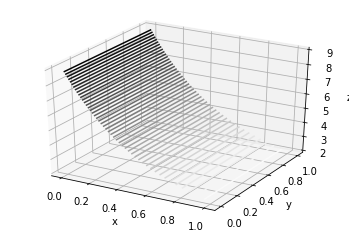

In [131]:
# Plot for D = 2.
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
Z = f74_dim([X, Y])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

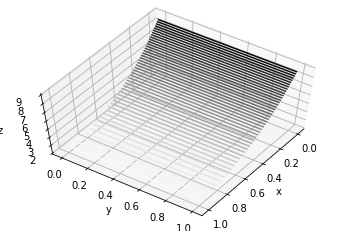

In [132]:
ax.view_init(60, 35)
fig

Κοιτάζοντας το παραπάνω γράφημα, όπως και την προτεινόμενη βιβλιογραφία, παρατηρούμε πως το ελάχιστο της συνάρτησης έχει τιμή 2. Από τη γραφική, παρατηρούμε πως η συνάστηση είναι φθίνουσα ως προς τη μεταβλητή $x_{1}$, ενώ, όπως φαινεται και από το τύπο της είναι σταθερή και ανεξάρτητη του $x_{2}$ (για διάσταση $2)$.  Γενικά για διάσταση $Ν,$ είναι ανεξάρτητη της μεταβλητής $x_{N}$.
Επίσης, είναι συνεχής.   

### Βελτιστοποίηση

Για την αρχικοποίηση του toolbox της βιβλιοθήκης deap, ορίζουμε ως άτομο του πληθυσμού (χρωμόσωμα) ένα διάνυσμα $\vec{x} \in [0, 1]^{D},$ όπου $D$ η διάσταση του χώρου(για αρχή έχουμε διάσταση 2) και ως πληθυσμό, μια λίστα από τέτοια άτομα.



In [133]:
#Initialization
toolbox = base.Toolbox()
toolbox.register( "InitialValue", np.random.uniform, 0, 1)
toolbox.register( "indiv", tools.initRepeat, creator.IndividualContainer, toolbox.InitialValue, D)
toolbox.register( "population", tools.initRepeat, list , toolbox.indiv)
#toolbox.register("map", pool.map)

Στη συνέχεια ορίζουμε την συνάρτηση καταλληλότητας, η οποία λαμβάνει τη τιμή της συνάρτησης $f_{74}$ όταν τo δοθέν διάνυσμα $\vec{x}_{input}$ είναι εντός του πεδίου ορισμού $[0, 1]^{D}$ και τιμή αρκετά μεγαλύτερη (συναρτήσει πάλι του $\vec{x}_{input}$) όταν οι μεταβλητές $\{x_{i}\}_{i=1}^{D}$ αυτές είναι εκτός του πεδίου ορισμού, έτσι ώστε τέτοια άτομα να έχουν μηδενική πιθανότητα να επιβιώσουν από την διαδικασία της φυσικής επιλογής.

In [134]:
#Fitness function
MIN_BOUND = np.array([0]*D)
MAX_BOUND = np.array([1]*D)

def eval_f74(indiv):
    sum_x = sum(indiv[:D-1])
    f = (1 + D - sum_x)**(D - sum_x)
    return (f,)

def feasible(indiv):
    if any(indiv < MIN_BOUND) or any(indiv > MAX_BOUND):
        return False
    return True

def distance(indiv):
    return ((10 + abs(sum(indiv))) * 10**D * 10**3)

# Add function to toolbox.
toolbox.register("evaluate", eval_f74)
toolbox.decorate("evaluate", tools.DeltaPenalty (feasible, 42, distance))

Ακολούθως, επιλέγουμε τις παραμέτρους του μοντέλου μας.  Με την διαδικασία που ακολουθήσαμε προηγουμένως για τη μη κλιμακούμενη συνάρτηση, βρείτε τον βέλτιστο γενετικό αλγόριθμο και τη βέλτιστη τιμή για το πρόβλημα :


Επειδή το πρόβλημα μας αλλάζει ανάλογα με τη διάσταση, ορίζουμε μία συνάρτηση ποινής (distance), η οποία είναι και συνάρτηση της διάστασης. Έτσι, σημεία που είναι infeasible ως προς την περιοχή, δέχονται μία επιβάρυνση, η οποία είναι μεγαλύτερη όσο μεγαλώνει και η διάσταση του προβλήματος.  

In [135]:
#Parameters
GOAL = 2.0 # The real minimum.
DELTA = 1e-39 # The error => |min_found - GOAL| < DELTA <=> Success.
MAX_ROUNDS = 10 # Repeat GA, MAX_ROUNDS times.
MAX_GENS = 50 # Generations.
MAX_POP = 100 # Population.
cross_prob = 0.8 # Crossover probability.
mut_prob = 0.1 # Mutation probability.
indpb_ = 0.5

#μ,λ
Mu = 50 # Number of population selected.
Lambda = 150 # Number of children born.

Ακολούθως, όπως και στο μέρος 1, επιλέγουμε συναρτήσεις για crossover και mutate. Συναρτήσεις για crossover παίρνουμε ξανά αυτές του μέρους 1. Για mutation, χρειάζεται να ξαναορίσουμε τις συναρτήσεις καθώς αλλάζει το πεδίο ορισμού της συνάρτησης πρις βελτιστοποίηση. Έτσι, έχουμε τις ακόλουθες επιλογές για mutation.

In [136]:
# Mutation.
Gaussian_value = [(0.1, 0.2), (0.15, 0.3)] #(mu, sigma)
Uniform_value = [(.5, 1), (0, 1)] #(low, up)

def GaussianLow(ind):
    return tools.mutGaussian(ind, mu = Gaussian_value[0][0], sigma = Gaussian_value[0][1], indpb = indpb_)

def GaussianHigh(ind):
    return tools.mutGaussian(ind, mu = Gaussian_value[1][0], sigma = Gaussian_value[1][1], indpb = indpb_)

# This is our mutation.
def UniformLow(indiv):
    return uniform(indiv, Uniform_value[0][0], Uniform_value[0][1])
    
def UniformHigh(indiv):
    return uniform(indiv, Uniform_value[1][0], Uniform_value[1][1])

Παρακάτω, γεννάμε τους 96 συνδυασμούς, όπως και στο μέρος 1.

In [137]:
#For Operator-Strategy optimization
cross_operators = [BlendLow, BlendHigh, SimulatedLow, SimulatedHigh]
mut_operators = [GaussianLow, GaussianHigh, UniformLow, UniformHigh]

#Selection parameters
tourn_size = [3, 10]

all_combinations = list(itertools.product(cross_operators, mut_operators, tourn_size, strategies))

In [138]:
result_table = print_results(all_names, all_combinations)

Combination :  0


TypeError: not all arguments converted during string formatting

Σχόλιο για ακρίβεια αναπαράστασης : Όπως παρατηρούμε και παρακάτω, η ακρίβεια της αναπαράστασης είναι περιορισμένη. Για παράδειγμα, στο ακόλουθο κελί, η τιμή της συνάρτησης δεν είναι 2 αλλά κάτι μεγαλύτερο. Όμως, η περιορισμένη αναπάσταση δίνει 2.0. Έτσι, οι τιμές 2.0 στον παρακάτω πίνακα δεν είναι οι "πραγματικές" τιμές του fitness αλλά τιμές της μορφής 2.0 + 1e-X, τις οποίες ο αλγόριθμος αποκόπτει. Για τον λόγο αυτό, σημεία πολύ κοντινά στο πραγματικό ελάχιστο χ*, θα έχουν τιμή συνάρτησης ίση με 2.

In [39]:
eval_f74([0.99999999999999999999999999999999999999999999999999993543022, 0.47044266820091685])

(2.0,)

In [40]:
display(result_table.sort_values(by=['avg.min']))

NameError: name 'result_table' is not defined

Αν παρατηρήσουμε τα αποτελέσματα της παραπάνω εκτέλεσης θα παρατηρήσουμε πως σε αντίθεση με αυτά του μέρους 1, η τιμή 2 (το ελάχιστο) εμφανίζεται ακριβώς πολλές φορές. Αυτό δεν οφείλεται στο ότι ο αλγόριθμος βρίσκει ακριβή λύση. Ο αλγόριθμος δεν βρίσκει ακριβή λύση διότι τα σημεία που εντοπίζει ελάχιστο δεν είναι ποτέ το $(1,0)$ αλλά σημεία (όπως ανεμέναμε) πολύ κοντά σε αυτό. Στο μέρος 1, το ελάχιστο ήταν το 0 και άρα η αναπαράσταση σε μορφή $Xe$-$Y$ ήταν βολική για αναπαράσταση της ακρίβειας. Για το σκοπό αυτό, θα μπορούσαμε να επαναλάβουμε τη διαδικασία για την συνάρτηση $f_{74} - min_{x \in [0,1]}f_{74} = f_{74} - 2$ με GOAL = $0.0$ και, ταυτόχρονα, να μετατοπίσουμε το x στο διάστημα $[-1, 0]$ ώστε το πρόβλημα να έχει ελάχιστο στο 0 στο σημείο $\vec{0}.$

 Το υπόλοιπο μέρος 2 θα το τρέξουμε με την κανονική συνάρτηση που έχει ελάχιστο 2.

Από τον προηγούμενο πίνακα, παρατηρούμε ότι ο βέλτιστος συνδυασμός τελεστών και στρατηγικών για την κλίμακούμενη συνάρτηση πλέον, είναι ο συνδυασμός BlendHigh,UniformLow,TournamentHigh,eaMuCommaLambda. 

Αυτό είναι λογικό, διότι αρχικά είναι επιθυμητή σχετικά μεγάλη δράση του γενετικού τελεστή διασταύρωσης έτσι ώστε να γίνεται καλύτερη εξερεύνεση του χώρου αναζήτησης και του χώρου κοντά στη βέλτιστη λύση. Ακόμη, όμοια με το πρώτο μέρος, η συνάρτηση προς ελαχιστοποίηση δεν έχει άλλα τοπικά ελάχιστα, έτσι, όπως αναφέρθηκε και προηγουμένως, ο τελεστής μετάλλαξης δεν είναι απαραίτητος σε μεγάλο βαθμό και για αυτό είναι προτιμότερη η μη έντονη δράση του. Επίσης η υψηλή τιμή της παραμέτρου tournsize, εξασφαλίζει ότι κατά κύριο λόγο επιβιώνουν τα καλύτερα άτομα, αφήνοντας πολύ μικρή πιθανότητα ένα αδύναμο άτομο να περάσει σε επόμενες γενεές και έτσι οδηγούμαστε σε ταχύτερη σύγκλιση στο ελάχιστο.

Από όλα που έχουν καλό σκορ, κρατήσαμε αυτό διότι έχει καλό συνδυασμό γενιών και evaluations.

In [167]:
best_combination = (BlendHigh, UniformLow, tourn_size[1], myMuCommaLambda)

#For the best
toolbox.register( "mate", best_combination[0])
toolbox.register( "mutate", best_combination[1])
toolbox.register( "select", tools.selTournament, tournsize = best_combination[2])

Έχοντας βρει λοιπόν την βέλτιστη στρατηγική, όμοια με το μέρος 1 πρέπει τώρα να εξετάσουμε τις πιθανότητες των τελεστών διασταύρωσης και μετάλλαξης, με την διαδικασία της εκτέλεσης τριών όλο και "στενότερων" gridsearch.  

In [141]:
#For the first gridsearch

# GA_gridsearch(step, cross_list, mut_list, cross_epsilon, mut_epsilon)
grid_seach_GA(8, [.6, .9], [.05, .1], 0, 0)

Combination :  0
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.86260299391498385102039492267067544162273406982421875000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.60827063186057783727989090039045549929141998291015625000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.77371566395643287528116616158513352274894714355468750000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.33241719010314596527422281724284403026103973388671875000000000000000000000000000
***********

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.59048699019827000089577495600678957998752593994140625000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.76958928668410642170982782772625796496868133544921875000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.14951415194299338962125034413475077599287033081054687500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.56617966718536560932761858566664159297943115234375000000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.58260797201428649039200990955578163266181945800781250000000000000000000000000000
***************************************************
Best x1 component: 0.99999999778208170653215347556397318840026855468750000000000000000000000000000000
Best x2 component: 0.62315385182467086799817934661405161023139953613281250000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.84044502854012048675969026589882560074329376220703125000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.80991261623184429563337971558212302625179290771484375000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.53607046145471326514808652063948102295398712158203125000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.26796186752172512779424096152069978415966033935546875000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.06368201700016595800946106464834883809089660644531250000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.82757466902336807024198606086429208517074584960937500000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.36442631177809742260009784331487026065587997436523437500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.51493776160179138834394052537390962243080139160156250000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.30442503888878752471569555382302496582269668579101562500000000000000000000000000
***************************************************
Best x1 component: 0.99997427457373599946066633492591790854930877685546875000000000000000000000000000
Best x2 component: 0.53162193587611517031632502039428800344467163085937500000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.40024090115400290379454872891074046492576599121093750000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.77494407654471164637044466871884651482105255126953125000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.27473079263379573955461410150746814906597137451171875000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.71088133772741723959143200772814452648162841796875000000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.20402204993387590414855026210716459900140762329101562500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.43688909405302478461408099974505603313446044921875000000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.69978848565987472607474728647503070533275604248046875000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.39204200759094409711735806922661140561103820800781250000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.41086401173489112137460210760764311999082565307617187500000000000000000000000000
***************************************************
Best x1 component: 0.99999999957628726843239519439521245658397674560546875000000000000000000000000000
Best x2 component: 0.51811486850370269685583934915484860539436340332031250000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.43667469427399396852962354387273080646991729736328125000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.33049998327863594482778353267349302768707275390625000000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.48634972470347626050113376550143584609031677246093750000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.49877328709099127967974141029117163270711898803710937500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.34910311920369579974376961217785719782114028930664062500000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.36459330238540044177852905704639852046966552734375000000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.26614269697316572660383826587349176406860351562500000000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.20491172474099217382104143325705081224441528320312500000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.71098486795033144503008770698215812444686889648437500000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.60265112721833924425141049141529947519302368164062500000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.72708091729042090278767318523023277521133422851562500000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.52391175457800587267342962149996310472488403320312500000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.73477995897650005829859765071887522935867309570312500000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.18560341179481801288098097302281530573964118957519531250000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.66730634611658301569292461863369680941104888916015625000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.44756549119732652597392075222160201519727706909179687500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.19986275699339439704260712460381910204887390136718750000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.40102424541358483445208094053668901324272155761718750000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.04915324075643191098494710900013160426169633865356445312500000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.04128268744686023478118741536491143051534891128540039062500000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.42361266418234261310615806905843783169984817504882812500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.60536710009990946090852048655506223440170288085937500000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.53123256329432988476213495232514105737209320068359375000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.62953467802358653582217584698810242116451263427734375000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.74139680623350512345126617219648323953151702880859375000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.22335628168534060744576663637417368590831756591796875000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.47042924782573547481945297477068379521369934082031250000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.20882906401208156665916249039582908153533935546875000000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.49520102576898245017034128068189602345228195190429687500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.74144386907585080326299475927953608334064483642578125000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.50930854288866500567678485822398215532302856445312500000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.30856265202363514221772788914677221328020095825195312500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.27326588157695930192403466207906603813171386718750000000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.61330208749347692176456803281325846910476684570312500000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.70151971362353005012835183151764795184135437011718750000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.38007349358591230314985409677319694310426712036132812500000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.81390574408161886488244363135891035199165344238281250000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.57602110420143270985704475606326013803482055664062500000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.73773532859584600718250158024602569639682769775390625000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.86023735275709001246724483280559070408344268798828125000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.90620279212532106605237913754535838961601257324218750000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.55727227458664418957567932011443190276622772216796875000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.08040872824006706220956175457104109227657318115234375000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.02645436836087863841093792416359065100550651550292968750000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.21442089876389425207037220388883724808692932128906250000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.75403108172382504736930286526330746710300445556640625000000000000000000000000000
****************************

Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.39249520451324648728785859930212609469890594482421875000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.23098693285171065237015852744661970064043998718261718750000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.89047938527403003305948914203327149152755737304687500000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.59485443898082013269856815895764157176017761230468750000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.19455255410830121776122325627511600032448768615722656250000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.60108460229378779526854259529500268399715423583984375000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.29877021960792415899987872762721963226795196533203125000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.92399723402044475761840658378787338733673095703125000000000000000000000000000000
****************************

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.96283603775458315165991507456055842339992523193359375000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.34998884856820233757446203526342287659645080566406250000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.22010948844547434388729811871598940342664718627929687500000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.57786037634400977403004162624711170792579650878906250000000000000000000000000000
****************************

Crossover probability  Mutation probability   successes   s.avg.min  \
0             $0.60000000           $0.05000000 $1.00000000 $2.00000000   
32            $0.77142857           $0.05000000 $1.00000000 $2.00000000   
33            $0.77142857           $0.05714286 $1.00000000 $2.00000000   
34            $0.77142857           $0.06428571 $1.00000000 $2.00000000   
35            $0.77142857           $0.07142857 $1.00000000 $2.00000000   
36            $0.77142857           $0.07857143 $1.00000000 $2.00000000   
37            $0.77142857           $0.08571429 $1.00000000 $2.00000000   
38            $0.77142857           $0.09285714 $1.00000000 $2.00000000   
39            $0.77142857           $0.10000000 $1.00000000 $2.00000000   
41            $0.81428571           $0.05714286 $1.00000000 $2.00000000   
43            $0.81428571           $0.07142857 $1.00000000 $2.00000000   
45            $0.81428571           $0.08571429 $1.00000000 $2.00000000   
62            $0.90000000           $0.09285714 $1.00000000 $2.00000000   
47            $0.81428571           $0.10000000 $1.00000000 $2.00000000   
50            $0.85714286           $0.06428571 $1.00000000 $2.00000000   
52            $0.85714286           $0.07857143 $1.00000000 $2.00000000   
53            $0.85714286           $0.08571429 $1.00000000 $2.00000000   
54            $0.85714286           $0.09285714 $1.00000000 $2.00000000   
55            $0.85714286           $0.10000000 $1.00000000 $2.00000000   
56            $0.90000000           $0.05000000 $1.00000000 $2.00000000   
57            $0.90000000           $0.05714286 $1.00000000 $2.00000000   
58            $0.90000000           $0.06428571 $1.00000000 $2.00000000   
59            $0.90000000           $0.07142857 $1.00000000 $2.00000000   
60            $0.90000000           $0.07857143 $1.00000000 $2.00000000   
61            $0.90000000           $0.08571429 $1.00000000 $2.00000000   
49            $0.85714286           $0.05714286 $1.00000000 $2.00000000   
28            $0.72857143           $0.07857143 $1.00000000 $2.00000000   
63            $0.90000000           $0.10000000 $1.00000000 $2.00000000   
14            $0.64285714           $0.09285714 $1.00000000 $2.00000000   
27            $0.72857143           $0.07142857 $1.00000000 $2.00000000   
23            $0.68571429           $0.10000000 $1.00000000 $2.00000000   
44            $0.81428571           $0.07857143 $0.90000000 $2.00000000   
9             $0.64285714           $0.05714286 $0.80000000 $2.00000000   
29            $0.72857143           $0.08571429 $0.90000000 $2.00000000   
25            $0.72857143           $0.05714286 $0.80000000 $2.00000000   
16            $0.68571429           $0.05000000 $0.90000000 $2.00000000   
40            $0.81428571           $0.05000000 $0.90000000 $2.00000000   
21            $0.68571429           $0.08571429 $0.90000000 $2.00000000   
4             $0.60000000           $0.07857143 $0.80000000 $2.00000000   
3             $0.60000000           $0.07142857 $0.90000000 $2.00000000   
42            $0.81428571           $0.06428571 $0.90000000 $2.00000000   
18            $0.68571429           $0.06428571 $0.90000000 $2.00000000   
11            $0.64285714           $0.07142857 $0.90000000 $2.00000000   
51            $0.85714286           $0.07142857 $0.90000000 $2.00000000   
46            $0.81428571           $0.09285714 $0.80000000 $2.00000000   
5             $0.60000000           $0.08571429 $0.80000000 $2.00000000   
24            $0.72857143           $0.05000000 $0.90000000 $2.00000000   
22            $0.68571429           $0.09285714 $0.80000000 $2.00000000   
26            $0.72857143           $0.06428571 $0.70000000 $2.00000000   
15            $0.64285714           $0.10000000 $0.90000000 $2.00000000   
19            $0.68571429           $0.07142857 $0.90000000 $2.00000000   
10            $0.64285714           $0.06428571 $0.90000000 $2.00000000   
6             $0.60000000    

In [142]:
# pd.options.display.float_format = '{:,.4f}'.format

In [43]:
best_cross_round1 = .9
best_mut_round1 = .05 # explain

In [44]:
#For the second gridsearch
grid_seach_GA(8, [.9, .9], [.05, .05], .025, .025)

Combination :  0
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.81580881601964483351707713154610246419906616210937500000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.76988667640281904791521583319990895688533782958984375000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.82559476312770851968991792091401293873786926269531250000000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.53684787038486248000879186292877420783042907714843750000000000000000000000000000
***********

KeyboardInterrupt: 

In [ ]:
#For the third gridsearch
# step = 8
# cross_lower_limit, cross_upper_limit = 0.05, 0.9
# mut_lower_limit, mut_upper_limit = 0.05, 0.9

# GA_gridsearch(step, cross_lower_limit, cross_upper_limit, mut_lower_limit, mut_upper_limit)

In [165]:
best_probs = [0.9, 0.05]

Σειρά πλέον έχει η τελική και βελτιστοποιημένη εκτέλεση του αλγορίθμου, με ορισμό σχετικά μεγάλων παραμέτρων, έτσι ώστε να πετύχουμε την μέγιστη δυνατή ακρίβεια για τη λύση.

In [144]:
#Final run parameters
GOAL = 2.0
DELTA = 1e-30
MAX_ROUNDS = 1
MAX_GENS = 600
MAX_POP = 1000

#μ,λ
Mu = 500
Lambda = 800

In [145]:
#Final run
res_final = evaluate_GA(best_combination[3], best_probs[0], best_probs[1], MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, DELTA)
pd.DataFrame({'Generation': [res_final[3]], 'Fitness function evaluations': [res_final[4]], 'Minimum Fitness': [res_final[5]], 'Time elapsed': [res_final[6]]})

Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.62360883570660363695026262575993314385414123535156250000000000000000000000000000
***************************************************


Generation  Fitness function evaluations  Minimum Fitness  Time elapsed
0     20.0000                  457,112.0000           2.0000       24.8028

Έτσι, έχοντας βρει τόσο το βέλτιστο συνδυασμό επιλογής αλγορίθμων και πιθανοτήτων, συνεχίζουμε με την τροποποίηση της διάστασης του προβλήματος. Αξίζει να αναφέρουμε ξανά, πως η τιμή της συντεταγμένης $x_{1}$ δεν είναι επακριβώς 1 αλλά κάτι ελάχιστα μικρότερο (της μορφής 1 + Χe-Υ), το οποίο για λόγους format printing δεν τυπώνεται επακριβώς.

### Για D=1, 10, 20, 40 και μεγαλύτερες διαστάσεις

Αρχικά, παρατηρούμε πως για $D = 1, $ στο συγκεκριμένο πρόβλημα, η συνάρτηση ανάγεται σε μία σταθερά. Συγκεκριμένα, $f_{74}(x ; \mathcal{D}=1) = 2.$ Έτσι, δεν έχει νόημα η περίπτωση αυτή να συμπεριληφθεί στην παρακάτω ανάλυση.

Για τον βέλτιστο αλγόριθμο (που βρήκατε για τις 2 διαστάσεις) και για διαφορετικές τιμές/τάξεις μεγέθους D=1, 10, 20, 40 ή και περισσότερων διαστάσεων του πεδίου ορισμού (σταθερά MAX_GENS και MAX_ROUNDS>=10) τυπώστε πίνακα με: **αριθμό διαστάσεων**, **αριθμό επιτυχιών**, **μέσο ολικό ελάχιστο**, **μέσο αριθμό αποτιμήσεων** και **μέσο χρόνο** (προφανώς βασιστείτε στην αρχική βοηθητική συνάρτηση εκτύπωσης αποτελεσμάτων). 

Σημειώστε ότι οποιεσδήποτε ποινές για άτομα εκτός ορισμού καθώς και τo DELTA, προκειμένου να είναι αποτελεσματικά ως προς την κλιμάκωση των διαστάσεων, θα πρέπει να οριστούν εμπειρικά μεν, αλλά οπωσδήποτε συναρτήσει του πλήθους των διαστάσεων (μεγαλύτερες ποινές για μεγαλύτερες διαστάσεις, για το DELTA έχουν δοθεί οδηγίες σε προηγούμενο section).

α) Σχολιάστε τα αποτελέσματα του πίνακα.

β) Ποιες πιστεύετε είναι οι αιτίες του φαινομένου;

γ) Για σταθερό αριθμό γενεών, πώς μπορούμε να βελτιώσουμε τα αποτελέσματα σε μεγάλες διαστάσεις ως προς το σκέλος της μέσης βέλτιστης τιμής; (Mπορεί να υπάρχουν περισσότερες προσεγγίσεις στο ίδιο πρόβλημα.)

In [171]:
#Parameters
GOAL = 2.0
MAX_ROUNDS = 10
MAX_GENS = 100
MAX_POP = 250

#μ,λ
Mu = 100
Lambda = 200

Το παρακάτω μπλοκ κώδικα τυπώνει τον ζητούμενο πίνακα αποτελεσμάτων, για μια λίστα διαστάσεων της συνάρτησης προς βελτιστοποίηση. Ο κώδικας αυτός, για κάθε διάσταση προς εξέταση επαναδιατυπώνει τον ορισμό του ατόμου και του πληθυσμού μέσω του ορισμού ενός νέου `toolbox` ορίζει ένα διαφορετικό DELTA και τέλος τρέχει τον αλγόριθμο με τα βέλτιστα χαρακτηριστικά που έχουν προσδιοριστεί προηγουμένως.

Να σημειωθεί ότι το DELTA ορίζεται με βάση την εκάστοτε διάσταση που εξετάζεται ως $DELTA = 10^{-2+D/4}$ έτσι ώστε να λαμβάνεται υπόψη ότι για μεγαλύερη διάσταση, ο αλγόριθμος θα δυσκολεύεται όλο και περισσότερο να βρει το ελάχιστο.

In [172]:
#Initialize toolbox for new dimention
def Initialize_Toolbox():
    toolbox = base.Toolbox()
    toolbox.register( "InitialValue", np.random.uniform, 0, 1)
    toolbox.register( "indiv", tools.initRepeat, creator.IndividualContainer, toolbox.InitialValue, D)
    toolbox.register( "population", tools.initRepeat, list , toolbox.indiv)

    toolbox.register( "mate", best_combination[0])
    toolbox.register( "mutate", best_combination[1])
    toolbox.register( "select", tools.selTournament, tournsize = best_combination[2])
    
    toolbox.register( "evaluate", eval_f74)
    toolbox.decorate("evaluate", tools.DeltaPenalty (feasible, 42, distance))
    
    return toolbox

In [176]:
D_list = [2, 10, 15, 20, 40, 50]
res = np.empty([len(D_list), 7])

for i, D in enumerate(D_list):
    #Initialization
    DELTA = 1e-2 * 10**(D/4) #Takes D into consideration
    
    print(colored("Dimension : ", 'red'), D)
    print(colored("Delta : ", 'green'), DELTA) 
    
    #For fitness function
    MIN_BOUND = np.array([0]*D)
    MAX_BOUND = np.array([1]*D)
    toolbox = Initialize_Toolbox()
    
    #Running the algorithm
    res[i,:] = evaluate_GA(best_combination[3], best_probs[0], best_probs[1], MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, DELTA)

Dimension :  2
Delta :  1.0
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.27536863677606249201090804490377195179462432861328125000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.34301364578944731897891529115440789610147476196289062500000000000000000000000000
***************************************************
Best x1 component: 0.99999999999999988897769753748434595763683319091796875000000000000000000000000000
Best x2 component: 0.33809675928298732472399024118203669786453247070312500000000000000000000000000000
***************************************************
Best x1 component: 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000
Best x2 component: 0.27557160918962020357270148451789282262325286865234375000000000000000000000000000


Best x1 component: 0.99999998061385086955965562083292752504348754882812500000000000000000000000000000
Best x2 component: 0.99999996352462749982237255608197301626205444335937500000000000000000000000000000
Best x3 component: 0.99999988543626694426080803168588317930698394775390625000000000000000000000000000
Best x4 component: 0.99999960208227156588378647938952781260013580322265625000000000000000000000000000
Best x5 component: 0.99999980995346637868692596384789794683456420898437500000000000000000000000000000
Best x6 component: 0.99999976578010896233195126114878803491592407226562500000000000000000000000000000
Best x7 component: 0.99999980484643558042989752721041440963745117187500000000000000000000000000000000
Best x8 component: 0.99999987758640473956006644584704190492630004882812500000000000000000000000000000
Best x9 component: 0.99999982596079250996012888208497315645217895507812500000000000000000000000000000
Best x10 component: 0.716719571166413937923778121330542489886283874511718750000000

Best x1 component: 0.99983342159231880508230005943914875388145446777343750000000000000000000000000000
Best x2 component: 0.99954235586077477826449921849416568875312805175781250000000000000000000000000000
Best x3 component: 0.99994218670526269221454640501178801059722900390625000000000000000000000000000000
Best x4 component: 0.99993604697683502458005477819824591279029846191406250000000000000000000000000000
Best x5 component: 0.99992631946762222661106989107793197035789489746093750000000000000000000000000000
Best x6 component: 0.99989399998995454055261689063627272844314575195312500000000000000000000000000000
Best x7 component: 0.99991148610248115069509822205873206257820129394531250000000000000000000000000000
Best x8 component: 0.99994614917312951707373258614097721874713897705078125000000000000000000000000000
Best x9 component: 0.99994322622292508562225066270912066102027893066406250000000000000000000000000000
Best x10 component: 0.999900932213381166135945932182949036359786987304687500000000

Best x1 component: 0.99993486522736585442316936678253114223480224609375000000000000000000000000000000
Best x2 component: 0.99996025359337981086582658463157713413238525390625000000000000000000000000000000
Best x3 component: 0.99989595325235935963092970268917270004749298095703125000000000000000000000000000
Best x4 component: 0.99994682487281250082844508142443373799324035644531250000000000000000000000000000
Best x5 component: 0.99966094076170031179628949757898226380348205566406250000000000000000000000000000
Best x6 component: 0.99960627056175421767392208494129590690135955810546875000000000000000000000000000
Best x7 component: 0.99990141012282629517926579865161329507827758789062500000000000000000000000000000
Best x8 component: 0.99982912543343727129752096516313031315803527832031250000000000000000000000000000
Best x9 component: 0.99988671177177523841095307943760417401790618896484375000000000000000000000000000
Best x10 component: 0.999746537122678247122564698656788095831871032714843750000000

Best x1 component: 0.91119178395654387703217480520834214985370635986328125000000000000000000000000000
Best x2 component: 0.73966641419779344257534603457315824925899505615234375000000000000000000000000000
Best x3 component: 0.88952174946404560795798488470609299838542938232421875000000000000000000000000000
Best x4 component: 0.96526776124869140272011236447724513709545135498046875000000000000000000000000000
Best x5 component: 0.66568758955759943507501930071157403290271759033203125000000000000000000000000000
Best x6 component: 0.94673419169101857839621061430079862475395202636718750000000000000000000000000000
Best x7 component: 0.18719893613717131231055645912420004606246948242187500000000000000000000000000000
Best x8 component: 0.84253007646371547156860515315202064812183380126953125000000000000000000000000000
Best x9 component: 0.86723578888371832817938411608338356018066406250000000000000000000000000000000000
Best x10 component: 0.984076552569629114941562875173985958099365234375000000000000

Best x1 component: 0.69419164003112776573090059173409827053546905517578125000000000000000000000000000
Best x2 component: 0.65766194934035515640147195881581865251064300537109375000000000000000000000000000
Best x3 component: 0.71592300486219273558674558444181457161903381347656250000000000000000000000000000
Best x4 component: 0.77214736872010525381426759850000962615013122558593750000000000000000000000000000
Best x5 component: 0.69254318769944112066383468118146993219852447509765625000000000000000000000000000
Best x6 component: 0.01235518622060405302676144856377504765987396240234375000000000000000000000000000
Best x7 component: 0.91906278055501244850233888428192585706710815429687500000000000000000000000000000
Best x8 component: 0.82086376644231284771535683830734342336654663085937500000000000000000000000000000
Best x9 component: 0.30527231168213897483099117380334064364433288574218750000000000000000000000000000
Best x10 component: 0.767975138777348020902024927636375650763511657714843750000000

Best x1 component: 0.48881928807696661820614281168673187494277954101562500000000000000000000000000000
Best x2 component: 0.49450835163011186423887011187616735696792602539062500000000000000000000000000000
Best x3 component: 0.60456864176860392046108927388559095561504364013671875000000000000000000000000000
Best x4 component: 0.16049422491334386364769670763052999973297119140625000000000000000000000000000000
Best x5 component: 0.49598647848266941284833819736377336084842681884765625000000000000000000000000000
Best x6 component: 0.90279601779684448548124464650754816830158233642578125000000000000000000000000000
Best x7 component: 0.95178084335860058118328197451774030923843383789062500000000000000000000000000000
Best x8 component: 0.98757390864627425663968551816651597619056701660156250000000000000000000000000000
Best x9 component: 0.22462898468105041427378409935045056045055389404296875000000000000000000000000000
Best x10 component: 0.218790510850138675280618372198659926652908325195312500000000

Best x1 component: 0.88493209111505588548851619634660892188549041748046875000000000000000000000000000
Best x2 component: 0.35172655671676011923665328140486963093280792236328125000000000000000000000000000
Best x3 component: 0.80755067239029254544391278614057227969169616699218750000000000000000000000000000
Best x4 component: 0.61625585229981227897155804384965449571609497070312500000000000000000000000000000
Best x5 component: 0.59448778244555611216526358475675806403160095214843750000000000000000000000000000
Best x6 component: 0.29266581498980026587730662868125364184379577636718750000000000000000000000000000
Best x7 component: 0.75771046427624966224101399348000995814800262451171875000000000000000000000000000
Best x8 component: 0.76701490105402736485729064952465705573558807373046875000000000000000000000000000
Best x9 component: 0.79008613559533358294828531143139116466045379638671875000000000000000000000000000
Best x10 component: 0.630267433888498151972612504323478788137435913085937500000000

Best x1 component: 0.19278248459118918489707539265509694814682006835937500000000000000000000000000000
Best x2 component: 0.56798899932765700704351274907821789383888244628906250000000000000000000000000000
Best x3 component: 0.93819169173192362709556846311897970736026763916015625000000000000000000000000000
Best x4 component: 0.91968480960107223953770017033093608915805816650390625000000000000000000000000000
Best x5 component: 0.31282809456699889327779828818165697157382965087890625000000000000000000000000000
Best x6 component: 0.27434230127636216600706120516406372189521789550781250000000000000000000000000000
Best x7 component: 0.83369342374189170374876312052947469055652618408203125000000000000000000000000000
Best x8 component: 0.79000582262776375408463991334429010748863220214843750000000000000000000000000000
Best x9 component: 0.49387462904103152094847928310628049075603485107421875000000000000000000000000000
Best x10 component: 0.609487477117353737554594772518612444400787353515625000000000

Best x1 component: 0.32019510908240145230507778251194395124912261962890625000000000000000000000000000
Best x2 component: 0.53404239156393484844187469207099638879299163818359375000000000000000000000000000
Best x3 component: 0.66632500293602348051535955164581537246704101562500000000000000000000000000000000
Best x4 component: 0.65284911141613399809813245155964978039264678955078125000000000000000000000000000
Best x5 component: 0.70403940255250829771682674618205055594444274902343750000000000000000000000000000
Best x6 component: 0.87981601366470618685866611485835164785385131835937500000000000000000000000000000
Best x7 component: 0.63519076569427745937446161406114697456359863281250000000000000000000000000000000
Best x8 component: 0.47023047720524457915303173649590462446212768554687500000000000000000000000000000
Best x9 component: 0.84445456276073449508601242996519431471824645996093750000000000000000000000000000
Best x10 component: 0.723391459212911813736468502611387521028518676757812500000000

Best x1 component: 0.44659655746005111343066573681426234543323516845703125000000000000000000000000000
Best x2 component: 0.56165491535738576445169201178941875696182250976562500000000000000000000000000000
Best x3 component: 0.60740635184015012715263992504333145916461944580078125000000000000000000000000000
Best x4 component: 0.71659293363241116647799344718805514276027679443359375000000000000000000000000000
Best x5 component: 0.79902950657200877415675677184481173753738403320312500000000000000000000000000000
Best x6 component: 0.35279675669170562635201804368989542126655578613281250000000000000000000000000000
Best x7 component: 0.70178231258341516873855425728834234178066253662109375000000000000000000000000000
Best x8 component: 0.91494769852281887523304249043576419353485107421875000000000000000000000000000000
Best x9 component: 0.01500015077514504913125392704387195408344268798828125000000000000000000000000000
Best x10 component: 0.370627614825936424480801179015543311834335327148437500000000

Best x1 component: 0.89689737120941970260901143774390220642089843750000000000000000000000000000000000
Best x2 component: 0.48458392972706654244774426842923276126384735107421875000000000000000000000000000
Best x3 component: 0.67032981757156884228265880665276199579238891601562500000000000000000000000000000
Best x4 component: 0.36930932873516886250087054577306844294071197509765625000000000000000000000000000
Best x5 component: 0.28639991120525754020320619019912555813789367675781250000000000000000000000000000
Best x6 component: 0.98749513253808296475710903905564919114112854003906250000000000000000000000000000
Best x7 component: 0.57069190566448801948951086160377599298954010009765625000000000000000000000000000
Best x8 component: 0.69328994455690939879843881499255076050758361816406250000000000000000000000000000
Best x9 component: 0.84367663881846310935941346542676910758018493652343750000000000000000000000000000
Best x10 component: 0.496788483151233695167547921300865709781646728515625000000000

Best x1 component: 0.29914332667542142818462025388726033270359039306640625000000000000000000000000000
Best x2 component: 0.05227710096492377278565300002810545265674591064453125000000000000000000000000000
Best x3 component: 0.42703108786519872186460133889340795576572418212890625000000000000000000000000000
Best x4 component: 0.23558842113246458715991593635408207774162292480468750000000000000000000000000000
Best x5 component: 0.51289541802686011706668978149536997079849243164062500000000000000000000000000000
Best x6 component: 0.10938326547877152972176872935961000621318817138671875000000000000000000000000000
Best x7 component: 0.02578792069114044238631322514265775680541992187500000000000000000000000000000000
Best x8 component: 0.96843945782761420293383025637012906372547149658203125000000000000000000000000000
Best x9 component: 0.76340281892804151553377778327558189630508422851562500000000000000000000000000000
Best x10 component: 0.704725899444048620168246088724117726087570190429687500000000

Best x1 component: 0.44875551976851690838543618156109005212783813476562500000000000000000000000000000
Best x2 component: 0.19723425959723039913029651870601810514926910400390625000000000000000000000000000
Best x3 component: 0.32016463539201100996223203765111975371837615966796875000000000000000000000000000
Best x4 component: 0.64931896193094396085854214106802828609943389892578125000000000000000000000000000
Best x5 component: 0.76793967224133474758218653732910752296447753906250000000000000000000000000000000
Best x6 component: 0.85694305485867727778526159454486332833766937255859375000000000000000000000000000
Best x7 component: 0.96995330466611506814444965129951015114784240722656250000000000000000000000000000
Best x8 component: 0.71466477166858133340809899891610257327556610107421875000000000000000000000000000
Best x9 component: 0.85040147202720561825373124520410783588886260986328125000000000000000000000000000
Best x10 component: 0.986538680777085619233446323050884529948234558105468750000000

Best x1 component: 0.08730827209152081103127329697599634528160095214843750000000000000000000000000000
Best x2 component: 0.39236731225113219423406007990706712007522583007812500000000000000000000000000000
Best x3 component: 0.99366833966969991820405994076281785964965820312500000000000000000000000000000000
Best x4 component: 0.43476419929517118312389811762841418385505676269531250000000000000000000000000000
Best x5 component: 0.13094626762644678841240875044604763388633728027343750000000000000000000000000000
Best x6 component: 0.95285985218164281906894075291347689926624298095703125000000000000000000000000000
Best x7 component: 0.79470305670505847484008654646459035575389862060546875000000000000000000000000000
Best x8 component: 0.91767620567687191446282213291851803660392761230468750000000000000000000000000000
Best x9 component: 0.72810449786634989788325356130371801555156707763671875000000000000000000000000000
Best x10 component: 0.295233875658998168312052712281001731753349304199218750000000

Best x1 component: 0.62427231016305906319274754423531703650951385498046875000000000000000000000000000
Best x2 component: 0.63450266323659065825779634906211867928504943847656250000000000000000000000000000
Best x3 component: 0.90715889590579423806815384523360989987850189208984375000000000000000000000000000
Best x4 component: 0.78184566367611940673754133968031965196132659912109375000000000000000000000000000
Best x5 component: 0.91697873570966004219684464260353706777095794677734375000000000000000000000000000
Best x6 component: 0.20673601182123058084272315682028420269489288330078125000000000000000000000000000
Best x7 component: 0.34430485922793419018006488840910606086254119873046875000000000000000000000000000
Best x8 component: 0.55276840512463132348841554630780592560768127441406250000000000000000000000000000
Best x9 component: 0.02279501631947511430809072408010251820087432861328125000000000000000000000000000
Best x10 component: 0.250695909677481565402956675825407728552818298339843750000000

In [177]:
pd.DataFrame({'Dimentions': (D_list), 'Successes': res[:,0], 'Avg Fitness function evaluations': res[:,4], 'Avg Minimum Fitness': res[:,5], 'Avg Time elapsed': res[:,6]}, \
             columns = ['Dimentions', 'Successes', 'Avg Minimum Fitness', 'Avg Fitness function evaluations', 'Avg Time elapsed'])

Dimentions  Successes                        Avg Minimum Fitness  \
0           2     1.0000                                     2.0000   
1          10     1.0000                                     2.0000   
2          15     1.0000                                     2.1079   
3          20     1.0000                             1,068,219.2355   
4          40     1.0000           253,631,138,338,555,658,240.0000   
5          50     1.0000 3,759,528,360,153,820,587,454,627,840.0000   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       19,242.5000            0.9780  
1                       19,251.5000            1.2263  
2                       19,229.8000            1.3680  
3                       19,271.9000            1.4672  
4                       19,262.0000            1.9555  
5                       19,250.7000            2.2127

#### Σχόλια

**Α)** Από τον παραπάνω πίνακα παρατηρούμε ότι με την αύξηση των διαστάσεων έχουμε δραστική μείωση της ακρίβειας ή ακόμα και πλήρη αποτυχία εύρεσης λύσης, αύξησης του χρόνου εκτέλεσης ενώ σχετικά σταθερός παραμένει ο αριθμός αποτιμήσεων της συνάρτησης καταλληλότητας

**Β)** 

- Το γεγονός ότι ο αριθμός αποτιμήσεων της συνάρτησης καταλληλότητας φαίνεται να είναι ανεξάρτητος από τον αριθμό διαστάσεων του προβλήματος, οφείλεται στο ότι οι συνολικές αποτιμήσεις που θα γίνουν εξαρτώνται καθαρά από παραμέτρους όπως το πλήθος του πληθυσμού (ή τα μ,λ) (και όχι από τη μορφή του κάθε ατόμου), αφού για μεγαλύτερο πλήθος θα πρέπει να αξιολογηθούν κάθε φορά περισσότερα άτομα για τη διαδικασία της επιλογής και όπως ο αριθμός των γενεών, εφόσος ο αριθμός αυτός υποδυκνείει τις φορές που θα συνεχιστεί η διαδικασία της εξέλιξης.

- Η άυξηση του χρόνου εκτέλεσης συναρτήσει του D είναι σχετικά προφανής. Ναι μεν ο συνολικός αριθμός αποτιμήσεων της συνάρτησης καταλληλότητας παραμένει σταθερός, αλλά η αποτίμηση της είναι αρκετά πιο βαριά υπολογιστικά από ότι προηγουμένως, εφόσον πρέπει να ληφθούν υπόψη περισσότεροι αριθμοί για τον υπολογισμό της. Αναμένουμε όμοια, η εφαρμογή των τελεστών διασταύρωσης και μετάλλαξης επίσης να απαιτούν περισσότερους υπολογιστικούς πόρους, αφού τα άτομα σε μεγαλύτερη διάσταση προσθέτουν επιπλέον πράξεις στην εφαρμογή των τελεστών αυτών.

- Η πιο σημαντική παρατήρηση αφορά τη σταδιακή μέιωση της ακρίβειας στην εύρεση του επιθυμητού ελαχίστου. Η συμπεριφορά αυτή είναι αναμενόμενη, επειδή για σταθερό αριθμό πληθυσμού και γενεών, οι μεγαλύτερες διαστάσεις αυξάνουν εκθετικά τον χώρο στον οποίο αναζητείται η βέλτιστη λύση, κάνοντας την περιοχή "κοντά" στη λύση να φαίνεται όλο πιο μικρή και δυσεύρετη, μπροστά στο πλέον αυξημένο χώρο αναζήτησης. Το γεγονός αυτό μπορεί να παρομοιωθεί με ένα μονοδιάστατο πρόβλημα, στο οποίο αρχικά η λύση αναζητείται στο διάστημα (-1,1) και στη συνέχεια η ίδια λύση αναζητείται στο διάστημα (-10000,10000) στο οποίο είναι λογικό κάθε αλγόριθμος βελτιστοποίησης να δυσκολευτεί να βρει με ακρίβεια τη λύση. 

**Γ)** Με βάση και τις προηγούμενες παρατηρήσεις και έχοντας σταθερό αριθμό γενεών, η πιο σημαντική παράμετρος που μπορεί να βελτιώσει την μέση βέλτιστη τιμή κατά την εκτέλεση του αλγορίθμου είναι το μέγεθος του πληθυσμού. Είναι λογικό ότι χρήση περισσότερων ατόμων στον συνολικό πληθυσμό "γεμίζει" περισσότερο τον χώρο αναζήτησης λύσης με άτομα, με αποτέλεσμα να αυξάνει την πιθανότητα να βρεθεί κάποιο ή περισσότερα άτομα κοντά στη γειτονιά της λύσης. Με την ίδια λογική, βελτίωση στην εύρεση λύσης έχουμε με την αντίστοιχη αύξηση των παραμέτρων μ,λ στη περίπτωση που εφαρμόζεται μια από τις στρατηγικές (μ+λ) και (μ,λ).

### Βελτιστοποίηση σε μεγάλες διαστάσεις

Με βάση τις απαντήσεις μας στο πρηγούμενο ερώτημα (β) και με σταθερό αριθμό γενεών, εφαρμόζουμε τις αλλαγές που χρειάζονται σύμφωνα με την απάντησή (γ) με τους εξής δύο στόχους:

- Κρατώντας σταθερή και μεγάλη τη διάσταση εισόδου να παίρνετε όλο και καλύτερες βέλτιστες τιμές της συνάρτησης. Παρουσιάστε τα αποτελέσματα σε συγκριτικό πίνακα παρόμοιο με τον προηγούμενο.

- Βρείτε μια νέα -σταθερή- διάσταση, πιθανότατα μικρότερη από την προηγούμενη και ένα DELTA που να σας δίνουν 35% - 50% επιτυχίες. Μπορείτε να μειώσετε το DELTA στο μισό και να διπλασιάσετε το ποσοστό των επιτυχιών; Μπορείτε να ξαναμειώσετε στο μισό το DELTA και να αυξήσετε επιπρόσθετα το ποσοστό των επιτυχιών; Αν όχι, κατα πόσο κατ'ελάχιστον πρέπει να αυξήσετε τον αριθμό των γενεών για να πετύχετε σημαντική αύξηση των επιτυχιών;


In [179]:
#Largest Dimention
D = D_list[-1] #50

print(colored("Dimension = ", 'red'), D)

#For fitness function
MIN_BOUND = np.array([0]*D)
MAX_BOUND = np.array([1]*D)
toolbox = Initialize_Toolbox()

pop_list = [200, 600, 1000, 5000, 15000]
mu_list = [50, 150, 250, 1000, 3000]
lam_list = [150, 450, 750, 3000, 9000]

DELTA = 1e-2 *  10**(D/4)
res = np.empty([len(pop_list), 7])

for i, MAX_POP in enumerate(pop_list):
    Mu, Lambda = mu_list[i], lam_list[i]
    print("Maximum Population : ", MAX_POP, " Mu : ", Mu, " Lambda : ", Lambda)
    res[i,:] = evaluate_GA(best_combination[3], best_probs[0], best_probs[1], MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, DELTA)

Dimension =  50
Maximum Population :  200 Mu :  50 Lambda :  150
Best x1 component: 0.21701216026577718753998169631813652813434600830078125000000000000000000000000000
Best x2 component: 0.11366657304902916258981804276118054986000061035156250000000000000000000000000000
Best x3 component: 0.65242275592644516368778795367688871920108795166015625000000000000000000000000000
Best x4 component: 0.94199031369361840848597466901992447674274444580078125000000000000000000000000000
Best x5 component: 0.96794096843223231818598151221522130072116851806640625000000000000000000000000000
Best x6 component: 0.65077858573130364927550317588611505925655364990234375000000000000000000000000000
Best x7 component: 0.41935428778491179446774594907765276730060577392578125000000000000000000000000000
Best x8 component: 0.75300425899821277209156278331647627055644989013671875000000000000000000000000000
Best x9 component: 0.87426098486240011453674014774151146411895751953125000000000000000000000000000000
Best x10 componen

Best x1 component: 0.54952933014740845685253134433878585696220397949218750000000000000000000000000000
Best x2 component: 0.61776720288581432605212739872513338923454284667968750000000000000000000000000000
Best x3 component: 0.65083530013991475193790847697528079152107238769531250000000000000000000000000000
Best x4 component: 0.62262696988551158305824628769187256693840026855468750000000000000000000000000000
Best x5 component: 0.56295907085521157409147008365835063159465789794921875000000000000000000000000000
Best x6 component: 0.69255731793034980281476009622565470635890960693359375000000000000000000000000000
Best x7 component: 0.36073120535903002714661624850123189389705657958984375000000000000000000000000000
Best x8 component: 0.85778293057499277463051612357958219945430755615234375000000000000000000000000000
Best x9 component: 0.26121187953735036657576529250945895910263061523437500000000000000000000000000000
Best x10 component: 0.533620527327350102630987294105580076575279235839843750000000

Best x1 component: 0.03209965866437647363795804267283529043197631835937500000000000000000000000000000
Best x2 component: 0.91742733491202677065246007259702309966087341308593750000000000000000000000000000
Best x3 component: 0.55851663947119778441674498026259243488311767578125000000000000000000000000000000
Best x4 component: 0.87759118004506375676498919347068294882774353027343750000000000000000000000000000
Best x5 component: 0.97043720623908003020119394932407885789871215820312500000000000000000000000000000
Best x6 component: 0.51199010967600744326233552783378399908542633056640625000000000000000000000000000
Best x7 component: 0.59233751349905650052107830560998991131782531738281250000000000000000000000000000
Best x8 component: 0.68125823839616816979258828723686747252941131591796875000000000000000000000000000
Best x9 component: 0.81596473614335796042951187700964510440826416015625000000000000000000000000000000
Best x10 component: 0.004951671975398364011766716430429369211196899414062500000000

Best x1 component: 0.22498612957974661874516186799155548214912414550781250000000000000000000000000000
Best x2 component: 0.06416746916377769061057279031956568360328674316406250000000000000000000000000000
Best x3 component: 0.64899370015355573038107195316115394234657287597656250000000000000000000000000000
Best x4 component: 0.47288544140414257022086985671194270253181457519531250000000000000000000000000000
Best x5 component: 0.67644394737900037650746298822923563420772552490234375000000000000000000000000000
Best x6 component: 0.85542318197395916801184512223699130117893218994140625000000000000000000000000000
Best x7 component: 0.59934152097215387389184115818352438509464263916015625000000000000000000000000000
Best x8 component: 0.40076646571758767212401153301470912992954254150390625000000000000000000000000000
Best x9 component: 0.74445830489738806790001035551540553569793701171875000000000000000000000000000000
Best x10 component: 0.881733600906978165490102128387661650776863098144531250000000

Best x1 component: 0.92359954720140569062181157278246246278285980224609375000000000000000000000000000
Best x2 component: 0.04806875539004551445287916067172773182392120361328125000000000000000000000000000
Best x3 component: 0.55395952099598955165049574134172871708869934082031250000000000000000000000000000
Best x4 component: 0.74519094849136990887927822768688201904296875000000000000000000000000000000000000
Best x5 component: 0.44773307203273093879403177197673358023166656494140625000000000000000000000000000
Best x6 component: 0.53770872657147150697198867419501766562461853027343750000000000000000000000000000
Best x7 component: 0.85738291117011777853207377120270393788814544677734375000000000000000000000000000
Best x8 component: 0.05831055704847232235010778822470456361770629882812500000000000000000000000000000
Best x9 component: 0.87339086248438002613170283439103513956069946289062500000000000000000000000000000
Best x10 component: 0.573342806207189359390952176909195259213447570800781250000000

Best x1 component: 0.85952946056207479852417918664286844432353973388671875000000000000000000000000000
Best x2 component: 0.88131396903159853195575124118477106094360351562500000000000000000000000000000000
Best x3 component: 0.68120958816421461889945021539460867643356323242187500000000000000000000000000000
Best x4 component: 0.77836780452642750915970282221678644418716430664062500000000000000000000000000000
Best x5 component: 0.25803068090915315391242756959400139749050140380859375000000000000000000000000000
Best x6 component: 0.89428524333797876355589551167213357985019683837890625000000000000000000000000000
Best x7 component: 0.87709105989823266114058242237661033868789672851562500000000000000000000000000000
Best x8 component: 0.65837562637968150003331402331241406500339508056640625000000000000000000000000000
Best x9 component: 0.55507043760013097255523462081328034400939941406250000000000000000000000000000000
Best x10 component: 0.580290272111796512355397226201603189110755920410156250000000

Best x1 component: 0.00289566836301580199375393931404687464237213134765625000000000000000000000000000
Best x2 component: 0.96775572692497890958662765115150250494480133056640625000000000000000000000000000
Best x3 component: 0.36486020943309005470922556924051605165004730224609375000000000000000000000000000
Best x4 component: 0.82738684373792192872087980504147708415985107421875000000000000000000000000000000
Best x5 component: 0.87237144220087448065470425717649050056934356689453125000000000000000000000000000
Best x6 component: 0.50015071191882332080069772928254678845405578613281250000000000000000000000000000
Best x7 component: 0.58236223848090007404465495710610412061214447021484375000000000000000000000000000
Best x8 component: 0.19141360853422395571499237121315672993659973144531250000000000000000000000000000
Best x9 component: 0.95290705225532368327634458182728849351406097412109375000000000000000000000000000
Best x10 component: 0.941772400915897867079706884396728128194808959960937500000000

Best x1 component: 0.78962004031010979421267848010757006704807281494140625000000000000000000000000000
Best x2 component: 0.05984860031597460938712629285873845219612121582031250000000000000000000000000000
Best x3 component: 0.39020577277947476879660371196223422884941101074218750000000000000000000000000000
Best x4 component: 0.72814822920482891177584860997740179300308227539062500000000000000000000000000000
Best x5 component: 0.07912753657580562371975929636391811072826385498046875000000000000000000000000000
Best x6 component: 0.60318985913412281885115362456417642533779144287109375000000000000000000000000000
Best x7 component: 0.88550388265556467803918394565698690712451934814453125000000000000000000000000000
Best x8 component: 0.91641020175927434543439176195533946156501770019531250000000000000000000000000000
Best x9 component: 0.81081972771417198941890092100948095321655273437500000000000000000000000000000000
Best x10 component: 0.714135769301728728919442801270633935928344726562500000000000

Best x1 component: 0.43426474362728850753256892858189530670642852783203125000000000000000000000000000
Best x2 component: 0.21560305268105006692991310046636499464511871337890625000000000000000000000000000
Best x3 component: 0.55328189338988231771310211115633137524127960205078125000000000000000000000000000
Best x4 component: 0.96749190030102139026269014721037819981575012207031250000000000000000000000000000
Best x5 component: 0.55193839051122928207604445560718886554241180419921875000000000000000000000000000
Best x6 component: 0.82488291238329702892428940685931593179702758789062500000000000000000000000000000
Best x7 component: 0.51146625803391154718724465055856853723526000976562500000000000000000000000000000
Best x8 component: 0.91014974481139176987198879942297935485839843750000000000000000000000000000000000
Best x9 component: 0.89525831054612436954442955538979731500148773193359375000000000000000000000000000
Best x10 component: 0.921335217971354980548426283348817378282546997070312500000000

Best x1 component: 0.75393570339754290010603199334582313895225524902343750000000000000000000000000000
Best x2 component: 0.20083003701641211069528480948065407574176788330078125000000000000000000000000000
Best x3 component: 0.68208018745507781321890661274665035307407379150390625000000000000000000000000000
Best x4 component: 0.53865498704745240488023227953817695379257202148437500000000000000000000000000000
Best x5 component: 0.41948384564402640961588986101560294628143310546875000000000000000000000000000000
Best x6 component: 0.77095028078353833311808784856111742556095123291015625000000000000000000000000000
Best x7 component: 0.39605942239236680002534285449655726552009582519531250000000000000000000000000000
Best x8 component: 0.58016590655947375410050881328061223030090332031250000000000000000000000000000000
Best x9 component: 0.05036923368691836877530931815272197127342224121093750000000000000000000000000000
Best x10 component: 0.790455251966066363422669382998719811439514160156250000000000

Best x1 component: 0.94303152090524955397654593980405479669570922851562500000000000000000000000000000
Best x2 component: 0.63320915045552927935545994841959327459335327148437500000000000000000000000000000
Best x3 component: 0.57757405745174494882121507544070482254028320312500000000000000000000000000000000
Best x4 component: 0.69387553421619219129468092432944104075431823730468750000000000000000000000000000
Best x5 component: 0.98471299244034327102781389839947223663330078125000000000000000000000000000000000
Best x6 component: 0.91399618906782931215815324321738444268703460693359375000000000000000000000000000
Best x7 component: 0.50994616691686633913604964618571102619171142578125000000000000000000000000000000
Best x8 component: 0.70518986996364574348916676171938888728618621826171875000000000000000000000000000
Best x9 component: 0.38264703632515939535352345046703703701496124267578125000000000000000000000000000
Best x10 component: 0.977010603877078942502976133255288004875183105468750000000000

Best x1 component: 0.65090911509978821580801877644262276589870452880859375000000000000000000000000000
Best x2 component: 0.44307956015125626869632924353936687111854553222656250000000000000000000000000000
Best x3 component: 0.50850621063984680070291233278112486004829406738281250000000000000000000000000000
Best x4 component: 0.63215870056883605165864992159185931086540222167968750000000000000000000000000000
Best x5 component: 0.66841029570861332231856977159623056650161743164062500000000000000000000000000000
Best x6 component: 0.67136149229728037113318350748158991336822509765625000000000000000000000000000000
Best x7 component: 0.83884720411759483571501050391816534101963043212890625000000000000000000000000000
Best x8 component: 0.12150085826312773118473842259845696389675140380859375000000000000000000000000000
Best x9 component: 0.89922185490637163152172206537215970456600189208984375000000000000000000000000000
Best x10 component: 0.973805887826764138281987470691092312335968017578125000000000

Best x1 component: 0.57374851972277896017260445660213008522987365722656250000000000000000000000000000
Best x2 component: 0.96998451686105591207365250738803297281265258789062500000000000000000000000000000
Best x3 component: 0.87926609456179460888591847833595238626003265380859375000000000000000000000000000
Best x4 component: 0.73135829199524948762700660154223442077636718750000000000000000000000000000000000
Best x5 component: 0.09456824887122738942935029626823961734771728515625000000000000000000000000000000
Best x6 component: 0.98149901358286151253906837155227549374103546142578125000000000000000000000000000
Best x7 component: 0.67520801190493784371682295386563055217266082763671875000000000000000000000000000
Best x8 component: 0.27862991635969092119040624311310239136219024658203125000000000000000000000000000
Best x9 component: 0.86198899248673754858174334003706462681293487548828125000000000000000000000000000
Best x10 component: 0.117670785911654141031590370403137058019638061523437500000000

Best x1 component: 0.16827268499910563726018608576850965619087219238281250000000000000000000000000000
Best x2 component: 0.45767500911515379691252292104763910174369812011718750000000000000000000000000000
Best x3 component: 0.91741802152132201353396112608606927096843719482421875000000000000000000000000000
Best x4 component: 0.98494364985687077318488036326016299426555633544921875000000000000000000000000000
Best x5 component: 0.79868103648730814914102893453673459589481353759765625000000000000000000000000000
Best x6 component: 0.81596232737614471375309221912175416946411132812500000000000000000000000000000000
Best x7 component: 0.42442638796512821564022033271612599492073059082031250000000000000000000000000000
Best x8 component: 0.94521599495037922356033277537790127098560333251953125000000000000000000000000000
Best x9 component: 0.49351831216432262561255583932506851851940155029296875000000000000000000000000000
Best x10 component: 0.997054204247700526231312778691062703728675842285156250000000

Best x1 component: 0.90577103628589317185770823925849981606006622314453125000000000000000000000000000
Best x2 component: 0.39861855685188607445468278456246480345726013183593750000000000000000000000000000
Best x3 component: 0.79555833092872274558970957514247857034206390380859375000000000000000000000000000
Best x4 component: 0.50847032951357074015419357237988151609897613525390625000000000000000000000000000
Best x5 component: 0.73413343450074408647054724497138522565364837646484375000000000000000000000000000
Best x6 component: 0.09962409103824509948310605977894738316535949707031250000000000000000000000000000
Best x7 component: 0.18028774189367235969427838426781818270683288574218750000000000000000000000000000
Best x8 component: 0.99017517612717464992044824612094089388847351074218750000000000000000000000000000
Best x9 component: 0.76035599490519745202732337929774075746536254882812500000000000000000000000000000
Best x10 component: 0.685954024925870986528764206013875082135200500488281250000000

Best x1 component: 0.71907529565129701953907215283834375441074371337890625000000000000000000000000000
Best x2 component: 0.96149050490712906213985888825845904648303985595703125000000000000000000000000000
Best x3 component: 0.76703714525880650754174894245807081460952758789062500000000000000000000000000000
Best x4 component: 0.87554616972917309603019475616747513413429260253906250000000000000000000000000000
Best x5 component: 0.89164071205296369093673547467915341258049011230468750000000000000000000000000000
Best x6 component: 0.54790841667916190260712028248235583305358886718750000000000000000000000000000000
Best x7 component: 0.72502914514426053393947313452372327446937561035156250000000000000000000000000000
Best x8 component: 0.70483839486942501117994197556981816887855529785156250000000000000000000000000000
Best x9 component: 0.64478472084075921788581808868912048637866973876953125000000000000000000000000000
Best x10 component: 0.662264561010114438666107616882072761654853820800781250000000

Best x1 component: 0.97551051095713392502517535831429995596408843994140625000000000000000000000000000
Best x2 component: 0.83995037697849561642016169571434147655963897705078125000000000000000000000000000
Best x3 component: 0.91619609296405168930022000495227985084056854248046875000000000000000000000000000
Best x4 component: 0.23923778010605944999156236008275300264358520507812500000000000000000000000000000
Best x5 component: 0.79177319313157312752338157224585302174091339111328125000000000000000000000000000
Best x6 component: 0.70245637284534034883165531937265768647193908691406250000000000000000000000000000
Best x7 component: 0.83758588104813447294816342036938294768333435058593750000000000000000000000000000
Best x8 component: 0.45810736057472589699557374842697754502296447753906250000000000000000000000000000
Best x9 component: 0.97591897728146037582774852126021869480609893798828125000000000000000000000000000
Best x10 component: 0.546515787071295666699199955473886802792549133300781250000000

Best x1 component: 0.88550283036087051868889830075204372406005859375000000000000000000000000000000000
Best x2 component: 0.86153176310656032210744115218403749167919158935546875000000000000000000000000000
Best x3 component: 0.13529883411271259596730942575959488749504089355468750000000000000000000000000000
Best x4 component: 0.93994679339965536701839710076455958187580108642578125000000000000000000000000000
Best x5 component: 0.68903806703817793710697969800094142556190490722656250000000000000000000000000000
Best x6 component: 0.99799275126626074694513590657152235507965087890625000000000000000000000000000000
Best x7 component: 0.89828372731938888051672620349563658237457275390625000000000000000000000000000000
Best x8 component: 0.98935567943778612853833465123898349702358245849609375000000000000000000000000000
Best x9 component: 0.89061879655129150279435634729452431201934814453125000000000000000000000000000000
Best x10 component: 0.817338544837730829328847903525456786155700683593750000000000

Best x1 component: 0.74519099742588279511323889892082661390304565429687500000000000000000000000000000
Best x2 component: 0.89851123497214946400646340407547540962696075439453125000000000000000000000000000
Best x3 component: 0.87305050660182437205492078646784648299217224121093750000000000000000000000000000
Best x4 component: 0.56931660741324940921970210183644667267799377441406250000000000000000000000000000
Best x5 component: 0.51880042036919127301786147654638625681400299072265625000000000000000000000000000
Best x6 component: 0.96679689081113717730175949327531270682811737060546875000000000000000000000000000
Best x7 component: 0.48323529926169839221472557255765423178672790527343750000000000000000000000000000
Best x8 component: 0.08075676539015474997285082281450740993022918701171875000000000000000000000000000
Best x9 component: 0.33048634968699641678568923452985472977161407470703125000000000000000000000000000
Best x10 component: 0.745171714370253535086874308035476133227348327636718750000000

Best x1 component: 0.73790437903235905903187585863634012639522552490234375000000000000000000000000000
Best x2 component: 0.67354523419247602777915062688407488167285919189453125000000000000000000000000000
Best x3 component: 0.68969488488061314601651474731625057756900787353515625000000000000000000000000000
Best x4 component: 0.26906661580430579761014087125658988952636718750000000000000000000000000000000000
Best x5 component: 0.92401599799130018642046024979208596050739288330078125000000000000000000000000000
Best x6 component: 0.29670888722540167403707300763926468789577484130859375000000000000000000000000000
Best x7 component: 0.43317768441589299399652190913911908864974975585937500000000000000000000000000000
Best x8 component: 0.89187802875222743637095845770090818405151367187500000000000000000000000000000000
Best x9 component: 0.02969672108036736091207785648293793201446533203125000000000000000000000000000000
Best x10 component: 0.945146357168833661788198696740437299013137817382812500000000

Best x1 component: 0.76355773494737078088689941068878397345542907714843750000000000000000000000000000
Best x2 component: 0.38993441551609508977094264992047101259231567382812500000000000000000000000000000
Best x3 component: 0.71597791105526242816381454758811742067337036132812500000000000000000000000000000
Best x4 component: 0.67847734657274938463444868830265477299690246582031250000000000000000000000000000
Best x5 component: 0.94260093991164295434970199494273401796817779541015625000000000000000000000000000
Best x6 component: 0.80384770309015485256765032318071462213993072509765625000000000000000000000000000
Best x7 component: 0.39740685537976638830315323502873070538043975830078125000000000000000000000000000
Best x8 component: 0.75704539087625188908958762112888507544994354248046875000000000000000000000000000
Best x9 component: 0.61393675259817537259721120790345594286918640136718750000000000000000000000000000
Best x10 component: 0.812631731125493361744815956626553088426589965820312500000000

Best x1 component: 0.38531714509570502702473504541558213531970977783203125000000000000000000000000000
Best x2 component: 0.65654019652082473701426579282269813120365142822265625000000000000000000000000000
Best x3 component: 0.62339998443411137607483851752476766705513000488281250000000000000000000000000000
Best x4 component: 0.88399550219952116592025959107559174299240112304687500000000000000000000000000000
Best x5 component: 0.58849691742398657634538494676235131919384002685546875000000000000000000000000000
Best x6 component: 0.35218684714755654763251868644147180020809173583984375000000000000000000000000000
Best x7 component: 0.52816580623264841598540897393831983208656311035156250000000000000000000000000000
Best x8 component: 0.70705179668910633772327400947688147425651550292968750000000000000000000000000000
Best x9 component: 0.68944564916934869547304742809501476585865020751953125000000000000000000000000000
Best x10 component: 0.895281966565163012106154383218381553888320922851562500000000

Best x1 component: 0.66975564552352473413066036300733685493469238281250000000000000000000000000000000
Best x2 component: 0.59509910350111194787814383744262158870697021484375000000000000000000000000000000
Best x3 component: 0.23116113527347548206591909547569230198860168457031250000000000000000000000000000
Best x4 component: 0.68727768046326853657035371725214645266532897949218750000000000000000000000000000
Best x5 component: 0.99119933412495420110843724614824168384075164794921875000000000000000000000000000
Best x6 component: 0.33448917865343053001936368673341348767280578613281250000000000000000000000000000
Best x7 component: 0.36073830659633787654172465408919379115104675292968750000000000000000000000000000
Best x8 component: 0.42120686025787190676084037477266974747180938720703125000000000000000000000000000
Best x9 component: 0.52677238323599606673042217153124511241912841796875000000000000000000000000000000
Best x10 component: 0.956703236772813436772366912919096648693084716796875000000000

Best x1 component: 0.46695189577695195293216556819970719516277313232421875000000000000000000000000000
Best x2 component: 0.78608484689970359315935866106883622705936431884765625000000000000000000000000000
Best x3 component: 0.67483925769480179734927105528186075389385223388671875000000000000000000000000000
Best x4 component: 0.33298025460803026831513307115528732538223266601562500000000000000000000000000000
Best x5 component: 0.65290298923074252535059258661931380629539489746093750000000000000000000000000000
Best x6 component: 0.75733636856096087086598345194943249225616455078125000000000000000000000000000000
Best x7 component: 0.66124629936653456230288838924025185406208038330078125000000000000000000000000000
Best x8 component: 0.76527700228188266784457027824828401207923889160156250000000000000000000000000000
Best x9 component: 0.45737865440281633144792294842773117125034332275390625000000000000000000000000000
Best x10 component: 0.965354831884714825740445576229831203818321228027343750000000

Best x1 component: 0.67099485583537310517954210808966308832168579101562500000000000000000000000000000
Best x2 component: 0.97999552353551289129995893745217472314834594726562500000000000000000000000000000
Best x3 component: 0.73138241754821375906203684280626475811004638671875000000000000000000000000000000
Best x4 component: 0.79982307945404196303229582554195076227188110351562500000000000000000000000000000
Best x5 component: 0.83230741407596831038517848355695605278015136718750000000000000000000000000000000
Best x6 component: 0.28427820953584115315493363596033304929733276367187500000000000000000000000000000
Best x7 component: 0.09074800921110348639331277809105813503265380859375000000000000000000000000000000
Best x8 component: 0.83350055752319618385115518321981653571128845214843750000000000000000000000000000
Best x9 component: 0.85789428643389253892337364959530532360076904296875000000000000000000000000000000
Best x10 component: 0.345813399455671355298136404599063098430633544921875000000000

In [180]:
pd.DataFrame({'Population': pop_list, 'μ':mu_list, 'λ':lam_list, 'Successes': res[:,0], 'Avg Fitness function evaluations': res[:,4], \
              'Avg Minimum Fitness': res[:,5], 'Avg Time elapsed': res[:,6]}, \
             columns = ['Population', 'μ', 'λ', 'Successes', 'Avg Minimum Fitness', 'Avg Fitness function evaluations', 'Avg Time elapsed'])

Population     μ      λ  Successes  \
0         200    50    150        nan   
1         600   150    450        nan   
2        1000   250    750        nan   
3        5000  1000   3000        nan   
4       20000  5000  15000        nan   

                       Avg Minimum Fitness  Avg Fitness function evaluations  \
0 631,555,960,422,229,897,484,697,600.0000                       14,466.1000   
1  80,997,017,115,362,183,989,952,512.0000                       43,359.2000   
2  39,345,982,959,104,101,789,466,624.0000                       72,243.6000   
3   1,061,203,065,485,448,345,288,704.0000                      290,060.6000   
4      50,514,139,686,258,291,507,200.0000                    1,444,992.5000   

   Avg Time elapsed  
0            1.6422  
1            4.9394  
2            8.2597  
3           32.8739  
4          169.3396

Από τον πίνακα αυτό επιβεβαιώνεται ότι αύξηση του μεγέθους του πληθυσμού οδηγεί σε δραστική βελτίωση της εκτίμισης της βέλτιστης λύσης. Συγκεκριμένα, το fitness μειώνεται κατά περίπου μία τάξη μεγέθους ανά γραμμή του πίνακα. Φυσικά, ο χρόνος αυξάνει με την αύξηση του πληθυσμού. Όμως, πράγματι, αυτό που αναμέναμε θεωρητικά, συμβαίνει πράγματι : Αύξηση του πληθυσμού, μειώνει το fitness score. Αυτό είναι φυσικό αφού διευρύνουμε το χώρο υποψήφιων λύσεων.

<div class="alert alert-block alert-info">
_Βρείτε μια νέα -σταθερή- διάσταση, πιθανότατα μικρότερη από την προηγούμενη και ένα DELTA που να σας δίνουν 35% - 50% επιτυχίες. Μπορείτε να μειώσετε το DELTA στο μισό και να διπλασιάσετε το ποσοστό των επιτυχιών; Μπορείτε να ξαναμειώσετε στο μισό το DELTA και να αυξήσετε επιπρόσθετα το ποσοστό των επιτυχιών; Αν όχι, κατα πόσο κατ'ελάχιστον πρέπει να αυξήσετε τον αριθμό των γενεών για να πετύχετε σημαντική αύξηση των επιτυχιών;_
</div>

Αρχικοποιούμε μία διάσταση 30.

Η διαδικασία που ακολουθήσαμε είναι η εξής : 
- Επιλέξαμε διάσταση 30 με population=450, mu=100, lambda=300.
- Βρήκαμε με μία δοκιμή ένα average min του fitness μας και θέσαμε αρχικά δέλτα $D_{0}$ ίσο με αυτό. Η σκέψη μας είναι πως αν στις δέκα προσπάθειες πετύχαμε περίπου τόσο min, στις μισές θα είμαστε πιο κάτω και στις μισές πιο πάνω. 
- Έτσι, δημιουργούμε ένα loop και δοκιμάζουμε ως δέλτα το $Delta(i) = \frac{3*D_{0}}{(6+i)}$ με $i \in \{0, 1,..., 9\}.$ Φυσικά, ο τύπος αυτός είναι εμπειρικός και προέκυψε με δοκιμές μας.
- Έτσι, φτιάχνεται μία λίστα good_delta και αυτή περιέχει τα δέλτα που επιτυγχάνουν ποσοστό 40 και 50%.
- Από αυτή διαλέγουμε ένα δέλτα με το οποίο δουλεύουμε στη συνέχεια.
- Μειώνοντας το δέλτα στο μισό, πράγματι μπορούμε να βρούμε μία τριάδα (Population, Mu, Lambda) ώστε να πετυχαίνουμε διπλάσια επίδοση από πριν. Μάλιστα, όταν διαλέξαμα (Pop=5000, Mu=500,Lam=1500), πετύχαμε 100% successes. Με τον συνδυασμό αυτό, πετύχαμε το ζητούμενο. Είναι πιθανό επειδή τα αποτελέσματα είναι τυχαία, σε επόμενη εκτέλεση αυτό να μην ισχύει και να πρέπει να δοκιμάσουμε μεγαλύτερες τιμές. Πάντως επαληθεύσαμε ότι με την αύξηση των τιμών της τριπλέτας να πετύχουμε το ζητούμενο και άρα αυτό ειναι εφικτό.

In [266]:
D = 30

#Initialization
MIN_BOUND = np.array([0]*D)
MAX_BOUND = np.array([1]*D)
toolbox = Initialize_Toolbox()

def CheckDelta(Delta, MAX_POP, MAX_GENS):
    res = evaluate_GA(best_combination[3], best_probs[0], best_probs[1], MAX_ROUNDS, MAX_GENS, MAX_POP, GOAL, Delta)
    return pd.DataFrame({'Population': [MAX_POP], 'Generations': [MAX_GENS], 'Successes': [res[0]], 'Avg Fitness function evaluations': [res[4]], 'Avg Minimum Fitness': [res[5]], 'Avg Time elapsed': [res[6]]}, \
                 columns = ['Population', 'Generations', 'Successes', 'Avg Minimum Fitness', 'Avg Fitness function evaluations', 'Avg Time elapsed'])

In [267]:
# Keep population same.
MAX_POP = 450
Mu, Lambda = 100, 300

Για αυτή, αναζητούμε το κατάλληλο δ. Αρχικά, τρέξαμε μία φορά και βρήκαμε ένα σχετικό Average min του fitness. Στην συνέχεια, δοκιμάσαμε διάφορα ποσοστά αυτού και καταλήξαμε στο δέλτα, που μας δίνει ποσοστό επιτυχίας 40-50% :

In [273]:
AverageMinApproximation = 1284688060964

In [274]:
results = []
for i in range(10):
    Delta = 3*AverageMinApproximation/(6+i)
    pd_results = CheckDelta(Delta, MAX_POP, MAX_GENS)
    results.append(pd_results)

Best x1 component: 0.09842985464659392835784501585294492542743682861328125000000000000000000000000000
Best x2 component: 0.78908272277265645300303731346502900123596191406250000000000000000000000000000000
Best x3 component: 0.83860778342958974818088790925685316324234008789062500000000000000000000000000000
Best x4 component: 0.98814745237301415681230309928650967776775360107421875000000000000000000000000000
Best x5 component: 0.66595416979996546746889407586422748863697052001953125000000000000000000000000000
Best x6 component: 0.90229424882761055659585736066219396889209747314453125000000000000000000000000000
Best x7 component: 0.98343028895976558612090911992709152400493621826171875000000000000000000000000000
Best x8 component: 0.51755888958383344800040504196658730506896972656250000000000000000000000000000000
Best x9 component: 0.86519275690322305916168943440425209701061248779296875000000000000000000000000000
Best x10 component: 0.850768927950441677943160811992129310965538024902343750000000

Best x1 component: 0.54275165567251659748393421978107653558254241943359375000000000000000000000000000
Best x2 component: 0.64830476283509919088743345128023065626621246337890625000000000000000000000000000
Best x3 component: 0.67511121789870076614903382505872286856174468994140625000000000000000000000000000
Best x4 component: 0.91601849808486812687391420695348642766475677490234375000000000000000000000000000
Best x5 component: 0.85882973107876203755495225777849555015563964843750000000000000000000000000000000
Best x6 component: 0.78941987999835327993736200369312427937984466552734375000000000000000000000000000
Best x7 component: 0.41895385495527059926956781055196188390254974365234375000000000000000000000000000
Best x8 component: 0.46975930987154301821107083014794625341892242431640625000000000000000000000000000
Best x9 component: 0.60138909977845289578368692673393525183200836181640625000000000000000000000000000
Best x10 component: 0.605866098392626839519436998671153560280799865722656250000000

Best x1 component: 0.62293609044882636283091414952650666236877441406250000000000000000000000000000000
Best x2 component: 0.28343373127012039258687536857905797660350799560546875000000000000000000000000000
Best x3 component: 0.79720269048732927963385463954182341694831848144531250000000000000000000000000000
Best x4 component: 0.43639479569036643269441810844000428915023803710937500000000000000000000000000000
Best x5 component: 0.93306289103648265559343144559534266591072082519531250000000000000000000000000000
Best x6 component: 0.99268195891959531973469665899756364524364471435546875000000000000000000000000000
Best x7 component: 0.71001772447469557736354772714548744261264801025390625000000000000000000000000000
Best x8 component: 0.73958138602728218380377711582696065306663513183593750000000000000000000000000000
Best x9 component: 0.78422871992045906086588047401164658367633819580078125000000000000000000000000000
Best x10 component: 0.399297586073089183500428589468356221914291381835937500000000

Best x1 component: 0.82997508116655571708264460539794526994228363037109375000000000000000000000000000
Best x2 component: 0.09054182534615129451793791304226033389568328857421875000000000000000000000000000
Best x3 component: 0.96626152913787721754346193847595714032649993896484375000000000000000000000000000
Best x4 component: 0.83660687459635052487527673292788676917552947998046875000000000000000000000000000
Best x5 component: 0.01225400254459674265206103882519528269767761230468750000000000000000000000000000
Best x6 component: 0.66707577056221578626349355545244179666042327880859375000000000000000000000000000
Best x7 component: 0.33236760384581631733169615472434088587760925292968750000000000000000000000000000
Best x8 component: 0.90041728101356144353673016667016781866550445556640625000000000000000000000000000
Best x9 component: 0.31471743367450499828663623702595941722393035888671875000000000000000000000000000
Best x10 component: 0.466550758720593372608220761321717873215675354003906250000000

Best x1 component: 0.61000889380537781647717565647326409816741943359375000000000000000000000000000000
Best x2 component: 0.95151415647728554425555103080114349722862243652343750000000000000000000000000000
Best x3 component: 0.80202041122911349457780261218431405723094940185546875000000000000000000000000000
Best x4 component: 0.90524771250953195433908149425406008958816528320312500000000000000000000000000000
Best x5 component: 0.77384255741772001169209715953911654651165008544921875000000000000000000000000000
Best x6 component: 0.87028638157290227894691270194016396999359130859375000000000000000000000000000000
Best x7 component: 0.20861785757235284943789110911893658339977264404296875000000000000000000000000000
Best x8 component: 0.51318467185725846757549106769147329032421112060546875000000000000000000000000000
Best x9 component: 0.33350255536238704312523850603611208498477935791015625000000000000000000000000000
Best x10 component: 0.428948606162596557389576901186956092715263366699218750000000

Best x1 component: 0.93927816390403162660760472135734744369983673095703125000000000000000000000000000
Best x2 component: 0.78794373886736646106498938024742528796195983886718750000000000000000000000000000
Best x3 component: 0.79369553001534998148969179965206421911716461181640625000000000000000000000000000
Best x4 component: 0.15371868703804791866929235766292549669742584228515625000000000000000000000000000
Best x5 component: 0.85497704468851221104586102228495292365550994873046875000000000000000000000000000
Best x6 component: 0.76437519719162905218468040402512997388839721679687500000000000000000000000000000
Best x7 component: 0.76776056338244136334481027006404474377632141113281250000000000000000000000000000
Best x8 component: 0.98285352588726881961633807804901152849197387695312500000000000000000000000000000
Best x9 component: 0.66136533324811797029951776494272053241729736328125000000000000000000000000000000
Best x10 component: 0.913699036189973723409707417886238545179367065429687500000000

Best x1 component: 0.82726857043604751229537441759021021425724029541015625000000000000000000000000000
Best x2 component: 0.41107660192264317000621076658717356622219085693359375000000000000000000000000000
Best x3 component: 0.47257416849997457841681125501054339110851287841796875000000000000000000000000000
Best x4 component: 0.87450536248942500883174488990334793925285339355468750000000000000000000000000000
Best x5 component: 0.97389271402934018961872197905904613435268402099609375000000000000000000000000000
Best x6 component: 0.77083509517006587596910094362101517617702484130859375000000000000000000000000000
Best x7 component: 0.59979248162767018204277746917796321213245391845703125000000000000000000000000000
Best x8 component: 0.90081938365167268933930699859047308564186096191406250000000000000000000000000000
Best x9 component: 0.15801558916451663439062258476042188704013824462890625000000000000000000000000000
Best x10 component: 0.837367346736260897976933392783394083380699157714843750000000

Best x1 component: 0.92544467603697633251158549683168530464172363281250000000000000000000000000000000
Best x2 component: 0.83098682259392953053378505501314066350460052490234375000000000000000000000000000
Best x3 component: 0.90436368251247523097902103472733870148658752441406250000000000000000000000000000
Best x4 component: 0.93443284037943696862527076518745161592960357666015625000000000000000000000000000
Best x5 component: 0.72114531451209484824715900685987435281276702880859375000000000000000000000000000
Best x6 component: 0.45076458956645726328105183711159043014049530029296875000000000000000000000000000
Best x7 component: 0.80394190207131266401319180658902041614055633544921875000000000000000000000000000
Best x8 component: 0.32617709763506830267232317055459134280681610107421875000000000000000000000000000
Best x9 component: 0.66380817754900844906984502813429571688175201416015625000000000000000000000000000
Best x10 component: 0.297452223449403585497918811597628518939018249511718750000000

Best x1 component: 0.69829406844314345637059204818797297775745391845703125000000000000000000000000000
Best x2 component: 0.81235901965229451171524033270543441176414489746093750000000000000000000000000000
Best x3 component: 0.97467744672827039131846049713203683495521545410156250000000000000000000000000000
Best x4 component: 0.54398741316411314272727395291440188884735107421875000000000000000000000000000000
Best x5 component: 0.82386321021050190616108466201694682240486145019531250000000000000000000000000000
Best x6 component: 0.96194933541259119991195802867878228425979614257812500000000000000000000000000000
Best x7 component: 0.81400324330912965375972589754383079707622528076171875000000000000000000000000000
Best x8 component: 0.29203550023811275515583929518470540642738342285156250000000000000000000000000000
Best x9 component: 0.70457288001257556420142691422370262444019317626953125000000000000000000000000000
Best x10 component: 0.852693841350900871844942230382002890110015869140625000000000

Best x1 component: 0.76931697433028456423187435575528070330619812011718750000000000000000000000000000
Best x2 component: 0.80771555426217711559644385488354600965976715087890625000000000000000000000000000
Best x3 component: 0.99684318620273426603262123535387217998504638671875000000000000000000000000000000
Best x4 component: 0.45097025373365695610772263535181991755962371826171875000000000000000000000000000
Best x5 component: 0.18302833057473799627246080490294843912124633789062500000000000000000000000000000
Best x6 component: 0.67559078315036169559704148923628963530063629150390625000000000000000000000000000
Best x7 component: 0.68173664067014239087427540653152391314506530761718750000000000000000000000000000
Best x8 component: 0.33454282260953849270634918866562657058238983154296875000000000000000000000000000
Best x9 component: 0.35187979657232248964504606192349456250667572021484375000000000000000000000000000
Best x10 component: 0.965531310512193430284355599724221974611282348632812500000000

Best x1 component: 0.33072903138064280170738129527308046817779541015625000000000000000000000000000000
Best x2 component: 0.70811648315008046683516340635833330452442169189453125000000000000000000000000000
Best x3 component: 0.02398670561404447898468106359359808266162872314453125000000000000000000000000000
Best x4 component: 0.67341599271753516120497806696221232414245605468750000000000000000000000000000000
Best x5 component: 0.51608335353739687167973215764504857361316680908203125000000000000000000000000000
Best x6 component: 0.95042716890832112941467357813962735235691070556640625000000000000000000000000000
Best x7 component: 0.94680961418533049478440943858004175126552581787109375000000000000000000000000000
Best x8 component: 0.23840502261850682330646122863981872797012329101562500000000000000000000000000000
Best x9 component: 0.79480726430222958800442256688256748020648956298828125000000000000000000000000000
Best x10 component: 0.567607109939861076419731489295372739434242248535156250000000

Best x1 component: 0.48122476234906419456649473431752994656562805175781250000000000000000000000000000
Best x2 component: 0.69576933873220514481516829619067721068859100341796875000000000000000000000000000
Best x3 component: 0.73083764662183514637661119195399805903434753417968750000000000000000000000000000
Best x4 component: 0.46179970942494263930200304457684978842735290527343750000000000000000000000000000
Best x5 component: 0.00201841976715222415350581286475062370300292968750000000000000000000000000000000
Best x6 component: 0.36932730639930155813743795079062692821025848388671875000000000000000000000000000
Best x7 component: 0.14165557130488670711798704360262490808963775634765625000000000000000000000000000
Best x8 component: 0.62656019797684303629381474820547737181186676025390625000000000000000000000000000
Best x9 component: 0.94690382050857080376005114885629154741764068603515625000000000000000000000000000
Best x10 component: 0.511448609890275518452540381986182183027267456054687500000000

Best x1 component: 0.30042410017298903923688158101867884397506713867187500000000000000000000000000000
Best x2 component: 0.83389949963088372264508052467135712504386901855468750000000000000000000000000000
Best x3 component: 0.83127725146288145019468629470793530344963073730468750000000000000000000000000000
Best x4 component: 0.83962110040647597308804961357964202761650085449218750000000000000000000000000000
Best x5 component: 0.11304572939221368965689862307044677436351776123046875000000000000000000000000000
Best x6 component: 0.22417753084027880472461902172653935849666595458984375000000000000000000000000000
Best x7 component: 0.99957602609253470848926781400223262608051300048828125000000000000000000000000000
Best x8 component: 0.96318759880626314551221867077401839196681976318359375000000000000000000000000000
Best x9 component: 0.81372496113049563870589508951525203883647918701171875000000000000000000000000000
Best x10 component: 0.801420831808887790259632311062887310981750488281250000000000

Best x1 component: 0.53465334824468468966074397030752152204513549804687500000000000000000000000000000
Best x2 component: 0.11890113719348183174417954433010891079902648925781250000000000000000000000000000
Best x3 component: 0.62392465005661890131705149542540311813354492187500000000000000000000000000000000
Best x4 component: 0.84414904888345676514660453904070891439914703369140625000000000000000000000000000
Best x5 component: 0.30666033820006566301685779762919992208480834960937500000000000000000000000000000
Best x6 component: 0.89810391201878903011390775645850226283073425292968750000000000000000000000000000
Best x7 component: 0.22953232868714112946406658011255785822868347167968750000000000000000000000000000
Best x8 component: 0.93509282412479921564596452299156226217746734619140625000000000000000000000000000
Best x9 component: 0.15387213334811256082446107029682025313377380371093750000000000000000000000000000
Best x10 component: 0.767433192469932801138554623321397230029106140136718750000000

Best x1 component: 0.60828797719803162635798798874020576477050781250000000000000000000000000000000000
Best x2 component: 0.72407838580518502080707321510999463498592376708984375000000000000000000000000000
Best x3 component: 0.49473290683409365531275625471607781946659088134765625000000000000000000000000000
Best x4 component: 0.97388274184712542158592896157642826437950134277343750000000000000000000000000000
Best x5 component: 0.93319196488180111703769625819404609501361846923828125000000000000000000000000000
Best x6 component: 0.87570959642232348851820233903708867728710174560546875000000000000000000000000000
Best x7 component: 0.75179995700992774398940809987834654748439788818359375000000000000000000000000000
Best x8 component: 0.75076826491912951322404978782287798821926116943359375000000000000000000000000000
Best x9 component: 0.26629261529853442969084653668687678873538970947265625000000000000000000000000000
Best x10 component: 0.887975543501977826466031729069072753190994262695312500000000

Best x1 component: 0.90639870959272117456606565610854886472225189208984375000000000000000000000000000
Best x2 component: 0.70010036171431500040540640839026309549808502197265625000000000000000000000000000
Best x3 component: 0.73622625007068165370327506025205366313457489013671875000000000000000000000000000
Best x4 component: 0.41132965072501537218130351902800612151622772216796875000000000000000000000000000
Best x5 component: 0.36330019002578162190530974839930422604084014892578125000000000000000000000000000
Best x6 component: 0.76415031154283064029897332147811539471149444580078125000000000000000000000000000
Best x7 component: 0.25698734790569965902307103533530607819557189941406250000000000000000000000000000
Best x8 component: 0.83359205991551088565927329909754917025566101074218750000000000000000000000000000
Best x9 component: 0.89505989896887738765940412122290581464767456054687500000000000000000000000000000
Best x10 component: 0.723086045246745690029399611375993117690086364746093750000000

Best x1 component: 0.25101631736108265258167193678673356771469116210937500000000000000000000000000000
Best x2 component: 0.63234599772909994008784906327491626143455505371093750000000000000000000000000000
Best x3 component: 0.98783103506630931534004957939032465219497680664062500000000000000000000000000000
Best x4 component: 0.84583018282614930161145139209111221134662628173828125000000000000000000000000000
Best x5 component: 0.22442175347990811484777395889977924525737762451171875000000000000000000000000000
Best x6 component: 0.97692603617993201137181813464849255979061126708984375000000000000000000000000000
Best x7 component: 0.57101109244060854752689238011953420937061309814453125000000000000000000000000000
Best x8 component: 0.33047976538038448257594836832140572369098663330078125000000000000000000000000000
Best x9 component: 0.94750078383910629753472676384262740612030029296875000000000000000000000000000000
Best x10 component: 0.838763515861044361976439631689572706818580627441406250000000

Best x1 component: 0.81046299635779905923271826395648531615734100341796875000000000000000000000000000
Best x2 component: 0.94515810412616629854198890825500711798667907714843750000000000000000000000000000
Best x3 component: 0.60057742143070258489245816235779784619808197021484375000000000000000000000000000
Best x4 component: 0.76830668293012460701163490739418193697929382324218750000000000000000000000000000
Best x5 component: 0.28121505198164509220504214681568555533885955810546875000000000000000000000000000
Best x6 component: 0.96914371873118787537038087975815869867801666259765625000000000000000000000000000
Best x7 component: 0.65945870396502426213913850006065331399440765380859375000000000000000000000000000
Best x8 component: 0.46864008311965899000739455004804767668247222900390625000000000000000000000000000
Best x9 component: 0.67938592163631073006513361178804188966751098632812500000000000000000000000000000
Best x10 component: 0.577031731309271433971730402845423668622970581054687500000000

Best x1 component: 0.46013821374381524975660795462317764759063720703125000000000000000000000000000000
Best x2 component: 0.92414588481523229912539818542427383363246917724609375000000000000000000000000000
Best x3 component: 0.51512045918505733332892759790411219000816345214843750000000000000000000000000000
Best x4 component: 0.87110798719420490243692256626673042774200439453125000000000000000000000000000000
Best x5 component: 0.75158903286471689941805607304559089243412017822265625000000000000000000000000000
Best x6 component: 0.68754804584509399134617524396162480115890502929687500000000000000000000000000000
Best x7 component: 0.62368317613729729043114957676152698695659637451171875000000000000000000000000000
Best x8 component: 0.02919968413973583754028595649288035929203033447265625000000000000000000000000000
Best x9 component: 0.95098484027856000633249777820310555398464202880859375000000000000000000000000000
Best x10 component: 0.733101220575258727407685910293366760015487670898437500000000

Best x1 component: 0.67179769084923290911603999120416119694709777832031250000000000000000000000000000
Best x2 component: 0.90289753105707248881373061522026546299457550048828125000000000000000000000000000
Best x3 component: 0.99158712949298100092221375234657898545265197753906250000000000000000000000000000
Best x4 component: 0.89993594950071653659762205279548652470111846923828125000000000000000000000000000
Best x5 component: 0.67811834565271422725629690830828621983528137207031250000000000000000000000000000
Best x6 component: 0.42805264010751575831648096936987712979316711425781250000000000000000000000000000
Best x7 component: 0.68339209602598960380248627188848331570625305175781250000000000000000000000000000
Best x8 component: 0.26264279849275573575084763433551415801048278808593750000000000000000000000000000
Best x9 component: 0.88230187060647857766326751516317017376422882080078125000000000000000000000000000
Best x10 component: 0.566172311724806531785247898369561880826950073242187500000000

Best x1 component: 0.22219107775443680541371804793016053736209869384765625000000000000000000000000000
Best x2 component: 0.96811212495782394960031069786055013537406921386718750000000000000000000000000000
Best x3 component: 0.94246425611271944511315723502775654196739196777343750000000000000000000000000000
Best x4 component: 0.69581809092896407253903134915162809193134307861328125000000000000000000000000000
Best x5 component: 0.60383197317149017724347004332230426371097564697265625000000000000000000000000000
Best x6 component: 0.06052282227625127575265651103109121322631835937500000000000000000000000000000000
Best x7 component: 0.70066589776744614415093792558764107525348663330078125000000000000000000000000000
Best x8 component: 0.00647917776821205215753707307158038020133972167968750000000000000000000000000000
Best x9 component: 0.38690628686146688597347065297071821987628936767578125000000000000000000000000000
Best x10 component: 0.723014661879543329980890575825469568371772766113281250000000

Best x1 component: 0.43164487196230927334994476041174493730068206787109375000000000000000000000000000
Best x2 component: 0.96599921919314502005704525799956172704696655273437500000000000000000000000000000
Best x3 component: 0.51756461490087724008901659544790163636207580566406250000000000000000000000000000
Best x4 component: 0.73670049820831462472625617010635323822498321533203125000000000000000000000000000
Best x5 component: 0.93767688386233571939953890250762924551963806152343750000000000000000000000000000
Best x6 component: 0.94169607037312663688766178893274627625942230224609375000000000000000000000000000
Best x7 component: 0.24869361814417056955051066324813291430473327636718750000000000000000000000000000
Best x8 component: 0.58501699199216861124739352817414328455924987792968750000000000000000000000000000
Best x9 component: 0.96443480695733507790379235302680172026157379150390625000000000000000000000000000
Best x10 component: 0.961194374708026044729081149853300303220748901367187500000000

Best x1 component: 0.41201266239563472115747799762175418436527252197265625000000000000000000000000000
Best x2 component: 0.96576044204866429154776596988085657358169555664062500000000000000000000000000000
Best x3 component: 0.95420036067972580084983746928628534078598022460937500000000000000000000000000000
Best x4 component: 0.33877643829284442844596014765556901693344116210937500000000000000000000000000000
Best x5 component: 0.75315528785513141674101689204690046608448028564453125000000000000000000000000000
Best x6 component: 0.64490221011941528672650747466832399368286132812500000000000000000000000000000000
Best x7 component: 0.71070369300447877591864198620896786451339721679687500000000000000000000000000000
Best x8 component: 0.91426648879727512309045778238214552402496337890625000000000000000000000000000000
Best x9 component: 0.96630589883608641876833189598983153700828552246093750000000000000000000000000000
Best x10 component: 0.413891607933330241131386628694599494338035583496093750000000

Best x1 component: 0.34878525266863757980928539836895652115345001220703125000000000000000000000000000
Best x2 component: 0.43820241159005790532177115892409346997737884521484375000000000000000000000000000
Best x3 component: 0.75286751401121010385253384811221621930599212646484375000000000000000000000000000
Best x4 component: 0.99407817937766118632225698092952370643615722656250000000000000000000000000000000
Best x5 component: 0.63137690038168881034863488821429200470447540283203125000000000000000000000000000
Best x6 component: 0.93665649644388682126816547679482027888298034667968750000000000000000000000000000
Best x7 component: 0.16975795503026369637211701046908274292945861816406250000000000000000000000000000
Best x8 component: 0.58239982519643329617053950642002746462821960449218750000000000000000000000000000
Best x9 component: 0.81585963533368788258570702964789234101772308349609375000000000000000000000000000
Best x10 component: 0.791527982711925370828964787506265565752983093261718750000000

Best x1 component: 0.99954181821008014630081106588477268815040588378906250000000000000000000000000000
Best x2 component: 0.99586402541471752414281581877730786800384521484375000000000000000000000000000000
Best x3 component: 0.99423360163745055917416948432219214737415313720703125000000000000000000000000000
Best x4 component: 0.98674799756774267400771805114345625042915344238281250000000000000000000000000000
Best x5 component: 0.99921598983527659676440180192003026604652404785156250000000000000000000000000000
Best x6 component: 0.98421137771389877180183702876092866063117980957031250000000000000000000000000000
Best x7 component: 0.99553452710386081125903956490219570696353912353515625000000000000000000000000000
Best x8 component: 0.98274470167639937923098614191985689103603363037109375000000000000000000000000000
Best x9 component: 0.99916609180708204629439705968252383172512054443359375000000000000000000000000000
Best x10 component: 0.998031113503897171490564232954056933522224426269531250000000

Best x1 component: 0.73701775423922721852676431808504275977611541748046875000000000000000000000000000
Best x2 component: 0.78201229352276080408756797623937018215656280517578125000000000000000000000000000
Best x3 component: 0.38205615167684670030467941614915616810321807861328125000000000000000000000000000
Best x4 component: 0.40101694907309737292422369137057103216648101806640625000000000000000000000000000
Best x5 component: 0.60306596021221481329632752022007480263710021972656250000000000000000000000000000
Best x6 component: 0.51669851685884515823943274881457909941673278808593750000000000000000000000000000
Best x7 component: 0.94689881044762957973404127187677659094333648681640625000000000000000000000000000
Best x8 component: 0.61145601402792271183983530136174522340297698974609375000000000000000000000000000
Best x9 component: 0.83548001157366758029354514292208477854728698730468750000000000000000000000000000
Best x10 component: 0.897626436841493902107913527288474142551422119140625000000000

Best x1 component: 0.78023950957346388523916402846225537359714508056640625000000000000000000000000000
Best x2 component: 0.73617677880740761686695350363152101635932922363281250000000000000000000000000000
Best x3 component: 0.58789437511337050423776418028865009546279907226562500000000000000000000000000000
Best x4 component: 0.80947698750924956812013988383114337921142578125000000000000000000000000000000000
Best x5 component: 0.05402765547138688173589571306365542113780975341796875000000000000000000000000000
Best x6 component: 0.60690430976848264155165679767378605902194976806640625000000000000000000000000000
Best x7 component: 0.50100860982891615158507647720398381352424621582031250000000000000000000000000000
Best x8 component: 0.94884048807869725283836714879726059734821319580078125000000000000000000000000000
Best x9 component: 0.10825201886250179761361778218997642397880554199218750000000000000000000000000000
Best x10 component: 0.533004193941370663090140169515507295727729797363281250000000

In [275]:
i = 0
good_delta, good_i = [], []
for table in results:
    Delta = 3*AverageMinApproximation/(6+i)
    # Find a good delta
    success = table.iloc[0][2]
    if (success >= .4) and (success <= .5):
        good_delta.append(Delta)
        good_i.append(i)
    print("Delta = ", Delta)
    display(table)
    i += 1

# Back up approximation if nothing found
if len(good_i)==0:
    good_delta = 6**D
    good_i = 1

Delta =  642344030482.0


Population  Generations  Successes    Avg Minimum Fitness  \
0         450          100     0.7000 4,072,784,268,767.1938   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,961.5000            2.4549

Delta =  550580597556.0


Population  Generations  Successes  Avg Minimum Fitness  \
0         450          100     0.7000 720,614,022,769.6295   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,946.9000            2.4680

Delta =  481758022861.5


Population  Generations  Successes  Avg Minimum Fitness  \
0         450          100     0.7000 717,782,251,702.9558   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,940.2000            2.4622

Delta =  428229353654.6667


Population  Generations  Successes    Avg Minimum Fitness  \
0         450          100     0.4000 5,591,780,566,260.9590   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,941.3000            2.4278

Delta =  385406418289.2


Population  Generations  Successes  Avg Minimum Fitness  \
0         450          100     0.5000 498,526,082,464.1299   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,943.5000            2.4524

Delta =  350369471172.0


Population  Generations  Successes    Avg Minimum Fitness  \
0         450          100     0.4000 1,241,134,459,260.1426   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,963.0000            2.4341

Delta =  321172015241.0


Population  Generations  Successes    Avg Minimum Fitness  \
0         450          100     0.6000 1,101,524,094,269.3621   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,923.7000            2.4813

Delta =  296466475607.0769


Population  Generations  Successes    Avg Minimum Fitness  \
0         450          100     0.4000 1,581,088,051,091.9927   

   Avg Fitness function evaluations  Avg Time elapsed  
0                       28,949.5000            2.4773

In [276]:
print("List of good deltas :", good_delta, "found in position", good_i)

List of good deltas : [428229353654.6667, 385406418289.2, 350369471172.0, 296466475607.0769] found in position [3, 4, 5, 7]


Έστω ότι μειώνουμε το δ στο μισό. Πράγματι, είναι δυνατόν αυξάνοντας ανάλογα το πληθυσμό μας, μπορούμε να πετύχουμε διπλάσια successes.

In [279]:
# Pick a random good delta.
Delta = random.choice(good_delta)

In [281]:
Delta = Delta/2
MAX_POP = 5000
Mu, Lambda = 500, 1500
pd_results = CheckDelta(Delta, MAX_POP, MAX_GENS)

Best x1 component: 0.42041216496323197127082949009491130709648132324218750000000000000000000000000000
Best x2 component: 0.71315615853709379834413084608968347311019897460937500000000000000000000000000000
Best x3 component: 0.70510028751009257153015141739160753786563873291015625000000000000000000000000000
Best x4 component: 0.95482439642865157836126854817848652601242065429687500000000000000000000000000000
Best x5 component: 0.27413783724429519050858061746112070977687835693359375000000000000000000000000000
Best x6 component: 0.73166835402830132650819905393291264772415161132812500000000000000000000000000000
Best x7 component: 0.65572437366337510411540279164910316467285156250000000000000000000000000000000000
Best x8 component: 0.86562109418343535782724984528613276779651641845703125000000000000000000000000000
Best x9 component: 0.74096754304470657803705080368672497570514678955078125000000000000000000000000000
Best x10 component: 0.904514894104779698658092002006014809012413024902343750000000

Best x1 component: 0.97969908627797297473449589233496226370334625244140625000000000000000000000000000
Best x2 component: 0.66890901226891497088899996015243232250213623046875000000000000000000000000000000
Best x3 component: 0.81940776156288486209433585827355273067951202392578125000000000000000000000000000
Best x4 component: 0.96852472137174727695452247644425369799137115478515625000000000000000000000000000
Best x5 component: 0.53053871323936752091299240419175475835800170898437500000000000000000000000000000
Best x6 component: 0.86775662782881146650737491654581390321254730224609375000000000000000000000000000
Best x7 component: 0.75786082496550954967773350290372036397457122802734375000000000000000000000000000
Best x8 component: 0.98780166914234679431672248028917238116264343261718750000000000000000000000000000
Best x9 component: 0.70905717078995933455587419302901253104209899902343750000000000000000000000000000
Best x10 component: 0.645963605215680303217595792375504970550537109375000000000000

Best x1 component: 0.45432874878895124215461009953287430107593536376953125000000000000000000000000000
Best x2 component: 0.83175407147370106208938977943034842610359191894531250000000000000000000000000000
Best x3 component: 0.26077393422865469130300652977894060313701629638671875000000000000000000000000000
Best x4 component: 0.87168180487418644997177352706785313785076141357421875000000000000000000000000000
Best x5 component: 0.21213296403389780842019263218389824032783508300781250000000000000000000000000000
Best x6 component: 0.96692099232973816036462721967836841940879821777343750000000000000000000000000000
Best x7 component: 0.61161843421622819061411746588419191539287567138671875000000000000000000000000000
Best x8 component: 0.93943086512414419875227622469537891447544097900390625000000000000000000000000000
Best x9 component: 0.97674819355866182579717360567883588373661041259765625000000000000000000000000000
Best x10 component: 0.854946270131781704826323675661114975810050964355468750000000

Best x1 component: 0.12907379024544152201769975363276898860931396484375000000000000000000000000000000
Best x2 component: 0.58784285193898355714736680965870618820190429687500000000000000000000000000000000
Best x3 component: 0.69036808231046076222980900638503953814506530761718750000000000000000000000000000
Best x4 component: 0.98347659599274239727861868232139386236667633056640625000000000000000000000000000
Best x5 component: 0.76515181267143117516127404087455943226814270019531250000000000000000000000000000
Best x6 component: 0.99463793442567438596313422749517485499382019042968750000000000000000000000000000
Best x7 component: 0.25217849840960326890382248166133649647235870361328125000000000000000000000000000
Best x8 component: 0.79062529303683448667072752868989482522010803222656250000000000000000000000000000
Best x9 component: 0.83105567379836242647428434793255291879177093505859375000000000000000000000000000
Best x10 component: 0.715987221235700022070602699386654421687126159667968750000000

In [282]:
pd_results

Population  Generations  Successes  Avg Minimum Fitness  \
0        5000          100     1.0000  25,268,528,343.1318   

   Avg Fitness function evaluations  Avg Time elapsed  
0                      147,482.2000           12.4019

- Έστω ότι μειώνουμε το δέλτα ξανά στο μισό. Άρα το αρχικό γίνεται δια 4.

In [284]:
Delta = Delta/2 # Delta was the half of the original, and we half again.
MAX_POP = MAX_POP * 2
Mu, Lambda = Mu*2, Lambda*2
pd_results = CheckDelta(Delta, MAX_POP, MAX_GENS)

Best x1 component: 0.90442195398476199486026416707318276166915893554687500000000000000000000000000000
Best x2 component: 0.69980705987092839404084543275530450046062469482421875000000000000000000000000000
Best x3 component: 0.87695027104911404958187404190539382398128509521484375000000000000000000000000000
Best x4 component: 0.28971517164045546000039621503674425184726715087890625000000000000000000000000000
Best x5 component: 0.40329286985825196776289658373571000993251800537109375000000000000000000000000000
Best x6 component: 0.94983926309894928241561729009845294058322906494140625000000000000000000000000000
Best x7 component: 0.93316222071445265040523509014747105538845062255859375000000000000000000000000000
Best x8 component: 0.46779201437144024566805455833673477172851562500000000000000000000000000000000000
Best x9 component: 0.94281691752441643128435089238337241113185882568359375000000000000000000000000000
Best x10 component: 0.148138351828296599421719292877241969108581542968750000000000

Best x1 component: 0.32851364218639345082806357822846621274948120117187500000000000000000000000000000
Best x2 component: 0.81696200519282524687980640010209754109382629394531250000000000000000000000000000
Best x3 component: 0.68683267436837380781611273050657473504543304443359375000000000000000000000000000
Best x4 component: 0.29082291077184840855096581435645930469036102294921875000000000000000000000000000
Best x5 component: 0.89206271065767805961144176762900315225124359130859375000000000000000000000000000
Best x6 component: 0.61447326402280511015163710908382199704647064208984375000000000000000000000000000
Best x7 component: 0.79461897301592909759193616991979070007801055908203125000000000000000000000000000
Best x8 component: 0.63486613030757865772102377377450466156005859375000000000000000000000000000000000
Best x9 component: 0.50376332790627931235150072097894735634326934814453125000000000000000000000000000
Best x10 component: 0.939183207939491726534697590977884829044342041015625000000000

Best x1 component: 0.80422850636479215058471936572459526360034942626953125000000000000000000000000000
Best x2 component: 0.68124726059587470405887188462656922638416290283203125000000000000000000000000000
Best x3 component: 0.58769033944433957117325917351990938186645507812500000000000000000000000000000000
Best x4 component: 0.76184541000524896858792089915368705987930297851562500000000000000000000000000000
Best x5 component: 0.75323417081365040548490696892258711159229278564453125000000000000000000000000000
Best x6 component: 0.96581484786387339358526560317841358482837677001953125000000000000000000000000000
Best x7 component: 0.59639529918315059564548619164270348846912384033203125000000000000000000000000000
Best x8 component: 0.70550319002245831523367769477772526443004608154296875000000000000000000000000000
Best x9 component: 0.54656169102579077456738332330132834613323211669921875000000000000000000000000000
Best x10 component: 0.482632360542664118341349421825725585222244262695312500000000

Best x1 component: 0.93943643139472887693131042396998964250087738037109375000000000000000000000000000
Best x2 component: 0.65462589041531615841051916504511609673500061035156250000000000000000000000000000
Best x3 component: 0.86222732387341360915655741337104700505733489990234375000000000000000000000000000
Best x4 component: 0.79577115825227917600415139531833119690418243408203125000000000000000000000000000
Best x5 component: 0.49462770543326550765073079674039036035537719726562500000000000000000000000000000
Best x6 component: 0.12703121353976110086136941390577703714370727539062500000000000000000000000000000
Best x7 component: 0.06929516409101577067985999747179448604583740234375000000000000000000000000000000
Best x8 component: 0.98790244447970376739931452902965247631072998046875000000000000000000000000000000
Best x9 component: 0.82313756250847625040023558540269732475280761718750000000000000000000000000000000
Best x10 component: 0.932758603483946346912603075907099992036819458007812500000000

In [285]:
pd_results

Population  Generations  Successes  Avg Minimum Fitness  \
0       20000          100     1.0000   6,407,211,860.2733   

   Avg Fitness function evaluations  Avg Time elapsed  
0                      590,043.6000           50.1721

Δοκιμάσαμε να διπλασιάσουμε όλες τις παραμέτρους του πληθυσμού και έτσι, πετύχαμε να έχουμε ξανά  100% successes. 

- Φυσικά, επειδή δοκιμάσαμε μόνοι μας και με μεγαλύτερες διαστάσεις να τρέξουμε την παραπάνω διαδικασία (dim=40, 50), παρατηρήσαμε πως δεν μπορούσαμε στο 3ο αυτό βήμα να πετύχουμε καλό ποσοστό σε successes. Μάλιστα, για διάσταση 50, χρειαζόμασταν πάρα πολύ μεγάλο πληθυσμό ακόμα και για το δέλτα/2. 

- Ακολούθως, δοκιμάζουμε και την τροποποίηση του MAX_GENS, αυτή τη φορά με δέλτα/8.

In [287]:
# Delta is Init/8.
Delta = Delta / 2
MAX_GENS = 200
pd_results = CheckDelta(Delta, MAX_POP, MAX_GENS)

Best x1 component: 0.85861079271517748434661143619450740516185760498046875000000000000000000000000000
Best x2 component: 0.45021492958311548626681997120613232254981994628906250000000000000000000000000000
Best x3 component: 0.54142300682324062677253095898777246475219726562500000000000000000000000000000000
Best x4 component: 0.96981808735824859279972542935865931212902069091796875000000000000000000000000000
Best x5 component: 0.73329303529330946975761662542936392128467559814453125000000000000000000000000000
Best x6 component: 0.31130614739838069482402715948410332202911376953125000000000000000000000000000000
Best x7 component: 0.46071987846193862559118770150234922766685485839843750000000000000000000000000000
Best x8 component: 0.97528280414686763233333977041183970868587493896484375000000000000000000000000000
Best x9 component: 0.38137665024995848206401660718256607651710510253906250000000000000000000000000000
Best x10 component: 0.702778083483538762443743053154321387410163879394531250000000

Best x1 component: 0.99522466234496220760519236137042753398418426513671875000000000000000000000000000
Best x2 component: 0.58976321103630668929440616921056061983108520507812500000000000000000000000000000
Best x3 component: 0.87871967726062616410587224891060031950473785400390625000000000000000000000000000
Best x4 component: 0.91730790358292724206989987578708678483963012695312500000000000000000000000000000
Best x5 component: 0.52793955831771177678035655844723805785179138183593750000000000000000000000000000
Best x6 component: 0.38442572934129859429930320402490906417369842529296875000000000000000000000000000
Best x7 component: 0.83522499370810565633149735731421969830989837646484375000000000000000000000000000
Best x8 component: 0.86533476192299507712135664405650459229946136474609375000000000000000000000000000
Best x9 component: 0.40558397716716110270596118425601162016391754150390625000000000000000000000000000
Best x10 component: 0.734048196303016764474591582256834954023361206054687500000000

Best x1 component: 0.78436440936520368527595792329520918428897857666015625000000000000000000000000000
Best x2 component: 0.90668015970946003179165018082130700349807739257812500000000000000000000000000000
Best x3 component: 0.73690427855084228436766125014401040971279144287109375000000000000000000000000000
Best x4 component: 0.96721643222498054903724096220685169100761413574218750000000000000000000000000000
Best x5 component: 0.91299424513353022447859075327869504690170288085937500000000000000000000000000000
Best x6 component: 0.34763057839674560423048887969343923032283782958984375000000000000000000000000000
Best x7 component: 0.76500130809974575818444009200902655720710754394531250000000000000000000000000000
Best x8 component: 0.07006149016429519260640290667652152478694915771484375000000000000000000000000000
Best x9 component: 0.71105658615371247766034912274335511028766632080078125000000000000000000000000000
Best x10 component: 0.225198337025243389142303840344538912177085876464843750000000

Best x1 component: 0.82702558640666423706022669648518785834312438964843750000000000000000000000000000
Best x2 component: 0.10491123094809651217218515739659778773784637451171875000000000000000000000000000
Best x3 component: 0.24162761666491872070139379502506926655769348144531250000000000000000000000000000
Best x4 component: 0.98500823041247753675264675621292553842067718505859375000000000000000000000000000
Best x5 component: 0.55449676269126846328560986876254901289939880371093750000000000000000000000000000
Best x6 component: 0.59171600816269709355310624232515692710876464843750000000000000000000000000000000
Best x7 component: 0.62566274839483404512918696127599105238914489746093750000000000000000000000000000
Best x8 component: 0.88715416303780858520156016311375424265861511230468750000000000000000000000000000
Best x9 component: 0.85424842185591121079824006301350891590118408203125000000000000000000000000000000
Best x10 component: 0.465799062988028533816020626545650884509086608886718750000000

In [288]:
pd_results

Population  Generations  Successes  Avg Minimum Fitness  \
0       20000          200     0.5000   6,646,460,806.3658   

   Avg Fitness function evaluations  Avg Time elapsed  
0                    1,160,013.2000          101.9370

Από τη στιγμή που μικραίνει η απαίτηση του DELTA, από ένα σημείο και μετά και για μεγάλη διάσταση, απαιτείται αρκετά μεγαλύτερη αύξηση του πληθυσμού και των (μ,λ) έτσι ώστε να σημειώσουμε το ίδιο ποσοστό επιτυχιών, πράγμα που θα ανεβάζει σημαντικά τον απαιτούμενο χρόνο εκτέλεσης. 

Στη περίπτωση αυτή λοιπόν ο άλλος παράγοντας που μπορεί να παίξει σημαντικό ρόλο στη βελτίωση της ακρίβειας της λύσης, είναι ο μέγιστος αριθμός γενεών. Με περισσότερες συνολικές γενεές έχουμε μεγαλύτερη πιθανότητα να βρεθεί κάποιο άτομο κάποιαςς γενιάς, που θα είναι πιο κοντά στη λύση, ενώ όσο περισσότερες είναι γενεές τόσο περισσότερο τείνει ο πληθυσμός να συγκεντρώνεται κοντά στο ελάχιστο.

Για τον τελευταίο λοιπόν υποδιπλασιασμό του Delta, με τον διπλασιασμός των γενεών καταφέρνουμε να πετύχουμε έναν αξιοπρεπή αριθμό επιτυχιών, πράγμα που σε αυτή τη φάση της ολοένα και σμίκρυνσης του κριτηρίου επιτυχίας του Delta, η αύξηση του πληθυσμού και των (μ,λ) δύσκολα θα καταφέρει.  